<a href="https://colab.research.google.com/github/SoniaBorsi/Adversarial-Attack-GNN/blob/metattack/metattack_ptbn_0_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [1]:
# !pip uninstall -y torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv deeprobust
'''
If import block fails with a numpy size diff, uncomment and run the two lines below. rerun all blocks after.
'''
#!pip uninstall -y numpy
#!pip install numpy==1.23.5

'\nIf import block fails with a numpy size diff, uncomment and run the two lines below. rerun all blocks after.\n'

In [2]:
!pip install numpy==1.23.5 torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install deeprobust
!pip install networkx matplotlib
!pip install ogb

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires 

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
^C
^C
^C
^C


In [1]:
# Import the required modules
import torch
import torch_geometric
import deeprobust

print("PyTorch Version:", torch.__version__)
print("PyG Installed:", torch_geometric.__version__)

import torch.nn.functional as F
import numpy as np

print("Numpy Installed:", np.__version__)

import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sparse

PyTorch Version: 2.0.0+cu117
PyG Installed: 2.6.1
Numpy Installed: 1.23.5


In [2]:
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_scipy_sparse_matrix, subgraph
from torch_geometric.data import Data
from torch_sparse import from_scipy

from deeprobust.graph.global_attack import Metattack
print("Metattack Imported Successfully")

# Planetoid: Cora, Citeseer, PubMed
# WebKB: Texas
# PolBlogs: polblogs
# Flickr: Flickr
from torch_geometric.datasets import Planetoid, WebKB, PolBlogs, Flickr
# OGB: ogbn-proteins
from ogb.nodeproppred import PygNodePropPredDataset

Metattack Imported Successfully


# Load Datasets
Cora, Citeseer, PubMed, Texas, PolBlogs, and Flickr

In [3]:
'''
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
import os

def subset_graph(data, num_nodes_subset, save_path):
  #Make a subset of a graph if it is too big
  perm = torch.randperm(data.num_nodes)[:num_nodes_subset]
  perm = perm.sort()[0]

  edge_index, _ = subgraph(perm, data.edge_index, relabel_nodes=True)

  x = data.x[perm] if data.x is not None else None
  y = data.y[perm] if data.y is not None else None

  new_data = Data(x=x, edge_index=edge_index, y=y)
  torch.save(new_data, save_path)
  print(f"Saved subset graph to {save_path}")
  return new_data
'''

'\nfrom torch_geometric.utils import subgraph\nfrom torch_geometric.data import Data\nimport os \n\ndef subset_graph(data, num_nodes_subset, save_path):\n  #Make a subset of a graph if it is too big\n  perm = torch.randperm(data.num_nodes)[:num_nodes_subset]\n  perm = perm.sort()[0]\n\n  edge_index, _ = subgraph(perm, data.edge_index, relabel_nodes=True)\n\n  x = data.x[perm] if data.x is not None else None\n  y = data.y[perm] if data.y is not None else None\n\n  new_data = Data(x=x, edge_index=edge_index, y=y)\n  torch.save(new_data, save_path)\n  print(f"Saved subset graph to {save_path}")\n  return new_data\n'

In [4]:
# Still failing because using all RAM
'''
import random

def subsample(data, num_nodes):
  node_indices = torch.randperm(data.num_nodes)[:num_nodes]
  edge_index, _ = subgraph(node_indices, data.edge_index, relabel_nodes=True)
  data.x = data.x[node_indices]
  data.y = data.y[node_indices]

  # (Re)define masks
  data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.train_mask[:int(0.6 * num_nodes)] = True

  data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True

  data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.test_mask[int(0.8 * num_nodes):] = True

  data.edge_index = edge_index
  return data
'''

'\nimport random\n\ndef subsample(data, num_nodes):\n  node_indices = torch.randperm(data.num_nodes)[:num_nodes]\n  edge_index, _ = subgraph(node_indices, data.edge_index, relabel_nodes=True)\n  data.x = data.x[node_indices]\n  data.y = data.y[node_indices]\n  \n  # (Re)define masks\n  data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  data.train_mask[:int(0.6 * num_nodes)] = True\n\n  data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  data.val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True\n\n  data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  data.test_mask[int(0.8 * num_nodes):] = True\n\n  data.edge_index = edge_index\n  return data\n'

In [5]:
# Still failing because uses all RAM

'''
def subsample_ogbn_proteins(dataset, num_nodes=7000):
  full_data = dataset[0]
  sampled_nodes = torch.randperm(full_data.num_nodes)[:num_nodes]

  edge_index, edge_mask = subgraph(sampled_nodes, full_data.edge_index, relabel_nodes=True)
  edge_attr = full_data.edge_attr[edge_mask]

  # Simulate node features if missing
  x = torch.zeros((num_nodes, 1))

  # Subsample y
  y = full_data.y[sampled_nodes]

  # Generate new train/val/test masks
  train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  test_mask = torch.zeros(num_nodes, dtype=torch.bool)

  train_mask[:int(0.6 * num_nodes)] = True
  val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True
  test_mask[int(0.8 * num_nodes):] = True

  return Data(
      x=x,
      edge_index=edge_index,
      edge_attr=edge_attr,
      y=y,
      train_mask=train_mask,
      val_mask=val_mask,
      test_mask=test_mask,
  )
'''

'\ndef subsample_ogbn_proteins(dataset, num_nodes=7000):\n  full_data = dataset[0]\n  sampled_nodes = torch.randperm(full_data.num_nodes)[:num_nodes]\n\n  edge_index, edge_mask = subgraph(sampled_nodes, full_data.edge_index, relabel_nodes=True)\n  edge_attr = full_data.edge_attr[edge_mask]\n\n  # Simulate node features if missing\n  x = torch.zeros((num_nodes, 1))\n\n  # Subsample y\n  y = full_data.y[sampled_nodes]\n\n  # Generate new train/val/test masks\n  train_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  val_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  test_mask = torch.zeros(num_nodes, dtype=torch.bool)\n\n  train_mask[:int(0.6 * num_nodes)] = True\n  val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True\n  test_mask[int(0.8 * num_nodes):] = True\n\n  return Data(\n      x=x,\n      edge_index=edge_index,\n      edge_attr=edge_attr,\n      y=y,\n      train_mask=train_mask,\n      val_mask=val_mask,\n      test_mask=test_mask,\n  )\n'

In [6]:

def load_dataset(name):
  if name in ["Cora", "Citeseer", "PubMed"]:
    return Planetoid(root=f"./data/{name}", name=name)[0]
  elif name == "Texas":
    return WebKB(root=f"./data/{name}", name=name)[0]
  elif name == "PolBlogs":
    return PolBlogs(root=f"./tmp/polblogs")[0]
  elif name == "ogbn-proteins":
    return PygNodePropPredDataset(root="./data/ogb", name="ogbn-proteins")[0]
  elif name == "Flickr":
    return Flickr(root=f"./data/Flickr")[0]
  else:
    raise ValueError("Dataset not found")

datasets = {
    "Cora": load_dataset("Cora"),
    "Citeseer": load_dataset("Citeseer"),
    "PubMed": load_dataset("PubMed"),
    "PolBlogs": load_dataset("PolBlogs"),
    "Texas": load_dataset("Texas"),
    "ogbn-proteins": load_dataset("ogbn-proteins"),
    "Flickr": load_dataset("Flickr")
}

# Load datasets for all datasets when using ogbn-proteins, flickr, and pubmed
'''
def load_dataset(name):
  if name in ["Cora", "Citeseer", "PubMed"]:
    data = Planetoid(root=f"./data/{name}", name=name)[0]

    if name == "PubMed":
      data = subsample(data, 5000)
    return data

  elif name == "Texas":
    return WebKB(root=f"./data/{name}", name=name)[0]
  elif name == "PolBlogs":
   return PolBlogs(root=f"./tmp/polblogs")[0]
  elif name == "ogbn-proteins":
    dataset = PygNodePropPredDataset(root="./data/ogb", name="ogbn-proteins")
    return subsample_ogbn_proteins(dataset, num_nodes=7000)

  elif name == "Flickr":
    data = Flickr(root=f"./data/Flickr")[0]
    return subsample(data, 5000)
  else:
    raise ValueError("Dataset not found")

datasets = {
    "Cora": load_dataset("Cora"),
    "Citeseer": load_dataset("Citeseer"),
    "PubMed": load_dataset("PubMed"),
    "PolBlogs": load_dataset("PolBlogs"),
    "Texas": load_dataset("Texas"),
    "ogbn-proteins": load_dataset("ogbn-proteins"),
    "Flickr": load_dataset("Flickr")
}
'''

'\ndef load_dataset(name):\n  if name in ["Cora", "Citeseer", "PubMed"]:\n    data = Planetoid(root=f"./data/{name}", name=name)[0]\n\n    if name == "PubMed":\n      data = subsample(data, 5000)\n    return data\n\n  elif name == "Texas":\n    return WebKB(root=f"./data/{name}", name=name)[0]\n  elif name == "PolBlogs":\n   return PolBlogs(root=f"./tmp/polblogs")[0]\n  elif name == "ogbn-proteins":\n    dataset = PygNodePropPredDataset(root="./data/ogb", name="ogbn-proteins")\n    return subsample_ogbn_proteins(dataset, num_nodes=7000)\n\n  elif name == "Flickr":\n    data = Flickr(root=f"./data/Flickr")[0]\n    return subsample(data, 5000)\n  else:\n    raise ValueError("Dataset not found")\n\ndatasets = {\n    "Cora": load_dataset("Cora"),\n    "Citeseer": load_dataset("Citeseer"),\n    "PubMed": load_dataset("PubMed"),\n    "PolBlogs": load_dataset("PolBlogs"),\n    "Texas": load_dataset("Texas"),\n    "ogbn-proteins": load_dataset("ogbn-proteins"),\n    "Flickr": load_dataset("Fli

# Define GCN Model

In [7]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        self.gc1 = GCNConv(num_features, hidden_channels)
        self.gc2 = GCNConv(hidden_channels, num_classes)

        self.nfeat = num_features
        self.nclass = num_classes
        self.hidden_sizes = [hidden_channels]
        self.with_relu = True

    @property
    def gc1_weight(self):
        return self.gc1.lin.weight

    @property
    def gc2_weight(self):
        return self.gc2.lin.weight

    @property
    def weight(self):
        return self.gc1.lin.weight

    def forward(self, x, edge_index):
        x = self.gc1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gc2(x, edge_index)
        self.output = x
        return x

# Train GCN Model

In [8]:
def train_model(model, data, epochs=100, lr=0.01, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')

    return model


# Metattack Over All Datasets

In [9]:
def apply_metattack(model, data, num_perturbations):
  # Convert adjacency matrix and features to sparse format
  adj = to_scipy_sparse_matrix(data.edge_index, num_nodes=data.num_nodes).tocsr()
  features = sparse.csr_matrix(data.x.numpy())
  labels = data.y.numpy()

  # Get train and unlabeled indices
  idx_train = data.train_mask.nonzero(as_tuple=True)[0].cpu().numpy()
  idx_unlabeled = (~data.train_mask).nonzero(as_tuple=True)[0].cpu().numpy()

  # Initialize Metattack
  attacker = Metattack(
      model=model,
      nnodes=data.num_nodes,
      attack_structure=True,
      attack_features=False,
      device='cpu'
  )

  # Perform attack
  attacker.attack(
      features,
      adj,
      labels,
      idx_train,
      idx_unlabeled,
      n_perturbations=num_perturbations,
      ll_constraint=False  # This avoids the sparse tensor issue
  )

  # Ensure `modified_adj` and `modified_features` exist and return them
  modified_adj = attacker.modified_adj
  modified_features = attacker.modified_features

  # If Metattack doesn't return features, use the original
  if modified_features is None:
      modified_features = data.x

  return attacker.modified_adj, attacker.modified_features

# Evaluate Model

In [10]:
def evaluate_model(model, data, perturbed_adj, perturbed_features):
  # Check the type of perturbed_adj
  print(f"perturbed_adj type: {type(perturbed_adj)}")

  # Ensure the adjacency matrix is in sparse COO format
  if not perturbed_adj.is_sparse:
        perturbed_adj = perturbed_adj.to_sparse()

  # Get edge_index directly from the sparse tensor (COO format)
  edge_index = perturbed_adj._indices()

  # Use original features if perturbed ones are not returned
  if perturbed_features is None:
        perturbed_x = data.x
  else:
      if hasattr(perturbed_features, "toarray"):
          perturbed_x = torch.tensor(perturbed_features.toarray(), dtype=torch.float)
      else:
          perturbed_x = perturbed_features

  # Forward pass through the model using the perturbed graph and features
  model.eval()
  with torch.no_grad():
        out = model(perturbed_x, edge_index)

  # Ensure test_mask is correctly sized and boolean
  if data.test_mask.shape[0] != data.num_nodes:
    print(f"Adjusting test_mask size for {data.dataset_name}...")
    # Truncate or adjust the size
    data.test_mask = data.test_mask[:data.num_nodes]

  # Flatten test_mask if it's not 1D
  if len(data.test_mask.shape) > 1:
      data.test_mask = data.test_mask.flatten()

  # Ensure data.test_mask has the correct size and is boolean
  data.test_mask = data.test_mask[:data.num_nodes].to(torch.bool)

  #if len(data.test_mask.shape) == 1:
    # Ensure it is boolean
    #data.test_mask = data.test_mask.to(torch.bool)

  # Check the shapes of predictions and ground truth labels
  print(f"Prediction shape: {out.shape}")
  print(f"test_mask shape: {data.test_mask.shape}")
  print(f"Ground truth labels shape: {data.y.shape}")

  # Ensure data.y has the same size as test_mask
  assert data.y.shape[0] == data.num_nodes, "data.y shape mismatch with num_nodes"

  # Get predicted class labels
  pred = out.argmax(dim=1)
  # Compare predictions to ground truth
  correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
  # Calculate accuracy
  acc = correct / data.test_mask.sum().item()

  return acc

# Visualization

In [11]:
def visualize_graph(edge_index, title="Graph"):
  if isinstance(edge_index, torch.Tensor):
    edge_index = edge_index.cpu().numpy()

  if edge_index.shape[0] != 2:
    raise ValueError("Expected edge_index shape [2, num_edges]")

  # Convert to list of edge tuples
  edge_list = list(zip(edge_index[0], edge_index[1]))

  G = nx.Graph()
  G.add_edges_from(edge_list)
  plt.figure(figsize=(8, 6))
  nx.draw(G, node_size=30, edge_color="gray", alpha=0.6, with_labels=False)
  plt.title(title)
  plt.show()

# Create Masks

In [12]:
def split_masks(data, train_ratio=0.6, val_ratio=0.2):
  num_nodes = data.num_nodes
  indices = torch.randperm(num_nodes)

  train_size = int(train_ratio * num_nodes)
  val_size = int(val_ratio * num_nodes)

  data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

  data.train_mask[indices[:train_size]] = True
  data.val_mask[indices[train_size:train_size + val_size]] = True
  data.test_mask[indices[train_size + val_size:]] = True

  return data

# Run Experiments

In [17]:
# TODO: make num_perturbations 0.2 * number of edges (once initial experiments run)

def run_experiment(dataset_name):
  dataset = load_dataset(dataset_name)

  if isinstance(dataset, Data):
    # Already a Data object
    data = dataset
  else:
    # Dataset is a list-like object (like Planetoid)
    data = dataset[0]

  if data.x is None:
    # Patching missing features (for PolBlogs, speficially)
    # All zero-features carry no useful info -> poor performance,
    # so each node has a unique identifier (one-hot encoding). GNN can differentiate them based on graph structure + node identity
    print(f"{dataset_name} patching missing features...")
    data.x = torch.eye(data.num_nodes)

  # Check the shape of the masks and labels BEFORE: debug
  #print(f"train_mask shape: {data.train_mask.shape}")
  #print(f"data.y shape: {data.y.shape}")

  if not hasattr(data, 'train_mask') or data.train_mask.shape[0] != data.num_nodes:
    # dataset that doesnt come with masks ie. built-in train/test/val splits
    print(f"{dataset_name} making masks...")
    data = split_masks(data)
  else:
    if len(data.train_mask.shape) > 1:
      # If the train_mask exists but is not 1D, fix it to be
      print(f"Fixing train_mask_shape for {dataset_name}...")
      data.train_mask = data.train_mask.view(-1)

  # check train_mask is correct (Texas)
  if data.train_mask.shape[0] != data.num_nodes:
    print(f"Adjusting train_masks size for {dataset_name}...")
    # Truncate or adjust the size
    data.train_mask = data.train_mask[:data.num_nodes]
  if len(data.train_mask.shape) == 1:
    # Ensure it is boolean
    data.train_mask = data.train_mask.to(torch.bool)

  # Check the shape of the masks and labels AFTER: debug
  #print(f"train_mask shape: {data.train_mask.shape}")
  #print(f"data.y shape: {data.y.shape}")

  num_classes = len(torch.unique(data.y))

  print("=" * 100)
  print(f"Dataset: {dataset_name}\n")
  print(f"Number of nodes: {data.num_nodes}")
  print(f"Number of features: {data.num_features}")
  print(f"Number of classes: {num_classes}\n")

  model = GCN(data.num_features, 16, num_classes)
  model = train_model(model, data)

  if data.num_nodes <= 5000:
    print("-" * 100)
    print("Original Graph")
    visualize_graph(data.edge_index, title=f"{dataset_name}: Before Metattack")

  num_perturbations = int(data.edge_index.size(1) * 0.05)
  print(f"Running on {num_perturbations} perturbations")
  # TODO: make num_perturbations 0.2 * number of edges once initial experiments run
  perturbed_adj, perturbed_features = apply_metattack(model, data, num_perturbations=num_perturbations)
  edge_index_perturbed = perturbed_adj.nonzero().t()

  if data.num_nodes <= 5000:
    print("-" * 100)
    print("Perturbed Graph")
    visualize_graph(edge_index_perturbed, title=f"{dataset_name}: After Metattack")

  acc = evaluate_model(model, data, perturbed_adj, perturbed_features)
  print(f"Accuracy after Metattack on {dataset_name}: {acc:.4f}")


# Execution

Dataset: Cora

Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Epoch 0, Loss: 1.9559
Epoch 10, Loss: 0.7961
Epoch 20, Loss: 0.2517
Epoch 30, Loss: 0.1028
Epoch 40, Loss: 0.0632
Epoch 50, Loss: 0.0634
Epoch 60, Loss: 0.0443
Epoch 70, Loss: 0.0572
Epoch 80, Loss: 0.0346
Epoch 90, Loss: 0.0368
----------------------------------------------------------------------------------------------------
Original Graph


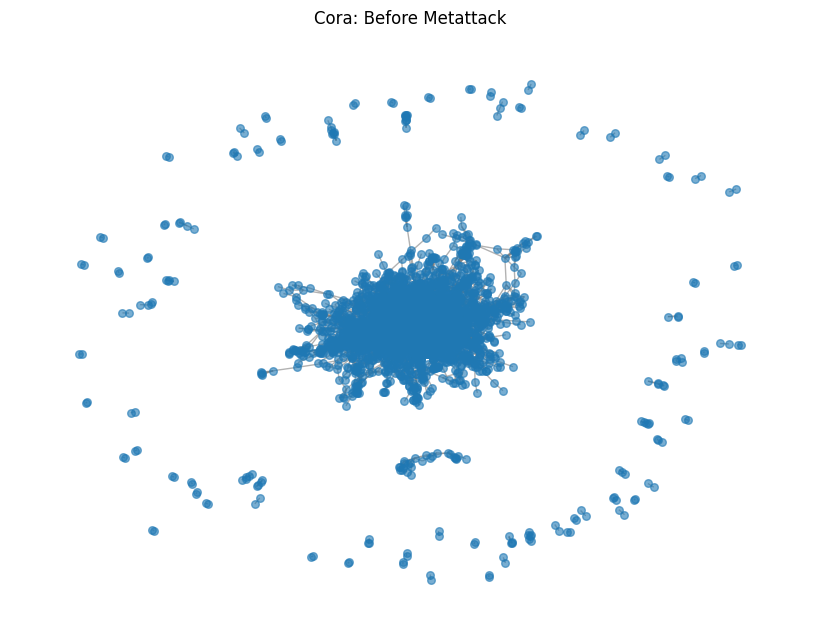

Running on 527 perturbations


Perturbing graph:   0%|          | 0/527 [00:00<?, ?it/s]

GCN loss on unlabled data: 0.7043552994728088
GCN acc on unlabled data: 0.7815420560747663
attack loss: 0.3251940906047821


Perturbing graph:   0%|          | 1/527 [00:19<2:47:32, 19.11s/it]

GCN loss on unlabled data: 0.6589013934135437
GCN acc on unlabled data: 0.7815420560747663
attack loss: 0.34299856424331665


Perturbing graph:   0%|          | 2/527 [00:39<2:56:04, 20.12s/it]

GCN loss on unlabled data: 0.6526543498039246
GCN acc on unlabled data: 0.7795950155763239
attack loss: 0.3287912905216217


Perturbing graph:   1%|          | 3/527 [00:57<2:47:02, 19.13s/it]

GCN loss on unlabled data: 0.6972801685333252
GCN acc on unlabled data: 0.7792056074766355
attack loss: 0.3264206647872925


Perturbing graph:   1%|          | 4/527 [01:18<2:52:39, 19.81s/it]

GCN loss on unlabled data: 0.7068383097648621
GCN acc on unlabled data: 0.7768691588785047
attack loss: 0.34444427490234375


Perturbing graph:   1%|          | 5/527 [01:39<2:53:49, 19.98s/it]

GCN loss on unlabled data: 0.7188636064529419
GCN acc on unlabled data: 0.7866043613707165
attack loss: 0.3291027247905731


Perturbing graph:   1%|          | 6/527 [01:58<2:51:13, 19.72s/it]

GCN loss on unlabled data: 0.7147039771080017
GCN acc on unlabled data: 0.772196261682243
attack loss: 0.34315600991249084


Perturbing graph:   1%|▏         | 7/527 [02:18<2:51:10, 19.75s/it]

GCN loss on unlabled data: 0.731116533279419
GCN acc on unlabled data: 0.7772585669781932
attack loss: 0.3244762122631073


Perturbing graph:   2%|▏         | 8/527 [02:36<2:48:10, 19.44s/it]

GCN loss on unlabled data: 0.7002102732658386
GCN acc on unlabled data: 0.778816199376947
attack loss: 0.32481878995895386


Perturbing graph:   2%|▏         | 9/527 [02:57<2:50:56, 19.80s/it]

GCN loss on unlabled data: 0.7276308536529541
GCN acc on unlabled data: 0.7741433021806854
attack loss: 0.32654133439064026


Perturbing graph:   2%|▏         | 10/527 [03:15<2:46:27, 19.32s/it]

GCN loss on unlabled data: 0.7332195043563843
GCN acc on unlabled data: 0.7795950155763239
attack loss: 0.3355255722999573


Perturbing graph:   2%|▏         | 11/527 [03:34<2:44:22, 19.11s/it]

GCN loss on unlabled data: 0.7447828054428101
GCN acc on unlabled data: 0.7601246105919003
attack loss: 0.34058690071105957


Perturbing graph:   2%|▏         | 12/527 [03:53<2:44:33, 19.17s/it]

GCN loss on unlabled data: 0.7101443409919739
GCN acc on unlabled data: 0.7819314641744548
attack loss: 0.3556244671344757


Perturbing graph:   2%|▏         | 13/527 [04:12<2:42:14, 18.94s/it]

GCN loss on unlabled data: 0.7139596343040466
GCN acc on unlabled data: 0.7862149532710281
attack loss: 0.3597188889980316


Perturbing graph:   3%|▎         | 14/527 [04:31<2:43:47, 19.16s/it]

GCN loss on unlabled data: 0.7288128733634949
GCN acc on unlabled data: 0.7823208722741433
attack loss: 0.33657553791999817


Perturbing graph:   3%|▎         | 15/527 [04:49<2:40:28, 18.81s/it]

GCN loss on unlabled data: 0.7317579984664917
GCN acc on unlabled data: 0.7757009345794392
attack loss: 0.3521769940853119


Perturbing graph:   3%|▎         | 16/527 [05:09<2:43:53, 19.24s/it]

GCN loss on unlabled data: 0.7513553500175476
GCN acc on unlabled data: 0.7714174454828661
attack loss: 0.3583254814147949


Perturbing graph:   3%|▎         | 17/527 [05:28<2:40:53, 18.93s/it]

GCN loss on unlabled data: 0.7378829121589661
GCN acc on unlabled data: 0.7862149532710281
attack loss: 0.35913416743278503


Perturbing graph:   3%|▎         | 18/527 [05:48<2:43:54, 19.32s/it]

GCN loss on unlabled data: 0.7301889061927795
GCN acc on unlabled data: 0.7733644859813084
attack loss: 0.34919410943984985


Perturbing graph:   4%|▎         | 19/527 [06:07<2:43:17, 19.29s/it]

GCN loss on unlabled data: 0.7019222974777222
GCN acc on unlabled data: 0.7881619937694704
attack loss: 0.33436498045921326


Perturbing graph:   4%|▍         | 20/527 [06:27<2:43:43, 19.38s/it]

GCN loss on unlabled data: 0.7127754092216492
GCN acc on unlabled data: 0.7753115264797508
attack loss: 0.3615870475769043


Perturbing graph:   4%|▍         | 21/527 [06:47<2:46:32, 19.75s/it]

GCN loss on unlabled data: 0.7751762270927429
GCN acc on unlabled data: 0.7706386292834891
attack loss: 0.3655222952365875


Perturbing graph:   4%|▍         | 22/527 [07:07<2:45:41, 19.69s/it]

GCN loss on unlabled data: 0.7335492372512817
GCN acc on unlabled data: 0.7733644859813084
attack loss: 0.35778552293777466


Perturbing graph:   4%|▍         | 23/527 [07:25<2:41:06, 19.18s/it]

GCN loss on unlabled data: 0.7320541143417358
GCN acc on unlabled data: 0.7897196261682243
attack loss: 0.3483603000640869


Perturbing graph:   5%|▍         | 24/527 [07:44<2:41:43, 19.29s/it]

GCN loss on unlabled data: 0.7388882040977478
GCN acc on unlabled data: 0.7725856697819314
attack loss: 0.36950117349624634


Perturbing graph:   5%|▍         | 25/527 [08:02<2:36:39, 18.72s/it]

GCN loss on unlabled data: 0.7621596455574036
GCN acc on unlabled data: 0.7741433021806854
attack loss: 0.37157341837882996


Perturbing graph:   5%|▍         | 26/527 [08:25<2:48:19, 20.16s/it]

GCN loss on unlabled data: 0.7634428143501282
GCN acc on unlabled data: 0.764018691588785
attack loss: 0.3767439126968384


Perturbing graph:   5%|▌         | 27/527 [08:44<2:43:26, 19.61s/it]

GCN loss on unlabled data: 0.7558450698852539
GCN acc on unlabled data: 0.7710280373831776
attack loss: 0.4098159968852997


Perturbing graph:   5%|▌         | 28/527 [09:04<2:45:08, 19.86s/it]

GCN loss on unlabled data: 0.756804347038269
GCN acc on unlabled data: 0.7651869158878505
attack loss: 0.3817591071128845


Perturbing graph:   6%|▌         | 29/527 [09:23<2:42:48, 19.61s/it]

GCN loss on unlabled data: 0.7443293333053589
GCN acc on unlabled data: 0.7784267912772586
attack loss: 0.3790012001991272


Perturbing graph:   6%|▌         | 30/527 [09:44<2:44:41, 19.88s/it]

GCN loss on unlabled data: 0.8139756917953491
GCN acc on unlabled data: 0.7535046728971962
attack loss: 0.4000426232814789


Perturbing graph:   6%|▌         | 31/527 [10:03<2:43:35, 19.79s/it]

GCN loss on unlabled data: 0.7801425457000732
GCN acc on unlabled data: 0.7651869158878505
attack loss: 0.3888646066188812


Perturbing graph:   6%|▌         | 32/527 [10:22<2:41:14, 19.54s/it]

GCN loss on unlabled data: 0.7872008681297302
GCN acc on unlabled data: 0.7671339563862928
attack loss: 0.37958112359046936


Perturbing graph:   6%|▋         | 33/527 [10:41<2:38:21, 19.23s/it]

GCN loss on unlabled data: 0.7938776612281799
GCN acc on unlabled data: 0.7527258566978193
attack loss: 0.3977605104446411


Perturbing graph:   6%|▋         | 34/527 [11:01<2:39:45, 19.44s/it]

GCN loss on unlabled data: 0.7719478607177734
GCN acc on unlabled data: 0.7484423676012462
attack loss: 0.39648202061653137


Perturbing graph:   7%|▋         | 35/527 [11:18<2:35:16, 18.94s/it]

GCN loss on unlabled data: 0.7524688839912415
GCN acc on unlabled data: 0.7538940809968847
attack loss: 0.3963579833507538


Perturbing graph:   7%|▋         | 36/527 [11:38<2:36:34, 19.13s/it]

GCN loss on unlabled data: 0.7678366899490356
GCN acc on unlabled data: 0.7558411214953271
attack loss: 0.4064962863922119


Perturbing graph:   7%|▋         | 37/527 [11:57<2:35:57, 19.10s/it]

GCN loss on unlabled data: 0.7666339874267578
GCN acc on unlabled data: 0.7659657320872274
attack loss: 0.4100886285305023


Perturbing graph:   7%|▋         | 38/527 [12:16<2:35:03, 19.03s/it]

GCN loss on unlabled data: 0.755800187587738
GCN acc on unlabled data: 0.7667445482866043
attack loss: 0.376844197511673


Perturbing graph:   7%|▋         | 39/527 [12:34<2:32:55, 18.80s/it]

GCN loss on unlabled data: 0.7926427721977234
GCN acc on unlabled data: 0.7562305295950156
attack loss: 0.3987118899822235


Perturbing graph:   8%|▊         | 40/527 [12:52<2:31:39, 18.68s/it]

GCN loss on unlabled data: 0.7770054340362549
GCN acc on unlabled data: 0.7651869158878505
attack loss: 0.3850853741168976


Perturbing graph:   8%|▊         | 41/527 [13:11<2:31:12, 18.67s/it]

GCN loss on unlabled data: 0.818858802318573
GCN acc on unlabled data: 0.7624610591900312
attack loss: 0.4033059775829315


Perturbing graph:   8%|▊         | 42/527 [13:29<2:29:05, 18.44s/it]

GCN loss on unlabled data: 0.8170087933540344
GCN acc on unlabled data: 0.7437694704049844
attack loss: 0.39931392669677734


Perturbing graph:   8%|▊         | 43/527 [13:48<2:30:30, 18.66s/it]

GCN loss on unlabled data: 0.7714091539382935
GCN acc on unlabled data: 0.7601246105919003
attack loss: 0.3876934349536896


Perturbing graph:   8%|▊         | 44/527 [14:07<2:31:13, 18.79s/it]

GCN loss on unlabled data: 0.7816762328147888
GCN acc on unlabled data: 0.7503894080996885
attack loss: 0.40684276819229126


Perturbing graph:   9%|▊         | 45/527 [14:26<2:30:48, 18.77s/it]

GCN loss on unlabled data: 0.8110866546630859
GCN acc on unlabled data: 0.7523364485981309
attack loss: 0.42011842131614685


Perturbing graph:   9%|▊         | 46/527 [14:44<2:29:16, 18.62s/it]

GCN loss on unlabled data: 0.794708788394928
GCN acc on unlabled data: 0.7464953271028038
attack loss: 0.3999146819114685


Perturbing graph:   9%|▉         | 47/527 [15:05<2:33:41, 19.21s/it]

GCN loss on unlabled data: 0.8427526950836182
GCN acc on unlabled data: 0.7437694704049844
attack loss: 0.42657679319381714


Perturbing graph:   9%|▉         | 48/527 [15:23<2:31:01, 18.92s/it]

GCN loss on unlabled data: 0.822203516960144
GCN acc on unlabled data: 0.7367601246105919
attack loss: 0.4167507290840149


Perturbing graph:   9%|▉         | 49/527 [15:41<2:29:11, 18.73s/it]

GCN loss on unlabled data: 0.8327849507331848
GCN acc on unlabled data: 0.7387071651090342
attack loss: 0.4177522659301758


Perturbing graph:   9%|▉         | 50/527 [16:00<2:29:26, 18.80s/it]

GCN loss on unlabled data: 0.7985227704048157
GCN acc on unlabled data: 0.7651869158878505
attack loss: 0.42832815647125244


Perturbing graph:  10%|▉         | 51/527 [16:19<2:28:37, 18.73s/it]

GCN loss on unlabled data: 0.7993640303611755
GCN acc on unlabled data: 0.7546728971962616
attack loss: 0.401924192905426


Perturbing graph:  10%|▉         | 52/527 [16:38<2:28:18, 18.73s/it]

GCN loss on unlabled data: 0.844046413898468
GCN acc on unlabled data: 0.7496105919003115
attack loss: 0.3968809247016907


Perturbing graph:  10%|█         | 53/527 [16:57<2:28:23, 18.78s/it]

GCN loss on unlabled data: 0.817834198474884
GCN acc on unlabled data: 0.7538940809968847
attack loss: 0.42454594373703003


Perturbing graph:  10%|█         | 54/527 [17:15<2:27:40, 18.73s/it]

GCN loss on unlabled data: 0.8224496841430664
GCN acc on unlabled data: 0.7527258566978193
attack loss: 0.4267663061618805


Perturbing graph:  10%|█         | 55/527 [17:34<2:28:06, 18.83s/it]

GCN loss on unlabled data: 0.8449229598045349
GCN acc on unlabled data: 0.7309190031152648
attack loss: 0.42332157492637634


Perturbing graph:  11%|█         | 56/527 [17:54<2:29:22, 19.03s/it]

GCN loss on unlabled data: 0.8334650993347168
GCN acc on unlabled data: 0.7387071651090342
attack loss: 0.4367694556713104


Perturbing graph:  11%|█         | 57/527 [18:12<2:28:00, 18.90s/it]

GCN loss on unlabled data: 0.8455231785774231
GCN acc on unlabled data: 0.7480529595015576
attack loss: 0.4192468225955963


Perturbing graph:  11%|█         | 58/527 [18:32<2:30:19, 19.23s/it]

GCN loss on unlabled data: 0.8346046209335327
GCN acc on unlabled data: 0.7429906542056075
attack loss: 0.41030287742614746


Perturbing graph:  11%|█         | 59/527 [18:51<2:29:14, 19.13s/it]

GCN loss on unlabled data: 0.845605194568634
GCN acc on unlabled data: 0.7542834890965732
attack loss: 0.4157458543777466


Perturbing graph:  11%|█▏        | 60/527 [19:10<2:28:24, 19.07s/it]

GCN loss on unlabled data: 0.8485345244407654
GCN acc on unlabled data: 0.7242990654205608
attack loss: 0.4222162961959839


Perturbing graph:  12%|█▏        | 61/527 [19:29<2:26:52, 18.91s/it]

GCN loss on unlabled data: 0.8367579579353333
GCN acc on unlabled data: 0.7344236760124611
attack loss: 0.41345658898353577


Perturbing graph:  12%|█▏        | 62/527 [19:48<2:27:16, 19.00s/it]

GCN loss on unlabled data: 0.9076298475265503
GCN acc on unlabled data: 0.7157320872274143
attack loss: 0.4322720170021057


Perturbing graph:  12%|█▏        | 63/527 [20:06<2:25:02, 18.76s/it]

GCN loss on unlabled data: 0.8411073088645935
GCN acc on unlabled data: 0.735202492211838
attack loss: 0.4178982377052307


Perturbing graph:  12%|█▏        | 64/527 [20:26<2:26:35, 19.00s/it]

GCN loss on unlabled data: 0.8874076008796692
GCN acc on unlabled data: 0.7231308411214953
attack loss: 0.44676706194877625


Perturbing graph:  12%|█▏        | 65/527 [20:44<2:24:31, 18.77s/it]

GCN loss on unlabled data: 0.8340306878089905
GCN acc on unlabled data: 0.7348130841121495
attack loss: 0.4292747378349304


Perturbing graph:  13%|█▎        | 66/527 [21:04<2:27:34, 19.21s/it]

GCN loss on unlabled data: 0.8810083270072937
GCN acc on unlabled data: 0.7250778816199377
attack loss: 0.464789479970932


Perturbing graph:  13%|█▎        | 67/527 [21:22<2:24:55, 18.90s/it]

GCN loss on unlabled data: 0.8576693534851074
GCN acc on unlabled data: 0.7274143302180686
attack loss: 0.4212587773799896


Perturbing graph:  13%|█▎        | 68/527 [21:44<2:29:58, 19.60s/it]

GCN loss on unlabled data: 0.8567317724227905
GCN acc on unlabled data: 0.7231308411214953
attack loss: 0.42781421542167664


Perturbing graph:  13%|█▎        | 69/527 [22:02<2:26:37, 19.21s/it]

GCN loss on unlabled data: 0.8737646341323853
GCN acc on unlabled data: 0.7441588785046729
attack loss: 0.43961966037750244


Perturbing graph:  13%|█▎        | 70/527 [22:22<2:28:47, 19.53s/it]

GCN loss on unlabled data: 0.8718763589859009
GCN acc on unlabled data: 0.7371495327102804
attack loss: 0.4177866578102112


Perturbing graph:  13%|█▎        | 71/527 [22:41<2:27:34, 19.42s/it]

GCN loss on unlabled data: 0.8835793137550354
GCN acc on unlabled data: 0.7242990654205608
attack loss: 0.4557479918003082


Perturbing graph:  14%|█▎        | 72/527 [23:02<2:30:45, 19.88s/it]

GCN loss on unlabled data: 0.9102521538734436
GCN acc on unlabled data: 0.7122274143302181
attack loss: 0.4671415686607361


Perturbing graph:  14%|█▍        | 73/527 [23:21<2:26:52, 19.41s/it]

GCN loss on unlabled data: 0.9051241874694824
GCN acc on unlabled data: 0.7204049844236761
attack loss: 0.44764989614486694


Perturbing graph:  14%|█▍        | 74/527 [23:41<2:27:55, 19.59s/it]

GCN loss on unlabled data: 0.9081634879112244
GCN acc on unlabled data: 0.7071651090342679
attack loss: 0.47019651532173157


Perturbing graph:  14%|█▍        | 75/527 [23:59<2:25:26, 19.31s/it]

GCN loss on unlabled data: 0.931098461151123
GCN acc on unlabled data: 0.7044392523364486
attack loss: 0.46983498334884644


Perturbing graph:  14%|█▍        | 76/527 [24:19<2:26:43, 19.52s/it]

GCN loss on unlabled data: 0.8925543427467346
GCN acc on unlabled data: 0.7266355140186916
attack loss: 0.4427386224269867


Perturbing graph:  15%|█▍        | 77/527 [24:38<2:23:43, 19.16s/it]

GCN loss on unlabled data: 0.9136699438095093
GCN acc on unlabled data: 0.7153426791277259
attack loss: 0.45846638083457947


Perturbing graph:  15%|█▍        | 78/527 [24:57<2:24:16, 19.28s/it]

GCN loss on unlabled data: 0.8865183591842651
GCN acc on unlabled data: 0.7289719626168224
attack loss: 0.45207124948501587


Perturbing graph:  15%|█▍        | 79/527 [25:15<2:21:34, 18.96s/it]

GCN loss on unlabled data: 0.9338394999504089
GCN acc on unlabled data: 0.7013239875389408
attack loss: 0.4722256660461426


Perturbing graph:  15%|█▌        | 80/527 [25:34<2:19:40, 18.75s/it]

GCN loss on unlabled data: 0.951858401298523
GCN acc on unlabled data: 0.7215732087227414
attack loss: 0.5033910870552063


Perturbing graph:  15%|█▌        | 81/527 [25:53<2:20:03, 18.84s/it]

GCN loss on unlabled data: 0.9963380694389343
GCN acc on unlabled data: 0.7091121495327103
attack loss: 0.5009649991989136


Perturbing graph:  16%|█▌        | 82/527 [26:11<2:17:50, 18.59s/it]

GCN loss on unlabled data: 0.988741397857666
GCN acc on unlabled data: 0.6943146417445483
attack loss: 0.48296019434928894


Perturbing graph:  16%|█▌        | 83/527 [26:31<2:21:23, 19.11s/it]

GCN loss on unlabled data: 0.9120708703994751
GCN acc on unlabled data: 0.7126168224299065
attack loss: 0.47509801387786865


Perturbing graph:  16%|█▌        | 84/527 [26:51<2:22:41, 19.33s/it]

GCN loss on unlabled data: 0.9999967813491821
GCN acc on unlabled data: 0.7032710280373832
attack loss: 0.49468278884887695


Perturbing graph:  16%|█▌        | 85/527 [27:10<2:21:51, 19.26s/it]

GCN loss on unlabled data: 0.9040544629096985
GCN acc on unlabled data: 0.7227414330218068
attack loss: 0.47286924719810486


Perturbing graph:  16%|█▋        | 86/527 [27:28<2:19:15, 18.95s/it]

GCN loss on unlabled data: 0.9809255599975586
GCN acc on unlabled data: 0.7071651090342679
attack loss: 0.4983826279640198


Perturbing graph:  17%|█▋        | 87/527 [27:49<2:22:19, 19.41s/it]

GCN loss on unlabled data: 0.9392232298851013
GCN acc on unlabled data: 0.69898753894081
attack loss: 0.4797683656215668


Perturbing graph:  17%|█▋        | 88/527 [28:07<2:19:57, 19.13s/it]

GCN loss on unlabled data: 0.9391789436340332
GCN acc on unlabled data: 0.7200155763239875
attack loss: 0.5150963664054871


Perturbing graph:  17%|█▋        | 89/527 [28:27<2:21:09, 19.34s/it]

GCN loss on unlabled data: 1.004634976387024
GCN acc on unlabled data: 0.6857476635514018
attack loss: 0.500688374042511


Perturbing graph:  17%|█▋        | 90/527 [28:46<2:20:02, 19.23s/it]

GCN loss on unlabled data: 0.9830746054649353
GCN acc on unlabled data: 0.7013239875389408
attack loss: 0.49828094244003296


Perturbing graph:  17%|█▋        | 91/527 [29:05<2:19:50, 19.24s/it]

GCN loss on unlabled data: 0.9955809116363525
GCN acc on unlabled data: 0.7169003115264797
attack loss: 0.5368506908416748


Perturbing graph:  17%|█▋        | 92/527 [29:24<2:18:44, 19.14s/it]

GCN loss on unlabled data: 0.9704722762107849
GCN acc on unlabled data: 0.7176791277258567
attack loss: 0.48657870292663574


Perturbing graph:  18%|█▊        | 93/527 [29:43<2:18:27, 19.14s/it]

GCN loss on unlabled data: 0.9758797287940979
GCN acc on unlabled data: 0.6950934579439252
attack loss: 0.512001633644104


Perturbing graph:  18%|█▊        | 94/527 [30:02<2:16:29, 18.91s/it]

GCN loss on unlabled data: 1.0069648027420044
GCN acc on unlabled data: 0.7005451713395638
attack loss: 0.5378580689430237


Perturbing graph:  18%|█▊        | 95/527 [30:21<2:17:41, 19.12s/it]

GCN loss on unlabled data: 1.027847409248352
GCN acc on unlabled data: 0.7137850467289719
attack loss: 0.5241514444351196


Perturbing graph:  18%|█▊        | 96/527 [30:41<2:19:48, 19.46s/it]

GCN loss on unlabled data: 1.0015641450881958
GCN acc on unlabled data: 0.7118380062305296
attack loss: 0.5042675733566284


Perturbing graph:  18%|█▊        | 97/527 [31:02<2:21:34, 19.75s/it]

GCN loss on unlabled data: 0.9935407042503357
GCN acc on unlabled data: 0.7110591900311527
attack loss: 0.5268651843070984


Perturbing graph:  19%|█▊        | 98/527 [31:21<2:19:41, 19.54s/it]

GCN loss on unlabled data: 0.9415575265884399
GCN acc on unlabled data: 0.7024922118380063
attack loss: 0.47685763239860535


Perturbing graph:  19%|█▉        | 99/527 [31:41<2:19:41, 19.58s/it]

GCN loss on unlabled data: 1.0240931510925293
GCN acc on unlabled data: 0.7161214953271028
attack loss: 0.5434610843658447


Perturbing graph:  19%|█▉        | 100/527 [31:59<2:16:51, 19.23s/it]

GCN loss on unlabled data: 0.9696103930473328
GCN acc on unlabled data: 0.7079439252336449
attack loss: 0.5267658829689026


Perturbing graph:  19%|█▉        | 101/527 [32:20<2:19:33, 19.66s/it]

GCN loss on unlabled data: 0.9664703011512756
GCN acc on unlabled data: 0.7091121495327103
attack loss: 0.5118396282196045


Perturbing graph:  19%|█▉        | 102/527 [32:39<2:17:49, 19.46s/it]

GCN loss on unlabled data: 1.0149027109146118
GCN acc on unlabled data: 0.6752336448598131
attack loss: 0.5353901386260986


Perturbing graph:  20%|█▉        | 103/527 [32:59<2:18:24, 19.59s/it]

GCN loss on unlabled data: 1.0129607915878296
GCN acc on unlabled data: 0.6880841121495327
attack loss: 0.5401925444602966


Perturbing graph:  20%|█▉        | 104/527 [33:18<2:17:33, 19.51s/it]

GCN loss on unlabled data: 1.0482306480407715
GCN acc on unlabled data: 0.6884735202492211
attack loss: 0.5549144148826599


Perturbing graph:  20%|█▉        | 105/527 [33:38<2:19:02, 19.77s/it]

GCN loss on unlabled data: 1.0626335144042969
GCN acc on unlabled data: 0.6896417445482866
attack loss: 0.5398753881454468


Perturbing graph:  20%|██        | 106/527 [33:57<2:16:21, 19.43s/it]

GCN loss on unlabled data: 0.9881094694137573
GCN acc on unlabled data: 0.7059968847352025
attack loss: 0.5420853495597839


Perturbing graph:  20%|██        | 107/527 [34:16<2:16:12, 19.46s/it]

GCN loss on unlabled data: 1.0376977920532227
GCN acc on unlabled data: 0.6892523364485982
attack loss: 0.5407667756080627


Perturbing graph:  20%|██        | 108/527 [34:37<2:17:49, 19.74s/it]

GCN loss on unlabled data: 1.058154821395874
GCN acc on unlabled data: 0.690809968847352
attack loss: 0.5486797094345093


Perturbing graph:  21%|██        | 109/527 [34:57<2:17:56, 19.80s/it]

GCN loss on unlabled data: 1.0824021100997925
GCN acc on unlabled data: 0.6939252336448598
attack loss: 0.5659971833229065


Perturbing graph:  21%|██        | 110/527 [35:15<2:14:30, 19.35s/it]

GCN loss on unlabled data: 1.038212776184082
GCN acc on unlabled data: 0.6779595015576324
attack loss: 0.5726815462112427


Perturbing graph:  21%|██        | 111/527 [35:36<2:16:52, 19.74s/it]

GCN loss on unlabled data: 1.125168800354004
GCN acc on unlabled data: 0.6631619937694704
attack loss: 0.591583251953125


Perturbing graph:  21%|██▏       | 112/527 [35:56<2:17:05, 19.82s/it]

GCN loss on unlabled data: 1.0145829916000366
GCN acc on unlabled data: 0.6643302180685359
attack loss: 0.5406132936477661


Perturbing graph:  21%|██▏       | 113/527 [36:16<2:17:52, 19.98s/it]

GCN loss on unlabled data: 1.1346935033798218
GCN acc on unlabled data: 0.6475856697819314
attack loss: 0.5793679356575012


Perturbing graph:  22%|██▏       | 114/527 [36:37<2:18:45, 20.16s/it]

GCN loss on unlabled data: 1.1090991497039795
GCN acc on unlabled data: 0.668613707165109
attack loss: 0.570893406867981


Perturbing graph:  22%|██▏       | 115/527 [36:55<2:15:31, 19.74s/it]

GCN loss on unlabled data: 1.1281116008758545
GCN acc on unlabled data: 0.6651090342679128
attack loss: 0.5741890072822571


Perturbing graph:  22%|██▏       | 116/527 [37:16<2:16:32, 19.93s/it]

GCN loss on unlabled data: 1.084831714630127
GCN acc on unlabled data: 0.6728971962616822
attack loss: 0.5570122003555298


Perturbing graph:  22%|██▏       | 117/527 [37:36<2:16:22, 19.96s/it]

GCN loss on unlabled data: 1.0601005554199219
GCN acc on unlabled data: 0.6627725856697819
attack loss: 0.5526055693626404


Perturbing graph:  22%|██▏       | 118/527 [37:56<2:16:58, 20.09s/it]

GCN loss on unlabled data: 1.040817379951477
GCN acc on unlabled data: 0.6682242990654206
attack loss: 0.5367483496665955


Perturbing graph:  23%|██▎       | 119/527 [38:16<2:17:01, 20.15s/it]

GCN loss on unlabled data: 1.059686541557312
GCN acc on unlabled data: 0.6752336448598131
attack loss: 0.5366002321243286


Perturbing graph:  23%|██▎       | 120/527 [38:37<2:17:26, 20.26s/it]

GCN loss on unlabled data: 1.0896024703979492
GCN acc on unlabled data: 0.6522585669781932
attack loss: 0.5615413188934326


Perturbing graph:  23%|██▎       | 121/527 [38:55<2:11:53, 19.49s/it]

GCN loss on unlabled data: 1.0598379373550415
GCN acc on unlabled data: 0.668613707165109
attack loss: 0.5734676718711853


Perturbing graph:  23%|██▎       | 122/527 [39:15<2:12:54, 19.69s/it]

GCN loss on unlabled data: 1.0514494180679321
GCN acc on unlabled data: 0.6573208722741433
attack loss: 0.537949800491333


Perturbing graph:  23%|██▎       | 123/527 [39:34<2:12:21, 19.66s/it]

GCN loss on unlabled data: 1.1577609777450562
GCN acc on unlabled data: 0.6464174454828661
attack loss: 0.584350049495697


Perturbing graph:  24%|██▎       | 124/527 [39:56<2:15:35, 20.19s/it]

GCN loss on unlabled data: 1.1598883867263794
GCN acc on unlabled data: 0.6440809968847352
attack loss: 0.6064523458480835


Perturbing graph:  24%|██▎       | 125/527 [40:15<2:13:04, 19.86s/it]

GCN loss on unlabled data: 1.1340519189834595
GCN acc on unlabled data: 0.6503115264797508
attack loss: 0.6013215184211731


Perturbing graph:  24%|██▍       | 126/527 [40:34<2:10:39, 19.55s/it]

GCN loss on unlabled data: 1.0652326345443726
GCN acc on unlabled data: 0.6596573208722741
attack loss: 0.5573927164077759


Perturbing graph:  24%|██▍       | 127/527 [40:53<2:09:43, 19.46s/it]

GCN loss on unlabled data: 1.2016814947128296
GCN acc on unlabled data: 0.6413551401869159
attack loss: 0.6195828318595886


Perturbing graph:  24%|██▍       | 128/527 [41:13<2:10:37, 19.64s/it]

GCN loss on unlabled data: 1.0736230611801147
GCN acc on unlabled data: 0.6771806853582555
attack loss: 0.5598530769348145


Perturbing graph:  24%|██▍       | 129/527 [41:31<2:06:19, 19.04s/it]

GCN loss on unlabled data: 1.0937960147857666
GCN acc on unlabled data: 0.6764018691588785
attack loss: 0.5817776918411255


Perturbing graph:  25%|██▍       | 130/527 [41:51<2:09:21, 19.55s/it]

GCN loss on unlabled data: 1.2013081312179565
GCN acc on unlabled data: 0.6534267912772586
attack loss: 0.6169503927230835


Perturbing graph:  25%|██▍       | 131/527 [42:11<2:09:14, 19.58s/it]

GCN loss on unlabled data: 1.1821563243865967
GCN acc on unlabled data: 0.6300623052959502
attack loss: 0.5999944806098938


Perturbing graph:  25%|██▌       | 132/527 [42:30<2:06:33, 19.22s/it]

GCN loss on unlabled data: 1.1150825023651123
GCN acc on unlabled data: 0.6569314641744548
attack loss: 0.5933456420898438


Perturbing graph:  25%|██▌       | 133/527 [42:49<2:05:58, 19.18s/it]

GCN loss on unlabled data: 1.1851927042007446
GCN acc on unlabled data: 0.6565420560747663
attack loss: 0.6111429333686829


Perturbing graph:  25%|██▌       | 134/527 [43:10<2:09:13, 19.73s/it]

GCN loss on unlabled data: 1.1185846328735352
GCN acc on unlabled data: 0.6452492211838006
attack loss: 0.5912513136863708


Perturbing graph:  26%|██▌       | 135/527 [43:31<2:11:33, 20.14s/it]

GCN loss on unlabled data: 1.2009923458099365
GCN acc on unlabled data: 0.6304517133956387
attack loss: 0.6255499124526978


Perturbing graph:  26%|██▌       | 136/527 [43:50<2:09:17, 19.84s/it]

GCN loss on unlabled data: 1.2177422046661377
GCN acc on unlabled data: 0.6429127725856698
attack loss: 0.6399561762809753


Perturbing graph:  26%|██▌       | 137/527 [44:11<2:11:36, 20.25s/it]

GCN loss on unlabled data: 1.1600757837295532
GCN acc on unlabled data: 0.6413551401869159
attack loss: 0.588991641998291


Perturbing graph:  26%|██▌       | 138/527 [44:31<2:10:07, 20.07s/it]

GCN loss on unlabled data: 1.2075920104980469
GCN acc on unlabled data: 0.6514797507788161
attack loss: 0.6307896375656128


Perturbing graph:  26%|██▋       | 139/527 [44:51<2:10:26, 20.17s/it]

GCN loss on unlabled data: 1.1946709156036377
GCN acc on unlabled data: 0.6320093457943925
attack loss: 0.6160456538200378


Perturbing graph:  27%|██▋       | 140/527 [45:11<2:10:02, 20.16s/it]

GCN loss on unlabled data: 1.1327698230743408
GCN acc on unlabled data: 0.6433021806853583
attack loss: 0.5968263149261475


Perturbing graph:  27%|██▋       | 141/527 [45:31<2:09:52, 20.19s/it]

GCN loss on unlabled data: 1.2470253705978394
GCN acc on unlabled data: 0.6312305295950156
attack loss: 0.6393992304801941


Perturbing graph:  27%|██▋       | 142/527 [45:53<2:11:23, 20.48s/it]

GCN loss on unlabled data: 1.2123888731002808
GCN acc on unlabled data: 0.6343457943925234
attack loss: 0.637407660484314


Perturbing graph:  27%|██▋       | 143/527 [46:11<2:07:11, 19.87s/it]

GCN loss on unlabled data: 1.268813133239746
GCN acc on unlabled data: 0.610202492211838
attack loss: 0.6568067073822021


Perturbing graph:  27%|██▋       | 144/527 [46:29<2:03:13, 19.30s/it]

GCN loss on unlabled data: 1.2397019863128662
GCN acc on unlabled data: 0.6351246105919003
attack loss: 0.6470745801925659


Perturbing graph:  28%|██▊       | 145/527 [46:50<2:06:11, 19.82s/it]

GCN loss on unlabled data: 1.20107901096344
GCN acc on unlabled data: 0.6098130841121495
attack loss: 0.64924156665802


Perturbing graph:  28%|██▊       | 146/527 [47:10<2:05:08, 19.71s/it]

GCN loss on unlabled data: 1.2066127061843872
GCN acc on unlabled data: 0.6468068535825545
attack loss: 0.6325910687446594


Perturbing graph:  28%|██▊       | 147/527 [47:29<2:04:42, 19.69s/it]

GCN loss on unlabled data: 1.260555624961853
GCN acc on unlabled data: 0.6179906542056075
attack loss: 0.6594020128250122


Perturbing graph:  28%|██▊       | 148/527 [47:49<2:05:12, 19.82s/it]

GCN loss on unlabled data: 1.2188444137573242
GCN acc on unlabled data: 0.6355140186915887
attack loss: 0.6522814035415649


Perturbing graph:  28%|██▊       | 149/527 [48:08<2:02:09, 19.39s/it]

GCN loss on unlabled data: 1.282548427581787
GCN acc on unlabled data: 0.6078660436137072
attack loss: 0.6696925163269043


Perturbing graph:  28%|██▊       | 150/527 [48:27<2:01:15, 19.30s/it]

GCN loss on unlabled data: 1.2309818267822266
GCN acc on unlabled data: 0.6144859813084113
attack loss: 0.6406693458557129


Perturbing graph:  29%|██▊       | 151/527 [48:45<1:59:46, 19.11s/it]

GCN loss on unlabled data: 1.3297138214111328
GCN acc on unlabled data: 0.6125389408099688
attack loss: 0.6938033103942871


Perturbing graph:  29%|██▉       | 152/527 [49:04<1:59:05, 19.06s/it]

GCN loss on unlabled data: 1.285179615020752
GCN acc on unlabled data: 0.6292834890965732
attack loss: 0.6683322191238403


Perturbing graph:  29%|██▉       | 153/527 [49:24<2:00:11, 19.28s/it]

GCN loss on unlabled data: 1.2268279790878296
GCN acc on unlabled data: 0.6039719626168224
attack loss: 0.656741738319397


Perturbing graph:  29%|██▉       | 154/527 [49:43<1:58:40, 19.09s/it]

GCN loss on unlabled data: 1.2329314947128296
GCN acc on unlabled data: 0.617601246105919
attack loss: 0.6451734900474548


Perturbing graph:  29%|██▉       | 155/527 [50:02<1:58:26, 19.10s/it]

GCN loss on unlabled data: 1.2133663892745972
GCN acc on unlabled data: 0.618380062305296
attack loss: 0.6197649240493774


Perturbing graph:  30%|██▉       | 156/527 [50:20<1:55:32, 18.69s/it]

GCN loss on unlabled data: 1.2201331853866577
GCN acc on unlabled data: 0.6218847352024922
attack loss: 0.6392192244529724


Perturbing graph:  30%|██▉       | 157/527 [50:41<2:00:15, 19.50s/it]

GCN loss on unlabled data: 1.3431580066680908
GCN acc on unlabled data: 0.5954049844236761
attack loss: 0.6749216318130493


Perturbing graph:  30%|██▉       | 158/527 [51:00<1:58:48, 19.32s/it]

GCN loss on unlabled data: 1.333390235900879
GCN acc on unlabled data: 0.6035825545171339
attack loss: 0.6897022128105164


Perturbing graph:  30%|███       | 159/527 [51:19<1:58:16, 19.28s/it]

GCN loss on unlabled data: 1.2740994691848755
GCN acc on unlabled data: 0.6144859813084113
attack loss: 0.681574821472168


Perturbing graph:  30%|███       | 160/527 [51:39<1:59:17, 19.50s/it]

GCN loss on unlabled data: 1.2273070812225342
GCN acc on unlabled data: 0.6199376947040498
attack loss: 0.6392109394073486


Perturbing graph:  31%|███       | 161/527 [52:01<2:02:21, 20.06s/it]

GCN loss on unlabled data: 1.2828888893127441
GCN acc on unlabled data: 0.6070872274143302
attack loss: 0.6559054255485535


Perturbing graph:  31%|███       | 162/527 [52:20<2:00:59, 19.89s/it]

GCN loss on unlabled data: 1.321844220161438
GCN acc on unlabled data: 0.5965732087227414
attack loss: 0.6936259269714355


Perturbing graph:  31%|███       | 163/527 [52:39<1:58:42, 19.57s/it]

GCN loss on unlabled data: 1.2455264329910278
GCN acc on unlabled data: 0.581386292834891
attack loss: 0.6332364678382874


Perturbing graph:  31%|███       | 164/527 [52:57<1:55:14, 19.05s/it]

GCN loss on unlabled data: 1.3627017736434937
GCN acc on unlabled data: 0.6090342679127726
attack loss: 0.7273905873298645


Perturbing graph:  31%|███▏      | 165/527 [53:17<1:57:13, 19.43s/it]

GCN loss on unlabled data: 1.33646821975708
GCN acc on unlabled data: 0.6020249221183801
attack loss: 0.7075508832931519


Perturbing graph:  31%|███▏      | 166/527 [53:36<1:55:17, 19.16s/it]

GCN loss on unlabled data: 1.3583002090454102
GCN acc on unlabled data: 0.5934579439252337
attack loss: 0.7146679162979126


Perturbing graph:  32%|███▏      | 167/527 [53:55<1:55:40, 19.28s/it]

GCN loss on unlabled data: 1.386400580406189
GCN acc on unlabled data: 0.6055295950155763
attack loss: 0.7191354632377625


Perturbing graph:  32%|███▏      | 168/527 [54:13<1:52:20, 18.78s/it]

GCN loss on unlabled data: 1.4354406595230103
GCN acc on unlabled data: 0.5915109034267912
attack loss: 0.7332033514976501


Perturbing graph:  32%|███▏      | 169/527 [54:32<1:53:44, 19.06s/it]

GCN loss on unlabled data: 1.3228565454483032
GCN acc on unlabled data: 0.6000778816199377
attack loss: 0.6881870031356812


Perturbing graph:  32%|███▏      | 170/527 [54:51<1:52:35, 18.92s/it]

GCN loss on unlabled data: 1.3890058994293213
GCN acc on unlabled data: 0.5860591900311527
attack loss: 0.7296273112297058


Perturbing graph:  32%|███▏      | 171/527 [55:11<1:53:28, 19.12s/it]

GCN loss on unlabled data: 1.358717441558838
GCN acc on unlabled data: 0.6016355140186916
attack loss: 0.7194300293922424


Perturbing graph:  33%|███▎      | 172/527 [55:30<1:53:40, 19.21s/it]

GCN loss on unlabled data: 1.368470311164856
GCN acc on unlabled data: 0.6160436137071651
attack loss: 0.7111575603485107


Perturbing graph:  33%|███▎      | 173/527 [55:50<1:54:12, 19.36s/it]

GCN loss on unlabled data: 1.2375526428222656
GCN acc on unlabled data: 0.6238317757009346
attack loss: 0.6524003744125366


Perturbing graph:  33%|███▎      | 174/527 [56:08<1:52:30, 19.12s/it]

GCN loss on unlabled data: 1.2892111539840698
GCN acc on unlabled data: 0.5985202492211839
attack loss: 0.6652852296829224


Perturbing graph:  33%|███▎      | 175/527 [56:28<1:53:48, 19.40s/it]

GCN loss on unlabled data: 1.5190035104751587
GCN acc on unlabled data: 0.5669781931464174
attack loss: 0.7585875391960144


Perturbing graph:  33%|███▎      | 176/527 [56:48<1:53:47, 19.45s/it]

GCN loss on unlabled data: 1.3538047075271606
GCN acc on unlabled data: 0.5887850467289719
attack loss: 0.6960126161575317


Perturbing graph:  34%|███▎      | 177/527 [57:08<1:54:08, 19.57s/it]

GCN loss on unlabled data: 1.3493658304214478
GCN acc on unlabled data: 0.5821651090342679
attack loss: 0.6957767009735107


Perturbing graph:  34%|███▍      | 178/527 [57:29<1:57:07, 20.14s/it]

GCN loss on unlabled data: 1.3146860599517822
GCN acc on unlabled data: 0.5926791277258567
attack loss: 0.6858556866645813


Perturbing graph:  34%|███▍      | 179/527 [57:49<1:55:28, 19.91s/it]

GCN loss on unlabled data: 1.4848897457122803
GCN acc on unlabled data: 0.5907320872274143
attack loss: 0.7518689036369324


Perturbing graph:  34%|███▍      | 180/527 [58:07<1:53:19, 19.59s/it]

GCN loss on unlabled data: 1.3859601020812988
GCN acc on unlabled data: 0.5821651090342679
attack loss: 0.7419353127479553


Perturbing graph:  34%|███▍      | 181/527 [58:27<1:52:04, 19.43s/it]

GCN loss on unlabled data: 1.4579061269760132
GCN acc on unlabled data: 0.5821651090342679
attack loss: 0.7377360463142395


Perturbing graph:  35%|███▍      | 182/527 [58:46<1:52:22, 19.54s/it]

GCN loss on unlabled data: 1.3474550247192383
GCN acc on unlabled data: 0.5915109034267912
attack loss: 0.7219679355621338


Perturbing graph:  35%|███▍      | 183/527 [59:06<1:52:07, 19.56s/it]

GCN loss on unlabled data: 1.2108434438705444
GCN acc on unlabled data: 0.6140965732087228
attack loss: 0.6478957533836365


Perturbing graph:  35%|███▍      | 184/527 [59:25<1:51:05, 19.43s/it]

GCN loss on unlabled data: 1.3788210153579712
GCN acc on unlabled data: 0.5845015576323987
attack loss: 0.7215863466262817


Perturbing graph:  35%|███▌      | 185/527 [59:45<1:51:12, 19.51s/it]

GCN loss on unlabled data: 1.4297220706939697
GCN acc on unlabled data: 0.573208722741433
attack loss: 0.7544102072715759


Perturbing graph:  35%|███▌      | 186/527 [1:00:04<1:50:03, 19.37s/it]

GCN loss on unlabled data: 1.468306064605713
GCN acc on unlabled data: 0.5954049844236761
attack loss: 0.7504162192344666


Perturbing graph:  35%|███▌      | 187/527 [1:00:23<1:50:01, 19.42s/it]

GCN loss on unlabled data: 1.4544847011566162
GCN acc on unlabled data: 0.5864485981308412
attack loss: 0.7584991455078125


Perturbing graph:  36%|███▌      | 188/527 [1:00:43<1:49:43, 19.42s/it]

GCN loss on unlabled data: 1.3397407531738281
GCN acc on unlabled data: 0.5992990654205608
attack loss: 0.6955353021621704


Perturbing graph:  36%|███▌      | 189/527 [1:01:03<1:50:55, 19.69s/it]

GCN loss on unlabled data: 1.3118387460708618
GCN acc on unlabled data: 0.5887850467289719
attack loss: 0.690005362033844


Perturbing graph:  36%|███▌      | 190/527 [1:01:23<1:50:15, 19.63s/it]

GCN loss on unlabled data: 1.4192391633987427
GCN acc on unlabled data: 0.5829439252336449
attack loss: 0.7514258027076721


Perturbing graph:  36%|███▌      | 191/527 [1:01:42<1:49:20, 19.53s/it]

GCN loss on unlabled data: 1.4242795705795288
GCN acc on unlabled data: 0.5794392523364486
attack loss: 0.7485259771347046


Perturbing graph:  36%|███▋      | 192/527 [1:02:00<1:46:48, 19.13s/it]

GCN loss on unlabled data: 1.4197582006454468
GCN acc on unlabled data: 0.5903426791277259
attack loss: 0.7372316718101501


Perturbing graph:  37%|███▋      | 193/527 [1:02:20<1:47:46, 19.36s/it]

GCN loss on unlabled data: 1.5943553447723389
GCN acc on unlabled data: 0.5634735202492211
attack loss: 0.8036413788795471


Perturbing graph:  37%|███▋      | 194/527 [1:02:38<1:44:44, 18.87s/it]

GCN loss on unlabled data: 1.4391452074050903
GCN acc on unlabled data: 0.5755451713395638
attack loss: 0.7477990388870239


Perturbing graph:  37%|███▋      | 195/527 [1:02:57<1:45:46, 19.12s/it]

GCN loss on unlabled data: 1.5112507343292236
GCN acc on unlabled data: 0.5634735202492211
attack loss: 0.7648462057113647


Perturbing graph:  37%|███▋      | 196/527 [1:03:15<1:43:43, 18.80s/it]

GCN loss on unlabled data: 1.4263336658477783
GCN acc on unlabled data: 0.5747663551401869
attack loss: 0.7507491111755371


Perturbing graph:  37%|███▋      | 197/527 [1:03:36<1:45:28, 19.18s/it]

GCN loss on unlabled data: 1.5009146928787231
GCN acc on unlabled data: 0.5634735202492211
attack loss: 0.7673789858818054


Perturbing graph:  38%|███▊      | 198/527 [1:03:55<1:45:16, 19.20s/it]

GCN loss on unlabled data: 1.4848511219024658
GCN acc on unlabled data: 0.5560747663551402
attack loss: 0.7640829682350159


Perturbing graph:  38%|███▊      | 199/527 [1:04:16<1:48:05, 19.77s/it]

GCN loss on unlabled data: 1.6556329727172852
GCN acc on unlabled data: 0.5638629283489096
attack loss: 0.8620902299880981


Perturbing graph:  38%|███▊      | 200/527 [1:04:35<1:47:05, 19.65s/it]

GCN loss on unlabled data: 1.4047718048095703
GCN acc on unlabled data: 0.5825545171339563
attack loss: 0.7320598363876343


Perturbing graph:  38%|███▊      | 201/527 [1:04:55<1:46:30, 19.60s/it]

GCN loss on unlabled data: 1.5361658334732056
GCN acc on unlabled data: 0.5716510903426791
attack loss: 0.803092896938324


Perturbing graph:  38%|███▊      | 202/527 [1:05:13<1:44:33, 19.30s/it]

GCN loss on unlabled data: 1.5519311428070068
GCN acc on unlabled data: 0.5389408099688473
attack loss: 0.8001152276992798


Perturbing graph:  39%|███▊      | 203/527 [1:05:33<1:45:03, 19.46s/it]

GCN loss on unlabled data: 1.4205169677734375
GCN acc on unlabled data: 0.5747663551401869
attack loss: 0.7581515312194824


Perturbing graph:  39%|███▊      | 204/527 [1:05:52<1:43:42, 19.26s/it]

GCN loss on unlabled data: 1.4987705945968628
GCN acc on unlabled data: 0.5626947040498442
attack loss: 0.7811665534973145


Perturbing graph:  39%|███▉      | 205/527 [1:06:12<1:44:31, 19.48s/it]

GCN loss on unlabled data: 1.4487049579620361
GCN acc on unlabled data: 0.57398753894081
attack loss: 0.7529900074005127


Perturbing graph:  39%|███▉      | 206/527 [1:06:30<1:42:28, 19.15s/it]

GCN loss on unlabled data: 1.5171558856964111
GCN acc on unlabled data: 0.5607476635514018
attack loss: 0.7915242910385132


Perturbing graph:  39%|███▉      | 207/527 [1:06:51<1:44:40, 19.63s/it]

GCN loss on unlabled data: 1.4304084777832031
GCN acc on unlabled data: 0.5778816199376947
attack loss: 0.7471300959587097


Perturbing graph:  39%|███▉      | 208/527 [1:07:10<1:42:32, 19.29s/it]

GCN loss on unlabled data: 1.6605236530303955
GCN acc on unlabled data: 0.5669781931464174
attack loss: 0.8653540015220642


Perturbing graph:  40%|███▉      | 209/527 [1:07:29<1:43:11, 19.47s/it]

GCN loss on unlabled data: 1.50788414478302
GCN acc on unlabled data: 0.5626947040498442
attack loss: 0.7936803698539734


Perturbing graph:  40%|███▉      | 210/527 [1:07:48<1:41:15, 19.17s/it]

GCN loss on unlabled data: 1.3183581829071045
GCN acc on unlabled data: 0.5845015576323987
attack loss: 0.6880016922950745


Perturbing graph:  40%|████      | 211/527 [1:08:08<1:42:15, 19.42s/it]

GCN loss on unlabled data: 1.5459460020065308
GCN acc on unlabled data: 0.5767133956386293
attack loss: 0.799007773399353


Perturbing graph:  40%|████      | 212/527 [1:08:27<1:40:43, 19.19s/it]

GCN loss on unlabled data: 1.460163950920105
GCN acc on unlabled data: 0.5568535825545171
attack loss: 0.7708171010017395


Perturbing graph:  40%|████      | 213/527 [1:08:47<1:42:45, 19.64s/it]

GCN loss on unlabled data: 1.4747610092163086
GCN acc on unlabled data: 0.5751557632398754
attack loss: 0.7692359685897827


Perturbing graph:  41%|████      | 214/527 [1:09:05<1:39:22, 19.05s/it]

GCN loss on unlabled data: 1.535261631011963
GCN acc on unlabled data: 0.5595794392523364
attack loss: 0.7832504510879517


Perturbing graph:  41%|████      | 215/527 [1:09:25<1:40:56, 19.41s/it]

GCN loss on unlabled data: 1.5816099643707275
GCN acc on unlabled data: 0.5615264797507789
attack loss: 0.8108786940574646


Perturbing graph:  41%|████      | 216/527 [1:09:44<1:40:18, 19.35s/it]

GCN loss on unlabled data: 1.56135892868042
GCN acc on unlabled data: 0.5685358255451713
attack loss: 0.8301032781600952


Perturbing graph:  41%|████      | 217/527 [1:10:06<1:43:08, 19.96s/it]

GCN loss on unlabled data: 1.626494288444519
GCN acc on unlabled data: 0.5595794392523364
attack loss: 0.8178592920303345


Perturbing graph:  41%|████▏     | 218/527 [1:10:25<1:41:34, 19.72s/it]

GCN loss on unlabled data: 1.5606284141540527
GCN acc on unlabled data: 0.5459501557632399
attack loss: 0.8176198601722717


Perturbing graph:  42%|████▏     | 219/527 [1:10:45<1:41:51, 19.84s/it]

GCN loss on unlabled data: 1.5442466735839844
GCN acc on unlabled data: 0.5755451713395638
attack loss: 0.8061354756355286


Perturbing graph:  42%|████▏     | 220/527 [1:11:03<1:38:46, 19.31s/it]

GCN loss on unlabled data: 1.5407170057296753
GCN acc on unlabled data: 0.5529595015576324
attack loss: 0.7988742589950562


Perturbing graph:  42%|████▏     | 221/527 [1:11:21<1:36:46, 18.98s/it]

GCN loss on unlabled data: 1.5359644889831543
GCN acc on unlabled data: 0.5615264797507789
attack loss: 0.774300217628479


Perturbing graph:  42%|████▏     | 222/527 [1:11:40<1:36:12, 18.93s/it]

GCN loss on unlabled data: 1.5094267129898071
GCN acc on unlabled data: 0.5537383177570093
attack loss: 0.7729381322860718


Perturbing graph:  42%|████▏     | 223/527 [1:11:58<1:34:54, 18.73s/it]

GCN loss on unlabled data: 1.490399956703186
GCN acc on unlabled data: 0.5809968847352025
attack loss: 0.7761807441711426


Perturbing graph:  43%|████▎     | 224/527 [1:12:19<1:36:56, 19.20s/it]

GCN loss on unlabled data: 1.531072735786438
GCN acc on unlabled data: 0.5626947040498442
attack loss: 0.7889937162399292


Perturbing graph:  43%|████▎     | 225/527 [1:12:36<1:34:10, 18.71s/it]

GCN loss on unlabled data: 1.6680169105529785
GCN acc on unlabled data: 0.5603582554517134
attack loss: 0.8644994497299194


Perturbing graph:  43%|████▎     | 226/527 [1:12:56<1:35:16, 18.99s/it]

GCN loss on unlabled data: 1.718499779701233
GCN acc on unlabled data: 0.5307632398753894
attack loss: 0.8612926602363586


Perturbing graph:  43%|████▎     | 227/527 [1:13:15<1:35:42, 19.14s/it]

GCN loss on unlabled data: 1.5922355651855469
GCN acc on unlabled data: 0.5521806853582555
attack loss: 0.811995267868042


Perturbing graph:  43%|████▎     | 228/527 [1:13:36<1:37:11, 19.50s/it]

GCN loss on unlabled data: 1.518180251121521
GCN acc on unlabled data: 0.5623052959501558
attack loss: 0.7821047902107239


Perturbing graph:  43%|████▎     | 229/527 [1:13:56<1:38:33, 19.84s/it]

GCN loss on unlabled data: 1.6139185428619385
GCN acc on unlabled data: 0.5377725856697819
attack loss: 0.8427131175994873


Perturbing graph:  44%|████▎     | 230/527 [1:14:17<1:39:05, 20.02s/it]

GCN loss on unlabled data: 1.6646692752838135
GCN acc on unlabled data: 0.5588006230529595
attack loss: 0.8517727255821228


Perturbing graph:  44%|████▍     | 231/527 [1:14:38<1:40:47, 20.43s/it]

GCN loss on unlabled data: 1.7448357343673706
GCN acc on unlabled data: 0.5366043613707165
attack loss: 0.9052352905273438


Perturbing graph:  44%|████▍     | 232/527 [1:14:59<1:40:34, 20.46s/it]

GCN loss on unlabled data: 1.6377007961273193
GCN acc on unlabled data: 0.5506230529595015
attack loss: 0.8149486780166626


Perturbing graph:  44%|████▍     | 233/527 [1:15:19<1:39:56, 20.40s/it]

GCN loss on unlabled data: 1.6082024574279785
GCN acc on unlabled data: 0.5529595015576324
attack loss: 0.8208200335502625


Perturbing graph:  44%|████▍     | 234/527 [1:15:37<1:36:35, 19.78s/it]

GCN loss on unlabled data: 1.6146726608276367
GCN acc on unlabled data: 0.5626947040498442
attack loss: 0.8477689623832703


Perturbing graph:  45%|████▍     | 235/527 [1:15:57<1:36:03, 19.74s/it]

GCN loss on unlabled data: 1.540861964225769
GCN acc on unlabled data: 0.5471183800623053
attack loss: 0.7895109057426453


Perturbing graph:  45%|████▍     | 236/527 [1:16:16<1:34:54, 19.57s/it]

GCN loss on unlabled data: 1.687429428100586
GCN acc on unlabled data: 0.5459501557632399
attack loss: 0.8648862838745117


Perturbing graph:  45%|████▍     | 237/527 [1:16:37<1:36:29, 19.96s/it]

GCN loss on unlabled data: 1.7025538682937622
GCN acc on unlabled data: 0.5362149532710281
attack loss: 0.8799620866775513


Perturbing graph:  45%|████▌     | 238/527 [1:16:56<1:34:00, 19.52s/it]

GCN loss on unlabled data: 1.6930513381958008
GCN acc on unlabled data: 0.5330996884735203
attack loss: 0.8677449226379395


Perturbing graph:  45%|████▌     | 239/527 [1:17:17<1:36:23, 20.08s/it]

GCN loss on unlabled data: 1.878796100616455
GCN acc on unlabled data: 0.530373831775701
attack loss: 0.949868381023407


Perturbing graph:  46%|████▌     | 240/527 [1:17:38<1:38:04, 20.50s/it]

GCN loss on unlabled data: 1.646304726600647
GCN acc on unlabled data: 0.5404984423676013
attack loss: 0.8626769781112671


Perturbing graph:  46%|████▌     | 241/527 [1:17:57<1:35:07, 19.96s/it]

GCN loss on unlabled data: 1.6880282163619995
GCN acc on unlabled data: 0.5299844236760125
attack loss: 0.8504833579063416


Perturbing graph:  46%|████▌     | 242/527 [1:18:18<1:35:49, 20.17s/it]

GCN loss on unlabled data: 1.5866440534591675
GCN acc on unlabled data: 0.5490654205607477
attack loss: 0.8176448345184326


Perturbing graph:  46%|████▌     | 243/527 [1:18:36<1:32:49, 19.61s/it]

GCN loss on unlabled data: 1.7434699535369873
GCN acc on unlabled data: 0.5463395638629284
attack loss: 0.9042003154754639


Perturbing graph:  46%|████▋     | 244/527 [1:18:57<1:34:07, 19.95s/it]

GCN loss on unlabled data: 1.522053837776184
GCN acc on unlabled data: 0.5225856697819314
attack loss: 0.7558099627494812


Perturbing graph:  46%|████▋     | 245/527 [1:19:17<1:33:26, 19.88s/it]

GCN loss on unlabled data: 1.8411158323287964
GCN acc on unlabled data: 0.5264797507788161
attack loss: 0.9394135475158691


Perturbing graph:  47%|████▋     | 246/527 [1:19:37<1:33:19, 19.93s/it]

GCN loss on unlabled data: 1.5986191034317017
GCN acc on unlabled data: 0.5432242990654206
attack loss: 0.8269707560539246


Perturbing graph:  47%|████▋     | 247/527 [1:19:56<1:31:40, 19.65s/it]

GCN loss on unlabled data: 1.5726022720336914
GCN acc on unlabled data: 0.551791277258567
attack loss: 0.8192262649536133


Perturbing graph:  47%|████▋     | 248/527 [1:20:15<1:31:05, 19.59s/it]

GCN loss on unlabled data: 1.7054939270019531
GCN acc on unlabled data: 0.543613707165109
attack loss: 0.8779975771903992


Perturbing graph:  47%|████▋     | 249/527 [1:20:35<1:31:08, 19.67s/it]

GCN loss on unlabled data: 1.6825213432312012
GCN acc on unlabled data: 0.5490654205607477
attack loss: 0.8551582098007202


Perturbing graph:  47%|████▋     | 250/527 [1:20:55<1:31:08, 19.74s/it]

GCN loss on unlabled data: 1.714066505432129
GCN acc on unlabled data: 0.5366043613707165
attack loss: 0.8573511838912964


Perturbing graph:  48%|████▊     | 251/527 [1:21:14<1:30:10, 19.60s/it]

GCN loss on unlabled data: 1.5458300113677979
GCN acc on unlabled data: 0.5393302180685359
attack loss: 0.8066303133964539


Perturbing graph:  48%|████▊     | 252/527 [1:21:35<1:31:30, 19.96s/it]

GCN loss on unlabled data: 1.6518796682357788
GCN acc on unlabled data: 0.543613707165109
attack loss: 0.8367830514907837


Perturbing graph:  48%|████▊     | 253/527 [1:21:54<1:29:22, 19.57s/it]

GCN loss on unlabled data: 1.7495189905166626
GCN acc on unlabled data: 0.5595794392523364
attack loss: 0.9217599630355835


Perturbing graph:  48%|████▊     | 254/527 [1:22:13<1:29:14, 19.61s/it]

GCN loss on unlabled data: 1.5471118688583374
GCN acc on unlabled data: 0.5330996884735203
attack loss: 0.7908219695091248


Perturbing graph:  48%|████▊     | 255/527 [1:22:31<1:26:11, 19.01s/it]

GCN loss on unlabled data: 1.806840419769287
GCN acc on unlabled data: 0.5319314641744548
attack loss: 0.9100805521011353


Perturbing graph:  49%|████▊     | 256/527 [1:22:51<1:26:49, 19.22s/it]

GCN loss on unlabled data: 1.6880946159362793
GCN acc on unlabled data: 0.5257009345794392
attack loss: 0.8504865765571594


Perturbing graph:  49%|████▉     | 257/527 [1:23:10<1:27:20, 19.41s/it]

GCN loss on unlabled data: 1.7021429538726807
GCN acc on unlabled data: 0.5330996884735203
attack loss: 0.8830710649490356


Perturbing graph:  49%|████▉     | 258/527 [1:23:29<1:26:33, 19.31s/it]

GCN loss on unlabled data: 1.7425192594528198
GCN acc on unlabled data: 0.5401090342679128
attack loss: 0.9101507067680359


Perturbing graph:  49%|████▉     | 259/527 [1:23:48<1:24:46, 18.98s/it]

GCN loss on unlabled data: 1.7999660968780518
GCN acc on unlabled data: 0.530373831775701
attack loss: 0.9284663796424866


Perturbing graph:  49%|████▉     | 260/527 [1:24:05<1:22:39, 18.57s/it]

GCN loss on unlabled data: 1.7102099657058716
GCN acc on unlabled data: 0.5307632398753894
attack loss: 0.9011964201927185


Perturbing graph:  50%|████▉     | 261/527 [1:24:25<1:23:57, 18.94s/it]

GCN loss on unlabled data: 1.8563159704208374
GCN acc on unlabled data: 0.5264797507788161
attack loss: 0.9424707293510437


Perturbing graph:  50%|████▉     | 262/527 [1:24:44<1:24:12, 19.06s/it]

GCN loss on unlabled data: 1.8411386013031006
GCN acc on unlabled data: 0.5385514018691588
attack loss: 0.9502465128898621


Perturbing graph:  50%|████▉     | 263/527 [1:25:03<1:23:25, 18.96s/it]

GCN loss on unlabled data: 1.721848487854004
GCN acc on unlabled data: 0.5338785046728972
attack loss: 0.8958499431610107


Perturbing graph:  50%|█████     | 264/527 [1:25:21<1:22:09, 18.74s/it]

GCN loss on unlabled data: 1.6844159364700317
GCN acc on unlabled data: 0.5440031152647975
attack loss: 0.8628485202789307


Perturbing graph:  50%|█████     | 265/527 [1:25:40<1:21:59, 18.78s/it]

GCN loss on unlabled data: 1.7185431718826294
GCN acc on unlabled data: 0.5264797507788161
attack loss: 0.8857691884040833


Perturbing graph:  50%|█████     | 266/527 [1:25:59<1:21:09, 18.66s/it]

GCN loss on unlabled data: 1.7401326894760132
GCN acc on unlabled data: 0.530373831775701
attack loss: 0.8858653903007507


Perturbing graph:  51%|█████     | 267/527 [1:26:18<1:21:39, 18.85s/it]

GCN loss on unlabled data: 1.6927858591079712
GCN acc on unlabled data: 0.5377725856697819
attack loss: 0.8708558082580566


Perturbing graph:  51%|█████     | 268/527 [1:26:35<1:19:14, 18.36s/it]

GCN loss on unlabled data: 1.762373447418213
GCN acc on unlabled data: 0.5284267912772586
attack loss: 0.911598801612854


Perturbing graph:  51%|█████     | 269/527 [1:26:54<1:19:46, 18.55s/it]

GCN loss on unlabled data: 1.7648779153823853
GCN acc on unlabled data: 0.5237538940809969
attack loss: 0.90057373046875


Perturbing graph:  51%|█████     | 270/527 [1:27:13<1:19:46, 18.63s/it]

GCN loss on unlabled data: 1.8593504428863525
GCN acc on unlabled data: 0.5183021806853583
attack loss: 0.9571896195411682


Perturbing graph:  51%|█████▏    | 271/527 [1:27:31<1:18:45, 18.46s/it]

GCN loss on unlabled data: 1.730692744255066
GCN acc on unlabled data: 0.5163551401869159
attack loss: 0.8769240379333496


Perturbing graph:  52%|█████▏    | 272/527 [1:27:51<1:20:34, 18.96s/it]

GCN loss on unlabled data: 1.9427781105041504
GCN acc on unlabled data: 0.5225856697819314
attack loss: 0.9852112531661987


Perturbing graph:  52%|█████▏    | 273/527 [1:28:11<1:21:02, 19.15s/it]

GCN loss on unlabled data: 1.789887547492981
GCN acc on unlabled data: 0.522196261682243
attack loss: 0.9241968393325806


Perturbing graph:  52%|█████▏    | 274/527 [1:28:32<1:23:40, 19.84s/it]

GCN loss on unlabled data: 1.7111921310424805
GCN acc on unlabled data: 0.5315420560747663
attack loss: 0.9005125164985657


Perturbing graph:  52%|█████▏    | 275/527 [1:28:52<1:23:12, 19.81s/it]

GCN loss on unlabled data: 1.782140851020813
GCN acc on unlabled data: 0.5323208722741433
attack loss: 0.8920261263847351


Perturbing graph:  52%|█████▏    | 276/527 [1:29:10<1:20:51, 19.33s/it]

GCN loss on unlabled data: 1.6250309944152832
GCN acc on unlabled data: 0.5412772585669782
attack loss: 0.8333157300949097


Perturbing graph:  53%|█████▎    | 277/527 [1:29:30<1:21:09, 19.48s/it]

GCN loss on unlabled data: 1.8891618251800537
GCN acc on unlabled data: 0.5077881619937694
attack loss: 0.9574467539787292


Perturbing graph:  53%|█████▎    | 278/527 [1:29:49<1:20:07, 19.31s/it]

GCN loss on unlabled data: 1.8281480073928833
GCN acc on unlabled data: 0.5264797507788161
attack loss: 0.934227705001831


Perturbing graph:  53%|█████▎    | 279/527 [1:30:08<1:19:17, 19.18s/it]

GCN loss on unlabled data: 1.8914130926132202
GCN acc on unlabled data: 0.5155763239875389
attack loss: 0.9427638649940491


Perturbing graph:  53%|█████▎    | 280/527 [1:30:27<1:18:35, 19.09s/it]

GCN loss on unlabled data: 1.7995365858078003
GCN acc on unlabled data: 0.5210280373831776
attack loss: 0.9176772832870483


Perturbing graph:  53%|█████▎    | 281/527 [1:30:47<1:20:09, 19.55s/it]

GCN loss on unlabled data: 1.7952494621276855
GCN acc on unlabled data: 0.5175233644859814
attack loss: 0.9214314818382263


Perturbing graph:  54%|█████▎    | 282/527 [1:31:06<1:18:48, 19.30s/it]

GCN loss on unlabled data: 1.8652743101119995
GCN acc on unlabled data: 0.5416666666666666
attack loss: 0.9489409923553467


Perturbing graph:  54%|█████▎    | 283/527 [1:31:24<1:17:29, 19.06s/it]

GCN loss on unlabled data: 1.6493268013000488
GCN acc on unlabled data: 0.5330996884735203
attack loss: 0.8473972678184509


Perturbing graph:  54%|█████▍    | 284/527 [1:31:45<1:18:29, 19.38s/it]

GCN loss on unlabled data: 1.9534927606582642
GCN acc on unlabled data: 0.5112928348909658
attack loss: 1.0037142038345337


Perturbing graph:  54%|█████▍    | 285/527 [1:32:03<1:16:52, 19.06s/it]

GCN loss on unlabled data: 1.832395315170288
GCN acc on unlabled data: 0.5198598130841121
attack loss: 0.9339063167572021


Perturbing graph:  54%|█████▍    | 286/527 [1:32:23<1:17:49, 19.38s/it]

GCN loss on unlabled data: 1.9109880924224854
GCN acc on unlabled data: 0.5202492211838006
attack loss: 0.9644485116004944


Perturbing graph:  54%|█████▍    | 287/527 [1:32:41<1:15:50, 18.96s/it]

GCN loss on unlabled data: 1.7985706329345703
GCN acc on unlabled data: 0.5124610591900312
attack loss: 0.9335008263587952


Perturbing graph:  55%|█████▍    | 288/527 [1:33:03<1:18:48, 19.78s/it]

GCN loss on unlabled data: 1.961167335510254
GCN acc on unlabled data: 0.5218068535825545
attack loss: 1.0018762350082397


Perturbing graph:  55%|█████▍    | 289/527 [1:33:21<1:16:55, 19.39s/it]

GCN loss on unlabled data: 1.8508188724517822
GCN acc on unlabled data: 0.5214174454828661
attack loss: 0.9443054795265198


Perturbing graph:  55%|█████▌    | 290/527 [1:33:41<1:16:49, 19.45s/it]

GCN loss on unlabled data: 1.7845011949539185
GCN acc on unlabled data: 0.5253115264797508
attack loss: 0.9142845273017883


Perturbing graph:  55%|█████▌    | 291/527 [1:34:00<1:15:40, 19.24s/it]

GCN loss on unlabled data: 1.809531569480896
GCN acc on unlabled data: 0.5233644859813084
attack loss: 0.9181943535804749


Perturbing graph:  55%|█████▌    | 292/527 [1:34:20<1:16:48, 19.61s/it]

GCN loss on unlabled data: 1.838922381401062
GCN acc on unlabled data: 0.5315420560747663
attack loss: 0.9474827647209167


Perturbing graph:  56%|█████▌    | 293/527 [1:34:38<1:15:01, 19.24s/it]

GCN loss on unlabled data: 1.8554065227508545
GCN acc on unlabled data: 0.5214174454828661
attack loss: 0.9620094299316406


Perturbing graph:  56%|█████▌    | 294/527 [1:35:00<1:16:59, 19.83s/it]

GCN loss on unlabled data: 1.705116868019104
GCN acc on unlabled data: 0.5233644859813084
attack loss: 0.8938894867897034


Perturbing graph:  56%|█████▌    | 295/527 [1:35:20<1:17:18, 19.99s/it]

GCN loss on unlabled data: 1.8527841567993164
GCN acc on unlabled data: 0.5132398753894081
attack loss: 0.9392310976982117


Perturbing graph:  56%|█████▌    | 296/527 [1:35:39<1:16:18, 19.82s/it]

GCN loss on unlabled data: 1.7576230764389038
GCN acc on unlabled data: 0.5268691588785047
attack loss: 0.8918696641921997


Perturbing graph:  56%|█████▋    | 297/527 [1:36:00<1:16:37, 19.99s/it]

GCN loss on unlabled data: 1.8032251596450806
GCN acc on unlabled data: 0.5237538940809969
attack loss: 0.9265338182449341


Perturbing graph:  57%|█████▋    | 298/527 [1:36:19<1:15:18, 19.73s/it]

GCN loss on unlabled data: 1.9118763208389282
GCN acc on unlabled data: 0.5124610591900312
attack loss: 0.9734441637992859


Perturbing graph:  57%|█████▋    | 299/527 [1:36:38<1:14:28, 19.60s/it]

GCN loss on unlabled data: 1.9612321853637695
GCN acc on unlabled data: 0.5112928348909658
attack loss: 1.001462697982788


Perturbing graph:  57%|█████▋    | 300/527 [1:36:58<1:14:35, 19.72s/it]

GCN loss on unlabled data: 1.8698647022247314
GCN acc on unlabled data: 0.522196261682243
attack loss: 0.9626890420913696


Perturbing graph:  57%|█████▋    | 301/527 [1:37:19<1:15:57, 20.17s/it]

GCN loss on unlabled data: 1.8862810134887695
GCN acc on unlabled data: 0.5206386292834891
attack loss: 0.9749533534049988


Perturbing graph:  57%|█████▋    | 302/527 [1:37:38<1:13:58, 19.73s/it]

GCN loss on unlabled data: 1.837113380432129
GCN acc on unlabled data: 0.5128504672897196
attack loss: 0.9346014261245728


Perturbing graph:  57%|█████▋    | 303/527 [1:37:59<1:14:30, 19.96s/it]

GCN loss on unlabled data: 1.8226569890975952
GCN acc on unlabled data: 0.5323208722741433
attack loss: 0.9479466676712036


Perturbing graph:  58%|█████▊    | 304/527 [1:38:18<1:13:03, 19.66s/it]

GCN loss on unlabled data: 1.8389246463775635
GCN acc on unlabled data: 0.5136292834890965
attack loss: 0.9345844984054565


Perturbing graph:  58%|█████▊    | 305/527 [1:38:37<1:13:00, 19.73s/it]

GCN loss on unlabled data: 1.732804298400879
GCN acc on unlabled data: 0.5198598130841121
attack loss: 0.8752436637878418


Perturbing graph:  58%|█████▊    | 306/527 [1:38:56<1:11:27, 19.40s/it]

GCN loss on unlabled data: 1.9368630647659302
GCN acc on unlabled data: 0.5257009345794392
attack loss: 1.0050253868103027


Perturbing graph:  58%|█████▊    | 307/527 [1:39:16<1:11:10, 19.41s/it]

GCN loss on unlabled data: 1.75225830078125
GCN acc on unlabled data: 0.5109034267912772
attack loss: 0.9092874526977539


Perturbing graph:  58%|█████▊    | 308/527 [1:39:34<1:10:05, 19.20s/it]

GCN loss on unlabled data: 1.6980754137039185
GCN acc on unlabled data: 0.522196261682243
attack loss: 0.8774627447128296


Perturbing graph:  59%|█████▊    | 309/527 [1:39:54<1:10:05, 19.29s/it]

GCN loss on unlabled data: 2.065864086151123
GCN acc on unlabled data: 0.5124610591900312
attack loss: 1.0392240285873413


Perturbing graph:  59%|█████▉    | 310/527 [1:40:12<1:08:35, 18.97s/it]

GCN loss on unlabled data: 1.9091441631317139
GCN acc on unlabled data: 0.5085669781931464
attack loss: 0.9734567999839783


Perturbing graph:  59%|█████▉    | 311/527 [1:40:32<1:09:33, 19.32s/it]

GCN loss on unlabled data: 1.977288842201233
GCN acc on unlabled data: 0.5077881619937694
attack loss: 1.0094797611236572


Perturbing graph:  59%|█████▉    | 312/527 [1:40:50<1:07:58, 18.97s/it]

GCN loss on unlabled data: 1.9190200567245483
GCN acc on unlabled data: 0.5097352024922118
attack loss: 0.9897252321243286


Perturbing graph:  59%|█████▉    | 313/527 [1:41:10<1:08:31, 19.21s/it]

GCN loss on unlabled data: 1.9747129678726196
GCN acc on unlabled data: 0.4848130841121495
attack loss: 1.020095705986023


Perturbing graph:  60%|█████▉    | 314/527 [1:41:29<1:08:23, 19.27s/it]

GCN loss on unlabled data: 2.0316781997680664
GCN acc on unlabled data: 0.5202492211838006
attack loss: 1.0433200597763062


Perturbing graph:  60%|█████▉    | 315/527 [1:41:50<1:09:33, 19.68s/it]

GCN loss on unlabled data: 1.8573423624038696
GCN acc on unlabled data: 0.5023364485981309
attack loss: 0.9502267241477966


Perturbing graph:  60%|█████▉    | 316/527 [1:42:08<1:07:47, 19.28s/it]

GCN loss on unlabled data: 1.9854189157485962
GCN acc on unlabled data: 0.5179127725856698
attack loss: 1.0152080059051514


Perturbing graph:  60%|██████    | 317/527 [1:42:28<1:07:41, 19.34s/it]

GCN loss on unlabled data: 1.8605170249938965
GCN acc on unlabled data: 0.5054517133956387
attack loss: 0.987583577632904


Perturbing graph:  60%|██████    | 318/527 [1:42:47<1:07:22, 19.34s/it]

GCN loss on unlabled data: 1.9782097339630127
GCN acc on unlabled data: 0.4961059190031153
attack loss: 1.0094852447509766


Perturbing graph:  61%|██████    | 319/527 [1:43:08<1:08:16, 19.69s/it]

GCN loss on unlabled data: 1.9303505420684814
GCN acc on unlabled data: 0.5015576323987538
attack loss: 0.991428017616272


Perturbing graph:  61%|██████    | 320/527 [1:43:27<1:07:05, 19.45s/it]

GCN loss on unlabled data: 2.0027501583099365
GCN acc on unlabled data: 0.5124610591900312
attack loss: 1.02704656124115


Perturbing graph:  61%|██████    | 321/527 [1:43:46<1:06:44, 19.44s/it]

GCN loss on unlabled data: 1.994970440864563
GCN acc on unlabled data: 0.508177570093458
attack loss: 1.0144938230514526


Perturbing graph:  61%|██████    | 322/527 [1:44:05<1:05:32, 19.18s/it]

GCN loss on unlabled data: 1.765030026435852
GCN acc on unlabled data: 0.5120716510903427
attack loss: 0.9259889125823975


Perturbing graph:  61%|██████▏   | 323/527 [1:44:24<1:05:41, 19.32s/it]

GCN loss on unlabled data: 2.0111234188079834
GCN acc on unlabled data: 0.514018691588785
attack loss: 1.0311634540557861


Perturbing graph:  61%|██████▏   | 324/527 [1:44:42<1:03:49, 18.87s/it]

GCN loss on unlabled data: 2.016584873199463
GCN acc on unlabled data: 0.5050623052959502
attack loss: 1.0393410921096802


Perturbing graph:  62%|██████▏   | 325/527 [1:45:01<1:03:22, 18.82s/it]

GCN loss on unlabled data: 2.067120313644409
GCN acc on unlabled data: 0.5015576323987538
attack loss: 1.0492770671844482


Perturbing graph:  62%|██████▏   | 326/527 [1:45:21<1:04:09, 19.15s/it]

GCN loss on unlabled data: 1.8649429082870483
GCN acc on unlabled data: 0.5198598130841121
attack loss: 0.9789606332778931


Perturbing graph:  62%|██████▏   | 327/527 [1:45:40<1:04:12, 19.26s/it]

GCN loss on unlabled data: 2.0746355056762695
GCN acc on unlabled data: 0.48909657320872274
attack loss: 1.0512802600860596


Perturbing graph:  62%|██████▏   | 328/527 [1:45:58<1:02:45, 18.92s/it]

GCN loss on unlabled data: 2.032438278198242
GCN acc on unlabled data: 0.508177570093458
attack loss: 1.037291169166565


Perturbing graph:  62%|██████▏   | 329/527 [1:46:17<1:02:25, 18.92s/it]

GCN loss on unlabled data: 2.099402904510498
GCN acc on unlabled data: 0.506619937694704
attack loss: 1.0716211795806885


Perturbing graph:  63%|██████▎   | 330/527 [1:46:36<1:02:08, 18.92s/it]

GCN loss on unlabled data: 2.0501480102539062
GCN acc on unlabled data: 0.49493769470404986
attack loss: 1.069421410560608


Perturbing graph:  63%|██████▎   | 331/527 [1:46:54<1:00:56, 18.65s/it]

GCN loss on unlabled data: 1.8450672626495361
GCN acc on unlabled data: 0.514018691588785
attack loss: 0.950223445892334


Perturbing graph:  63%|██████▎   | 332/527 [1:47:14<1:02:12, 19.14s/it]

GCN loss on unlabled data: 2.0866665840148926
GCN acc on unlabled data: 0.49493769470404986
attack loss: 1.0798496007919312


Perturbing graph:  63%|██████▎   | 333/527 [1:47:33<1:01:04, 18.89s/it]

GCN loss on unlabled data: 2.04226016998291
GCN acc on unlabled data: 0.4887071651090343
attack loss: 1.049211859703064


Perturbing graph:  63%|██████▎   | 334/527 [1:47:52<1:01:24, 19.09s/it]

GCN loss on unlabled data: 1.961427092552185
GCN acc on unlabled data: 0.5011682242990654
attack loss: 1.0223687887191772


Perturbing graph:  64%|██████▎   | 335/527 [1:48:11<1:01:06, 19.10s/it]

GCN loss on unlabled data: 2.1003665924072266
GCN acc on unlabled data: 0.4898753894080997
attack loss: 1.074074625968933


Perturbing graph:  64%|██████▍   | 336/527 [1:48:31<1:01:26, 19.30s/it]

GCN loss on unlabled data: 2.1171412467956543
GCN acc on unlabled data: 0.5
attack loss: 1.08481764793396


Perturbing graph:  64%|██████▍   | 337/527 [1:48:49<59:24, 18.76s/it]  

GCN loss on unlabled data: 2.0729055404663086
GCN acc on unlabled data: 0.5089563862928349
attack loss: 1.0575991868972778


Perturbing graph:  64%|██████▍   | 338/527 [1:49:09<1:00:12, 19.12s/it]

GCN loss on unlabled data: 1.969167947769165
GCN acc on unlabled data: 0.5023364485981309
attack loss: 1.002638578414917


Perturbing graph:  64%|██████▍   | 339/527 [1:49:27<59:07, 18.87s/it]  

GCN loss on unlabled data: 2.203413963317871
GCN acc on unlabled data: 0.4879283489096573
attack loss: 1.1319371461868286


Perturbing graph:  65%|██████▍   | 340/527 [1:49:47<1:00:08, 19.30s/it]

GCN loss on unlabled data: 2.0671021938323975
GCN acc on unlabled data: 0.5054517133956387
attack loss: 1.047767162322998


Perturbing graph:  65%|██████▍   | 341/527 [1:50:05<58:44, 18.95s/it]  

GCN loss on unlabled data: 2.247331142425537
GCN acc on unlabled data: 0.4945482866043614
attack loss: 1.1384587287902832


Perturbing graph:  65%|██████▍   | 342/527 [1:50:25<59:00, 19.14s/it]

GCN loss on unlabled data: 1.9115514755249023
GCN acc on unlabled data: 0.5062305295950156
attack loss: 0.9803953170776367


Perturbing graph:  65%|██████▌   | 343/527 [1:50:44<58:14, 18.99s/it]

GCN loss on unlabled data: 2.014552116394043
GCN acc on unlabled data: 0.5042834890965732
attack loss: 1.0336874723434448


Perturbing graph:  65%|██████▌   | 344/527 [1:51:04<59:19, 19.45s/it]

GCN loss on unlabled data: 1.9450820684432983
GCN acc on unlabled data: 0.5050623052959502
attack loss: 1.0012283325195312


Perturbing graph:  65%|██████▌   | 345/527 [1:51:23<58:00, 19.12s/it]

GCN loss on unlabled data: 2.2562832832336426
GCN acc on unlabled data: 0.5031152647975078
attack loss: 1.1492644548416138


Perturbing graph:  66%|██████▌   | 346/527 [1:51:40<56:26, 18.71s/it]

GCN loss on unlabled data: 1.878295660018921
GCN acc on unlabled data: 0.5038940809968847
attack loss: 0.9564884901046753


Perturbing graph:  66%|██████▌   | 347/527 [1:52:01<57:41, 19.23s/it]

GCN loss on unlabled data: 2.1383774280548096
GCN acc on unlabled data: 0.49182242990654207
attack loss: 1.10775887966156


Perturbing graph:  66%|██████▌   | 348/527 [1:52:21<58:15, 19.53s/it]

GCN loss on unlabled data: 2.1340901851654053
GCN acc on unlabled data: 0.5050623052959502
attack loss: 1.1057910919189453


Perturbing graph:  66%|██████▌   | 349/527 [1:52:40<57:18, 19.32s/it]

GCN loss on unlabled data: 1.8821280002593994
GCN acc on unlabled data: 0.4902647975077882
attack loss: 0.9488716721534729


Perturbing graph:  66%|██████▋   | 350/527 [1:53:00<57:58, 19.65s/it]

GCN loss on unlabled data: 2.224816083908081
GCN acc on unlabled data: 0.492601246105919
attack loss: 1.145207166671753


Perturbing graph:  67%|██████▋   | 351/527 [1:53:18<56:10, 19.15s/it]

GCN loss on unlabled data: 2.1524624824523926
GCN acc on unlabled data: 0.5101246105919003
attack loss: 1.1246287822723389


Perturbing graph:  67%|██████▋   | 352/527 [1:53:36<55:01, 18.86s/it]

GCN loss on unlabled data: 2.0342557430267334
GCN acc on unlabled data: 0.4945482866043614
attack loss: 1.047647476196289


Perturbing graph:  67%|██████▋   | 353/527 [1:53:57<55:49, 19.25s/it]

GCN loss on unlabled data: 1.915042519569397
GCN acc on unlabled data: 0.5054517133956387
attack loss: 0.9997308254241943


Perturbing graph:  67%|██████▋   | 354/527 [1:54:16<56:02, 19.43s/it]

GCN loss on unlabled data: 2.222799777984619
GCN acc on unlabled data: 0.48169781931464173
attack loss: 1.1254023313522339


Perturbing graph:  67%|██████▋   | 355/527 [1:54:37<56:52, 19.84s/it]

GCN loss on unlabled data: 2.0193819999694824
GCN acc on unlabled data: 0.49727414330218067
attack loss: 1.0519466400146484


Perturbing graph:  68%|██████▊   | 356/527 [1:54:55<54:25, 19.10s/it]

GCN loss on unlabled data: 2.1712582111358643
GCN acc on unlabled data: 0.49727414330218067
attack loss: 1.1134682893753052


Perturbing graph:  68%|██████▊   | 357/527 [1:55:14<54:24, 19.21s/it]

GCN loss on unlabled data: 2.1042661666870117
GCN acc on unlabled data: 0.4898753894080997
attack loss: 1.0633935928344727


Perturbing graph:  68%|██████▊   | 358/527 [1:55:32<52:59, 18.81s/it]

GCN loss on unlabled data: 1.985803484916687
GCN acc on unlabled data: 0.5003894080996885
attack loss: 1.0264477729797363


Perturbing graph:  68%|██████▊   | 359/527 [1:55:51<52:54, 18.89s/it]

GCN loss on unlabled data: 2.212099552154541
GCN acc on unlabled data: 0.48753894080996885
attack loss: 1.1406077146530151


Perturbing graph:  68%|██████▊   | 360/527 [1:56:09<51:53, 18.64s/it]

GCN loss on unlabled data: 1.8624674081802368
GCN acc on unlabled data: 0.49805295950155765
attack loss: 0.9722212553024292


Perturbing graph:  69%|██████▊   | 361/527 [1:56:28<52:12, 18.87s/it]

GCN loss on unlabled data: 2.1972267627716064
GCN acc on unlabled data: 0.49883177570093457
attack loss: 1.1299906969070435


Perturbing graph:  69%|██████▊   | 362/527 [1:56:46<51:05, 18.58s/it]

GCN loss on unlabled data: 2.0651607513427734
GCN acc on unlabled data: 0.49649532710280375
attack loss: 1.052386999130249


Perturbing graph:  69%|██████▉   | 363/527 [1:57:06<51:16, 18.76s/it]

GCN loss on unlabled data: 1.9883496761322021
GCN acc on unlabled data: 0.5027258566978193
attack loss: 1.05385160446167


Perturbing graph:  69%|██████▉   | 364/527 [1:57:23<50:11, 18.48s/it]

GCN loss on unlabled data: 2.080657720565796
GCN acc on unlabled data: 0.5015576323987538
attack loss: 1.055469036102295


Perturbing graph:  69%|██████▉   | 365/527 [1:57:42<49:43, 18.42s/it]

GCN loss on unlabled data: 1.871698260307312
GCN acc on unlabled data: 0.48909657320872274
attack loss: 0.9962654113769531


Perturbing graph:  69%|██████▉   | 366/527 [1:58:00<49:45, 18.55s/it]

GCN loss on unlabled data: 2.0114517211914062
GCN acc on unlabled data: 0.5050623052959502
attack loss: 1.0433228015899658


Perturbing graph:  70%|██████▉   | 367/527 [1:58:20<50:35, 18.97s/it]

GCN loss on unlabled data: 2.296565532684326
GCN acc on unlabled data: 0.48598130841121495
attack loss: 1.180217981338501


Perturbing graph:  70%|██████▉   | 368/527 [1:58:41<51:08, 19.30s/it]

GCN loss on unlabled data: 2.154752731323242
GCN acc on unlabled data: 0.4848130841121495
attack loss: 1.1020736694335938


Perturbing graph:  70%|███████   | 369/527 [1:58:59<50:30, 19.18s/it]

GCN loss on unlabled data: 2.146746873855591
GCN acc on unlabled data: 0.4727414330218069
attack loss: 1.1039143800735474


Perturbing graph:  70%|███████   | 370/527 [1:59:18<49:42, 19.00s/it]

GCN loss on unlabled data: 2.087308168411255
GCN acc on unlabled data: 0.4961059190031153
attack loss: 1.0703331232070923


Perturbing graph:  70%|███████   | 371/527 [1:59:35<48:12, 18.54s/it]

GCN loss on unlabled data: 2.192692756652832
GCN acc on unlabled data: 0.4887071651090343
attack loss: 1.128411054611206


Perturbing graph:  71%|███████   | 372/527 [1:59:55<48:30, 18.78s/it]

GCN loss on unlabled data: 2.041295051574707
GCN acc on unlabled data: 0.49649532710280375
attack loss: 1.0489221811294556


Perturbing graph:  71%|███████   | 373/527 [2:00:13<47:54, 18.67s/it]

GCN loss on unlabled data: 2.0154755115509033
GCN acc on unlabled data: 0.5042834890965732
attack loss: 1.079190969467163


Perturbing graph:  71%|███████   | 374/527 [2:00:31<47:16, 18.54s/it]

GCN loss on unlabled data: 2.135921001434326
GCN acc on unlabled data: 0.48364485981308414
attack loss: 1.1178507804870605


Perturbing graph:  71%|███████   | 375/527 [2:00:50<47:16, 18.66s/it]

GCN loss on unlabled data: 2.1126277446746826
GCN acc on unlabled data: 0.48598130841121495
attack loss: 1.091633915901184


Perturbing graph:  71%|███████▏  | 376/527 [2:01:08<46:25, 18.45s/it]

GCN loss on unlabled data: 1.9430292844772339
GCN acc on unlabled data: 0.5007788161993769
attack loss: 1.0056020021438599


Perturbing graph:  72%|███████▏  | 377/527 [2:01:27<46:35, 18.64s/it]

GCN loss on unlabled data: 1.9347752332687378
GCN acc on unlabled data: 0.49338006230529596
attack loss: 1.0055131912231445


Perturbing graph:  72%|███████▏  | 378/527 [2:01:46<46:21, 18.67s/it]

GCN loss on unlabled data: 2.211479425430298
GCN acc on unlabled data: 0.492601246105919
attack loss: 1.1322003602981567


Perturbing graph:  72%|███████▏  | 379/527 [2:02:05<46:28, 18.84s/it]

GCN loss on unlabled data: 2.078397512435913
GCN acc on unlabled data: 0.5077881619937694
attack loss: 1.0858560800552368


Perturbing graph:  72%|███████▏  | 380/527 [2:02:25<47:01, 19.19s/it]

GCN loss on unlabled data: 2.1379847526550293
GCN acc on unlabled data: 0.48909657320872274
attack loss: 1.0924897193908691


Perturbing graph:  72%|███████▏  | 381/527 [2:02:45<47:07, 19.37s/it]

GCN loss on unlabled data: 2.2910921573638916
GCN acc on unlabled data: 0.5015576323987538
attack loss: 1.189784288406372


Perturbing graph:  72%|███████▏  | 382/527 [2:03:03<45:44, 18.93s/it]

GCN loss on unlabled data: 2.1447160243988037
GCN acc on unlabled data: 0.48909657320872274
attack loss: 1.0946511030197144


Perturbing graph:  73%|███████▎  | 383/527 [2:03:23<45:50, 19.10s/it]

GCN loss on unlabled data: 2.150521755218506
GCN acc on unlabled data: 0.4910436137071651
attack loss: 1.1081640720367432


Perturbing graph:  73%|███████▎  | 384/527 [2:03:41<45:00, 18.88s/it]

GCN loss on unlabled data: 2.138859748840332
GCN acc on unlabled data: 0.4797507788161994
attack loss: 1.087899088859558


Perturbing graph:  73%|███████▎  | 385/527 [2:04:01<45:43, 19.32s/it]

GCN loss on unlabled data: 2.3276355266571045
GCN acc on unlabled data: 0.4824766355140187
attack loss: 1.1956623792648315


Perturbing graph:  73%|███████▎  | 386/527 [2:04:20<44:42, 19.02s/it]

GCN loss on unlabled data: 2.149624824523926
GCN acc on unlabled data: 0.4867601246105919
attack loss: 1.1063719987869263


Perturbing graph:  73%|███████▎  | 387/527 [2:04:39<44:41, 19.15s/it]

GCN loss on unlabled data: 2.189969062805176
GCN acc on unlabled data: 0.4871495327102804
attack loss: 1.1215121746063232


Perturbing graph:  74%|███████▎  | 388/527 [2:04:57<43:37, 18.83s/it]

GCN loss on unlabled data: 2.2618582248687744
GCN acc on unlabled data: 0.48520249221183803
attack loss: 1.1593973636627197


Perturbing graph:  74%|███████▍  | 389/527 [2:05:17<44:08, 19.19s/it]

GCN loss on unlabled data: 2.1732730865478516
GCN acc on unlabled data: 0.48598130841121495
attack loss: 1.118842363357544


Perturbing graph:  74%|███████▍  | 390/527 [2:05:37<44:00, 19.27s/it]

GCN loss on unlabled data: 2.2209312915802
GCN acc on unlabled data: 0.4914330218068536
attack loss: 1.1495786905288696


Perturbing graph:  74%|███████▍  | 391/527 [2:05:57<44:05, 19.45s/it]

GCN loss on unlabled data: 2.0975730419158936
GCN acc on unlabled data: 0.49649532710280375
attack loss: 1.1117103099822998


Perturbing graph:  74%|███████▍  | 392/527 [2:06:17<44:14, 19.66s/it]

GCN loss on unlabled data: 2.1187188625335693
GCN acc on unlabled data: 0.4863707165109034
attack loss: 1.1357460021972656


Perturbing graph:  75%|███████▍  | 393/527 [2:06:37<44:11, 19.79s/it]

GCN loss on unlabled data: 2.2959189414978027
GCN acc on unlabled data: 0.4867601246105919
attack loss: 1.1881165504455566


Perturbing graph:  75%|███████▍  | 394/527 [2:06:56<43:28, 19.61s/it]

GCN loss on unlabled data: 2.2508652210235596
GCN acc on unlabled data: 0.48520249221183803
attack loss: 1.1563440561294556


Perturbing graph:  75%|███████▍  | 395/527 [2:07:16<43:11, 19.63s/it]

GCN loss on unlabled data: 2.3134605884552
GCN acc on unlabled data: 0.4824766355140187
attack loss: 1.182464599609375


Perturbing graph:  75%|███████▌  | 396/527 [2:07:34<42:19, 19.39s/it]

GCN loss on unlabled data: 2.1185762882232666
GCN acc on unlabled data: 0.49649532710280375
attack loss: 1.0987255573272705


Perturbing graph:  75%|███████▌  | 397/527 [2:07:54<41:58, 19.37s/it]

GCN loss on unlabled data: 2.1725494861602783
GCN acc on unlabled data: 0.4984423676012461
attack loss: 1.1347153186798096


Perturbing graph:  76%|███████▌  | 398/527 [2:08:13<41:42, 19.40s/it]

GCN loss on unlabled data: 2.312553644180298
GCN acc on unlabled data: 0.47585669781931467
attack loss: 1.1889382600784302


Perturbing graph:  76%|███████▌  | 399/527 [2:08:33<41:49, 19.61s/it]

GCN loss on unlabled data: 2.237971782684326
GCN acc on unlabled data: 0.4727414330218069
attack loss: 1.1368391513824463


Perturbing graph:  76%|███████▌  | 400/527 [2:08:51<40:25, 19.10s/it]

GCN loss on unlabled data: 2.2211802005767822
GCN acc on unlabled data: 0.4863707165109034
attack loss: 1.1514860391616821


Perturbing graph:  76%|███████▌  | 401/527 [2:09:11<40:47, 19.42s/it]

GCN loss on unlabled data: 2.137371778488159
GCN acc on unlabled data: 0.4809190031152648
attack loss: 1.1009451150894165


Perturbing graph:  76%|███████▋  | 402/527 [2:09:30<40:04, 19.23s/it]

GCN loss on unlabled data: 2.083925724029541
GCN acc on unlabled data: 0.4809190031152648
attack loss: 1.084439992904663


Perturbing graph:  76%|███████▋  | 403/527 [2:09:51<40:30, 19.60s/it]

GCN loss on unlabled data: 2.378638982772827
GCN acc on unlabled data: 0.492601246105919
attack loss: 1.2228039503097534


Perturbing graph:  77%|███████▋  | 404/527 [2:10:09<39:19, 19.18s/it]

GCN loss on unlabled data: 2.0632996559143066
GCN acc on unlabled data: 0.4910436137071651
attack loss: 1.08664071559906


Perturbing graph:  77%|███████▋  | 405/527 [2:10:29<39:27, 19.41s/it]

GCN loss on unlabled data: 2.272414207458496
GCN acc on unlabled data: 0.4879283489096573
attack loss: 1.1783570051193237


Perturbing graph:  77%|███████▋  | 406/527 [2:10:47<38:22, 19.03s/it]

GCN loss on unlabled data: 2.335967779159546
GCN acc on unlabled data: 0.4649532710280374
attack loss: 1.194533109664917


Perturbing graph:  77%|███████▋  | 407/527 [2:11:07<38:28, 19.24s/it]

GCN loss on unlabled data: 2.1975951194763184
GCN acc on unlabled data: 0.48909657320872274
attack loss: 1.1415458917617798


Perturbing graph:  77%|███████▋  | 408/527 [2:11:25<37:45, 19.04s/it]

GCN loss on unlabled data: 2.4280850887298584
GCN acc on unlabled data: 0.4645638629283489
attack loss: 1.2373417615890503


Perturbing graph:  78%|███████▊  | 409/527 [2:11:45<37:34, 19.10s/it]

GCN loss on unlabled data: 2.1267778873443604
GCN acc on unlabled data: 0.4961059190031153
attack loss: 1.1074525117874146


Perturbing graph:  78%|███████▊  | 410/527 [2:12:03<36:56, 18.94s/it]

GCN loss on unlabled data: 2.154465436935425
GCN acc on unlabled data: 0.4840342679127726
attack loss: 1.0972365140914917


Perturbing graph:  78%|███████▊  | 411/527 [2:12:21<36:05, 18.67s/it]

GCN loss on unlabled data: 2.1714377403259277
GCN acc on unlabled data: 0.492601246105919
attack loss: 1.1392909288406372


Perturbing graph:  78%|███████▊  | 412/527 [2:12:40<36:02, 18.81s/it]

GCN loss on unlabled data: 2.3879926204681396
GCN acc on unlabled data: 0.47858255451713394
attack loss: 1.2290738821029663


Perturbing graph:  78%|███████▊  | 413/527 [2:12:58<35:05, 18.47s/it]

GCN loss on unlabled data: 2.3845107555389404
GCN acc on unlabled data: 0.4929906542056075
attack loss: 1.2365851402282715


Perturbing graph:  79%|███████▊  | 414/527 [2:13:18<35:36, 18.90s/it]

GCN loss on unlabled data: 2.4253602027893066
GCN acc on unlabled data: 0.47741433021806856
attack loss: 1.2186357975006104


Perturbing graph:  79%|███████▊  | 415/527 [2:13:37<35:30, 19.02s/it]

GCN loss on unlabled data: 2.205101251602173
GCN acc on unlabled data: 0.4781931464174455
attack loss: 1.1502106189727783


Perturbing graph:  79%|███████▉  | 416/527 [2:13:56<35:21, 19.11s/it]

GCN loss on unlabled data: 2.2820992469787598
GCN acc on unlabled data: 0.470404984423676
attack loss: 1.1683253049850464


Perturbing graph:  79%|███████▉  | 417/527 [2:14:15<34:46, 18.96s/it]

GCN loss on unlabled data: 2.083638906478882
GCN acc on unlabled data: 0.5109034267912772
attack loss: 1.094153881072998


Perturbing graph:  79%|███████▉  | 418/527 [2:14:35<34:44, 19.13s/it]

GCN loss on unlabled data: 2.277766704559326
GCN acc on unlabled data: 0.47157320872274144
attack loss: 1.1881285905838013


Perturbing graph:  80%|███████▉  | 419/527 [2:14:52<33:34, 18.66s/it]

GCN loss on unlabled data: 2.177142381668091
GCN acc on unlabled data: 0.48130841121495327
attack loss: 1.119180679321289


Perturbing graph:  80%|███████▉  | 420/527 [2:15:12<33:55, 19.02s/it]

GCN loss on unlabled data: 2.174212694168091
GCN acc on unlabled data: 0.48130841121495327
attack loss: 1.1085841655731201


Perturbing graph:  80%|███████▉  | 421/527 [2:15:30<33:14, 18.81s/it]

GCN loss on unlabled data: 2.31017804145813
GCN acc on unlabled data: 0.47858255451713394
attack loss: 1.1880395412445068


Perturbing graph:  80%|████████  | 422/527 [2:15:48<32:23, 18.51s/it]

GCN loss on unlabled data: 2.183755397796631
GCN acc on unlabled data: 0.48052959501557635
attack loss: 1.131298303604126


Perturbing graph:  80%|████████  | 423/527 [2:16:07<32:07, 18.53s/it]

GCN loss on unlabled data: 2.2066428661346436
GCN acc on unlabled data: 0.4867601246105919
attack loss: 1.145917296409607


Perturbing graph:  80%|████████  | 424/527 [2:16:25<31:29, 18.34s/it]

GCN loss on unlabled data: 2.332764148712158
GCN acc on unlabled data: 0.5015576323987538
attack loss: 1.189632773399353


Perturbing graph:  81%|████████  | 425/527 [2:16:43<31:07, 18.31s/it]

GCN loss on unlabled data: 2.406564474105835
GCN acc on unlabled data: 0.47585669781931467
attack loss: 1.219622254371643


Perturbing graph:  81%|████████  | 426/527 [2:17:01<30:56, 18.38s/it]

GCN loss on unlabled data: 2.247819423675537
GCN acc on unlabled data: 0.4719626168224299
attack loss: 1.1543797254562378


Perturbing graph:  81%|████████  | 427/527 [2:17:22<31:32, 18.92s/it]

GCN loss on unlabled data: 2.252720355987549
GCN acc on unlabled data: 0.49182242990654207
attack loss: 1.1539359092712402


Perturbing graph:  81%|████████  | 428/527 [2:17:40<31:10, 18.90s/it]

GCN loss on unlabled data: 2.3487353324890137
GCN acc on unlabled data: 0.4898753894080997
attack loss: 1.2096846103668213


Perturbing graph:  81%|████████▏ | 429/527 [2:18:00<31:20, 19.19s/it]

GCN loss on unlabled data: 2.3529372215270996
GCN acc on unlabled data: 0.4809190031152648
attack loss: 1.207444190979004


Perturbing graph:  82%|████████▏ | 430/527 [2:18:18<30:05, 18.61s/it]

GCN loss on unlabled data: 1.9897722005844116
GCN acc on unlabled data: 0.49065420560747663
attack loss: 1.0769429206848145


Perturbing graph:  82%|████████▏ | 431/527 [2:18:35<29:13, 18.26s/it]

GCN loss on unlabled data: 2.3486387729644775
GCN acc on unlabled data: 0.48130841121495327
attack loss: 1.2215747833251953


Perturbing graph:  82%|████████▏ | 432/527 [2:18:54<29:26, 18.60s/it]

GCN loss on unlabled data: 2.533491373062134
GCN acc on unlabled data: 0.4688473520249221
attack loss: 1.2776731252670288


Perturbing graph:  82%|████████▏ | 433/527 [2:19:13<29:14, 18.67s/it]

GCN loss on unlabled data: 2.4152958393096924
GCN acc on unlabled data: 0.4645638629283489
attack loss: 1.2621877193450928


Perturbing graph:  82%|████████▏ | 434/527 [2:19:32<29:11, 18.84s/it]

GCN loss on unlabled data: 2.5391738414764404
GCN acc on unlabled data: 0.45950155763239875
attack loss: 1.3045076131820679


Perturbing graph:  83%|████████▎ | 435/527 [2:19:51<28:45, 18.75s/it]

GCN loss on unlabled data: 2.479820489883423
GCN acc on unlabled data: 0.4750778816199377
attack loss: 1.2622733116149902


Perturbing graph:  83%|████████▎ | 436/527 [2:20:10<28:27, 18.76s/it]

GCN loss on unlabled data: 2.4298033714294434
GCN acc on unlabled data: 0.47897196261682246
attack loss: 1.2496594190597534


Perturbing graph:  83%|████████▎ | 437/527 [2:20:29<28:23, 18.93s/it]

GCN loss on unlabled data: 2.3676912784576416
GCN acc on unlabled data: 0.4676791277258567
attack loss: 1.2360888719558716


Perturbing graph:  83%|████████▎ | 438/527 [2:20:48<28:14, 19.03s/it]

GCN loss on unlabled data: 2.3520798683166504
GCN acc on unlabled data: 0.48909657320872274
attack loss: 1.2120153903961182


Perturbing graph:  83%|████████▎ | 439/527 [2:21:07<27:32, 18.78s/it]

GCN loss on unlabled data: 2.230090379714966
GCN acc on unlabled data: 0.4742990654205608
attack loss: 1.1415964365005493


Perturbing graph:  83%|████████▎ | 440/527 [2:21:26<27:29, 18.96s/it]

GCN loss on unlabled data: 2.240222692489624
GCN acc on unlabled data: 0.48909657320872274
attack loss: 1.1730231046676636


Perturbing graph:  84%|████████▎ | 441/527 [2:21:44<26:34, 18.54s/it]

GCN loss on unlabled data: 2.3922958374023438
GCN acc on unlabled data: 0.48169781931464173
attack loss: 1.2425644397735596


Perturbing graph:  84%|████████▍ | 442/527 [2:22:03<26:41, 18.84s/it]

GCN loss on unlabled data: 2.367582321166992
GCN acc on unlabled data: 0.4649532710280374
attack loss: 1.2290027141571045


Perturbing graph:  84%|████████▍ | 443/527 [2:22:24<27:17, 19.50s/it]

GCN loss on unlabled data: 2.3768727779388428
GCN acc on unlabled data: 0.4793613707165109
attack loss: 1.233011245727539


Perturbing graph:  84%|████████▍ | 444/527 [2:22:43<26:40, 19.28s/it]

GCN loss on unlabled data: 2.723050594329834
GCN acc on unlabled data: 0.46534267912772587
attack loss: 1.3927991390228271


Perturbing graph:  84%|████████▍ | 445/527 [2:23:03<26:40, 19.51s/it]

GCN loss on unlabled data: 2.051145076751709
GCN acc on unlabled data: 0.49182242990654207
attack loss: 1.0809441804885864


Perturbing graph:  85%|████████▍ | 446/527 [2:23:23<26:25, 19.57s/it]

GCN loss on unlabled data: 2.383950710296631
GCN acc on unlabled data: 0.48208722741433024
attack loss: 1.2224712371826172


Perturbing graph:  85%|████████▍ | 447/527 [2:23:41<25:26, 19.08s/it]

GCN loss on unlabled data: 2.5758373737335205
GCN acc on unlabled data: 0.4735202492211838
attack loss: 1.3310657739639282


Perturbing graph:  85%|████████▌ | 448/527 [2:23:59<24:49, 18.86s/it]

GCN loss on unlabled data: 2.2172374725341797
GCN acc on unlabled data: 0.4719626168224299
attack loss: 1.1417665481567383


Perturbing graph:  85%|████████▌ | 449/527 [2:24:19<24:48, 19.09s/it]

GCN loss on unlabled data: 2.2458956241607666
GCN acc on unlabled data: 0.4793613707165109
attack loss: 1.1598632335662842


Perturbing graph:  85%|████████▌ | 450/527 [2:24:36<24:01, 18.72s/it]

GCN loss on unlabled data: 2.3207390308380127
GCN acc on unlabled data: 0.4633956386292835
attack loss: 1.2122637033462524


Perturbing graph:  86%|████████▌ | 451/527 [2:24:56<23:57, 18.92s/it]

GCN loss on unlabled data: 2.4004368782043457
GCN acc on unlabled data: 0.4824766355140187
attack loss: 1.2482255697250366


Perturbing graph:  86%|████████▌ | 452/527 [2:25:15<23:37, 18.89s/it]

GCN loss on unlabled data: 2.392064094543457
GCN acc on unlabled data: 0.48169781931464173
attack loss: 1.237969994544983


Perturbing graph:  86%|████████▌ | 453/527 [2:25:35<24:01, 19.47s/it]

GCN loss on unlabled data: 2.428882360458374
GCN acc on unlabled data: 0.4797507788161994
attack loss: 1.2551960945129395


Perturbing graph:  86%|████████▌ | 454/527 [2:25:53<22:52, 18.80s/it]

GCN loss on unlabled data: 1.9915539026260376
GCN acc on unlabled data: 0.48753894080996885
attack loss: 1.0657427310943604


Perturbing graph:  86%|████████▋ | 455/527 [2:26:12<22:40, 18.90s/it]

GCN loss on unlabled data: 2.425079584121704
GCN acc on unlabled data: 0.471183800623053
attack loss: 1.2379976511001587


Perturbing graph:  87%|████████▋ | 456/527 [2:26:30<22:01, 18.62s/it]

GCN loss on unlabled data: 2.1203536987304688
GCN acc on unlabled data: 0.47741433021806856
attack loss: 1.0977815389633179


Perturbing graph:  87%|████████▋ | 457/527 [2:26:50<22:10, 19.00s/it]

GCN loss on unlabled data: 2.7177350521087646
GCN acc on unlabled data: 0.4727414330218069
attack loss: 1.3703844547271729


Perturbing graph:  87%|████████▋ | 458/527 [2:27:08<21:46, 18.94s/it]

GCN loss on unlabled data: 2.4332072734832764
GCN acc on unlabled data: 0.48286604361370716
attack loss: 1.2527066469192505


Perturbing graph:  87%|████████▋ | 459/527 [2:27:26<21:09, 18.67s/it]

GCN loss on unlabled data: 2.2494494915008545
GCN acc on unlabled data: 0.47858255451713394
attack loss: 1.1593399047851562


Perturbing graph:  87%|████████▋ | 460/527 [2:27:45<20:56, 18.76s/it]

GCN loss on unlabled data: 2.3305506706237793
GCN acc on unlabled data: 0.4618380062305296
attack loss: 1.2019184827804565


Perturbing graph:  87%|████████▋ | 461/527 [2:28:03<20:10, 18.34s/it]

GCN loss on unlabled data: 2.363478899002075
GCN acc on unlabled data: 0.47157320872274144
attack loss: 1.2137739658355713


Perturbing graph:  88%|████████▊ | 462/527 [2:28:21<19:52, 18.34s/it]

GCN loss on unlabled data: 2.381512403488159
GCN acc on unlabled data: 0.46417445482866043
attack loss: 1.2366397380828857


Perturbing graph:  88%|████████▊ | 463/527 [2:28:39<19:32, 18.32s/it]

GCN loss on unlabled data: 2.5229196548461914
GCN acc on unlabled data: 0.477803738317757
attack loss: 1.3218826055526733


Perturbing graph:  88%|████████▊ | 464/527 [2:28:59<19:42, 18.77s/it]

GCN loss on unlabled data: 2.283451795578003
GCN acc on unlabled data: 0.4781931464174455
attack loss: 1.1704635620117188


Perturbing graph:  88%|████████▊ | 465/527 [2:29:18<19:20, 18.72s/it]

GCN loss on unlabled data: 2.5481295585632324
GCN acc on unlabled data: 0.47702492211838005
attack loss: 1.3163594007492065


Perturbing graph:  88%|████████▊ | 466/527 [2:29:37<19:12, 18.90s/it]

GCN loss on unlabled data: 2.4909873008728027
GCN acc on unlabled data: 0.4680685358255452
attack loss: 1.3108620643615723


Perturbing graph:  89%|████████▊ | 467/527 [2:29:56<18:54, 18.92s/it]

GCN loss on unlabled data: 2.5024123191833496
GCN acc on unlabled data: 0.47079439252336447
attack loss: 1.289186954498291


Perturbing graph:  89%|████████▉ | 468/527 [2:30:16<18:48, 19.13s/it]

GCN loss on unlabled data: 2.2684314250946045
GCN acc on unlabled data: 0.46690031152647976
attack loss: 1.1709773540496826


Perturbing graph:  89%|████████▉ | 469/527 [2:30:35<18:29, 19.14s/it]

GCN loss on unlabled data: 2.4703290462493896
GCN acc on unlabled data: 0.4692367601246106
attack loss: 1.2691681385040283


Perturbing graph:  89%|████████▉ | 470/527 [2:30:56<18:36, 19.60s/it]

GCN loss on unlabled data: 2.5341503620147705
GCN acc on unlabled data: 0.46261682242990654
attack loss: 1.3078521490097046


Perturbing graph:  89%|████████▉ | 471/527 [2:31:14<17:55, 19.20s/it]

GCN loss on unlabled data: 2.67537784576416
GCN acc on unlabled data: 0.47079439252336447
attack loss: 1.3864225149154663


Perturbing graph:  90%|████████▉ | 472/527 [2:31:34<17:56, 19.58s/it]

GCN loss on unlabled data: 2.514143466949463
GCN acc on unlabled data: 0.4840342679127726
attack loss: 1.2822322845458984


Perturbing graph:  90%|████████▉ | 473/527 [2:31:53<17:14, 19.17s/it]

GCN loss on unlabled data: 1.7959955930709839
GCN acc on unlabled data: 0.4879283489096573
attack loss: 0.9459632635116577


Perturbing graph:  90%|████████▉ | 474/527 [2:32:11<16:50, 19.06s/it]

GCN loss on unlabled data: 2.5905394554138184
GCN acc on unlabled data: 0.4665109034267913
attack loss: 1.342328429222107


Perturbing graph:  90%|█████████ | 475/527 [2:32:30<16:21, 18.87s/it]

GCN loss on unlabled data: 2.2222695350646973
GCN acc on unlabled data: 0.4894859813084112
attack loss: 1.174293041229248


Perturbing graph:  90%|█████████ | 476/527 [2:32:50<16:17, 19.17s/it]

GCN loss on unlabled data: 2.1735622882843018
GCN acc on unlabled data: 0.4680685358255452
attack loss: 1.136603832244873


Perturbing graph:  91%|█████████ | 477/527 [2:33:08<15:51, 19.03s/it]

GCN loss on unlabled data: 2.504512071609497
GCN acc on unlabled data: 0.47157320872274144
attack loss: 1.2853844165802002


Perturbing graph:  91%|█████████ | 478/527 [2:33:29<15:56, 19.53s/it]

GCN loss on unlabled data: 2.4439070224761963
GCN acc on unlabled data: 0.477803738317757
attack loss: 1.2639309167861938


Perturbing graph:  91%|█████████ | 479/527 [2:33:47<15:16, 19.09s/it]

GCN loss on unlabled data: 2.5424182415008545
GCN acc on unlabled data: 0.4633956386292835
attack loss: 1.2978016138076782


Perturbing graph:  91%|█████████ | 480/527 [2:34:06<14:56, 19.08s/it]

GCN loss on unlabled data: 2.5259149074554443
GCN acc on unlabled data: 0.46105919003115264
attack loss: 1.295616865158081


Perturbing graph:  91%|█████████▏| 481/527 [2:34:25<14:33, 19.00s/it]

GCN loss on unlabled data: 2.466108560562134
GCN acc on unlabled data: 0.463785046728972
attack loss: 1.271830439567566


Perturbing graph:  91%|█████████▏| 482/527 [2:34:43<14:04, 18.76s/it]

GCN loss on unlabled data: 2.5077099800109863
GCN acc on unlabled data: 0.47858255451713394
attack loss: 1.305803656578064


Perturbing graph:  92%|█████████▏| 483/527 [2:35:02<13:50, 18.87s/it]

GCN loss on unlabled data: 2.3346266746520996
GCN acc on unlabled data: 0.4781931464174455
attack loss: 1.2175406217575073


Perturbing graph:  92%|█████████▏| 484/527 [2:35:21<13:30, 18.86s/it]

GCN loss on unlabled data: 2.624175548553467
GCN acc on unlabled data: 0.46845794392523366
attack loss: 1.3574265241622925


Perturbing graph:  92%|█████████▏| 485/527 [2:35:40<13:08, 18.78s/it]

GCN loss on unlabled data: 2.665416717529297
GCN acc on unlabled data: 0.4735202492211838
attack loss: 1.3691740036010742


Perturbing graph:  92%|█████████▏| 486/527 [2:35:58<12:38, 18.49s/it]

GCN loss on unlabled data: 2.35558819770813
GCN acc on unlabled data: 0.4598909657320872
attack loss: 1.2393410205841064


Perturbing graph:  92%|█████████▏| 487/527 [2:36:17<12:35, 18.90s/it]

GCN loss on unlabled data: 2.3546595573425293
GCN acc on unlabled data: 0.4692367601246106
attack loss: 1.2180978059768677


Perturbing graph:  93%|█████████▎| 488/527 [2:36:35<12:01, 18.49s/it]

GCN loss on unlabled data: 2.7310571670532227
GCN acc on unlabled data: 0.46845794392523366
attack loss: 1.4374736547470093


Perturbing graph:  93%|█████████▎| 489/527 [2:36:53<11:40, 18.43s/it]

GCN loss on unlabled data: 2.4462482929229736
GCN acc on unlabled data: 0.45794392523364486
attack loss: 1.2686394453048706


Perturbing graph:  93%|█████████▎| 490/527 [2:37:13<11:32, 18.72s/it]

GCN loss on unlabled data: 2.289172410964966
GCN acc on unlabled data: 0.47001557632398755
attack loss: 1.2102612257003784


Perturbing graph:  93%|█████████▎| 491/527 [2:37:31<11:13, 18.70s/it]

GCN loss on unlabled data: 2.680680274963379
GCN acc on unlabled data: 0.45366043613707163
attack loss: 1.3878005743026733


Perturbing graph:  93%|█████████▎| 492/527 [2:37:50<10:59, 18.84s/it]

GCN loss on unlabled data: 2.6921908855438232
GCN acc on unlabled data: 0.4591121495327103
attack loss: 1.3953920602798462


Perturbing graph:  94%|█████████▎| 493/527 [2:38:09<10:42, 18.89s/it]

GCN loss on unlabled data: 2.3692729473114014
GCN acc on unlabled data: 0.4661214953271028
attack loss: 1.2471452951431274


Perturbing graph:  94%|█████████▎| 494/527 [2:38:30<10:39, 19.39s/it]

GCN loss on unlabled data: 2.458066463470459
GCN acc on unlabled data: 0.46105919003115264
attack loss: 1.2930678129196167


Perturbing graph:  94%|█████████▍| 495/527 [2:38:48<10:09, 19.05s/it]

GCN loss on unlabled data: 2.654247283935547
GCN acc on unlabled data: 0.4665109034267913
attack loss: 1.3641191720962524


Perturbing graph:  94%|█████████▍| 496/527 [2:39:06<09:41, 18.75s/it]

GCN loss on unlabled data: 2.40289044380188
GCN acc on unlabled data: 0.45638629283489096
attack loss: 1.2400405406951904


Perturbing graph:  94%|█████████▍| 497/527 [2:39:25<09:24, 18.81s/it]

GCN loss on unlabled data: 2.204054117202759
GCN acc on unlabled data: 0.47313084112149534
attack loss: 1.1548430919647217


Perturbing graph:  94%|█████████▍| 498/527 [2:39:45<09:16, 19.18s/it]

GCN loss on unlabled data: 2.2284390926361084
GCN acc on unlabled data: 0.46417445482866043
attack loss: 1.1732810735702515


Perturbing graph:  95%|█████████▍| 499/527 [2:40:04<08:52, 19.02s/it]

GCN loss on unlabled data: 2.290132999420166
GCN acc on unlabled data: 0.4591121495327103
attack loss: 1.1812471151351929


Perturbing graph:  95%|█████████▍| 500/527 [2:40:24<08:38, 19.21s/it]

GCN loss on unlabled data: 2.368983507156372
GCN acc on unlabled data: 0.4606697819314642
attack loss: 1.2434828281402588


Perturbing graph:  95%|█████████▌| 501/527 [2:40:42<08:11, 18.90s/it]

GCN loss on unlabled data: 2.1777262687683105
GCN acc on unlabled data: 0.47585669781931467
attack loss: 1.1475977897644043


Perturbing graph:  95%|█████████▌| 502/527 [2:40:59<07:43, 18.52s/it]

GCN loss on unlabled data: 2.5994272232055664
GCN acc on unlabled data: 0.45872274143302183
attack loss: 1.3319076299667358


Perturbing graph:  95%|█████████▌| 503/527 [2:41:17<07:19, 18.32s/it]

GCN loss on unlabled data: 2.7204811573028564
GCN acc on unlabled data: 0.46845794392523366
attack loss: 1.408199667930603


Perturbing graph:  96%|█████████▌| 504/527 [2:41:36<07:05, 18.50s/it]

GCN loss on unlabled data: 2.3799941539764404
GCN acc on unlabled data: 0.4633956386292835
attack loss: 1.2439167499542236


Perturbing graph:  96%|█████████▌| 505/527 [2:41:55<06:51, 18.70s/it]

GCN loss on unlabled data: 2.6475789546966553
GCN acc on unlabled data: 0.4672897196261682
attack loss: 1.3724335432052612


Perturbing graph:  96%|█████████▌| 506/527 [2:42:15<06:37, 18.94s/it]

GCN loss on unlabled data: 2.5323050022125244
GCN acc on unlabled data: 0.4622274143302181
attack loss: 1.3117481470108032


Perturbing graph:  96%|█████████▌| 507/527 [2:42:34<06:17, 18.90s/it]

GCN loss on unlabled data: 2.6375622749328613
GCN acc on unlabled data: 0.4665109034267913
attack loss: 1.362675428390503


Perturbing graph:  96%|█████████▋| 508/527 [2:42:51<05:50, 18.45s/it]

GCN loss on unlabled data: 2.509535074234009
GCN acc on unlabled data: 0.4719626168224299
attack loss: 1.2986563444137573


Perturbing graph:  97%|█████████▋| 509/527 [2:43:11<05:39, 18.84s/it]

GCN loss on unlabled data: 2.4715945720672607
GCN acc on unlabled data: 0.463006230529595
attack loss: 1.279435157775879


Perturbing graph:  97%|█████████▋| 510/527 [2:43:28<05:14, 18.50s/it]

GCN loss on unlabled data: 2.367532253265381
GCN acc on unlabled data: 0.463006230529595
attack loss: 1.2545156478881836


Perturbing graph:  97%|█████████▋| 511/527 [2:43:46<04:49, 18.12s/it]

GCN loss on unlabled data: 2.584989547729492
GCN acc on unlabled data: 0.4622274143302181
attack loss: 1.3395512104034424


Perturbing graph:  97%|█████████▋| 512/527 [2:44:05<04:38, 18.55s/it]

GCN loss on unlabled data: 2.5830271244049072
GCN acc on unlabled data: 0.4665109034267913
attack loss: 1.3119759559631348


Perturbing graph:  97%|█████████▋| 513/527 [2:44:23<04:16, 18.29s/it]

GCN loss on unlabled data: 2.5034945011138916
GCN acc on unlabled data: 0.44937694704049846
attack loss: 1.2906808853149414


Perturbing graph:  98%|█████████▊| 514/527 [2:44:42<04:00, 18.49s/it]

GCN loss on unlabled data: 2.594395160675049
GCN acc on unlabled data: 0.45560747663551404
attack loss: 1.3304675817489624


Perturbing graph:  98%|█████████▊| 515/527 [2:45:00<03:40, 18.40s/it]

GCN loss on unlabled data: 2.5540578365325928
GCN acc on unlabled data: 0.45054517133956384
attack loss: 1.3089724779129028


Perturbing graph:  98%|█████████▊| 516/527 [2:45:20<03:27, 18.85s/it]

GCN loss on unlabled data: 2.4857397079467773
GCN acc on unlabled data: 0.4633956386292835
attack loss: 1.265627384185791


Perturbing graph:  98%|█████████▊| 517/527 [2:45:38<03:05, 18.60s/it]

GCN loss on unlabled data: 2.4125452041625977
GCN acc on unlabled data: 0.44898753894080995
attack loss: 1.2480976581573486


Perturbing graph:  98%|█████████▊| 518/527 [2:45:57<02:47, 18.66s/it]

GCN loss on unlabled data: 2.60319185256958
GCN acc on unlabled data: 0.4513239875389408
attack loss: 1.346337080001831


Perturbing graph:  98%|█████████▊| 519/527 [2:46:16<02:30, 18.85s/it]

GCN loss on unlabled data: 2.4795010089874268
GCN acc on unlabled data: 0.4513239875389408
attack loss: 1.274393916130066


Perturbing graph:  99%|█████████▊| 520/527 [2:46:35<02:13, 19.01s/it]

GCN loss on unlabled data: 2.5707201957702637
GCN acc on unlabled data: 0.463006230529595
attack loss: 1.3226975202560425


Perturbing graph:  99%|█████████▉| 521/527 [2:46:54<01:53, 18.87s/it]

GCN loss on unlabled data: 2.495589017868042
GCN acc on unlabled data: 0.45872274143302183
attack loss: 1.293021321296692


Perturbing graph:  99%|█████████▉| 522/527 [2:47:13<01:34, 18.89s/it]

GCN loss on unlabled data: 2.615955114364624
GCN acc on unlabled data: 0.45560747663551404
attack loss: 1.3519704341888428


Perturbing graph:  99%|█████████▉| 523/527 [2:47:32<01:16, 19.00s/it]

GCN loss on unlabled data: 2.6946969032287598
GCN acc on unlabled data: 0.4559968847352025
attack loss: 1.3857038021087646


Perturbing graph:  99%|█████████▉| 524/527 [2:47:52<00:57, 19.29s/it]

GCN loss on unlabled data: 2.5038740634918213
GCN acc on unlabled data: 0.4618380062305296
attack loss: 1.3190441131591797


Perturbing graph: 100%|█████████▉| 525/527 [2:48:12<00:38, 19.42s/it]

GCN loss on unlabled data: 2.4609580039978027
GCN acc on unlabled data: 0.45482866043613707
attack loss: 1.302129864692688


Perturbing graph: 100%|█████████▉| 526/527 [2:48:29<00:18, 18.86s/it]

GCN loss on unlabled data: 2.663052558898926
GCN acc on unlabled data: 0.46105919003115264
attack loss: 1.387821912765503


Perturbing graph: 100%|██████████| 527/527 [2:48:48<00:00, 19.22s/it]


----------------------------------------------------------------------------------------------------
Perturbed Graph


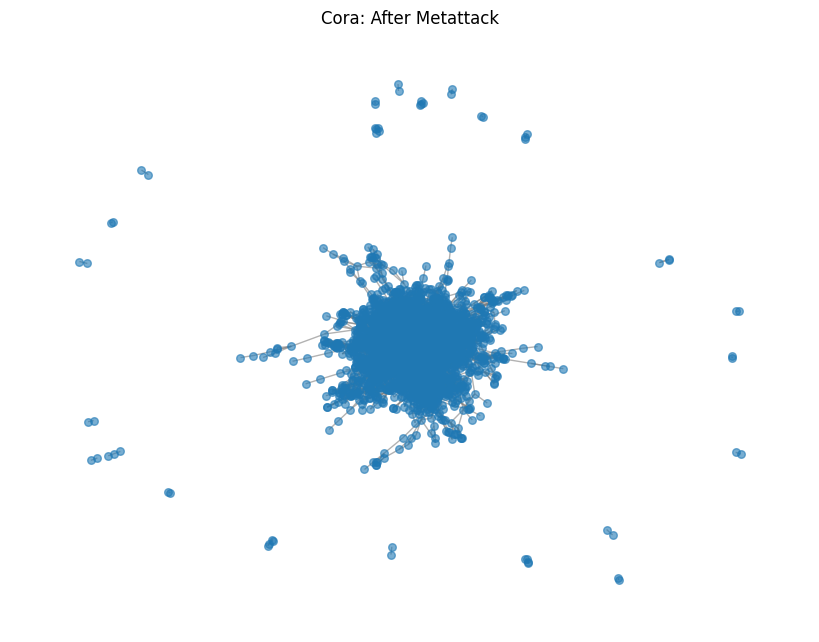

perturbed_adj type: <class 'torch.Tensor'>
Prediction shape: torch.Size([2708, 7])
test_mask shape: torch.Size([2708])
Ground truth labels shape: torch.Size([2708])
Accuracy after Metattack on Cora: 0.7910
Dataset: Citeseer

Number of nodes: 3327
Number of features: 3703
Number of classes: 6

Epoch 0, Loss: 1.7904
Epoch 10, Loss: 0.3497
Epoch 20, Loss: 0.1239
Epoch 30, Loss: 0.0561
Epoch 40, Loss: 0.0445
Epoch 50, Loss: 0.0400
Epoch 60, Loss: 0.0516
Epoch 70, Loss: 0.0427
Epoch 80, Loss: 0.0367
Epoch 90, Loss: 0.0410
----------------------------------------------------------------------------------------------------
Original Graph


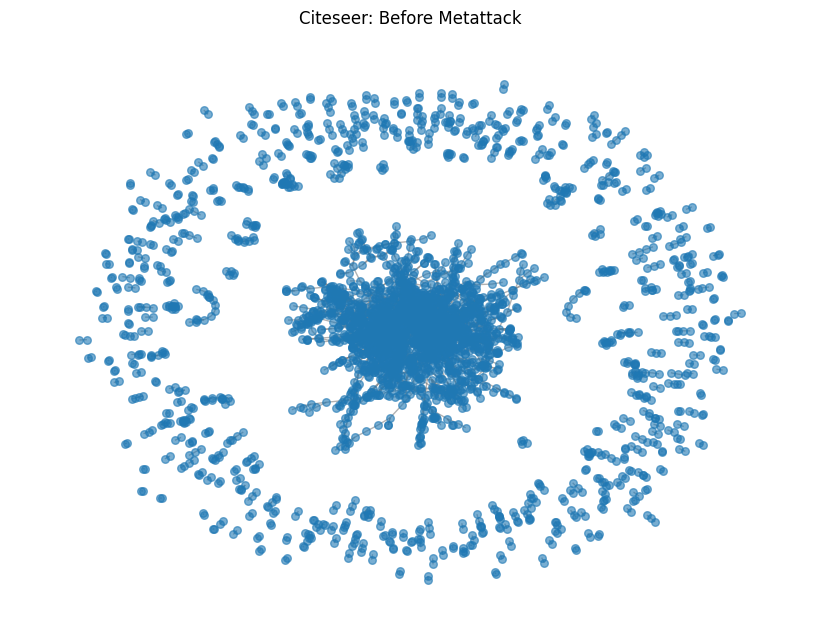

Running on 455 perturbations


Perturbing graph:   0%|          | 0/455 [00:00<?, ?it/s]

GCN loss on unlabled data: 1.2697275876998901
GCN acc on unlabled data: 0.6280012472715933
attack loss: 0.5285372734069824


Perturbing graph:   0%|          | 1/455 [00:44<5:35:31, 44.34s/it]

GCN loss on unlabled data: 1.2694034576416016
GCN acc on unlabled data: 0.6407857811038353
attack loss: 0.5125963091850281


Perturbing graph:   0%|          | 2/455 [01:16<4:40:25, 37.14s/it]

GCN loss on unlabled data: 1.3160042762756348
GCN acc on unlabled data: 0.6333021515434986
attack loss: 0.5398144125938416


Perturbing graph:   1%|          | 3/455 [02:00<5:03:18, 40.26s/it]

GCN loss on unlabled data: 1.2343376874923706
GCN acc on unlabled data: 0.634549423136888
attack loss: 0.5167507529258728


Perturbing graph:   1%|          | 4/455 [02:34<4:44:44, 37.88s/it]

GCN loss on unlabled data: 1.3180288076400757
GCN acc on unlabled data: 0.6267539756782039
attack loss: 0.5557802319526672


Perturbing graph:   1%|          | 5/455 [03:20<5:04:45, 40.63s/it]

GCN loss on unlabled data: 1.305490493774414
GCN acc on unlabled data: 0.6379794200187091
attack loss: 0.5397552847862244


Perturbing graph:   1%|▏         | 6/455 [04:05<5:14:55, 42.08s/it]

GCN loss on unlabled data: 1.2417752742767334
GCN acc on unlabled data: 0.64733395696913
attack loss: 0.5215638875961304


Perturbing graph:   2%|▏         | 7/455 [04:36<4:48:19, 38.62s/it]

GCN loss on unlabled data: 1.3320344686508179
GCN acc on unlabled data: 0.620829435609604
attack loss: 0.5758468508720398


Perturbing graph:   2%|▏         | 8/455 [05:21<5:02:57, 40.67s/it]

GCN loss on unlabled data: 1.3327723741531372
GCN acc on unlabled data: 0.633613969441846
attack loss: 0.5428852438926697


Perturbing graph:   2%|▏         | 9/455 [06:05<5:09:07, 41.59s/it]

GCN loss on unlabled data: 1.302259922027588
GCN acc on unlabled data: 0.6267539756782039
attack loss: 0.6002022624015808


Perturbing graph:   2%|▏         | 10/455 [06:50<5:16:57, 42.74s/it]

GCN loss on unlabled data: 1.2998197078704834
GCN acc on unlabled data: 0.6211412535079514
attack loss: 0.5485796928405762


Perturbing graph:   2%|▏         | 11/455 [07:21<4:48:38, 39.00s/it]

GCN loss on unlabled data: 1.2695703506469727
GCN acc on unlabled data: 0.6420330526972248
attack loss: 0.5598864555358887


Perturbing graph:   3%|▎         | 12/455 [08:07<5:03:34, 41.12s/it]

GCN loss on unlabled data: 1.3638935089111328
GCN acc on unlabled data: 0.6230121608980356
attack loss: 0.532360851764679


Perturbing graph:   3%|▎         | 13/455 [08:37<4:39:43, 37.97s/it]

GCN loss on unlabled data: 1.396507978439331
GCN acc on unlabled data: 0.6142812597443094
attack loss: 0.5271909832954407


Perturbing graph:   3%|▎         | 14/455 [09:22<4:54:17, 40.04s/it]

GCN loss on unlabled data: 1.2752254009246826
GCN acc on unlabled data: 0.6292485188649829
attack loss: 0.5745933651924133


Perturbing graph:   3%|▎         | 15/455 [09:52<4:32:15, 37.13s/it]

GCN loss on unlabled data: 1.28165602684021
GCN acc on unlabled data: 0.6289367009666355
attack loss: 0.5698978900909424


Perturbing graph:   4%|▎         | 16/455 [10:37<4:48:51, 39.48s/it]

GCN loss on unlabled data: 1.2872005701065063
GCN acc on unlabled data: 0.6239476145930777
attack loss: 0.5629958510398865


Perturbing graph:   4%|▎         | 17/455 [11:10<4:32:39, 37.35s/it]

GCN loss on unlabled data: 1.2906365394592285
GCN acc on unlabled data: 0.6308076083567197
attack loss: 0.5652928352355957


Perturbing graph:   4%|▍         | 18/455 [11:54<4:46:00, 39.27s/it]

GCN loss on unlabled data: 1.3455729484558105
GCN acc on unlabled data: 0.6139694418459619
attack loss: 0.5503012537956238


Perturbing graph:   4%|▍         | 19/455 [12:25<4:28:59, 37.02s/it]

GCN loss on unlabled data: 1.372272253036499
GCN acc on unlabled data: 0.6267539756782039
attack loss: 0.5855440497398376


Perturbing graph:   4%|▍         | 20/455 [13:10<4:45:31, 39.38s/it]

GCN loss on unlabled data: 1.307092308998108
GCN acc on unlabled data: 0.6389148737137512
attack loss: 0.5897785425186157


Perturbing graph:   5%|▍         | 21/455 [13:43<4:30:02, 37.33s/it]

GCN loss on unlabled data: 1.3877636194229126
GCN acc on unlabled data: 0.6251948861864671
attack loss: 0.559956431388855


Perturbing graph:   5%|▍         | 22/455 [14:30<4:50:25, 40.24s/it]

GCN loss on unlabled data: 1.3291985988616943
GCN acc on unlabled data: 0.6236357966947302
attack loss: 0.5849173665046692


Perturbing graph:   5%|▌         | 23/455 [15:17<5:04:01, 42.23s/it]

GCN loss on unlabled data: 1.3568751811981201
GCN acc on unlabled data: 0.6111630807608357
attack loss: 0.580479085445404


Perturbing graph:   5%|▌         | 24/455 [16:00<5:05:41, 42.56s/it]

GCN loss on unlabled data: 1.3858684301376343
GCN acc on unlabled data: 0.6195821640162146
attack loss: 0.591641366481781


Perturbing graph:   5%|▌         | 25/455 [16:47<5:14:21, 43.86s/it]

GCN loss on unlabled data: 1.3759105205535889
GCN acc on unlabled data: 0.6314312441534145
attack loss: 0.6334415674209595


Perturbing graph:   6%|▌         | 26/455 [17:32<5:17:10, 44.36s/it]

GCN loss on unlabled data: 1.3610830307006836
GCN acc on unlabled data: 0.6289367009666355
attack loss: 0.5973727107048035


Perturbing graph:   6%|▌         | 27/455 [18:04<4:49:22, 40.57s/it]

GCN loss on unlabled data: 1.3691891431808472
GCN acc on unlabled data: 0.618334892422825
attack loss: 0.6132069230079651


Perturbing graph:   6%|▌         | 28/455 [18:48<4:56:30, 41.66s/it]

GCN loss on unlabled data: 1.391036033630371
GCN acc on unlabled data: 0.6186467103211725
attack loss: 0.5891793370246887


Perturbing graph:   6%|▋         | 29/455 [19:33<5:02:18, 42.58s/it]

GCN loss on unlabled data: 1.3605470657348633
GCN acc on unlabled data: 0.6323666978484564
attack loss: 0.5857601165771484


Perturbing graph:   7%|▋         | 30/455 [20:17<5:05:25, 43.12s/it]

GCN loss on unlabled data: 1.4580106735229492
GCN acc on unlabled data: 0.6092921733707515
attack loss: 0.6057454347610474


Perturbing graph:   7%|▋         | 31/455 [21:00<5:03:18, 42.92s/it]

GCN loss on unlabled data: 1.3931487798690796
GCN acc on unlabled data: 0.6267539756782039
attack loss: 0.5952078700065613


Perturbing graph:   7%|▋         | 32/455 [21:46<5:08:34, 43.77s/it]

GCN loss on unlabled data: 1.4246591329574585
GCN acc on unlabled data: 0.6167758029310882
attack loss: 0.6232656836509705


Perturbing graph:   7%|▋         | 33/455 [22:30<5:09:59, 44.07s/it]

GCN loss on unlabled data: 1.4423394203186035
GCN acc on unlabled data: 0.608044901777362
attack loss: 0.6409811973571777


Perturbing graph:   7%|▋         | 34/455 [23:15<5:10:28, 44.25s/it]

GCN loss on unlabled data: 1.3525111675262451
GCN acc on unlabled data: 0.618334892422825
attack loss: 0.6492059826850891


Perturbing graph:   8%|▊         | 35/455 [23:58<5:06:15, 43.75s/it]

GCN loss on unlabled data: 1.4681178331375122
GCN acc on unlabled data: 0.6089803554724041
attack loss: 0.6640824675559998


Perturbing graph:   8%|▊         | 36/455 [24:42<5:06:41, 43.92s/it]

GCN loss on unlabled data: 1.464650273323059
GCN acc on unlabled data: 0.6024321796071095
attack loss: 0.6452006697654724


Perturbing graph:   8%|▊         | 37/455 [25:26<5:06:28, 43.99s/it]

GCN loss on unlabled data: 1.307849645614624
GCN acc on unlabled data: 0.6342376052385407
attack loss: 0.6038619875907898


Perturbing graph:   8%|▊         | 38/455 [26:09<5:03:40, 43.70s/it]

GCN loss on unlabled data: 1.3272093534469604
GCN acc on unlabled data: 0.6298721546616776
attack loss: 0.6159324645996094


Perturbing graph:   9%|▊         | 39/455 [26:54<5:04:51, 43.97s/it]

GCN loss on unlabled data: 1.4002517461776733
GCN acc on unlabled data: 0.6083567196757094
attack loss: 0.6489120125770569


Perturbing graph:   9%|▉         | 40/455 [27:37<5:03:21, 43.86s/it]

GCN loss on unlabled data: 1.4290053844451904
GCN acc on unlabled data: 0.5902712815715622
attack loss: 0.6330037713050842


Perturbing graph:   9%|▉         | 41/455 [28:24<5:08:29, 44.71s/it]

GCN loss on unlabled data: 1.3578120470046997
GCN acc on unlabled data: 0.6220767072029935
attack loss: 0.6772120594978333


Perturbing graph:   9%|▉         | 42/455 [28:54<4:37:11, 40.27s/it]

GCN loss on unlabled data: 1.396787166595459
GCN acc on unlabled data: 0.618334892422825
attack loss: 0.6477062106132507


Perturbing graph:   9%|▉         | 43/455 [29:40<4:48:00, 41.94s/it]

GCN loss on unlabled data: 1.38802170753479
GCN acc on unlabled data: 0.627689429373246
attack loss: 0.621975839138031


Perturbing graph:  10%|▉         | 44/455 [30:09<4:21:57, 38.24s/it]

GCN loss on unlabled data: 1.408035397529602
GCN acc on unlabled data: 0.5980667290302464
attack loss: 0.6487615704536438


Perturbing graph:  10%|▉         | 45/455 [30:54<4:33:26, 40.02s/it]

GCN loss on unlabled data: 1.341109275817871
GCN acc on unlabled data: 0.6245712503897723
attack loss: 0.628496527671814


Perturbing graph:  10%|█         | 46/455 [31:24<4:12:51, 37.09s/it]

GCN loss on unlabled data: 1.3299025297164917
GCN acc on unlabled data: 0.6102276270657936
attack loss: 0.638967752456665


Perturbing graph:  10%|█         | 47/455 [32:08<4:26:13, 39.15s/it]

GCN loss on unlabled data: 1.3687219619750977
GCN acc on unlabled data: 0.6096039912690988
attack loss: 0.6636638641357422


Perturbing graph:  11%|█         | 48/455 [32:51<4:34:30, 40.47s/it]

GCN loss on unlabled data: 1.3805675506591797
GCN acc on unlabled data: 0.6195821640162146
attack loss: 0.6036263704299927


Perturbing graph:  11%|█         | 49/455 [33:23<4:15:47, 37.80s/it]

GCN loss on unlabled data: 1.3577666282653809
GCN acc on unlabled data: 0.6326785157468039
attack loss: 0.6626432538032532


Perturbing graph:  11%|█         | 50/455 [34:05<4:24:20, 39.16s/it]

GCN loss on unlabled data: 1.3738702535629272
GCN acc on unlabled data: 0.617399438727783
attack loss: 0.6448059678077698


Perturbing graph:  11%|█         | 51/455 [34:49<4:33:53, 40.68s/it]

GCN loss on unlabled data: 1.3747891187667847
GCN acc on unlabled data: 0.6298721546616776
attack loss: 0.6400285959243774


Perturbing graph:  11%|█▏        | 52/455 [35:35<4:42:48, 42.11s/it]

GCN loss on unlabled data: 1.384265422821045
GCN acc on unlabled data: 0.6239476145930777
attack loss: 0.6414161920547485


Perturbing graph:  12%|█▏        | 53/455 [36:19<4:46:14, 42.72s/it]

GCN loss on unlabled data: 1.3792955875396729
GCN acc on unlabled data: 0.598690364826941
attack loss: 0.6350141763687134


Perturbing graph:  12%|█▏        | 54/455 [37:04<4:49:02, 43.25s/it]

GCN loss on unlabled data: 1.445525050163269
GCN acc on unlabled data: 0.6136576239476146
attack loss: 0.664444625377655


Perturbing graph:  12%|█▏        | 55/455 [37:36<4:26:12, 39.93s/it]

GCN loss on unlabled data: 1.4926531314849854
GCN acc on unlabled data: 0.587464920486436
attack loss: 0.6772475838661194


Perturbing graph:  12%|█▏        | 56/455 [38:07<4:07:49, 37.27s/it]

GCN loss on unlabled data: 1.4353152513504028
GCN acc on unlabled data: 0.6139694418459619
attack loss: 0.6855651140213013


Perturbing graph:  13%|█▎        | 57/455 [38:36<3:51:35, 34.91s/it]

GCN loss on unlabled data: 1.3896243572235107
GCN acc on unlabled data: 0.6301839725600249
attack loss: 0.6760040521621704


Perturbing graph:  13%|█▎        | 58/455 [39:24<4:15:53, 38.67s/it]

GCN loss on unlabled data: 1.4503141641616821
GCN acc on unlabled data: 0.6055503585905831
attack loss: 0.6636955142021179


Perturbing graph:  13%|█▎        | 59/455 [40:07<4:24:51, 40.13s/it]

GCN loss on unlabled data: 1.411760687828064
GCN acc on unlabled data: 0.6145930776426567
attack loss: 0.6650104522705078


Perturbing graph:  13%|█▎        | 60/455 [40:40<4:10:27, 38.04s/it]

GCN loss on unlabled data: 1.5116660594940186
GCN acc on unlabled data: 0.5930776426566885
attack loss: 0.7005186676979065


Perturbing graph:  13%|█▎        | 61/455 [41:12<3:57:12, 36.12s/it]

GCN loss on unlabled data: 1.4464633464813232
GCN acc on unlabled data: 0.6142812597443094
attack loss: 0.6921321153640747


Perturbing graph:  14%|█▎        | 62/455 [41:44<3:48:05, 34.82s/it]

GCN loss on unlabled data: 1.4207217693328857
GCN acc on unlabled data: 0.6264421577798566
attack loss: 0.648931086063385


Perturbing graph:  14%|█▍        | 63/455 [42:28<4:05:07, 37.52s/it]

GCN loss on unlabled data: 1.3826121091842651
GCN acc on unlabled data: 0.6261303398815092
attack loss: 0.6703891754150391


Perturbing graph:  14%|█▍        | 64/455 [43:11<4:16:10, 39.31s/it]

GCN loss on unlabled data: 1.4645541906356812
GCN acc on unlabled data: 0.6039912690988463
attack loss: 0.6825718879699707


Perturbing graph:  14%|█▍        | 65/455 [43:56<4:26:34, 41.01s/it]

GCN loss on unlabled data: 1.422587275505066
GCN acc on unlabled data: 0.6161521671343935
attack loss: 0.6596091985702515


Perturbing graph:  15%|█▍        | 66/455 [44:39<4:30:26, 41.71s/it]

GCN loss on unlabled data: 1.4168434143066406
GCN acc on unlabled data: 0.6018085438104147
attack loss: 0.6584986448287964


Perturbing graph:  15%|█▍        | 67/455 [45:11<4:10:45, 38.78s/it]

GCN loss on unlabled data: 1.4422687292099
GCN acc on unlabled data: 0.6018085438104147
attack loss: 0.728488564491272


Perturbing graph:  15%|█▍        | 68/455 [45:55<4:19:49, 40.28s/it]

GCN loss on unlabled data: 1.3849157094955444
GCN acc on unlabled data: 0.6145930776426567
attack loss: 0.6982720494270325


Perturbing graph:  15%|█▌        | 69/455 [46:26<4:00:18, 37.35s/it]

GCN loss on unlabled data: 1.4180958271026611
GCN acc on unlabled data: 0.6205176177112566
attack loss: 0.6838613152503967


Perturbing graph:  15%|█▌        | 70/455 [47:10<4:13:30, 39.51s/it]

GCN loss on unlabled data: 1.4111016988754272
GCN acc on unlabled data: 0.6124103523542251
attack loss: 0.6598472595214844


Perturbing graph:  16%|█▌        | 71/455 [47:40<3:54:42, 36.67s/it]

GCN loss on unlabled data: 1.5230233669281006
GCN acc on unlabled data: 0.6142812597443094
attack loss: 0.7293346524238586


Perturbing graph:  16%|█▌        | 72/455 [48:26<4:12:09, 39.50s/it]

GCN loss on unlabled data: 1.4129832983016968
GCN acc on unlabled data: 0.6161521671343935
attack loss: 0.7063457369804382


Perturbing graph:  16%|█▌        | 73/455 [49:10<4:19:21, 40.74s/it]

GCN loss on unlabled data: 1.4606643915176392
GCN acc on unlabled data: 0.6002494543186779
attack loss: 0.6802512407302856


Perturbing graph:  16%|█▋        | 74/455 [49:54<4:24:28, 41.65s/it]

GCN loss on unlabled data: 1.473738670349121
GCN acc on unlabled data: 0.5943249142500779
attack loss: 0.7156351208686829


Perturbing graph:  16%|█▋        | 75/455 [50:24<4:02:35, 38.30s/it]

GCN loss on unlabled data: 1.478601098060608
GCN acc on unlabled data: 0.5955721858434674
attack loss: 0.74078369140625


Perturbing graph:  17%|█▋        | 76/455 [51:08<4:12:13, 39.93s/it]

GCN loss on unlabled data: 1.4411944150924683
GCN acc on unlabled data: 0.6074212659806673
attack loss: 0.7267943024635315


Perturbing graph:  17%|█▋        | 77/455 [51:53<4:20:16, 41.31s/it]

GCN loss on unlabled data: 1.5200436115264893
GCN acc on unlabled data: 0.5912067352666043
attack loss: 0.6943474411964417


Perturbing graph:  17%|█▋        | 78/455 [52:36<4:23:55, 42.00s/it]

GCN loss on unlabled data: 1.4395805597305298
GCN acc on unlabled data: 0.6030558154038042
attack loss: 0.7291837334632874


Perturbing graph:  17%|█▋        | 79/455 [53:21<4:27:42, 42.72s/it]

GCN loss on unlabled data: 1.5114825963974
GCN acc on unlabled data: 0.584970377299657
attack loss: 0.768466591835022


Perturbing graph:  18%|█▊        | 80/455 [53:51<4:03:35, 38.97s/it]

GCN loss on unlabled data: 1.5752276182174683
GCN acc on unlabled data: 0.5921421889616464
attack loss: 0.7068344950675964


Perturbing graph:  18%|█▊        | 81/455 [54:34<4:11:12, 40.30s/it]

GCN loss on unlabled data: 1.5325363874435425
GCN acc on unlabled data: 0.5830994699095728
attack loss: 0.6946650743484497


Perturbing graph:  18%|█▊        | 82/455 [55:20<4:20:44, 41.94s/it]

GCN loss on unlabled data: 1.503178596496582
GCN acc on unlabled data: 0.6027439975054568
attack loss: 0.7285471558570862


Perturbing graph:  18%|█▊        | 83/455 [55:48<3:54:56, 37.89s/it]

GCN loss on unlabled data: 1.4523879289627075
GCN acc on unlabled data: 0.6117867165575304
attack loss: 0.702457070350647


Perturbing graph:  18%|█▊        | 84/455 [56:32<4:04:47, 39.59s/it]

GCN loss on unlabled data: 1.4724706411361694
GCN acc on unlabled data: 0.5834112878079202
attack loss: 0.771216869354248


Perturbing graph:  19%|█▊        | 85/455 [57:17<4:14:34, 41.28s/it]

GCN loss on unlabled data: 1.564109206199646
GCN acc on unlabled data: 0.5787340193327097
attack loss: 0.7750218510627747


Perturbing graph:  19%|█▉        | 86/455 [58:03<4:22:45, 42.72s/it]

GCN loss on unlabled data: 1.5170577764511108
GCN acc on unlabled data: 0.5930776426566885
attack loss: 0.7723365426063538


Perturbing graph:  19%|█▉        | 87/455 [58:34<4:00:17, 39.18s/it]

GCN loss on unlabled data: 1.4155524969100952
GCN acc on unlabled data: 0.6024321796071095
attack loss: 0.6912356019020081


Perturbing graph:  19%|█▉        | 88/455 [59:17<4:06:39, 40.33s/it]

GCN loss on unlabled data: 1.5317003726959229
GCN acc on unlabled data: 0.5868412846897412
attack loss: 0.7718032598495483


Perturbing graph:  20%|█▉        | 89/455 [1:00:03<4:17:01, 42.14s/it]

GCN loss on unlabled data: 1.5600597858428955
GCN acc on unlabled data: 0.5927658247583412
attack loss: 0.7481274604797363


Perturbing graph:  20%|█▉        | 90/455 [1:00:48<4:20:07, 42.76s/it]

GCN loss on unlabled data: 1.589892029762268
GCN acc on unlabled data: 0.578110383536015
attack loss: 0.8007749915122986


Perturbing graph:  20%|██        | 91/455 [1:01:31<4:20:03, 42.87s/it]

GCN loss on unlabled data: 1.4309132099151611
GCN acc on unlabled data: 0.6039912690988463
attack loss: 0.7451603412628174


Perturbing graph:  20%|██        | 92/455 [1:02:16<4:22:59, 43.47s/it]

GCN loss on unlabled data: 1.4121623039245605
GCN acc on unlabled data: 0.5980667290302464
attack loss: 0.7259672284126282


Perturbing graph:  20%|██        | 93/455 [1:02:47<4:00:36, 39.88s/it]

GCN loss on unlabled data: 1.5820730924606323
GCN acc on unlabled data: 0.5958840037418148
attack loss: 0.7711595296859741


Perturbing graph:  21%|██        | 94/455 [1:03:31<4:06:59, 41.05s/it]

GCN loss on unlabled data: 1.5028170347213745
GCN acc on unlabled data: 0.5812285625194886
attack loss: 0.7746086716651917


Perturbing graph:  21%|██        | 95/455 [1:04:01<3:46:51, 37.81s/it]

GCN loss on unlabled data: 1.4769097566604614
GCN acc on unlabled data: 0.5896476457748675
attack loss: 0.7590165734291077


Perturbing graph:  21%|██        | 96/455 [1:04:47<4:00:09, 40.14s/it]

GCN loss on unlabled data: 1.4581791162490845
GCN acc on unlabled data: 0.6092921733707515
attack loss: 0.7556389570236206


Perturbing graph:  21%|██▏       | 97/455 [1:05:17<3:42:19, 37.26s/it]

GCN loss on unlabled data: 1.5705642700195312
GCN acc on unlabled data: 0.578110383536015
attack loss: 0.7702049016952515


Perturbing graph:  22%|██▏       | 98/455 [1:06:02<3:54:01, 39.33s/it]

GCN loss on unlabled data: 1.4800469875335693
GCN acc on unlabled data: 0.5902712815715622
attack loss: 0.7506822943687439


Perturbing graph:  22%|██▏       | 99/455 [1:06:46<4:02:45, 40.91s/it]

GCN loss on unlabled data: 1.5124584436416626
GCN acc on unlabled data: 0.5905830994699096
attack loss: 0.7257900238037109


Perturbing graph:  22%|██▏       | 100/455 [1:07:16<3:42:55, 37.68s/it]

GCN loss on unlabled data: 1.5223438739776611
GCN acc on unlabled data: 0.5983785469285937
attack loss: 0.782184898853302


Perturbing graph:  22%|██▏       | 101/455 [1:08:02<3:57:22, 40.23s/it]

GCN loss on unlabled data: 1.5742051601409912
GCN acc on unlabled data: 0.578110383536015
attack loss: 0.7692121863365173


Perturbing graph:  22%|██▏       | 102/455 [1:08:33<3:39:15, 37.27s/it]

GCN loss on unlabled data: 1.5241857767105103
GCN acc on unlabled data: 0.5865294667913938
attack loss: 0.7529033422470093


Perturbing graph:  23%|██▎       | 103/455 [1:09:05<3:28:54, 35.61s/it]

GCN loss on unlabled data: 1.6555289030075073
GCN acc on unlabled data: 0.5703149360773309
attack loss: 0.7748818397521973


Perturbing graph:  23%|██▎       | 104/455 [1:09:47<3:40:05, 37.62s/it]

GCN loss on unlabled data: 1.5825825929641724
GCN acc on unlabled data: 0.5834112878079202
attack loss: 0.7757759690284729


Perturbing graph:  23%|██▎       | 105/455 [1:10:17<3:27:06, 35.50s/it]

GCN loss on unlabled data: 1.5073411464691162
GCN acc on unlabled data: 0.598690364826941
attack loss: 0.7871715426445007


Perturbing graph:  23%|██▎       | 106/455 [1:11:01<3:41:21, 38.06s/it]

GCN loss on unlabled data: 1.5780513286590576
GCN acc on unlabled data: 0.581540380417836
attack loss: 0.78188556432724


Perturbing graph:  24%|██▎       | 107/455 [1:11:30<3:24:57, 35.34s/it]

GCN loss on unlabled data: 1.6579515933990479
GCN acc on unlabled data: 0.5703149360773309
attack loss: 0.8098682165145874


Perturbing graph:  24%|██▎       | 108/455 [1:12:14<3:38:40, 37.81s/it]

GCN loss on unlabled data: 1.5526366233825684
GCN acc on unlabled data: 0.5834112878079202
attack loss: 0.7746448516845703


Perturbing graph:  24%|██▍       | 109/455 [1:12:47<3:28:54, 36.23s/it]

GCN loss on unlabled data: 1.7072950601577759
GCN acc on unlabled data: 0.5718740255690676
attack loss: 0.7792471051216125


Perturbing graph:  24%|██▍       | 110/455 [1:13:31<3:42:47, 38.74s/it]

GCN loss on unlabled data: 1.5481892824172974
GCN acc on unlabled data: 0.5884003741814781
attack loss: 0.7942597270011902


Perturbing graph:  24%|██▍       | 111/455 [1:14:22<4:03:05, 42.40s/it]

GCN loss on unlabled data: 1.6165034770965576
GCN acc on unlabled data: 0.5753040224508886
attack loss: 0.8044302463531494


Perturbing graph:  25%|██▍       | 112/455 [1:15:15<4:19:58, 45.48s/it]

GCN loss on unlabled data: 1.5948419570922852
GCN acc on unlabled data: 0.5703149360773309
attack loss: 0.8147560954093933


Perturbing graph:  25%|██▍       | 113/455 [1:16:06<4:28:23, 47.09s/it]

GCN loss on unlabled data: 1.4620919227600098
GCN acc on unlabled data: 0.5965076395385095
attack loss: 0.770571231842041


Perturbing graph:  25%|██▌       | 114/455 [1:16:56<4:33:49, 48.18s/it]

GCN loss on unlabled data: 1.531126618385315
GCN acc on unlabled data: 0.5709385718740255
attack loss: 0.7935383915901184


Perturbing graph:  25%|██▌       | 115/455 [1:17:27<4:03:54, 43.04s/it]

GCN loss on unlabled data: 1.678667426109314
GCN acc on unlabled data: 0.5640785781103835
attack loss: 0.8273884057998657


Perturbing graph:  25%|██▌       | 116/455 [1:18:13<4:08:21, 43.96s/it]

GCN loss on unlabled data: 1.6118745803833008
GCN acc on unlabled data: 0.5684440286872466
attack loss: 0.8303641676902771


Perturbing graph:  26%|██▌       | 117/455 [1:18:44<3:45:19, 40.00s/it]

GCN loss on unlabled data: 1.6481069326400757
GCN acc on unlabled data: 0.5643903960087309
attack loss: 0.8493689894676208


Perturbing graph:  26%|██▌       | 118/455 [1:19:30<3:54:13, 41.70s/it]

GCN loss on unlabled data: 1.6956452131271362
GCN acc on unlabled data: 0.5484876831930153
attack loss: 0.8801204562187195


Perturbing graph:  26%|██▌       | 119/455 [1:20:00<3:34:03, 38.22s/it]

GCN loss on unlabled data: 1.6102256774902344
GCN acc on unlabled data: 0.5556594948550047
attack loss: 0.8398293852806091


Perturbing graph:  26%|██▋       | 120/455 [1:20:32<3:22:56, 36.35s/it]

GCN loss on unlabled data: 1.5888891220092773
GCN acc on unlabled data: 0.5700031181789835
attack loss: 0.8453186750411987


Perturbing graph:  27%|██▋       | 121/455 [1:21:02<3:12:27, 34.57s/it]

GCN loss on unlabled data: 1.5438112020492554
GCN acc on unlabled data: 0.5743685687558466
attack loss: 0.7993255257606506


Perturbing graph:  27%|██▋       | 122/455 [1:21:45<3:25:09, 36.97s/it]

GCN loss on unlabled data: 1.6520905494689941
GCN acc on unlabled data: 0.5512940442781415
attack loss: 0.8441028594970703


Perturbing graph:  27%|██▋       | 123/455 [1:22:28<3:34:42, 38.80s/it]

GCN loss on unlabled data: 1.5136533975601196
GCN acc on unlabled data: 0.584034923604615
attack loss: 0.8095263242721558


Perturbing graph:  27%|██▋       | 124/455 [1:22:58<3:20:07, 36.28s/it]

GCN loss on unlabled data: 1.63889741897583
GCN acc on unlabled data: 0.567820392890552
attack loss: 0.8528594374656677


Perturbing graph:  27%|██▋       | 125/455 [1:23:44<3:34:02, 38.92s/it]

GCN loss on unlabled data: 1.6665737628936768
GCN acc on unlabled data: 0.5494231368880573
attack loss: 0.8347808122634888


Perturbing graph:  28%|██▊       | 126/455 [1:24:16<3:22:30, 36.93s/it]

GCN loss on unlabled data: 1.6162207126617432
GCN acc on unlabled data: 0.5728094792641097
attack loss: 0.8248947262763977


Perturbing graph:  28%|██▊       | 127/455 [1:25:01<3:34:44, 39.28s/it]

GCN loss on unlabled data: 1.7583948373794556
GCN acc on unlabled data: 0.536326785157468
attack loss: 0.8666723370552063


Perturbing graph:  28%|██▊       | 128/455 [1:25:34<3:24:06, 37.45s/it]

GCN loss on unlabled data: 1.7338497638702393
GCN acc on unlabled data: 0.5450576863111942
attack loss: 0.8690297603607178


Perturbing graph:  28%|██▊       | 129/455 [1:26:19<3:35:46, 39.71s/it]

GCN loss on unlabled data: 1.729893684387207
GCN acc on unlabled data: 0.5643903960087309
attack loss: 0.8904121518135071


Perturbing graph:  29%|██▊       | 130/455 [1:27:05<3:45:22, 41.61s/it]

GCN loss on unlabled data: 1.5873457193374634
GCN acc on unlabled data: 0.5634549423136888
attack loss: 0.8441736102104187


Perturbing graph:  29%|██▉       | 131/455 [1:27:36<3:27:31, 38.43s/it]

GCN loss on unlabled data: 1.642960786819458
GCN acc on unlabled data: 0.5597131275335204
attack loss: 0.89290452003479


Perturbing graph:  29%|██▉       | 132/455 [1:28:10<3:19:49, 37.12s/it]

GCN loss on unlabled data: 1.7721134424209595
GCN acc on unlabled data: 0.536326785157468
attack loss: 0.9094521403312683


Perturbing graph:  29%|██▉       | 133/455 [1:28:42<3:11:02, 35.60s/it]

GCN loss on unlabled data: 1.7474936246871948
GCN acc on unlabled data: 0.5372622388525101
attack loss: 0.8537907004356384


Perturbing graph:  29%|██▉       | 134/455 [1:29:28<3:26:38, 38.63s/it]

GCN loss on unlabled data: 1.7200335264205933
GCN acc on unlabled data: 0.5353913314624259
attack loss: 0.8601590394973755


Perturbing graph:  30%|██▉       | 135/455 [1:29:58<3:12:47, 36.15s/it]

GCN loss on unlabled data: 1.7007213830947876
GCN acc on unlabled data: 0.5534767695665731
attack loss: 0.8724057674407959


Perturbing graph:  30%|██▉       | 136/455 [1:30:44<3:27:18, 38.99s/it]

GCN loss on unlabled data: 1.8433176279067993
GCN acc on unlabled data: 0.5266604303086997
attack loss: 0.9609674215316772


Perturbing graph:  30%|███       | 137/455 [1:31:15<3:14:10, 36.64s/it]

GCN loss on unlabled data: 1.8262475728988647
GCN acc on unlabled data: 0.5229186155285314
attack loss: 0.849928617477417


Perturbing graph:  30%|███       | 138/455 [1:31:46<3:05:22, 35.09s/it]

GCN loss on unlabled data: 1.8371529579162598
GCN acc on unlabled data: 0.5307140629872155
attack loss: 0.9466440677642822


Perturbing graph:  31%|███       | 139/455 [1:32:18<2:59:10, 34.02s/it]

GCN loss on unlabled data: 1.8619993925094604
GCN acc on unlabled data: 0.5247895229186156
attack loss: 0.9340258836746216


Perturbing graph:  31%|███       | 140/455 [1:33:04<3:17:41, 37.66s/it]

GCN loss on unlabled data: 1.8920952081680298
GCN acc on unlabled data: 0.5157468038665419
attack loss: 0.9314619898796082


Perturbing graph:  31%|███       | 141/455 [1:33:49<3:29:19, 40.00s/it]

GCN loss on unlabled data: 1.7341023683547974
GCN acc on unlabled data: 0.5282195198004366
attack loss: 0.9018779397010803


Perturbing graph:  31%|███       | 142/455 [1:34:34<3:36:09, 41.44s/it]

GCN loss on unlabled data: 1.7223790884017944
GCN acc on unlabled data: 0.536326785157468
attack loss: 0.9165164232254028


Perturbing graph:  31%|███▏      | 143/455 [1:35:19<3:40:37, 42.43s/it]

GCN loss on unlabled data: 1.7958348989486694
GCN acc on unlabled data: 0.5185531649516683
attack loss: 0.9277529716491699


Perturbing graph:  32%|███▏      | 144/455 [1:36:05<3:46:15, 43.65s/it]

GCN loss on unlabled data: 1.7473695278167725
GCN acc on unlabled data: 0.5484876831930153
attack loss: 0.8831771612167358


Perturbing graph:  32%|███▏      | 145/455 [1:36:37<3:26:35, 39.99s/it]

GCN loss on unlabled data: 1.742177963256836
GCN acc on unlabled data: 0.526036794512005
attack loss: 0.8913545608520508


Perturbing graph:  32%|███▏      | 146/455 [1:37:20<3:31:12, 41.01s/it]

GCN loss on unlabled data: 1.7382357120513916
GCN acc on unlabled data: 0.5244777050202681
attack loss: 0.8984432816505432


Perturbing graph:  32%|███▏      | 147/455 [1:38:06<3:38:26, 42.55s/it]

GCN loss on unlabled data: 1.8149183988571167
GCN acc on unlabled data: 0.5113813532896788
attack loss: 0.928548276424408


Perturbing graph:  33%|███▎      | 148/455 [1:38:38<3:20:30, 39.19s/it]

GCN loss on unlabled data: 1.75669527053833
GCN acc on unlabled data: 0.5272840661053945
attack loss: 0.8867161870002747


Perturbing graph:  33%|███▎      | 149/455 [1:39:24<3:31:17, 41.43s/it]

GCN loss on unlabled data: 1.9036694765090942
GCN acc on unlabled data: 0.5157468038665419
attack loss: 1.007660150527954


Perturbing graph:  33%|███▎      | 150/455 [1:40:08<3:34:15, 42.15s/it]

GCN loss on unlabled data: 1.6985270977020264
GCN acc on unlabled data: 0.5375740567508575
attack loss: 0.9156844019889832


Perturbing graph:  33%|███▎      | 151/455 [1:40:53<3:37:29, 42.93s/it]

GCN loss on unlabled data: 1.7136648893356323
GCN acc on unlabled data: 0.5338322419706891
attack loss: 0.8819724917411804


Perturbing graph:  33%|███▎      | 152/455 [1:41:23<3:17:18, 39.07s/it]

GCN loss on unlabled data: 1.7938518524169922
GCN acc on unlabled data: 0.5144995322731525
attack loss: 0.9041876792907715


Perturbing graph:  34%|███▎      | 153/455 [1:42:06<3:22:58, 40.33s/it]

GCN loss on unlabled data: 1.8986221551895142
GCN acc on unlabled data: 0.5129404427814157
attack loss: 0.9472155570983887


Perturbing graph:  34%|███▍      | 154/455 [1:42:39<3:11:27, 38.16s/it]

GCN loss on unlabled data: 1.9252735376358032
GCN acc on unlabled data: 0.5023386342376053
attack loss: 0.9898340106010437


Perturbing graph:  34%|███▍      | 155/455 [1:43:24<3:20:23, 40.08s/it]

GCN loss on unlabled data: 1.7151402235031128
GCN acc on unlabled data: 0.5173058933582788
attack loss: 0.9028534293174744


Perturbing graph:  34%|███▍      | 156/455 [1:43:57<3:09:36, 38.05s/it]

GCN loss on unlabled data: 1.9525305032730103
GCN acc on unlabled data: 0.5085749922045525
attack loss: 0.9515017867088318


Perturbing graph:  35%|███▍      | 157/455 [1:44:41<3:17:15, 39.72s/it]

GCN loss on unlabled data: 1.7000608444213867
GCN acc on unlabled data: 0.5425631431244153
attack loss: 0.8635380268096924


Perturbing graph:  35%|███▍      | 158/455 [1:45:14<3:06:20, 37.64s/it]

GCN loss on unlabled data: 1.7749654054641724
GCN acc on unlabled data: 0.5385095104458996
attack loss: 0.9281718134880066


Perturbing graph:  35%|███▍      | 159/455 [1:45:59<3:17:17, 39.99s/it]

GCN loss on unlabled data: 1.9687163829803467
GCN acc on unlabled data: 0.5104458995946367
attack loss: 0.988270103931427


Perturbing graph:  35%|███▌      | 160/455 [1:46:32<3:05:56, 37.82s/it]

GCN loss on unlabled data: 1.946290135383606
GCN acc on unlabled data: 0.5144995322731525
attack loss: 1.0127705335617065


Perturbing graph:  35%|███▌      | 161/455 [1:47:17<3:15:40, 39.93s/it]

GCN loss on unlabled data: 1.8488348722457886
GCN acc on unlabled data: 0.5185531649516683
attack loss: 0.9503480195999146


Perturbing graph:  36%|███▌      | 162/455 [1:47:50<3:05:25, 37.97s/it]

GCN loss on unlabled data: 1.8203282356262207
GCN acc on unlabled data: 0.5091986280012473
attack loss: 0.9581775069236755


Perturbing graph:  36%|███▌      | 163/455 [1:48:34<3:13:14, 39.71s/it]

GCN loss on unlabled data: 1.9969301223754883
GCN acc on unlabled data: 0.5101340816962894
attack loss: 0.9910908937454224


Perturbing graph:  36%|███▌      | 164/455 [1:49:06<3:02:06, 37.55s/it]

GCN loss on unlabled data: 2.003406047821045
GCN acc on unlabled data: 0.5088868101028999
attack loss: 0.9928141832351685


Perturbing graph:  36%|███▋      | 165/455 [1:49:50<3:09:34, 39.22s/it]

GCN loss on unlabled data: 1.9631575345993042
GCN acc on unlabled data: 0.4898659183037106
attack loss: 1.028503179550171


Perturbing graph:  36%|███▋      | 166/455 [1:50:19<2:54:49, 36.30s/it]

GCN loss on unlabled data: 1.8606590032577515
GCN acc on unlabled data: 0.5198004365450577
attack loss: 0.991089403629303


Perturbing graph:  37%|███▋      | 167/455 [1:51:04<3:06:59, 38.96s/it]

GCN loss on unlabled data: 1.9362934827804565
GCN acc on unlabled data: 0.5048331774243842
attack loss: 0.9971091151237488


Perturbing graph:  37%|███▋      | 168/455 [1:51:34<2:52:51, 36.14s/it]

GCN loss on unlabled data: 1.9310545921325684
GCN acc on unlabled data: 0.4889304646086685
attack loss: 0.997725784778595


Perturbing graph:  37%|███▋      | 169/455 [1:52:19<3:05:57, 39.01s/it]

GCN loss on unlabled data: 1.933976411819458
GCN acc on unlabled data: 0.49859681945743684
attack loss: 1.0172356367111206


Perturbing graph:  37%|███▋      | 170/455 [1:53:03<3:12:09, 40.45s/it]

GCN loss on unlabled data: 1.9961295127868652
GCN acc on unlabled data: 0.49579045837231056
attack loss: 1.0561082363128662


Perturbing graph:  38%|███▊      | 171/455 [1:53:46<3:15:25, 41.29s/it]

GCN loss on unlabled data: 2.0132102966308594
GCN acc on unlabled data: 0.49672591206735267
attack loss: 1.0471497774124146


Perturbing graph:  38%|███▊      | 172/455 [1:54:18<3:01:03, 38.39s/it]

GCN loss on unlabled data: 2.0241870880126953
GCN acc on unlabled data: 0.4989086373557842
attack loss: 1.0608296394348145


Perturbing graph:  38%|███▊      | 173/455 [1:55:03<3:08:57, 40.20s/it]

GCN loss on unlabled data: 2.071913957595825
GCN acc on unlabled data: 0.47988774555659497
attack loss: 1.0818829536437988


Perturbing graph:  38%|███▊      | 174/455 [1:55:48<3:15:31, 41.75s/it]

GCN loss on unlabled data: 1.7738373279571533
GCN acc on unlabled data: 0.5238540692235735
attack loss: 0.9315625429153442


Perturbing graph:  38%|███▊      | 175/455 [1:56:32<3:18:14, 42.48s/it]

GCN loss on unlabled data: 1.972338080406189
GCN acc on unlabled data: 0.4970377299657
attack loss: 1.0449507236480713


Perturbing graph:  39%|███▊      | 176/455 [1:57:04<3:03:13, 39.40s/it]

GCN loss on unlabled data: 1.9005601406097412
GCN acc on unlabled data: 0.49610227627065795
attack loss: 0.9959874153137207


Perturbing graph:  39%|███▉      | 177/455 [1:57:48<3:08:52, 40.76s/it]

GCN loss on unlabled data: 1.8436553478240967
GCN acc on unlabled data: 0.5085749922045525
attack loss: 0.9914917349815369


Perturbing graph:  39%|███▉      | 178/455 [1:58:19<2:54:37, 37.83s/it]

GCN loss on unlabled data: 1.9213429689407349
GCN acc on unlabled data: 0.49423136888057373
attack loss: 1.008279800415039


Perturbing graph:  39%|███▉      | 179/455 [1:59:04<3:04:09, 40.03s/it]

GCN loss on unlabled data: 2.028731107711792
GCN acc on unlabled data: 0.5010913626442158
attack loss: 1.0256232023239136


Perturbing graph:  40%|███▉      | 180/455 [1:59:48<3:08:03, 41.03s/it]

GCN loss on unlabled data: 1.764535665512085
GCN acc on unlabled data: 0.5310258808855628
attack loss: 0.9826616048812866


Perturbing graph:  40%|███▉      | 181/455 [2:00:36<3:17:05, 43.16s/it]

GCN loss on unlabled data: 1.908476710319519
GCN acc on unlabled data: 0.500467726847521
attack loss: 0.9955048561096191


Perturbing graph:  40%|████      | 182/455 [2:01:07<3:00:04, 39.58s/it]

GCN loss on unlabled data: 2.034087657928467
GCN acc on unlabled data: 0.4820704708450265
attack loss: 1.0758347511291504


Perturbing graph:  40%|████      | 183/455 [2:01:53<3:07:34, 41.38s/it]

GCN loss on unlabled data: 1.828224539756775
GCN acc on unlabled data: 0.5045213595260368
attack loss: 0.9550553560256958


Perturbing graph:  40%|████      | 184/455 [2:02:23<2:51:57, 38.07s/it]

GCN loss on unlabled data: 2.0376598834991455
GCN acc on unlabled data: 0.4979731836607421
attack loss: 1.052524447441101


Perturbing graph:  41%|████      | 185/455 [2:03:09<3:02:02, 40.46s/it]

GCN loss on unlabled data: 2.098322868347168
GCN acc on unlabled data: 0.4895541004053633
attack loss: 1.091963768005371


Perturbing graph:  41%|████      | 186/455 [2:03:44<2:54:12, 38.86s/it]

GCN loss on unlabled data: 1.8760076761245728
GCN acc on unlabled data: 0.4929840972871843
attack loss: 1.0223113298416138


Perturbing graph:  41%|████      | 187/455 [2:04:28<3:00:39, 40.45s/it]

GCN loss on unlabled data: 2.0647850036621094
GCN acc on unlabled data: 0.4767695665731213
attack loss: 1.0982401371002197


Perturbing graph:  41%|████▏     | 188/455 [2:04:59<2:46:38, 37.45s/it]

GCN loss on unlabled data: 2.1083123683929443
GCN acc on unlabled data: 0.48768319301527907
attack loss: 1.0876109600067139


Perturbing graph:  42%|████▏     | 189/455 [2:05:45<2:57:27, 40.03s/it]

GCN loss on unlabled data: 2.1129825115203857
GCN acc on unlabled data: 0.4855004677268475
attack loss: 1.115953803062439


Perturbing graph:  42%|████▏     | 190/455 [2:06:14<2:42:33, 36.80s/it]

GCN loss on unlabled data: 2.012601137161255
GCN acc on unlabled data: 0.5020268163392578
attack loss: 1.0941070318222046


Perturbing graph:  42%|████▏     | 191/455 [2:06:59<2:52:28, 39.20s/it]

GCN loss on unlabled data: 2.0878167152404785
GCN acc on unlabled data: 0.48269410664172124
attack loss: 1.085016131401062


Perturbing graph:  42%|████▏     | 192/455 [2:07:30<2:40:37, 36.65s/it]

GCN loss on unlabled data: 2.1056008338928223
GCN acc on unlabled data: 0.4767695665731213
attack loss: 1.1112982034683228


Perturbing graph:  42%|████▏     | 193/455 [2:08:13<2:48:52, 38.67s/it]

GCN loss on unlabled data: 1.985616683959961
GCN acc on unlabled data: 0.5017149984409105
attack loss: 1.0361988544464111


Perturbing graph:  43%|████▎     | 194/455 [2:08:47<2:41:57, 37.23s/it]

GCN loss on unlabled data: 2.06231689453125
GCN acc on unlabled data: 0.48518864982850013
attack loss: 1.1349674463272095


Perturbing graph:  43%|████▎     | 195/455 [2:09:32<2:51:06, 39.49s/it]

GCN loss on unlabled data: 2.087528944015503
GCN acc on unlabled data: 0.48362956033676335
attack loss: 1.103712797164917


Perturbing graph:  43%|████▎     | 196/455 [2:10:03<2:40:12, 37.11s/it]

GCN loss on unlabled data: 2.256427049636841
GCN acc on unlabled data: 0.49423136888057373
attack loss: 1.1637943983078003


Perturbing graph:  43%|████▎     | 197/455 [2:10:49<2:51:01, 39.77s/it]

GCN loss on unlabled data: 2.0276315212249756
GCN acc on unlabled data: 0.48674773932023696
attack loss: 1.116258978843689


Perturbing graph:  44%|████▎     | 198/455 [2:11:23<2:42:59, 38.05s/it]

GCN loss on unlabled data: 1.9375133514404297
GCN acc on unlabled data: 0.5042095416276894
attack loss: 1.062320351600647


Perturbing graph:  44%|████▎     | 199/455 [2:12:09<2:52:43, 40.48s/it]

GCN loss on unlabled data: 2.1455702781677246
GCN acc on unlabled data: 0.4855004677268475
attack loss: 1.094907522201538


Perturbing graph:  44%|████▍     | 200/455 [2:12:54<2:56:42, 41.58s/it]

GCN loss on unlabled data: 2.1186130046844482
GCN acc on unlabled data: 0.47988774555659497
attack loss: 1.09128737449646


Perturbing graph:  44%|████▍     | 201/455 [2:13:24<2:42:16, 38.33s/it]

GCN loss on unlabled data: 2.0800845623016357
GCN acc on unlabled data: 0.48612410352354224
attack loss: 1.0603300333023071


Perturbing graph:  44%|████▍     | 202/455 [2:14:08<2:48:38, 39.99s/it]

GCN loss on unlabled data: 2.054375410079956
GCN acc on unlabled data: 0.4864359214218896
attack loss: 1.030333399772644


Perturbing graph:  45%|████▍     | 203/455 [2:14:52<2:53:02, 41.20s/it]

GCN loss on unlabled data: 2.053654670715332
GCN acc on unlabled data: 0.4886186467103212
attack loss: 1.0801055431365967


Perturbing graph:  45%|████▍     | 204/455 [2:15:35<2:54:17, 41.66s/it]

GCN loss on unlabled data: 2.0062787532806396
GCN acc on unlabled data: 0.4898659183037106
attack loss: 1.064928650856018


Perturbing graph:  45%|████▌     | 205/455 [2:16:20<2:57:26, 42.59s/it]

GCN loss on unlabled data: 1.970494031906128
GCN acc on unlabled data: 0.48737137511693174
attack loss: 1.0330007076263428


Perturbing graph:  45%|████▌     | 206/455 [2:16:51<2:42:34, 39.17s/it]

GCN loss on unlabled data: 2.0838775634765625
GCN acc on unlabled data: 0.49048955410040534
attack loss: 1.0937296152114868


Perturbing graph:  45%|████▌     | 207/455 [2:17:36<2:49:10, 40.93s/it]

GCN loss on unlabled data: 2.0460634231567383
GCN acc on unlabled data: 0.4886186467103212
attack loss: 1.0741934776306152


Perturbing graph:  46%|████▌     | 208/455 [2:18:07<2:36:38, 38.05s/it]

GCN loss on unlabled data: 1.9889445304870605
GCN acc on unlabled data: 0.49080137199875273
attack loss: 1.0717896223068237


Perturbing graph:  46%|████▌     | 209/455 [2:18:53<2:45:08, 40.28s/it]

GCN loss on unlabled data: 1.9415532350540161
GCN acc on unlabled data: 0.4895541004053633
attack loss: 1.0420877933502197


Perturbing graph:  46%|████▌     | 210/455 [2:19:23<2:32:16, 37.29s/it]

GCN loss on unlabled data: 2.0946881771087646
GCN acc on unlabled data: 0.4864359214218896
attack loss: 1.1301854848861694


Perturbing graph:  46%|████▋     | 211/455 [2:19:55<2:25:30, 35.78s/it]

GCN loss on unlabled data: 2.2309134006500244
GCN acc on unlabled data: 0.48799501091362646
attack loss: 1.1347190141677856


Perturbing graph:  47%|████▋     | 212/455 [2:20:27<2:19:32, 34.46s/it]

GCN loss on unlabled data: 2.1544177532196045
GCN acc on unlabled data: 0.4814468350483318
attack loss: 1.1192446947097778


Perturbing graph:  47%|████▋     | 213/455 [2:21:11<2:31:17, 37.51s/it]

GCN loss on unlabled data: 2.035742998123169
GCN acc on unlabled data: 0.48768319301527907
attack loss: 1.0553430318832397


Perturbing graph:  47%|████▋     | 214/455 [2:21:44<2:24:28, 35.97s/it]

GCN loss on unlabled data: 2.1330578327178955
GCN acc on unlabled data: 0.47895229186155286
attack loss: 1.1242318153381348


Perturbing graph:  47%|████▋     | 215/455 [2:22:28<2:33:29, 38.37s/it]

GCN loss on unlabled data: 2.148237705230713
GCN acc on unlabled data: 0.48799501091362646
attack loss: 1.102155089378357


Perturbing graph:  47%|████▋     | 216/455 [2:23:11<2:39:22, 40.01s/it]

GCN loss on unlabled data: 2.062619924545288
GCN acc on unlabled data: 0.4764577486747739
attack loss: 1.0638045072555542


Perturbing graph:  48%|████▊     | 217/455 [2:23:56<2:44:25, 41.45s/it]

GCN loss on unlabled data: 2.089951992034912
GCN acc on unlabled data: 0.48331774243841596
attack loss: 1.0767414569854736


Perturbing graph:  48%|████▊     | 218/455 [2:24:40<2:46:47, 42.23s/it]

GCN loss on unlabled data: 2.2332677841186523
GCN acc on unlabled data: 0.47832865606485814
attack loss: 1.1527650356292725


Perturbing graph:  48%|████▊     | 219/455 [2:25:24<2:47:45, 42.65s/it]

GCN loss on unlabled data: 2.119267702102661
GCN acc on unlabled data: 0.4801995634549423
attack loss: 1.1300997734069824


Perturbing graph:  48%|████▊     | 220/455 [2:25:54<2:31:51, 38.77s/it]

GCN loss on unlabled data: 2.276203155517578
GCN acc on unlabled data: 0.4714686623012161
attack loss: 1.1565152406692505


Perturbing graph:  49%|████▊     | 221/455 [2:26:39<2:39:06, 40.79s/it]

GCN loss on unlabled data: 2.106292486190796
GCN acc on unlabled data: 0.48238228874337385
attack loss: 1.069870948791504


Perturbing graph:  49%|████▉     | 222/455 [2:27:23<2:41:47, 41.66s/it]

GCN loss on unlabled data: 2.1221446990966797
GCN acc on unlabled data: 0.47864047396320547
attack loss: 1.0894882678985596


Perturbing graph:  49%|████▉     | 223/455 [2:28:10<2:47:06, 43.22s/it]

GCN loss on unlabled data: 2.2034318447113037
GCN acc on unlabled data: 0.46117867165575305
attack loss: 1.1717278957366943


Perturbing graph:  49%|████▉     | 224/455 [2:28:54<2:48:09, 43.68s/it]

GCN loss on unlabled data: 2.0472733974456787
GCN acc on unlabled data: 0.4814468350483318
attack loss: 1.0957132577896118


Perturbing graph:  49%|████▉     | 225/455 [2:29:41<2:51:16, 44.68s/it]

GCN loss on unlabled data: 2.251286029815674
GCN acc on unlabled data: 0.46585594013096354
attack loss: 1.1612108945846558


Perturbing graph:  50%|████▉     | 226/455 [2:30:26<2:50:15, 44.61s/it]

GCN loss on unlabled data: 2.218855619430542
GCN acc on unlabled data: 0.46460866853757404
attack loss: 1.1195259094238281


Perturbing graph:  50%|████▉     | 227/455 [2:31:11<2:50:20, 44.83s/it]

GCN loss on unlabled data: 2.2198097705841064
GCN acc on unlabled data: 0.4730277517929529
attack loss: 1.1564427614212036


Perturbing graph:  50%|█████     | 228/455 [2:31:56<2:49:05, 44.69s/it]

GCN loss on unlabled data: 2.1277058124542236
GCN acc on unlabled data: 0.4848768319301528
attack loss: 1.121283769607544


Perturbing graph:  50%|█████     | 229/455 [2:32:25<2:31:10, 40.13s/it]

GCN loss on unlabled data: 2.110158681869507
GCN acc on unlabled data: 0.4767695665731213
attack loss: 1.0878920555114746


Perturbing graph:  51%|█████     | 230/455 [2:33:11<2:37:13, 41.93s/it]

GCN loss on unlabled data: 2.090986490249634
GCN acc on unlabled data: 0.46990957280947926
attack loss: 1.0905650854110718


Perturbing graph:  51%|█████     | 231/455 [2:33:58<2:42:27, 43.52s/it]

GCN loss on unlabled data: 2.2259180545806885
GCN acc on unlabled data: 0.4748986591830371
attack loss: 1.1621630191802979


Perturbing graph:  51%|█████     | 232/455 [2:34:43<2:43:19, 43.95s/it]

GCN loss on unlabled data: 2.0866100788116455
GCN acc on unlabled data: 0.47365138758964764
attack loss: 1.1278923749923706


Perturbing graph:  51%|█████     | 233/455 [2:35:13<2:27:06, 39.76s/it]

GCN loss on unlabled data: 2.3567605018615723
GCN acc on unlabled data: 0.4593077642656688
attack loss: 1.22154700756073


Perturbing graph:  51%|█████▏    | 234/455 [2:35:46<2:18:59, 37.74s/it]

GCN loss on unlabled data: 2.2263083457946777
GCN acc on unlabled data: 0.47365138758964764
attack loss: 1.1261844635009766


Perturbing graph:  52%|█████▏    | 235/455 [2:36:30<2:24:20, 39.37s/it]

GCN loss on unlabled data: 2.0659708976745605
GCN acc on unlabled data: 0.4895541004053633
attack loss: 1.0687974691390991


Perturbing graph:  52%|█████▏    | 236/455 [2:37:02<2:16:19, 37.35s/it]

GCN loss on unlabled data: 2.3080577850341797
GCN acc on unlabled data: 0.46523230433426876
attack loss: 1.1920762062072754


Perturbing graph:  52%|█████▏    | 237/455 [2:37:47<2:23:20, 39.45s/it]

GCN loss on unlabled data: 2.2991738319396973
GCN acc on unlabled data: 0.467103211724353
attack loss: 1.2295247316360474


Perturbing graph:  52%|█████▏    | 238/455 [2:38:19<2:14:32, 37.20s/it]

GCN loss on unlabled data: 2.27470064163208
GCN acc on unlabled data: 0.47895229186155286
attack loss: 1.1425352096557617


Perturbing graph:  53%|█████▎    | 239/455 [2:39:02<2:20:12, 38.95s/it]

GCN loss on unlabled data: 2.201273202896118
GCN acc on unlabled data: 0.4730277517929529
attack loss: 1.1083840131759644


Perturbing graph:  53%|█████▎    | 240/455 [2:39:32<2:10:22, 36.38s/it]

GCN loss on unlabled data: 2.2797915935516357
GCN acc on unlabled data: 0.46523230433426876
attack loss: 1.167979121208191


Perturbing graph:  53%|█████▎    | 241/455 [2:40:17<2:19:01, 38.98s/it]

GCN loss on unlabled data: 2.2498929500579834
GCN acc on unlabled data: 0.4767695665731213
attack loss: 1.1952447891235352


Perturbing graph:  53%|█████▎    | 242/455 [2:40:47<2:09:07, 36.37s/it]

GCN loss on unlabled data: 2.3866872787475586
GCN acc on unlabled data: 0.47552229497973186
attack loss: 1.2512121200561523


Perturbing graph:  53%|█████▎    | 243/455 [2:41:33<2:18:08, 39.10s/it]

GCN loss on unlabled data: 2.216618061065674
GCN acc on unlabled data: 0.4820704708450265
attack loss: 1.1194610595703125


Perturbing graph:  54%|█████▎    | 244/455 [2:42:04<2:08:58, 36.68s/it]

GCN loss on unlabled data: 2.12908673286438
GCN acc on unlabled data: 0.4767695665731213
attack loss: 1.1222566366195679


Perturbing graph:  54%|█████▍    | 245/455 [2:42:37<2:04:36, 35.60s/it]

GCN loss on unlabled data: 2.276479959487915
GCN acc on unlabled data: 0.4814468350483318
attack loss: 1.1751402616500854


Perturbing graph:  54%|█████▍    | 246/455 [2:43:20<2:12:16, 37.98s/it]

GCN loss on unlabled data: 2.255990743637085
GCN acc on unlabled data: 0.45275958840037417
attack loss: 1.129216194152832


Perturbing graph:  54%|█████▍    | 247/455 [2:43:53<2:05:36, 36.23s/it]

GCN loss on unlabled data: 2.579469919204712
GCN acc on unlabled data: 0.45400685999376367
attack loss: 1.3424856662750244


Perturbing graph:  55%|█████▍    | 248/455 [2:44:36<2:12:53, 38.52s/it]

GCN loss on unlabled data: 2.234787702560425
GCN acc on unlabled data: 0.48612410352354224
attack loss: 1.2059369087219238


Perturbing graph:  55%|█████▍    | 249/455 [2:45:07<2:04:17, 36.20s/it]

GCN loss on unlabled data: 2.4061970710754395
GCN acc on unlabled data: 0.4642968506392267
attack loss: 1.2400422096252441


Perturbing graph:  55%|█████▍    | 250/455 [2:45:40<2:00:28, 35.26s/it]

GCN loss on unlabled data: 2.289074182510376
GCN acc on unlabled data: 0.47396320548799503
attack loss: 1.2118779420852661


Perturbing graph:  55%|█████▌    | 251/455 [2:46:24<2:09:02, 37.95s/it]

GCN loss on unlabled data: 2.211338996887207
GCN acc on unlabled data: 0.47396320548799503
attack loss: 1.1478132009506226


Perturbing graph:  55%|█████▌    | 252/455 [2:47:09<2:15:29, 40.05s/it]

GCN loss on unlabled data: 2.3720362186431885
GCN acc on unlabled data: 0.4758341128780792
attack loss: 1.2478487491607666


Perturbing graph:  56%|█████▌    | 253/455 [2:47:40<2:04:57, 37.12s/it]

GCN loss on unlabled data: 2.3091399669647217
GCN acc on unlabled data: 0.47864047396320547
attack loss: 1.1984702348709106


Perturbing graph:  56%|█████▌    | 254/455 [2:48:23<2:10:16, 38.89s/it]

GCN loss on unlabled data: 2.123775005340576
GCN acc on unlabled data: 0.4801995634549423
attack loss: 1.1178531646728516


Perturbing graph:  56%|█████▌    | 255/455 [2:48:53<2:01:00, 36.30s/it]

GCN loss on unlabled data: 2.3963823318481445
GCN acc on unlabled data: 0.4471468662301216
attack loss: 1.2705179452896118


Perturbing graph:  56%|█████▋    | 256/455 [2:49:37<2:07:41, 38.50s/it]

GCN loss on unlabled data: 2.2352492809295654
GCN acc on unlabled data: 0.4580604926722794
attack loss: 1.1152112483978271


Perturbing graph:  56%|█████▋    | 257/455 [2:50:20<2:11:48, 39.94s/it]

GCN loss on unlabled data: 2.166437864303589
GCN acc on unlabled data: 0.4720922980979108
attack loss: 1.1745915412902832


Perturbing graph:  57%|█████▋    | 258/455 [2:51:03<2:14:27, 40.95s/it]

GCN loss on unlabled data: 2.425968885421753
GCN acc on unlabled data: 0.47458684128468975
attack loss: 1.2629330158233643


Perturbing graph:  57%|█████▋    | 259/455 [2:51:47<2:16:06, 41.67s/it]

GCN loss on unlabled data: 2.320787191390991
GCN acc on unlabled data: 0.4711568444028687
attack loss: 1.2023743391036987


Perturbing graph:  57%|█████▋    | 260/455 [2:52:32<2:19:15, 42.85s/it]

GCN loss on unlabled data: 2.164876699447632
GCN acc on unlabled data: 0.477393202369816
attack loss: 1.1357840299606323


Perturbing graph:  57%|█████▋    | 261/455 [2:53:15<2:18:28, 42.83s/it]

GCN loss on unlabled data: 2.2014238834381104
GCN acc on unlabled data: 0.48269410664172124
attack loss: 1.2043898105621338


Perturbing graph:  58%|█████▊    | 262/455 [2:53:47<2:07:32, 39.65s/it]

GCN loss on unlabled data: 2.1811437606811523
GCN acc on unlabled data: 0.470533208606174
attack loss: 1.1075303554534912


Perturbing graph:  58%|█████▊    | 263/455 [2:54:31<2:10:27, 40.77s/it]

GCN loss on unlabled data: 2.3720784187316895
GCN acc on unlabled data: 0.45587776738384783
attack loss: 1.23436439037323


Perturbing graph:  58%|█████▊    | 264/455 [2:55:00<1:59:06, 37.41s/it]

GCN loss on unlabled data: 2.312626600265503
GCN acc on unlabled data: 0.4633613969441846
attack loss: 1.2055128812789917


Perturbing graph:  58%|█████▊    | 265/455 [2:55:47<2:07:10, 40.16s/it]

GCN loss on unlabled data: 2.275573968887329
GCN acc on unlabled data: 0.48331774243841596
attack loss: 1.2295244932174683


Perturbing graph:  58%|█████▊    | 266/455 [2:56:31<2:10:00, 41.27s/it]

GCN loss on unlabled data: 2.3736348152160645
GCN acc on unlabled data: 0.46492048643592143
attack loss: 1.2057113647460938


Perturbing graph:  59%|█████▊    | 267/455 [2:57:15<2:12:40, 42.34s/it]

GCN loss on unlabled data: 2.34928560256958
GCN acc on unlabled data: 0.4586841284689741
attack loss: 1.1822800636291504


Perturbing graph:  59%|█████▉    | 268/455 [2:58:00<2:14:14, 43.07s/it]

GCN loss on unlabled data: 2.359576463699341
GCN acc on unlabled data: 0.4605550358590583
attack loss: 1.2067525386810303


Perturbing graph:  59%|█████▉    | 269/455 [2:58:47<2:17:11, 44.25s/it]

GCN loss on unlabled data: 2.4706451892852783
GCN acc on unlabled data: 0.4686623012160898
attack loss: 1.3318169116973877


Perturbing graph:  59%|█████▉    | 270/455 [2:59:30<2:14:53, 43.75s/it]

GCN loss on unlabled data: 2.479790687561035
GCN acc on unlabled data: 0.4586841284689741
attack loss: 1.2623422145843506


Perturbing graph:  60%|█████▉    | 271/455 [3:00:13<2:13:27, 43.52s/it]

GCN loss on unlabled data: 2.3769869804382324
GCN acc on unlabled data: 0.4661677580293109
attack loss: 1.2029043436050415


Perturbing graph:  60%|█████▉    | 272/455 [3:00:57<2:13:42, 43.84s/it]

GCN loss on unlabled data: 2.2765493392944336
GCN acc on unlabled data: 0.47396320548799503
attack loss: 1.1862561702728271


Perturbing graph:  60%|██████    | 273/455 [3:01:41<2:12:49, 43.79s/it]

GCN loss on unlabled data: 2.5789101123809814
GCN acc on unlabled data: 0.4418459619582164
attack loss: 1.332434892654419


Perturbing graph:  60%|██████    | 274/455 [3:02:27<2:13:56, 44.40s/it]

GCN loss on unlabled data: 2.3194541931152344
GCN acc on unlabled data: 0.4667913938260056
attack loss: 1.1838347911834717


Perturbing graph:  60%|██████    | 275/455 [3:03:11<2:12:58, 44.32s/it]

GCN loss on unlabled data: 2.416213274002075
GCN acc on unlabled data: 0.45307140629872156
attack loss: 1.2649178504943848


Perturbing graph:  61%|██████    | 276/455 [3:03:43<2:01:07, 40.60s/it]

GCN loss on unlabled data: 2.1000123023986816
GCN acc on unlabled data: 0.46117867165575305
attack loss: 1.0986521244049072


Perturbing graph:  61%|██████    | 277/455 [3:04:27<2:03:38, 41.68s/it]

GCN loss on unlabled data: 2.519097328186035
GCN acc on unlabled data: 0.4642968506392267
attack loss: 1.2897793054580688


Perturbing graph:  61%|██████    | 278/455 [3:04:59<1:54:07, 38.69s/it]

GCN loss on unlabled data: 2.5707321166992188
GCN acc on unlabled data: 0.4496414094169005
attack loss: 1.3349775075912476


Perturbing graph:  61%|██████▏   | 279/455 [3:05:44<1:58:46, 40.49s/it]

GCN loss on unlabled data: 2.3764402866363525
GCN acc on unlabled data: 0.46585594013096354
attack loss: 1.2228970527648926


Perturbing graph:  62%|██████▏   | 280/455 [3:06:14<1:49:08, 37.42s/it]

GCN loss on unlabled data: 2.3618462085723877
GCN acc on unlabled data: 0.4820704708450265
attack loss: 1.26254403591156


Perturbing graph:  62%|██████▏   | 281/455 [3:07:01<1:56:51, 40.29s/it]

GCN loss on unlabled data: 2.3478498458862305
GCN acc on unlabled data: 0.45743685687558466
attack loss: 1.1973984241485596


Perturbing graph:  62%|██████▏   | 282/455 [3:07:31<1:47:44, 37.37s/it]

GCN loss on unlabled data: 2.2732622623443604
GCN acc on unlabled data: 0.46492048643592143
attack loss: 1.1985474824905396


Perturbing graph:  62%|██████▏   | 283/455 [3:08:17<1:54:07, 39.81s/it]

GCN loss on unlabled data: 2.297475576400757
GCN acc on unlabled data: 0.4724041159962582
attack loss: 1.1996262073516846


Perturbing graph:  62%|██████▏   | 284/455 [3:08:49<1:46:43, 37.45s/it]

GCN loss on unlabled data: 2.3731977939605713
GCN acc on unlabled data: 0.45743685687558466
attack loss: 1.2613205909729004


Perturbing graph:  63%|██████▎   | 285/455 [3:09:35<1:53:39, 40.12s/it]

GCN loss on unlabled data: 2.3113791942596436
GCN acc on unlabled data: 0.4724041159962582
attack loss: 1.2188849449157715


Perturbing graph:  63%|██████▎   | 286/455 [3:10:18<1:55:39, 41.06s/it]

GCN loss on unlabled data: 2.404571294784546
GCN acc on unlabled data: 0.47084502650452137
attack loss: 1.2372682094573975


Perturbing graph:  63%|██████▎   | 287/455 [3:10:50<1:47:17, 38.32s/it]

GCN loss on unlabled data: 2.603564977645874
GCN acc on unlabled data: 0.45400685999376367
attack loss: 1.3697547912597656


Perturbing graph:  63%|██████▎   | 288/455 [3:11:33<1:50:38, 39.75s/it]

GCN loss on unlabled data: 2.384829044342041
GCN acc on unlabled data: 0.46180230745244777
attack loss: 1.2204444408416748


Perturbing graph:  64%|██████▎   | 289/455 [3:12:04<1:42:12, 36.94s/it]

GCN loss on unlabled data: 2.331306219100952
GCN acc on unlabled data: 0.47832865606485814
attack loss: 1.2551307678222656


Perturbing graph:  64%|██████▎   | 290/455 [3:12:49<1:48:39, 39.51s/it]

GCN loss on unlabled data: 2.3543314933776855
GCN acc on unlabled data: 0.43966323666978485
attack loss: 1.2377078533172607


Perturbing graph:  64%|██████▍   | 291/455 [3:13:19<1:40:11, 36.66s/it]

GCN loss on unlabled data: 2.38883376121521
GCN acc on unlabled data: 0.4605550358590583
attack loss: 1.2352436780929565


Perturbing graph:  64%|██████▍   | 292/455 [3:14:05<1:46:34, 39.23s/it]

GCN loss on unlabled data: 2.3508527278900146
GCN acc on unlabled data: 0.46460866853757404
attack loss: 1.2365946769714355


Perturbing graph:  64%|██████▍   | 293/455 [3:14:34<1:38:23, 36.44s/it]

GCN loss on unlabled data: 2.6487314701080322
GCN acc on unlabled data: 0.45182413470533206
attack loss: 1.3618797063827515


Perturbing graph:  65%|██████▍   | 294/455 [3:15:18<1:43:42, 38.65s/it]

GCN loss on unlabled data: 2.401188373565674
GCN acc on unlabled data: 0.4502650452135953
attack loss: 1.185828447341919


Perturbing graph:  65%|██████▍   | 295/455 [3:16:03<1:47:57, 40.49s/it]

GCN loss on unlabled data: 2.561413526535034
GCN acc on unlabled data: 0.4589959463673215
attack loss: 1.3061732053756714


Perturbing graph:  65%|██████▌   | 296/455 [3:16:46<1:49:15, 41.23s/it]

GCN loss on unlabled data: 2.596762180328369
GCN acc on unlabled data: 0.4586841284689741
attack loss: 1.3556852340698242


Perturbing graph:  65%|██████▌   | 297/455 [3:17:17<1:40:36, 38.21s/it]

GCN loss on unlabled data: 2.4760916233062744
GCN acc on unlabled data: 0.46086685375740566
attack loss: 1.2975355386734009


Perturbing graph:  65%|██████▌   | 298/455 [3:18:00<1:43:55, 39.72s/it]

GCN loss on unlabled data: 2.5606117248535156
GCN acc on unlabled data: 0.4633613969441846
attack loss: 1.3528681993484497


Perturbing graph:  66%|██████▌   | 299/455 [3:18:44<1:46:14, 40.86s/it]

GCN loss on unlabled data: 2.351485252380371
GCN acc on unlabled data: 0.4546304957904584
attack loss: 1.2182097434997559


Perturbing graph:  66%|██████▌   | 300/455 [3:19:29<1:48:56, 42.17s/it]

GCN loss on unlabled data: 2.4365081787109375
GCN acc on unlabled data: 0.4627377611474899
attack loss: 1.295390009880066


Perturbing graph:  66%|██████▌   | 301/455 [3:20:13<1:49:25, 42.63s/it]

GCN loss on unlabled data: 2.3161237239837646
GCN acc on unlabled data: 0.46024321796071094
attack loss: 1.2284377813339233


Perturbing graph:  66%|██████▋   | 302/455 [3:20:57<1:50:05, 43.17s/it]

GCN loss on unlabled data: 2.606172561645508
GCN acc on unlabled data: 0.46086685375740566
attack loss: 1.387039065361023


Perturbing graph:  67%|██████▋   | 303/455 [3:21:41<1:49:45, 43.33s/it]

GCN loss on unlabled data: 2.498945713043213
GCN acc on unlabled data: 0.4580604926722794
attack loss: 1.3164944648742676


Perturbing graph:  67%|██████▋   | 304/455 [3:22:24<1:48:34, 43.14s/it]

GCN loss on unlabled data: 2.4471828937530518
GCN acc on unlabled data: 0.4599314000623636
attack loss: 1.27854323387146


Perturbing graph:  67%|██████▋   | 305/455 [3:23:09<1:49:20, 43.74s/it]

GCN loss on unlabled data: 2.4313321113586426
GCN acc on unlabled data: 0.45307140629872156
attack loss: 1.2526569366455078


Perturbing graph:  67%|██████▋   | 306/455 [3:23:52<1:48:13, 43.58s/it]

GCN loss on unlabled data: 2.6041018962860107
GCN acc on unlabled data: 0.4593077642656688
attack loss: 1.387316107749939


Perturbing graph:  67%|██████▋   | 307/455 [3:24:37<1:48:21, 43.93s/it]

GCN loss on unlabled data: 2.5331273078918457
GCN acc on unlabled data: 0.45213595260367945
attack loss: 1.363495111465454


Perturbing graph:  68%|██████▊   | 308/455 [3:25:21<1:47:33, 43.90s/it]

GCN loss on unlabled data: 2.5725347995758057
GCN acc on unlabled data: 0.44309323355160585
attack loss: 1.3312982320785522


Perturbing graph:  68%|██████▊   | 309/455 [3:25:54<1:38:53, 40.64s/it]

GCN loss on unlabled data: 2.5004303455352783
GCN acc on unlabled data: 0.45120049890863734
attack loss: 1.2971229553222656


Perturbing graph:  68%|██████▊   | 310/455 [3:26:39<1:41:48, 42.13s/it]

GCN loss on unlabled data: 2.513936996459961
GCN acc on unlabled data: 0.45244777050202684
attack loss: 1.2984553575515747


Perturbing graph:  68%|██████▊   | 311/455 [3:27:26<1:44:17, 43.45s/it]

GCN loss on unlabled data: 2.4707889556884766
GCN acc on unlabled data: 0.4605550358590583
attack loss: 1.2602181434631348


Perturbing graph:  69%|██████▊   | 312/455 [3:28:08<1:42:33, 43.03s/it]

GCN loss on unlabled data: 2.5567989349365234
GCN acc on unlabled data: 0.467103211724353
attack loss: 1.339154839515686


Perturbing graph:  69%|██████▉   | 313/455 [3:28:39<1:33:25, 39.48s/it]

GCN loss on unlabled data: 2.63913893699646
GCN acc on unlabled data: 0.4455877767383848
attack loss: 1.3779207468032837


Perturbing graph:  69%|██████▉   | 314/455 [3:29:11<1:27:24, 37.20s/it]

GCN loss on unlabled data: 2.5980916023254395
GCN acc on unlabled data: 0.46554412223261615
attack loss: 1.341640591621399


Perturbing graph:  69%|██████▉   | 315/455 [3:29:42<1:22:44, 35.46s/it]

GCN loss on unlabled data: 2.4472317695617676
GCN acc on unlabled data: 0.4399750545681322
attack loss: 1.27508544921875


Perturbing graph:  69%|██████▉   | 316/455 [3:30:26<1:27:45, 37.88s/it]

GCN loss on unlabled data: 2.5296735763549805
GCN acc on unlabled data: 0.4502650452135953
attack loss: 1.3320937156677246


Perturbing graph:  70%|██████▉   | 317/455 [3:30:57<1:22:18, 35.79s/it]

GCN loss on unlabled data: 2.6276133060455322
GCN acc on unlabled data: 0.45182413470533206
attack loss: 1.4273678064346313


Perturbing graph:  70%|██████▉   | 318/455 [3:31:40<1:26:40, 37.96s/it]

GCN loss on unlabled data: 2.587322473526001
GCN acc on unlabled data: 0.44340505144995324
attack loss: 1.305877447128296


Perturbing graph:  70%|███████   | 319/455 [3:32:26<1:31:40, 40.44s/it]

GCN loss on unlabled data: 2.583906650543213
GCN acc on unlabled data: 0.4462114125350795
attack loss: 1.3867255449295044


Perturbing graph:  70%|███████   | 320/455 [3:33:10<1:33:06, 41.38s/it]

GCN loss on unlabled data: 2.4648735523223877
GCN acc on unlabled data: 0.4515123168069847
attack loss: 1.2913280725479126


Perturbing graph:  71%|███████   | 321/455 [3:33:55<1:35:08, 42.60s/it]

GCN loss on unlabled data: 2.637119770050049
GCN acc on unlabled data: 0.4452759588400374
attack loss: 1.4129785299301147


Perturbing graph:  71%|███████   | 322/455 [3:34:38<1:34:34, 42.67s/it]

GCN loss on unlabled data: 2.632661819458008
GCN acc on unlabled data: 0.4593077642656688
attack loss: 1.416925072669983


Perturbing graph:  71%|███████   | 323/455 [3:35:20<1:33:28, 42.49s/it]

GCN loss on unlabled data: 2.5976321697235107
GCN acc on unlabled data: 0.4455877767383848
attack loss: 1.373768925666809


Perturbing graph:  71%|███████   | 324/455 [3:35:51<1:25:26, 39.13s/it]

GCN loss on unlabled data: 2.5952823162078857
GCN acc on unlabled data: 0.4552541315871531
attack loss: 1.361324429512024


Perturbing graph:  71%|███████▏  | 325/455 [3:36:36<1:28:31, 40.86s/it]

GCN loss on unlabled data: 2.3725085258483887
GCN acc on unlabled data: 0.4599314000623636
attack loss: 1.2757158279418945


Perturbing graph:  72%|███████▏  | 326/455 [3:37:18<1:28:48, 41.31s/it]

GCN loss on unlabled data: 2.6780004501342773
GCN acc on unlabled data: 0.44777050202681634
attack loss: 1.4006916284561157


Perturbing graph:  72%|███████▏  | 327/455 [3:38:03<1:29:55, 42.15s/it]

GCN loss on unlabled data: 2.801988124847412
GCN acc on unlabled data: 0.44683504833177423
attack loss: 1.4368159770965576


Perturbing graph:  72%|███████▏  | 328/455 [3:38:46<1:29:59, 42.52s/it]

GCN loss on unlabled data: 2.5301015377044678
GCN acc on unlabled data: 0.46928593701278454
attack loss: 1.3576360940933228


Perturbing graph:  72%|███████▏  | 329/455 [3:39:30<1:30:26, 43.07s/it]

GCN loss on unlabled data: 2.5578224658966064
GCN acc on unlabled data: 0.4583723105706268
attack loss: 1.3216419219970703


Perturbing graph:  73%|███████▎  | 330/455 [3:40:14<1:29:57, 43.18s/it]

GCN loss on unlabled data: 2.35396671295166
GCN acc on unlabled data: 0.4605550358590583
attack loss: 1.2319940328598022


Perturbing graph:  73%|███████▎  | 331/455 [3:40:46<1:22:43, 40.03s/it]

GCN loss on unlabled data: 2.7201976776123047
GCN acc on unlabled data: 0.4465232304334269
attack loss: 1.4234349727630615


Perturbing graph:  73%|███████▎  | 332/455 [3:41:30<1:24:21, 41.15s/it]

GCN loss on unlabled data: 2.4188456535339355
GCN acc on unlabled data: 0.4589959463673215
attack loss: 1.2826108932495117


Perturbing graph:  73%|███████▎  | 333/455 [3:42:00<1:16:56, 37.84s/it]

GCN loss on unlabled data: 2.6479573249816895
GCN acc on unlabled data: 0.44340505144995324
attack loss: 1.406231164932251


Perturbing graph:  73%|███████▎  | 334/455 [3:42:45<1:20:32, 39.94s/it]

GCN loss on unlabled data: 2.6704423427581787
GCN acc on unlabled data: 0.4552541315871531
attack loss: 1.3786265850067139


Perturbing graph:  74%|███████▎  | 335/455 [3:43:29<1:22:02, 41.02s/it]

GCN loss on unlabled data: 2.49894118309021
GCN acc on unlabled data: 0.45120049890863734
attack loss: 1.2634305953979492


Perturbing graph:  74%|███████▍  | 336/455 [3:43:59<1:15:08, 37.89s/it]

GCN loss on unlabled data: 2.6011157035827637
GCN acc on unlabled data: 0.4458995946367321
attack loss: 1.360148310661316


Perturbing graph:  74%|███████▍  | 337/455 [3:44:43<1:17:57, 39.64s/it]

GCN loss on unlabled data: 2.4787847995758057
GCN acc on unlabled data: 0.4605550358590583
attack loss: 1.2990880012512207


Perturbing graph:  74%|███████▍  | 338/455 [3:45:13<1:11:39, 36.75s/it]

GCN loss on unlabled data: 2.603053331375122
GCN acc on unlabled data: 0.4614904895541004
attack loss: 1.3367564678192139


Perturbing graph:  75%|███████▍  | 339/455 [3:45:57<1:15:08, 38.87s/it]

GCN loss on unlabled data: 2.6956350803375244
GCN acc on unlabled data: 0.44496414094169007
attack loss: 1.4482280015945435


Perturbing graph:  75%|███████▍  | 340/455 [3:46:26<1:09:11, 36.10s/it]

GCN loss on unlabled data: 2.6682827472686768
GCN acc on unlabled data: 0.4465232304334269
attack loss: 1.4282209873199463


Perturbing graph:  75%|███████▍  | 341/455 [3:47:09<1:12:21, 38.09s/it]

GCN loss on unlabled data: 2.786432981491089
GCN acc on unlabled data: 0.4496414094169005
attack loss: 1.4433889389038086


Perturbing graph:  75%|███████▌  | 342/455 [3:47:55<1:15:56, 40.33s/it]

GCN loss on unlabled data: 2.375445604324341
GCN acc on unlabled data: 0.4465232304334269
attack loss: 1.2531932592391968


Perturbing graph:  75%|███████▌  | 343/455 [3:48:26<1:10:07, 37.57s/it]

GCN loss on unlabled data: 2.661806344985962
GCN acc on unlabled data: 0.43872778297474274
attack loss: 1.3956706523895264


Perturbing graph:  76%|███████▌  | 344/455 [3:49:08<1:12:08, 38.99s/it]

GCN loss on unlabled data: 2.7569165229797363
GCN acc on unlabled data: 0.4462114125350795
attack loss: 1.4519860744476318


Perturbing graph:  76%|███████▌  | 345/455 [3:49:53<1:14:47, 40.79s/it]

GCN loss on unlabled data: 2.763047218322754
GCN acc on unlabled data: 0.4502650452135953
attack loss: 1.453121304512024


Perturbing graph:  76%|███████▌  | 346/455 [3:50:24<1:08:40, 37.80s/it]

GCN loss on unlabled data: 2.626070261001587
GCN acc on unlabled data: 0.4465232304334269
attack loss: 1.3746649026870728


Perturbing graph:  76%|███████▋  | 347/455 [3:50:57<1:05:23, 36.33s/it]

GCN loss on unlabled data: 2.7236499786376953
GCN acc on unlabled data: 0.43249142500779547
attack loss: 1.383718729019165


Perturbing graph:  76%|███████▋  | 348/455 [3:51:41<1:08:47, 38.58s/it]

GCN loss on unlabled data: 2.480963945388794
GCN acc on unlabled data: 0.4533832241970689
attack loss: 1.3119341135025024


Perturbing graph:  77%|███████▋  | 349/455 [3:52:26<1:11:30, 40.48s/it]

GCN loss on unlabled data: 2.722761392593384
GCN acc on unlabled data: 0.4458995946367321
attack loss: 1.4345111846923828


Perturbing graph:  77%|███████▋  | 350/455 [3:53:10<1:12:46, 41.59s/it]

GCN loss on unlabled data: 2.6913890838623047
GCN acc on unlabled data: 0.43436233239787964
attack loss: 1.3960545063018799


Perturbing graph:  77%|███████▋  | 351/455 [3:53:42<1:07:16, 38.81s/it]

GCN loss on unlabled data: 2.5748791694641113
GCN acc on unlabled data: 0.46523230433426876
attack loss: 1.3268437385559082


Perturbing graph:  77%|███████▋  | 352/455 [3:54:26<1:09:29, 40.48s/it]

GCN loss on unlabled data: 2.6952521800994873
GCN acc on unlabled data: 0.4356096039912691
attack loss: 1.4468843936920166


Perturbing graph:  78%|███████▊  | 353/455 [3:55:13<1:11:48, 42.24s/it]

GCN loss on unlabled data: 2.5397510528564453
GCN acc on unlabled data: 0.4490177736202058
attack loss: 1.391325831413269


Perturbing graph:  78%|███████▊  | 354/455 [3:55:43<1:05:09, 38.71s/it]

GCN loss on unlabled data: 2.628297805786133
GCN acc on unlabled data: 0.45244777050202684
attack loss: 1.3976805210113525


Perturbing graph:  78%|███████▊  | 355/455 [3:56:14<1:00:24, 36.24s/it]

GCN loss on unlabled data: 2.8324179649353027
GCN acc on unlabled data: 0.4421577798565638
attack loss: 1.4769411087036133


Perturbing graph:  78%|███████▊  | 356/455 [3:56:59<1:04:24, 39.03s/it]

GCN loss on unlabled data: 2.7896475791931152
GCN acc on unlabled data: 0.43529778609292175
attack loss: 1.4454666376113892


Perturbing graph:  78%|███████▊  | 357/455 [3:57:44<1:06:38, 40.81s/it]

GCN loss on unlabled data: 2.500412940979004
GCN acc on unlabled data: 0.44839413782351106
attack loss: 1.3418467044830322


Perturbing graph:  79%|███████▊  | 358/455 [3:58:18<1:02:19, 38.55s/it]

GCN loss on unlabled data: 2.699256181716919
GCN acc on unlabled data: 0.434674150296227
attack loss: 1.441970705986023


Perturbing graph:  79%|███████▉  | 359/455 [3:59:03<1:05:00, 40.63s/it]

GCN loss on unlabled data: 2.7030093669891357
GCN acc on unlabled data: 0.44745868412846895
attack loss: 1.4334396123886108


Perturbing graph:  79%|███████▉  | 360/455 [3:59:35<1:00:21, 38.12s/it]

GCN loss on unlabled data: 2.6417531967163086
GCN acc on unlabled data: 0.4446523230433427
attack loss: 1.3944123983383179


Perturbing graph:  79%|███████▉  | 361/455 [4:00:18<1:01:52, 39.50s/it]

GCN loss on unlabled data: 2.701408863067627
GCN acc on unlabled data: 0.44402868724664796
attack loss: 1.435205340385437


Perturbing graph:  80%|███████▉  | 362/455 [4:01:03<1:03:56, 41.26s/it]

GCN loss on unlabled data: 2.588468313217163
GCN acc on unlabled data: 0.4552541315871531
attack loss: 1.4146815538406372


Perturbing graph:  80%|███████▉  | 363/455 [4:01:34<58:30, 38.15s/it]  

GCN loss on unlabled data: 2.745645761489868
GCN acc on unlabled data: 0.4496414094169005
attack loss: 1.4654664993286133


Perturbing graph:  80%|████████  | 364/455 [4:02:19<1:01:01, 40.24s/it]

GCN loss on unlabled data: 2.705000400543213
GCN acc on unlabled data: 0.4533832241970689
attack loss: 1.428422451019287


Perturbing graph:  80%|████████  | 365/455 [4:02:51<56:22, 37.59s/it]  

GCN loss on unlabled data: 2.6945176124572754
GCN acc on unlabled data: 0.45400685999376367
attack loss: 1.4523807764053345


Perturbing graph:  80%|████████  | 366/455 [4:03:22<52:42, 35.54s/it]

GCN loss on unlabled data: 2.827664613723755
GCN acc on unlabled data: 0.4256314312441534
attack loss: 1.450299620628357


Perturbing graph:  81%|████████  | 367/455 [4:03:54<50:36, 34.50s/it]

GCN loss on unlabled data: 2.636925220489502
GCN acc on unlabled data: 0.4471468662301216
attack loss: 1.3637022972106934


Perturbing graph:  81%|████████  | 368/455 [4:04:37<53:46, 37.09s/it]

GCN loss on unlabled data: 2.6731691360473633
GCN acc on unlabled data: 0.427814156532585
attack loss: 1.409045934677124


Perturbing graph:  81%|████████  | 369/455 [4:05:22<56:40, 39.54s/it]

GCN loss on unlabled data: 2.6098310947418213
GCN acc on unlabled data: 0.44371686934830057
attack loss: 1.420048713684082


Perturbing graph:  81%|████████▏ | 370/455 [4:05:53<52:16, 36.90s/it]

GCN loss on unlabled data: 2.4741156101226807
GCN acc on unlabled data: 0.4231368880573745
attack loss: 1.3190526962280273


Perturbing graph:  82%|████████▏ | 371/455 [4:06:35<53:48, 38.43s/it]

GCN loss on unlabled data: 2.562025547027588
GCN acc on unlabled data: 0.44808231992516373
attack loss: 1.336739420890808


Perturbing graph:  82%|████████▏ | 372/455 [4:07:07<50:35, 36.57s/it]

GCN loss on unlabled data: 2.9002089500427246
GCN acc on unlabled data: 0.4455877767383848
attack loss: 1.5548285245895386


Perturbing graph:  82%|████████▏ | 373/455 [4:07:50<52:37, 38.51s/it]

GCN loss on unlabled data: 2.780301094055176
GCN acc on unlabled data: 0.4458995946367321
attack loss: 1.453743577003479


Perturbing graph:  82%|████████▏ | 374/455 [4:08:35<54:27, 40.34s/it]

GCN loss on unlabled data: 2.654928684234619
GCN acc on unlabled data: 0.46180230745244777
attack loss: 1.3928611278533936


Perturbing graph:  82%|████████▏ | 375/455 [4:09:17<54:48, 41.11s/it]

GCN loss on unlabled data: 2.48030424118042
GCN acc on unlabled data: 0.45120049890863734
attack loss: 1.3188037872314453


Perturbing graph:  83%|████████▎ | 376/455 [4:09:48<50:07, 38.07s/it]

GCN loss on unlabled data: 2.8630058765411377
GCN acc on unlabled data: 0.43062051761771125
attack loss: 1.5178909301757812


Perturbing graph:  83%|████████▎ | 377/455 [4:10:33<51:49, 39.86s/it]

GCN loss on unlabled data: 2.566657781600952
GCN acc on unlabled data: 0.43529778609292175
attack loss: 1.3683077096939087


Perturbing graph:  83%|████████▎ | 378/455 [4:11:03<47:40, 37.15s/it]

GCN loss on unlabled data: 2.690310001373291
GCN acc on unlabled data: 0.4427814156532585
attack loss: 1.4113662242889404


Perturbing graph:  83%|████████▎ | 379/455 [4:11:50<50:36, 39.95s/it]

GCN loss on unlabled data: 2.8974835872650146
GCN acc on unlabled data: 0.4421577798565638
attack loss: 1.5429006814956665


Perturbing graph:  84%|████████▎ | 380/455 [4:12:33<51:14, 40.99s/it]

GCN loss on unlabled data: 2.6498022079467773
GCN acc on unlabled data: 0.45275958840037417
attack loss: 1.4215571880340576


Perturbing graph:  84%|████████▎ | 381/455 [4:13:05<47:03, 38.16s/it]

GCN loss on unlabled data: 2.5966086387634277
GCN acc on unlabled data: 0.44371686934830057
attack loss: 1.358400821685791


Perturbing graph:  84%|████████▍ | 382/455 [4:13:36<43:53, 36.08s/it]

GCN loss on unlabled data: 2.6993508338928223
GCN acc on unlabled data: 0.46117867165575305
attack loss: 1.4449321031570435


Perturbing graph:  84%|████████▍ | 383/455 [4:14:19<45:50, 38.20s/it]

GCN loss on unlabled data: 2.8098785877227783
GCN acc on unlabled data: 0.4365450576863112
attack loss: 1.5004551410675049


Perturbing graph:  84%|████████▍ | 384/455 [4:15:05<47:56, 40.52s/it]

GCN loss on unlabled data: 2.785168170928955
GCN acc on unlabled data: 0.42999688182101653
attack loss: 1.4612833261489868


Perturbing graph:  85%|████████▍ | 385/455 [4:15:34<43:15, 37.08s/it]

GCN loss on unlabled data: 2.6825356483459473
GCN acc on unlabled data: 0.4331150608044902
attack loss: 1.4066318273544312


Perturbing graph:  85%|████████▍ | 386/455 [4:16:20<45:31, 39.59s/it]

GCN loss on unlabled data: 3.1223723888397217
GCN acc on unlabled data: 0.44340505144995324
attack loss: 1.6203848123550415


Perturbing graph:  85%|████████▌ | 387/455 [4:17:03<46:11, 40.76s/it]

GCN loss on unlabled data: 2.5781807899475098
GCN acc on unlabled data: 0.4580604926722794
attack loss: 1.3884046077728271


Perturbing graph:  85%|████████▌ | 388/455 [4:17:34<42:21, 37.93s/it]

GCN loss on unlabled data: 2.8546431064605713
GCN acc on unlabled data: 0.4424695977549111
attack loss: 1.5263960361480713


Perturbing graph:  85%|████████▌ | 389/455 [4:18:06<39:43, 36.11s/it]

GCN loss on unlabled data: 2.9317219257354736
GCN acc on unlabled data: 0.4402868724664796
attack loss: 1.5092693567276


Perturbing graph:  86%|████████▌ | 390/455 [4:18:50<41:26, 38.26s/it]

GCN loss on unlabled data: 2.7991068363189697
GCN acc on unlabled data: 0.44309323355160585
attack loss: 1.4605132341384888


Perturbing graph:  86%|████████▌ | 391/455 [4:19:35<43:11, 40.49s/it]

GCN loss on unlabled data: 2.5249063968658447
GCN acc on unlabled data: 0.45307140629872156
attack loss: 1.3132317066192627


Perturbing graph:  86%|████████▌ | 392/455 [4:20:19<43:24, 41.34s/it]

GCN loss on unlabled data: 3.0233981609344482
GCN acc on unlabled data: 0.43436233239787964
attack loss: 1.5616588592529297


Perturbing graph:  86%|████████▋ | 393/455 [4:20:51<39:48, 38.53s/it]

GCN loss on unlabled data: 2.673638105392456
GCN acc on unlabled data: 0.42344870595572187
attack loss: 1.4100604057312012


Perturbing graph:  87%|████████▋ | 394/455 [4:21:34<40:31, 39.87s/it]

GCN loss on unlabled data: 2.71120548248291
GCN acc on unlabled data: 0.43903960087309013
attack loss: 1.4123798608779907


Perturbing graph:  87%|████████▋ | 395/455 [4:22:05<37:25, 37.43s/it]

GCN loss on unlabled data: 2.743771553039551
GCN acc on unlabled data: 0.4212659806672903
attack loss: 1.4265353679656982


Perturbing graph:  87%|████████▋ | 396/455 [4:22:38<35:20, 35.94s/it]

GCN loss on unlabled data: 2.7843129634857178
GCN acc on unlabled data: 0.4368568755846586
attack loss: 1.46784508228302


Perturbing graph:  87%|████████▋ | 397/455 [4:23:09<33:18, 34.46s/it]

GCN loss on unlabled data: 2.830172300338745
GCN acc on unlabled data: 0.44340505144995324
attack loss: 1.4887900352478027


Perturbing graph:  87%|████████▋ | 398/455 [4:23:53<35:32, 37.42s/it]

GCN loss on unlabled data: 2.7730884552001953
GCN acc on unlabled data: 0.43529778609292175
attack loss: 1.4293041229248047


Perturbing graph:  88%|████████▊ | 399/455 [4:24:23<32:52, 35.21s/it]

GCN loss on unlabled data: 2.795250415802002
GCN acc on unlabled data: 0.43966323666978485
attack loss: 1.4839268922805786


Perturbing graph:  88%|████████▊ | 400/455 [4:25:10<35:20, 38.56s/it]

GCN loss on unlabled data: 2.621837615966797
GCN acc on unlabled data: 0.4374805113813533
attack loss: 1.4111679792404175


Perturbing graph:  88%|████████▊ | 401/455 [4:25:40<32:29, 36.11s/it]

GCN loss on unlabled data: 2.539705276489258
GCN acc on unlabled data: 0.4165887121920798
attack loss: 1.2998812198638916


Perturbing graph:  88%|████████▊ | 402/455 [4:26:25<34:09, 38.66s/it]

GCN loss on unlabled data: 2.898777961730957
GCN acc on unlabled data: 0.42282507015902715
attack loss: 1.5278631448745728


Perturbing graph:  89%|████████▊ | 403/455 [4:27:10<35:13, 40.64s/it]

GCN loss on unlabled data: 2.8516018390655518
GCN acc on unlabled data: 0.4237605238540692
attack loss: 1.4770655632019043


Perturbing graph:  89%|████████▉ | 404/455 [4:27:41<32:03, 37.71s/it]

GCN loss on unlabled data: 2.729607105255127
GCN acc on unlabled data: 0.4515123168069847
attack loss: 1.4406369924545288


Perturbing graph:  89%|████████▉ | 405/455 [4:28:26<33:25, 40.10s/it]

GCN loss on unlabled data: 2.866407632827759
GCN acc on unlabled data: 0.441534144059869
attack loss: 1.5342330932617188


Perturbing graph:  89%|████████▉ | 406/455 [4:29:13<34:21, 42.07s/it]

GCN loss on unlabled data: 2.887195348739624
GCN acc on unlabled data: 0.4331150608044902
attack loss: 1.5060992240905762


Perturbing graph:  89%|████████▉ | 407/455 [4:29:44<30:53, 38.62s/it]

GCN loss on unlabled data: 2.8513073921203613
GCN acc on unlabled data: 0.44745868412846895
attack loss: 1.5234057903289795


Perturbing graph:  90%|████████▉ | 408/455 [4:30:15<28:36, 36.51s/it]

GCN loss on unlabled data: 2.8589041233062744
GCN acc on unlabled data: 0.415029622700343
attack loss: 1.5039645433425903


Perturbing graph:  90%|████████▉ | 409/455 [4:30:48<27:06, 35.35s/it]

GCN loss on unlabled data: 2.896819591522217
GCN acc on unlabled data: 0.434674150296227
attack loss: 1.5247858762741089


Perturbing graph:  90%|█████████ | 410/455 [4:31:18<25:20, 33.78s/it]

GCN loss on unlabled data: 2.798154354095459
GCN acc on unlabled data: 0.4287496102276271
attack loss: 1.4822746515274048


Perturbing graph:  90%|█████████ | 411/455 [4:32:04<27:25, 37.40s/it]

GCN loss on unlabled data: 2.8719043731689453
GCN acc on unlabled data: 0.44496414094169007
attack loss: 1.4986019134521484


Perturbing graph:  91%|█████████ | 412/455 [4:32:46<27:56, 38.98s/it]

GCN loss on unlabled data: 2.7559561729431152
GCN acc on unlabled data: 0.4318677892111007
attack loss: 1.4403870105743408


Perturbing graph:  91%|█████████ | 413/455 [4:33:31<28:27, 40.64s/it]

GCN loss on unlabled data: 2.7429440021514893
GCN acc on unlabled data: 0.44683504833177423
attack loss: 1.4304559230804443


Perturbing graph:  91%|█████████ | 414/455 [4:34:14<28:14, 41.33s/it]

GCN loss on unlabled data: 2.7162742614746094
GCN acc on unlabled data: 0.4331150608044902
attack loss: 1.4526855945587158


Perturbing graph:  91%|█████████ | 415/455 [4:34:58<28:11, 42.28s/it]

GCN loss on unlabled data: 2.9914143085479736
GCN acc on unlabled data: 0.41908325537885877
attack loss: 1.6168038845062256


Perturbing graph:  91%|█████████▏| 416/455 [4:35:30<25:28, 39.19s/it]

GCN loss on unlabled data: 2.740428924560547
GCN acc on unlabled data: 0.43592142188961647
attack loss: 1.4217844009399414


Perturbing graph:  92%|█████████▏| 417/455 [4:36:13<25:30, 40.28s/it]

GCN loss on unlabled data: 2.569079637527466
GCN acc on unlabled data: 0.43872778297474274
attack loss: 1.378774881362915


Perturbing graph:  92%|█████████▏| 418/455 [4:36:57<25:24, 41.21s/it]

GCN loss on unlabled data: 3.0605907440185547
GCN acc on unlabled data: 0.4222014343623324
attack loss: 1.630300760269165


Perturbing graph:  92%|█████████▏| 419/455 [4:37:39<24:54, 41.52s/it]

GCN loss on unlabled data: 2.795293092727661
GCN acc on unlabled data: 0.45120049890863734
attack loss: 1.4443284273147583


Perturbing graph:  92%|█████████▏| 420/455 [4:38:09<22:11, 38.05s/it]

GCN loss on unlabled data: 2.7750675678253174
GCN acc on unlabled data: 0.44309323355160585
attack loss: 1.481796145439148


Perturbing graph:  93%|█████████▎| 421/455 [4:38:51<22:18, 39.35s/it]

GCN loss on unlabled data: 2.8008105754852295
GCN acc on unlabled data: 0.4399750545681322
attack loss: 1.4477583169937134


Perturbing graph:  93%|█████████▎| 422/455 [4:39:35<22:18, 40.57s/it]

GCN loss on unlabled data: 2.8285646438598633
GCN acc on unlabled data: 0.42687870283754287
attack loss: 1.4698823690414429


Perturbing graph:  93%|█████████▎| 423/455 [4:40:17<21:55, 41.11s/it]

GCN loss on unlabled data: 3.0225002765655518
GCN acc on unlabled data: 0.43872778297474274
attack loss: 1.5817383527755737


Perturbing graph:  93%|█████████▎| 424/455 [4:40:48<19:43, 38.19s/it]

GCN loss on unlabled data: 2.9892489910125732
GCN acc on unlabled data: 0.434674150296227
attack loss: 1.5525352954864502


Perturbing graph:  93%|█████████▎| 425/455 [4:41:32<19:56, 39.88s/it]

GCN loss on unlabled data: 2.8146231174468994
GCN acc on unlabled data: 0.43903960087309013
attack loss: 1.4771754741668701


Perturbing graph:  94%|█████████▎| 426/455 [4:42:02<17:53, 37.02s/it]

GCN loss on unlabled data: 3.1970901489257812
GCN acc on unlabled data: 0.41783598378546927
attack loss: 1.6630911827087402


Perturbing graph:  94%|█████████▍| 427/455 [4:42:46<18:08, 38.89s/it]

GCN loss on unlabled data: 2.8315317630767822
GCN acc on unlabled data: 0.4402868724664796
attack loss: 1.463482141494751


Perturbing graph:  94%|█████████▍| 428/455 [4:43:17<16:24, 36.47s/it]

GCN loss on unlabled data: 2.9346351623535156
GCN acc on unlabled data: 0.42999688182101653
attack loss: 1.5184334516525269


Perturbing graph:  94%|█████████▍| 429/455 [4:43:59<16:32, 38.18s/it]

GCN loss on unlabled data: 2.9103939533233643
GCN acc on unlabled data: 0.43498596819457436
attack loss: 1.5228347778320312


Perturbing graph:  95%|█████████▍| 430/455 [4:44:43<16:42, 40.09s/it]

GCN loss on unlabled data: 3.1066091060638428
GCN acc on unlabled data: 0.40536326785157467
attack loss: 1.6347824335098267


Perturbing graph:  95%|█████████▍| 431/455 [4:45:27<16:31, 41.29s/it]

GCN loss on unlabled data: 2.8105547428131104
GCN acc on unlabled data: 0.43966323666978485
attack loss: 1.5140665769577026


Perturbing graph:  95%|█████████▍| 432/455 [4:45:59<14:42, 38.38s/it]

GCN loss on unlabled data: 2.8399665355682373
GCN acc on unlabled data: 0.42687870283754287
attack loss: 1.4797630310058594


Perturbing graph:  95%|█████████▌| 433/455 [4:46:43<14:41, 40.08s/it]

GCN loss on unlabled data: 2.710411548614502
GCN acc on unlabled data: 0.438104147178048
attack loss: 1.4268381595611572


Perturbing graph:  95%|█████████▌| 434/455 [4:47:12<12:51, 36.76s/it]

GCN loss on unlabled data: 2.9389936923980713
GCN acc on unlabled data: 0.43966323666978485
attack loss: 1.5780580043792725


Perturbing graph:  96%|█████████▌| 435/455 [4:47:57<13:06, 39.32s/it]

GCN loss on unlabled data: 3.0963640213012695
GCN acc on unlabled data: 0.4066105394449641
attack loss: 1.6676214933395386


Perturbing graph:  96%|█████████▌| 436/455 [4:48:29<11:43, 37.05s/it]

GCN loss on unlabled data: 2.48447585105896
GCN acc on unlabled data: 0.43529778609292175
attack loss: 1.309875249862671


Perturbing graph:  96%|█████████▌| 437/455 [4:49:15<11:55, 39.74s/it]

GCN loss on unlabled data: 2.9331085681915283
GCN acc on unlabled data: 0.43436233239787964
attack loss: 1.54500150680542


Perturbing graph:  96%|█████████▋| 438/455 [4:50:00<11:41, 41.24s/it]

GCN loss on unlabled data: 2.8861279487609863
GCN acc on unlabled data: 0.44059869036482696
attack loss: 1.4653679132461548


Perturbing graph:  96%|█████████▋| 439/455 [4:50:31<10:09, 38.10s/it]

GCN loss on unlabled data: 2.7119429111480713
GCN acc on unlabled data: 0.42531961334580604
attack loss: 1.4497750997543335


Perturbing graph:  97%|█████████▋| 440/455 [4:51:15<10:00, 40.01s/it]

GCN loss on unlabled data: 2.906080961227417
GCN acc on unlabled data: 0.4371686934830059
attack loss: 1.5328350067138672


Perturbing graph:  97%|█████████▋| 441/455 [4:51:48<08:48, 37.77s/it]

GCN loss on unlabled data: 3.060781955718994
GCN acc on unlabled data: 0.43062051761771125
attack loss: 1.572159767150879


Perturbing graph:  97%|█████████▋| 442/455 [4:52:31<08:33, 39.54s/it]

GCN loss on unlabled data: 2.9322669506073
GCN acc on unlabled data: 0.41627689429373244
attack loss: 1.5549272298812866


Perturbing graph:  97%|█████████▋| 443/455 [4:53:01<07:18, 36.57s/it]

GCN loss on unlabled data: 2.9567267894744873
GCN acc on unlabled data: 0.411599625818522
attack loss: 1.5167073011398315


Perturbing graph:  98%|█████████▊| 444/455 [4:53:46<07:09, 39.00s/it]

GCN loss on unlabled data: 3.151188850402832
GCN acc on unlabled data: 0.4193950732772061
attack loss: 1.611511468887329


Perturbing graph:  98%|█████████▊| 445/455 [4:54:30<06:45, 40.58s/it]

GCN loss on unlabled data: 3.153860569000244
GCN acc on unlabled data: 0.4281259744309323
attack loss: 1.6421465873718262


Perturbing graph:  98%|█████████▊| 446/455 [4:55:18<06:24, 42.71s/it]

GCN loss on unlabled data: 2.910552501678467
GCN acc on unlabled data: 0.4284377923292797
attack loss: 1.5139917135238647


Perturbing graph:  98%|█████████▊| 447/455 [4:56:03<05:47, 43.43s/it]

GCN loss on unlabled data: 2.9614086151123047
GCN acc on unlabled data: 0.4200187090739008
attack loss: 1.565726637840271


Perturbing graph:  98%|█████████▊| 448/455 [4:56:48<05:08, 44.02s/it]

GCN loss on unlabled data: 2.883897542953491
GCN acc on unlabled data: 0.44683504833177423
attack loss: 1.523212194442749


Perturbing graph:  99%|█████████▊| 449/455 [4:57:33<04:25, 44.27s/it]

GCN loss on unlabled data: 3.028449535369873
GCN acc on unlabled data: 0.4374805113813533
attack loss: 1.5525150299072266


Perturbing graph:  99%|█████████▉| 450/455 [4:58:06<03:24, 40.88s/it]

GCN loss on unlabled data: 3.128551483154297
GCN acc on unlabled data: 0.41253507951356405
attack loss: 1.638789176940918


Perturbing graph:  99%|█████████▉| 451/455 [4:58:50<02:46, 41.75s/it]

GCN loss on unlabled data: 2.9435956478118896
GCN acc on unlabled data: 0.41814780168381666
attack loss: 1.5807682275772095


Perturbing graph:  99%|█████████▉| 452/455 [4:59:35<02:08, 42.73s/it]

GCN loss on unlabled data: 2.8988726139068604
GCN acc on unlabled data: 0.4275023386342376
attack loss: 1.537804126739502


Perturbing graph: 100%|█████████▉| 453/455 [5:00:05<01:18, 39.01s/it]

GCN loss on unlabled data: 3.1691043376922607
GCN acc on unlabled data: 0.42095416276894293
attack loss: 1.6370891332626343


Perturbing graph: 100%|█████████▉| 454/455 [5:00:49<00:40, 40.48s/it]

GCN loss on unlabled data: 2.737426996231079
GCN acc on unlabled data: 0.4321796071094481
attack loss: 1.4350690841674805


Perturbing graph: 100%|██████████| 455/455 [5:01:32<00:00, 39.76s/it]


----------------------------------------------------------------------------------------------------
Perturbed Graph


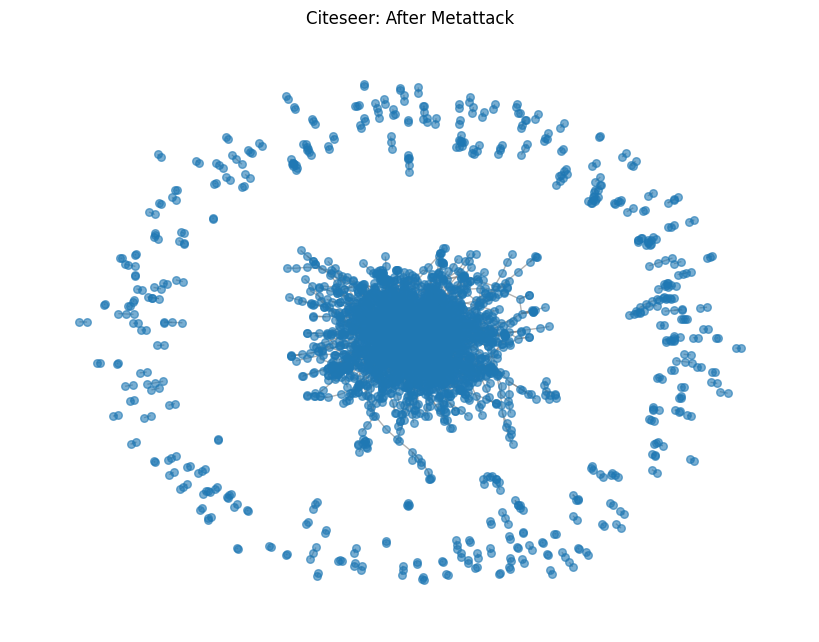

perturbed_adj type: <class 'torch.Tensor'>
Prediction shape: torch.Size([3327, 6])
test_mask shape: torch.Size([3327])
Ground truth labels shape: torch.Size([3327])
Accuracy after Metattack on Citeseer: 0.6570
PolBlogs patching missing features...
PolBlogs making masks...
Dataset: PolBlogs

Number of nodes: 1490
Number of features: 1490
Number of classes: 2

Epoch 0, Loss: 0.6911
Epoch 10, Loss: 0.4601
Epoch 20, Loss: 0.2556
Epoch 30, Loss: 0.1545
Epoch 40, Loss: 0.1182
Epoch 50, Loss: 0.1118
Epoch 60, Loss: 0.1020
Epoch 70, Loss: 0.0945
Epoch 80, Loss: 0.0973
Epoch 90, Loss: 0.0938
----------------------------------------------------------------------------------------------------
Original Graph


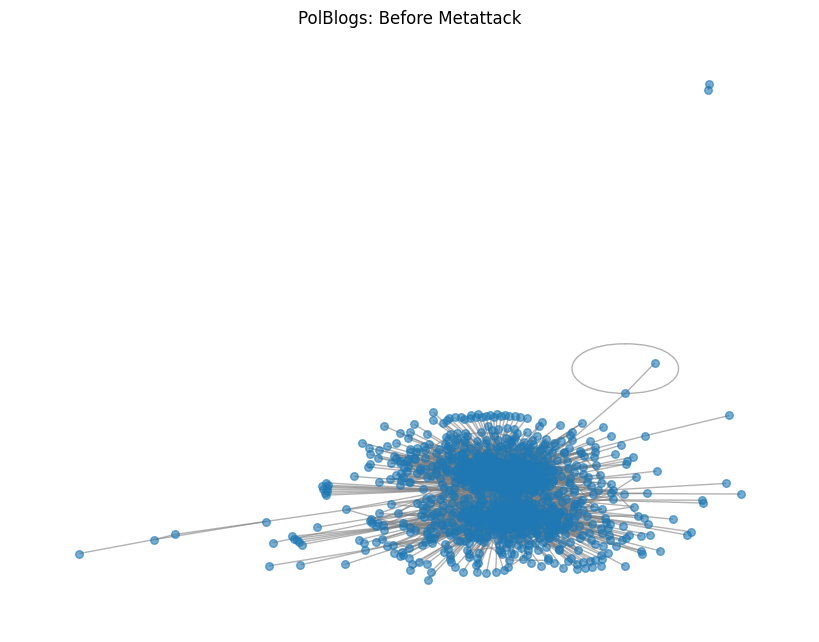

Running on 951 perturbations


Perturbing graph:   0%|          | 0/951 [00:00<?, ?it/s]

GCN loss on unlabled data: 0.43786701560020447
GCN acc on unlabled data: 0.8389261744966443
attack loss: 0.4193980097770691


Perturbing graph:   0%|          | 1/951 [00:03<54:21,  3.43s/it]

GCN loss on unlabled data: 0.4355630576610565
GCN acc on unlabled data: 0.8322147651006712
attack loss: 0.4093334674835205


Perturbing graph:   0%|          | 2/951 [00:06<55:17,  3.50s/it]

GCN loss on unlabled data: 0.4800625443458557
GCN acc on unlabled data: 0.8238255033557047
attack loss: 0.47053849697113037


Perturbing graph:   0%|          | 3/951 [00:11<1:03:53,  4.04s/it]

GCN loss on unlabled data: 0.4693228602409363
GCN acc on unlabled data: 0.8456375838926175
attack loss: 0.4556184709072113


Perturbing graph:   0%|          | 4/951 [00:15<1:02:34,  3.97s/it]

GCN loss on unlabled data: 0.5043890476226807
GCN acc on unlabled data: 0.7986577181208053
attack loss: 0.49622049927711487


Perturbing graph:   1%|          | 5/951 [00:18<59:35,  3.78s/it]  

GCN loss on unlabled data: 0.5651445388793945
GCN acc on unlabled data: 0.7953020134228188
attack loss: 0.5456397533416748


Perturbing graph:   1%|          | 6/951 [00:23<1:05:19,  4.15s/it]

GCN loss on unlabled data: 0.4683585464954376
GCN acc on unlabled data: 0.837248322147651
attack loss: 0.45575612783432007


Perturbing graph:   1%|          | 7/951 [00:27<1:03:19,  4.03s/it]

GCN loss on unlabled data: 0.49729740619659424
GCN acc on unlabled data: 0.8204697986577181
attack loss: 0.48398450016975403


Perturbing graph:   1%|          | 8/951 [00:31<1:01:41,  3.92s/it]

GCN loss on unlabled data: 0.5154705047607422
GCN acc on unlabled data: 0.8104026845637584
attack loss: 0.5071990489959717


Perturbing graph:   1%|          | 9/951 [00:36<1:05:37,  4.18s/it]

GCN loss on unlabled data: 0.6408348679542542
GCN acc on unlabled data: 0.6711409395973155
attack loss: 0.623360276222229


Perturbing graph:   1%|          | 10/951 [00:40<1:06:36,  4.25s/it]

GCN loss on unlabled data: 0.538269579410553
GCN acc on unlabled data: 0.8171140939597316
attack loss: 0.5231391787528992


Perturbing graph:   1%|          | 11/951 [00:44<1:06:36,  4.25s/it]

GCN loss on unlabled data: 0.579822838306427
GCN acc on unlabled data: 0.8154362416107382
attack loss: 0.5756964683532715


Perturbing graph:   1%|▏         | 12/951 [00:49<1:09:53,  4.47s/it]

GCN loss on unlabled data: 0.5526362061500549
GCN acc on unlabled data: 0.7919463087248322
attack loss: 0.5356749892234802


Perturbing graph:   1%|▏         | 13/951 [00:53<1:05:10,  4.17s/it]

GCN loss on unlabled data: 0.6145907044410706
GCN acc on unlabled data: 0.8070469798657718
attack loss: 0.6089996695518494


Perturbing graph:   1%|▏         | 14/951 [00:56<1:01:52,  3.96s/it]

GCN loss on unlabled data: 0.5412272810935974
GCN acc on unlabled data: 0.8087248322147651
attack loss: 0.5313253402709961


Perturbing graph:   2%|▏         | 15/951 [01:01<1:05:32,  4.20s/it]

GCN loss on unlabled data: 0.57438063621521
GCN acc on unlabled data: 0.7969798657718121
attack loss: 0.5608547925949097


Perturbing graph:   2%|▏         | 16/951 [01:05<1:04:42,  4.15s/it]

GCN loss on unlabled data: 0.566977322101593
GCN acc on unlabled data: 0.8439597315436241
attack loss: 0.5494166612625122


Perturbing graph:   2%|▏         | 17/951 [01:09<1:02:56,  4.04s/it]

GCN loss on unlabled data: 0.5789839029312134
GCN acc on unlabled data: 0.7919463087248322
attack loss: 0.5614787936210632


Perturbing graph:   2%|▏         | 18/951 [01:13<1:02:36,  4.03s/it]

GCN loss on unlabled data: 0.6540269255638123
GCN acc on unlabled data: 0.697986577181208
attack loss: 0.6406052112579346


Perturbing graph:   2%|▏         | 19/951 [01:17<1:03:31,  4.09s/it]

GCN loss on unlabled data: 0.6067559719085693
GCN acc on unlabled data: 0.8053691275167785
attack loss: 0.6020112633705139


Perturbing graph:   2%|▏         | 20/951 [01:21<1:02:42,  4.04s/it]

GCN loss on unlabled data: 0.6162463426589966
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6021996736526489


Perturbing graph:   2%|▏         | 21/951 [01:25<1:02:31,  4.03s/it]

GCN loss on unlabled data: 0.5703142881393433
GCN acc on unlabled data: 0.8036912751677853
attack loss: 0.5649781227111816


Perturbing graph:   2%|▏         | 22/951 [01:30<1:07:31,  4.36s/it]

GCN loss on unlabled data: 0.6574851870536804
GCN acc on unlabled data: 0.7399328859060402
attack loss: 0.6472249031066895


Perturbing graph:   2%|▏         | 23/951 [01:34<1:04:26,  4.17s/it]

GCN loss on unlabled data: 0.5994934439659119
GCN acc on unlabled data: 0.8104026845637584
attack loss: 0.5869436264038086


Perturbing graph:   3%|▎         | 24/951 [01:37<1:01:41,  3.99s/it]

GCN loss on unlabled data: 0.6217159032821655
GCN acc on unlabled data: 0.7734899328859061
attack loss: 0.6117613911628723


Perturbing graph:   3%|▎         | 25/951 [01:42<1:06:34,  4.31s/it]

GCN loss on unlabled data: 0.6257485747337341
GCN acc on unlabled data: 0.7835570469798657
attack loss: 0.612633228302002


Perturbing graph:   3%|▎         | 26/951 [01:46<1:03:53,  4.14s/it]

GCN loss on unlabled data: 0.6345467567443848
GCN acc on unlabled data: 0.7718120805369127
attack loss: 0.6244926452636719


Perturbing graph:   3%|▎         | 27/951 [01:50<1:02:35,  4.06s/it]

GCN loss on unlabled data: 0.6465737223625183
GCN acc on unlabled data: 0.7953020134228188
attack loss: 0.6454986333847046


Perturbing graph:   3%|▎         | 28/951 [01:55<1:05:58,  4.29s/it]

GCN loss on unlabled data: 0.5596138834953308
GCN acc on unlabled data: 0.8271812080536913
attack loss: 0.5486205816268921


Perturbing graph:   3%|▎         | 29/951 [01:59<1:03:37,  4.14s/it]

GCN loss on unlabled data: 0.568941593170166
GCN acc on unlabled data: 0.8154362416107382
attack loss: 0.5537432432174683


Perturbing graph:   3%|▎         | 30/951 [02:02<1:01:27,  4.00s/it]

GCN loss on unlabled data: 0.5834836363792419
GCN acc on unlabled data: 0.7986577181208053
attack loss: 0.5632621049880981


Perturbing graph:   3%|▎         | 31/951 [02:07<1:04:59,  4.24s/it]

GCN loss on unlabled data: 0.618251621723175
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6098011136054993


Perturbing graph:   3%|▎         | 32/951 [02:12<1:05:57,  4.31s/it]

GCN loss on unlabled data: 0.6300365924835205
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6201464533805847


Perturbing graph:   3%|▎         | 33/951 [02:15<1:03:52,  4.17s/it]

GCN loss on unlabled data: 0.5982912182807922
GCN acc on unlabled data: 0.7835570469798657
attack loss: 0.5830063819885254


Perturbing graph:   4%|▎         | 34/951 [02:20<1:06:33,  4.36s/it]

GCN loss on unlabled data: 0.6282176971435547
GCN acc on unlabled data: 0.7432885906040269
attack loss: 0.6178195476531982


Perturbing graph:   4%|▎         | 35/951 [02:24<1:03:38,  4.17s/it]

GCN loss on unlabled data: 0.6290004849433899
GCN acc on unlabled data: 0.7986577181208053
attack loss: 0.6205688714981079


Perturbing graph:   4%|▍         | 36/951 [02:28<1:02:12,  4.08s/it]

GCN loss on unlabled data: 0.5920491218566895
GCN acc on unlabled data: 0.7785234899328859
attack loss: 0.5744988322257996


Perturbing graph:   4%|▍         | 37/951 [02:32<1:04:34,  4.24s/it]

GCN loss on unlabled data: 0.610223114490509
GCN acc on unlabled data: 0.7869127516778524
attack loss: 0.5988659858703613


Perturbing graph:   4%|▍         | 38/951 [02:37<1:04:31,  4.24s/it]

GCN loss on unlabled data: 0.6457318067550659
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.6298984289169312


Perturbing graph:   4%|▍         | 39/951 [02:41<1:04:56,  4.27s/it]

GCN loss on unlabled data: 0.6499791741371155
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6325474977493286


Perturbing graph:   4%|▍         | 40/951 [02:46<1:09:11,  4.56s/it]

GCN loss on unlabled data: 0.6181316375732422
GCN acc on unlabled data: 0.8070469798657718
attack loss: 0.6044735908508301


Perturbing graph:   4%|▍         | 41/951 [02:50<1:05:43,  4.33s/it]

GCN loss on unlabled data: 0.626253068447113
GCN acc on unlabled data: 0.8036912751677853
attack loss: 0.6188815236091614


Perturbing graph:   4%|▍         | 42/951 [02:55<1:09:45,  4.60s/it]

GCN loss on unlabled data: 0.6341466307640076
GCN acc on unlabled data: 0.8154362416107382
attack loss: 0.6284066438674927


Perturbing graph:   5%|▍         | 43/951 [03:00<1:10:55,  4.69s/it]

GCN loss on unlabled data: 0.6681855320930481
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.6619482040405273


Perturbing graph:   5%|▍         | 44/951 [03:04<1:06:19,  4.39s/it]

GCN loss on unlabled data: 0.6514744162559509
GCN acc on unlabled data: 0.7483221476510067
attack loss: 0.6396654844284058


Perturbing graph:   5%|▍         | 45/951 [03:08<1:04:44,  4.29s/it]

GCN loss on unlabled data: 0.620164155960083
GCN acc on unlabled data: 0.7734899328859061
attack loss: 0.6075038909912109


Perturbing graph:   5%|▍         | 46/951 [03:13<1:08:08,  4.52s/it]

GCN loss on unlabled data: 0.6252661347389221
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6111206412315369


Perturbing graph:   5%|▍         | 47/951 [03:18<1:08:23,  4.54s/it]

GCN loss on unlabled data: 0.6510001420974731
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6374642848968506


Perturbing graph:   5%|▌         | 48/951 [03:22<1:08:07,  4.53s/it]

GCN loss on unlabled data: 0.6265200972557068
GCN acc on unlabled data: 0.7802013422818792
attack loss: 0.619350254535675


Perturbing graph:   5%|▌         | 49/951 [03:27<1:11:01,  4.72s/it]

GCN loss on unlabled data: 0.6334093809127808
GCN acc on unlabled data: 0.785234899328859
attack loss: 0.6233626008033752


Perturbing graph:   5%|▌         | 50/951 [03:32<1:11:27,  4.76s/it]

GCN loss on unlabled data: 0.6313258409500122
GCN acc on unlabled data: 0.8036912751677853
attack loss: 0.6275413036346436


Perturbing graph:   5%|▌         | 51/951 [03:38<1:15:35,  5.04s/it]

GCN loss on unlabled data: 0.621507465839386
GCN acc on unlabled data: 0.7969798657718121
attack loss: 0.6186479926109314


Perturbing graph:   5%|▌         | 52/951 [03:42<1:11:09,  4.75s/it]

GCN loss on unlabled data: 0.6365935206413269
GCN acc on unlabled data: 0.7869127516778524
attack loss: 0.6238410472869873


Perturbing graph:   6%|▌         | 53/951 [03:46<1:06:33,  4.45s/it]

GCN loss on unlabled data: 0.6113541126251221
GCN acc on unlabled data: 0.8036912751677853
attack loss: 0.6030051708221436


Perturbing graph:   6%|▌         | 54/951 [03:51<1:09:13,  4.63s/it]

GCN loss on unlabled data: 0.6332686543464661
GCN acc on unlabled data: 0.7835570469798657
attack loss: 0.6259618997573853


Perturbing graph:   6%|▌         | 55/951 [03:55<1:09:53,  4.68s/it]

GCN loss on unlabled data: 0.6454313397407532
GCN acc on unlabled data: 0.7802013422818792
attack loss: 0.6376433968544006


Perturbing graph:   6%|▌         | 56/951 [03:59<1:05:59,  4.42s/it]

GCN loss on unlabled data: 0.6083405017852783
GCN acc on unlabled data: 0.7919463087248322
attack loss: 0.5945632457733154


Perturbing graph:   6%|▌         | 57/951 [04:05<1:10:57,  4.76s/it]

GCN loss on unlabled data: 0.6304181814193726
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.6209328770637512


Perturbing graph:   6%|▌         | 58/951 [04:09<1:07:36,  4.54s/it]

GCN loss on unlabled data: 0.5908306241035461
GCN acc on unlabled data: 0.802013422818792
attack loss: 0.5814886093139648


Perturbing graph:   6%|▌         | 59/951 [04:14<1:09:43,  4.69s/it]

GCN loss on unlabled data: 0.6125574707984924
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.5943346619606018


Perturbing graph:   6%|▋         | 60/951 [04:18<1:08:21,  4.60s/it]

GCN loss on unlabled data: 0.6270013451576233
GCN acc on unlabled data: 0.7667785234899329
attack loss: 0.6191188097000122


Perturbing graph:   6%|▋         | 61/951 [04:23<1:07:08,  4.53s/it]

GCN loss on unlabled data: 0.6341933012008667
GCN acc on unlabled data: 0.8137583892617449
attack loss: 0.6199873685836792


Perturbing graph:   7%|▋         | 62/951 [04:27<1:07:48,  4.58s/it]

GCN loss on unlabled data: 0.6474608778953552
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6350788474082947


Perturbing graph:   7%|▋         | 63/951 [04:32<1:09:16,  4.68s/it]

GCN loss on unlabled data: 0.6138136386871338
GCN acc on unlabled data: 0.7802013422818792
attack loss: 0.6007423400878906


Perturbing graph:   7%|▋         | 64/951 [04:36<1:05:41,  4.44s/it]

GCN loss on unlabled data: 0.5947834849357605
GCN acc on unlabled data: 0.8154362416107382
attack loss: 0.5778993368148804


Perturbing graph:   7%|▋         | 65/951 [04:41<1:08:56,  4.67s/it]

GCN loss on unlabled data: 0.6082042455673218
GCN acc on unlabled data: 0.8120805369127517
attack loss: 0.6000769138336182


Perturbing graph:   7%|▋         | 66/951 [04:45<1:04:07,  4.35s/it]

GCN loss on unlabled data: 0.593401312828064
GCN acc on unlabled data: 0.8070469798657718
attack loss: 0.583520770072937


Perturbing graph:   7%|▋         | 67/951 [04:49<1:03:00,  4.28s/it]

GCN loss on unlabled data: 0.6341458559036255
GCN acc on unlabled data: 0.7986577181208053
attack loss: 0.6268237829208374


Perturbing graph:   7%|▋         | 68/951 [04:54<1:06:23,  4.51s/it]

GCN loss on unlabled data: 0.5968286395072937
GCN acc on unlabled data: 0.825503355704698
attack loss: 0.5933105945587158


Perturbing graph:   7%|▋         | 69/951 [04:58<1:04:00,  4.35s/it]

GCN loss on unlabled data: 0.6268907785415649
GCN acc on unlabled data: 0.7835570469798657
attack loss: 0.6207480430603027


Perturbing graph:   7%|▋         | 70/951 [05:03<1:04:52,  4.42s/it]

GCN loss on unlabled data: 0.6346557140350342
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6298468112945557


Perturbing graph:   7%|▋         | 71/951 [05:08<1:07:54,  4.63s/it]

GCN loss on unlabled data: 0.605809211730957
GCN acc on unlabled data: 0.8003355704697986
attack loss: 0.6050637364387512


Perturbing graph:   8%|▊         | 72/951 [05:12<1:05:34,  4.48s/it]

GCN loss on unlabled data: 0.6828290820121765
GCN acc on unlabled data: 0.6711409395973155
attack loss: 0.678203821182251


Perturbing graph:   8%|▊         | 73/951 [05:16<1:03:10,  4.32s/it]

GCN loss on unlabled data: 0.6586282253265381
GCN acc on unlabled data: 0.7885906040268457
attack loss: 0.651681661605835


Perturbing graph:   8%|▊         | 74/951 [05:20<1:04:28,  4.41s/it]

GCN loss on unlabled data: 0.6511446237564087
GCN acc on unlabled data: 0.761744966442953
attack loss: 0.6447297930717468


Perturbing graph:   8%|▊         | 75/951 [05:24<1:00:30,  4.14s/it]

GCN loss on unlabled data: 0.6076607704162598
GCN acc on unlabled data: 0.7768456375838926
attack loss: 0.603303074836731


Perturbing graph:   8%|▊         | 76/951 [05:28<1:00:27,  4.15s/it]

GCN loss on unlabled data: 0.6522153615951538
GCN acc on unlabled data: 0.7869127516778524
attack loss: 0.6460469961166382


Perturbing graph:   8%|▊         | 77/951 [05:33<1:03:06,  4.33s/it]

GCN loss on unlabled data: 0.6316477656364441
GCN acc on unlabled data: 0.7953020134228188
attack loss: 0.6280619502067566


Perturbing graph:   8%|▊         | 78/951 [05:38<1:04:32,  4.44s/it]

GCN loss on unlabled data: 0.6343781352043152
GCN acc on unlabled data: 0.7986577181208053
attack loss: 0.6246960163116455


Perturbing graph:   8%|▊         | 79/951 [05:42<1:04:07,  4.41s/it]

GCN loss on unlabled data: 0.6308425068855286
GCN acc on unlabled data: 0.7734899328859061
attack loss: 0.6134480237960815


Perturbing graph:   8%|▊         | 80/951 [05:47<1:07:24,  4.64s/it]

GCN loss on unlabled data: 0.6017676591873169
GCN acc on unlabled data: 0.7768456375838926
attack loss: 0.597728967666626


Perturbing graph:   9%|▊         | 81/951 [05:51<1:04:09,  4.42s/it]

GCN loss on unlabled data: 0.6224156618118286
GCN acc on unlabled data: 0.8087248322147651
attack loss: 0.6147372722625732


Perturbing graph:   9%|▊         | 82/951 [05:55<1:01:51,  4.27s/it]

GCN loss on unlabled data: 0.666237473487854
GCN acc on unlabled data: 0.6426174496644296
attack loss: 0.6547579765319824


Perturbing graph:   9%|▊         | 83/951 [06:00<1:04:25,  4.45s/it]

GCN loss on unlabled data: 0.632543683052063
GCN acc on unlabled data: 0.7953020134228188
attack loss: 0.6252468824386597


Perturbing graph:   9%|▉         | 84/951 [06:04<1:03:53,  4.42s/it]

GCN loss on unlabled data: 0.6485346555709839
GCN acc on unlabled data: 0.7667785234899329
attack loss: 0.642696738243103


Perturbing graph:   9%|▉         | 85/951 [06:08<1:00:31,  4.19s/it]

GCN loss on unlabled data: 0.6409667134284973
GCN acc on unlabled data: 0.790268456375839
attack loss: 0.6336583495140076


Perturbing graph:   9%|▉         | 86/951 [06:13<1:04:27,  4.47s/it]

GCN loss on unlabled data: 0.6303483843803406
GCN acc on unlabled data: 0.802013422818792
attack loss: 0.6234187483787537


Perturbing graph:   9%|▉         | 87/951 [06:17<1:03:24,  4.40s/it]

GCN loss on unlabled data: 0.6528318524360657
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6407406330108643


Perturbing graph:   9%|▉         | 88/951 [06:21<1:00:18,  4.19s/it]

GCN loss on unlabled data: 0.6558696627616882
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.6437119245529175


Perturbing graph:   9%|▉         | 89/951 [06:26<1:04:02,  4.46s/it]

GCN loss on unlabled data: 0.624396026134491
GCN acc on unlabled data: 0.8070469798657718
attack loss: 0.6195878982543945


Perturbing graph:   9%|▉         | 90/951 [06:30<1:02:58,  4.39s/it]

GCN loss on unlabled data: 0.6154878735542297
GCN acc on unlabled data: 0.8137583892617449
attack loss: 0.6068494319915771


Perturbing graph:  10%|▉         | 91/951 [06:35<1:03:25,  4.42s/it]

GCN loss on unlabled data: 0.6295640468597412
GCN acc on unlabled data: 0.7969798657718121
attack loss: 0.6224526166915894


Perturbing graph:  10%|▉         | 92/951 [06:40<1:08:01,  4.75s/it]

GCN loss on unlabled data: 0.6491996049880981
GCN acc on unlabled data: 0.6929530201342282
attack loss: 0.64897620677948


Perturbing graph:  10%|▉         | 93/951 [06:44<1:04:38,  4.52s/it]

GCN loss on unlabled data: 0.6403035521507263
GCN acc on unlabled data: 0.7114093959731543
attack loss: 0.6363849639892578


Perturbing graph:  10%|▉         | 94/951 [06:49<1:04:48,  4.54s/it]

GCN loss on unlabled data: 0.6385039687156677
GCN acc on unlabled data: 0.7936241610738255
attack loss: 0.6283516883850098


Perturbing graph:  10%|▉         | 95/951 [06:53<1:05:02,  4.56s/it]

GCN loss on unlabled data: 0.6431703567504883
GCN acc on unlabled data: 0.7667785234899329
attack loss: 0.6396515369415283


Perturbing graph:  10%|█         | 96/951 [06:58<1:03:18,  4.44s/it]

GCN loss on unlabled data: 0.6507827639579773
GCN acc on unlabled data: 0.7348993288590604
attack loss: 0.6470307111740112


Perturbing graph:  10%|█         | 97/951 [07:02<1:03:52,  4.49s/it]

GCN loss on unlabled data: 0.6327546834945679
GCN acc on unlabled data: 0.7768456375838926
attack loss: 0.6238632202148438


Perturbing graph:  10%|█         | 98/951 [07:06<1:01:16,  4.31s/it]

GCN loss on unlabled data: 0.6534633040428162
GCN acc on unlabled data: 0.7348993288590604
attack loss: 0.6472489833831787


Perturbing graph:  10%|█         | 99/951 [07:11<1:02:36,  4.41s/it]

GCN loss on unlabled data: 0.6217862963676453
GCN acc on unlabled data: 0.8187919463087249
attack loss: 0.6216974258422852


Perturbing graph:  11%|█         | 100/951 [07:16<1:05:43,  4.63s/it]

GCN loss on unlabled data: 0.6381495594978333
GCN acc on unlabled data: 0.7885906040268457
attack loss: 0.6299006342887878


Perturbing graph:  11%|█         | 101/951 [07:20<1:04:18,  4.54s/it]

GCN loss on unlabled data: 0.6376064419746399
GCN acc on unlabled data: 0.7885906040268457
attack loss: 0.6299798488616943


Perturbing graph:  11%|█         | 102/951 [07:25<1:06:09,  4.68s/it]

GCN loss on unlabled data: 0.6555591821670532
GCN acc on unlabled data: 0.7785234899328859
attack loss: 0.650388777256012


Perturbing graph:  11%|█         | 103/951 [07:30<1:07:36,  4.78s/it]

GCN loss on unlabled data: 0.6344268321990967
GCN acc on unlabled data: 0.7885906040268457
attack loss: 0.631000280380249


Perturbing graph:  11%|█         | 104/951 [07:34<1:05:05,  4.61s/it]

GCN loss on unlabled data: 0.6006728410720825
GCN acc on unlabled data: 0.8087248322147651
attack loss: 0.585423469543457


Perturbing graph:  11%|█         | 105/951 [07:39<1:06:33,  4.72s/it]

GCN loss on unlabled data: 0.6473487615585327
GCN acc on unlabled data: 0.697986577181208
attack loss: 0.6387910842895508


Perturbing graph:  11%|█         | 106/951 [07:45<1:08:59,  4.90s/it]

GCN loss on unlabled data: 0.6633739471435547
GCN acc on unlabled data: 0.7315436241610739
attack loss: 0.6548985242843628


Perturbing graph:  11%|█▏        | 107/951 [07:49<1:08:16,  4.85s/it]

GCN loss on unlabled data: 0.6359755396842957
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6273302435874939


Perturbing graph:  11%|█▏        | 108/951 [07:54<1:07:43,  4.82s/it]

GCN loss on unlabled data: 0.6435778737068176
GCN acc on unlabled data: 0.7936241610738255
attack loss: 0.6348745822906494


Perturbing graph:  11%|█▏        | 109/951 [07:58<1:04:26,  4.59s/it]

GCN loss on unlabled data: 0.6316894888877869
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6235074996948242


Perturbing graph:  12%|█▏        | 110/951 [08:02<1:00:47,  4.34s/it]

GCN loss on unlabled data: 0.6507744789123535
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6456813812255859


Perturbing graph:  12%|█▏        | 111/951 [08:06<1:01:00,  4.36s/it]

GCN loss on unlabled data: 0.645020067691803
GCN acc on unlabled data: 0.7953020134228188
attack loss: 0.6379251480102539


Perturbing graph:  12%|█▏        | 112/951 [08:11<1:03:08,  4.52s/it]

GCN loss on unlabled data: 0.6500754356384277
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6435655355453491


Perturbing graph:  12%|█▏        | 113/951 [08:15<1:00:42,  4.35s/it]

GCN loss on unlabled data: 0.6383172273635864
GCN acc on unlabled data: 0.7651006711409396
attack loss: 0.6280068755149841


Perturbing graph:  12%|█▏        | 114/951 [08:20<1:01:35,  4.41s/it]

GCN loss on unlabled data: 0.6183637380599976
GCN acc on unlabled data: 0.8087248322147651
attack loss: 0.6165741682052612


Perturbing graph:  12%|█▏        | 115/951 [08:24<58:35,  4.20s/it]  

GCN loss on unlabled data: 0.6355799436569214
GCN acc on unlabled data: 0.8137583892617449
attack loss: 0.6336961984634399


Perturbing graph:  12%|█▏        | 116/951 [08:28<58:08,  4.18s/it]

GCN loss on unlabled data: 0.6198513507843018
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6145634651184082


Perturbing graph:  12%|█▏        | 117/951 [08:32<58:08,  4.18s/it]

GCN loss on unlabled data: 0.6410378813743591
GCN acc on unlabled data: 0.7281879194630873
attack loss: 0.6384731531143188


Perturbing graph:  12%|█▏        | 118/951 [08:37<1:03:48,  4.60s/it]

GCN loss on unlabled data: 0.6249898076057434
GCN acc on unlabled data: 0.8003355704697986
attack loss: 0.6232287883758545


Perturbing graph:  13%|█▎        | 119/951 [08:41<1:01:29,  4.43s/it]

GCN loss on unlabled data: 0.6552813053131104
GCN acc on unlabled data: 0.7516778523489933
attack loss: 0.6484693288803101


Perturbing graph:  13%|█▎        | 120/951 [08:47<1:04:14,  4.64s/it]

GCN loss on unlabled data: 0.664905309677124
GCN acc on unlabled data: 0.6543624161073825
attack loss: 0.6561952829360962


Perturbing graph:  13%|█▎        | 121/951 [08:51<1:02:15,  4.50s/it]

GCN loss on unlabled data: 0.6284343004226685
GCN acc on unlabled data: 0.7919463087248322
attack loss: 0.625251293182373


Perturbing graph:  13%|█▎        | 122/951 [08:56<1:06:48,  4.84s/it]

GCN loss on unlabled data: 0.6593894958496094
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6549928188323975


Perturbing graph:  13%|█▎        | 123/951 [09:03<1:15:57,  5.50s/it]

GCN loss on unlabled data: 0.6042954325675964
GCN acc on unlabled data: 0.8137583892617449
attack loss: 0.600548505783081


Perturbing graph:  13%|█▎        | 124/951 [09:07<1:07:44,  4.91s/it]

GCN loss on unlabled data: 0.6654207110404968
GCN acc on unlabled data: 0.5822147651006712
attack loss: 0.6600186824798584


Perturbing graph:  13%|█▎        | 125/951 [09:11<1:06:07,  4.80s/it]

GCN loss on unlabled data: 0.5903232097625732
GCN acc on unlabled data: 0.802013422818792
attack loss: 0.5828726291656494


Perturbing graph:  13%|█▎        | 126/951 [09:17<1:08:02,  4.95s/it]

GCN loss on unlabled data: 0.660284161567688
GCN acc on unlabled data: 0.7651006711409396
attack loss: 0.6567934155464172


Perturbing graph:  13%|█▎        | 127/951 [09:21<1:03:57,  4.66s/it]

GCN loss on unlabled data: 0.6441954374313354
GCN acc on unlabled data: 0.8053691275167785
attack loss: 0.6462527513504028


Perturbing graph:  13%|█▎        | 128/951 [09:25<1:03:18,  4.61s/it]

GCN loss on unlabled data: 0.6209617853164673
GCN acc on unlabled data: 0.8053691275167785
attack loss: 0.6210553646087646


Perturbing graph:  14%|█▎        | 129/951 [09:30<1:04:56,  4.74s/it]

GCN loss on unlabled data: 0.6410731077194214
GCN acc on unlabled data: 0.7516778523489933
attack loss: 0.6339285373687744


Perturbing graph:  14%|█▎        | 130/951 [09:35<1:02:48,  4.59s/it]

GCN loss on unlabled data: 0.6268294453620911
GCN acc on unlabled data: 0.7986577181208053
attack loss: 0.6281512975692749


Perturbing graph:  14%|█▍        | 131/951 [09:40<1:05:54,  4.82s/it]

GCN loss on unlabled data: 0.6347317695617676
GCN acc on unlabled data: 0.7835570469798657
attack loss: 0.6382253766059875


Perturbing graph:  14%|█▍        | 132/951 [09:44<1:04:10,  4.70s/it]

GCN loss on unlabled data: 0.6565447449684143
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6537636518478394


Perturbing graph:  14%|█▍        | 133/951 [09:49<1:04:39,  4.74s/it]

GCN loss on unlabled data: 0.6579057574272156
GCN acc on unlabled data: 0.761744966442953
attack loss: 0.6553488969802856


Perturbing graph:  14%|█▍        | 134/951 [09:54<1:05:29,  4.81s/it]

GCN loss on unlabled data: 0.6421627998352051
GCN acc on unlabled data: 0.697986577181208
attack loss: 0.6388168931007385


Perturbing graph:  14%|█▍        | 135/951 [09:58<1:01:57,  4.56s/it]

GCN loss on unlabled data: 0.6479933857917786
GCN acc on unlabled data: 0.7651006711409396
attack loss: 0.6417958736419678


Perturbing graph:  14%|█▍        | 136/951 [10:02<1:00:24,  4.45s/it]

GCN loss on unlabled data: 0.6164150238037109
GCN acc on unlabled data: 0.8137583892617449
attack loss: 0.616142213344574


Perturbing graph:  14%|█▍        | 137/951 [10:07<1:02:05,  4.58s/it]

GCN loss on unlabled data: 0.6470942497253418
GCN acc on unlabled data: 0.8238255033557047
attack loss: 0.6486068964004517


Perturbing graph:  15%|█▍        | 138/951 [10:11<57:26,  4.24s/it]  

GCN loss on unlabled data: 0.6415671706199646
GCN acc on unlabled data: 0.7869127516778524
attack loss: 0.6362391710281372


Perturbing graph:  15%|█▍        | 139/951 [10:15<57:51,  4.28s/it]

GCN loss on unlabled data: 0.6544209718704224
GCN acc on unlabled data: 0.5973154362416108
attack loss: 0.6493387222290039


Perturbing graph:  15%|█▍        | 140/951 [10:20<59:00,  4.37s/it]

GCN loss on unlabled data: 0.6572166681289673
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6521049737930298


Perturbing graph:  15%|█▍        | 141/951 [10:24<57:56,  4.29s/it]

GCN loss on unlabled data: 0.6606618165969849
GCN acc on unlabled data: 0.7768456375838926
attack loss: 0.6576026082038879


Perturbing graph:  15%|█▍        | 142/951 [10:28<56:11,  4.17s/it]

GCN loss on unlabled data: 0.6516409516334534
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6482728719711304


Perturbing graph:  15%|█▌        | 143/951 [10:32<58:39,  4.36s/it]

GCN loss on unlabled data: 0.6225256323814392
GCN acc on unlabled data: 0.790268456375839
attack loss: 0.6120179891586304


Perturbing graph:  15%|█▌        | 144/951 [10:36<56:44,  4.22s/it]

GCN loss on unlabled data: 0.6418712139129639
GCN acc on unlabled data: 0.7936241610738255
attack loss: 0.6471395492553711


Perturbing graph:  15%|█▌        | 145/951 [10:40<53:36,  3.99s/it]

GCN loss on unlabled data: 0.6722684502601624
GCN acc on unlabled data: 0.5805369127516778
attack loss: 0.6674802899360657


Perturbing graph:  15%|█▌        | 146/951 [10:45<56:55,  4.24s/it]

GCN loss on unlabled data: 0.6371057629585266
GCN acc on unlabled data: 0.7885906040268457
attack loss: 0.633155107498169


Perturbing graph:  15%|█▌        | 147/951 [10:48<54:59,  4.10s/it]

GCN loss on unlabled data: 0.6540995836257935
GCN acc on unlabled data: 0.7768456375838926
attack loss: 0.6541242599487305


Perturbing graph:  16%|█▌        | 148/951 [10:52<54:13,  4.05s/it]

GCN loss on unlabled data: 0.6474371552467346
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6463014483451843


Perturbing graph:  16%|█▌        | 149/951 [10:57<57:27,  4.30s/it]

GCN loss on unlabled data: 0.638966977596283
GCN acc on unlabled data: 0.7835570469798657
attack loss: 0.6366323828697205


Perturbing graph:  16%|█▌        | 150/951 [11:02<58:40,  4.40s/it]

GCN loss on unlabled data: 0.6601517796516418
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6574374437332153


Perturbing graph:  16%|█▌        | 151/951 [11:06<57:46,  4.33s/it]

GCN loss on unlabled data: 0.6335709095001221
GCN acc on unlabled data: 0.802013422818792
attack loss: 0.6347805261611938


Perturbing graph:  16%|█▌        | 152/951 [11:11<1:01:17,  4.60s/it]

GCN loss on unlabled data: 0.6766994595527649
GCN acc on unlabled data: 0.5167785234899329
attack loss: 0.666993260383606


Perturbing graph:  16%|█▌        | 153/951 [11:15<57:18,  4.31s/it]  

GCN loss on unlabled data: 0.6170304417610168
GCN acc on unlabled data: 0.7785234899328859
attack loss: 0.6155948638916016


Perturbing graph:  16%|█▌        | 154/951 [11:18<53:58,  4.06s/it]

GCN loss on unlabled data: 0.6508569121360779
GCN acc on unlabled data: 0.7080536912751678
attack loss: 0.6484732031822205


Perturbing graph:  16%|█▋        | 155/951 [11:23<55:36,  4.19s/it]

GCN loss on unlabled data: 0.6499608755111694
GCN acc on unlabled data: 0.7516778523489933
attack loss: 0.6530790328979492


Perturbing graph:  16%|█▋        | 156/951 [11:26<52:51,  3.99s/it]

GCN loss on unlabled data: 0.626103937625885
GCN acc on unlabled data: 0.7802013422818792
attack loss: 0.6253582239151001


Perturbing graph:  17%|█▋        | 157/951 [11:31<53:56,  4.08s/it]

GCN loss on unlabled data: 0.6721950173377991
GCN acc on unlabled data: 0.6510067114093959
attack loss: 0.6736659407615662


Perturbing graph:  17%|█▋        | 158/951 [11:36<57:33,  4.36s/it]

GCN loss on unlabled data: 0.6540985703468323
GCN acc on unlabled data: 0.7667785234899329
attack loss: 0.6487264633178711


Perturbing graph:  17%|█▋        | 159/951 [11:40<58:27,  4.43s/it]

GCN loss on unlabled data: 0.6414974927902222
GCN acc on unlabled data: 0.7835570469798657
attack loss: 0.6415092945098877


Perturbing graph:  17%|█▋        | 160/951 [11:44<56:49,  4.31s/it]

GCN loss on unlabled data: 0.6384129524230957
GCN acc on unlabled data: 0.7936241610738255
attack loss: 0.6334716081619263


Perturbing graph:  17%|█▋        | 161/951 [11:49<58:07,  4.41s/it]

GCN loss on unlabled data: 0.6353862285614014
GCN acc on unlabled data: 0.7718120805369127
attack loss: 0.6330587863922119


Perturbing graph:  17%|█▋        | 162/951 [11:53<57:30,  4.37s/it]

GCN loss on unlabled data: 0.653742253780365
GCN acc on unlabled data: 0.7785234899328859
attack loss: 0.6516995429992676


Perturbing graph:  17%|█▋        | 163/951 [11:57<56:41,  4.32s/it]

GCN loss on unlabled data: 0.646239697933197
GCN acc on unlabled data: 0.7046979865771812
attack loss: 0.6434819102287292


Perturbing graph:  17%|█▋        | 164/951 [12:02<59:02,  4.50s/it]

GCN loss on unlabled data: 0.6405843496322632
GCN acc on unlabled data: 0.7600671140939598
attack loss: 0.6346973180770874


Perturbing graph:  17%|█▋        | 165/951 [12:06<57:56,  4.42s/it]

GCN loss on unlabled data: 0.6256530284881592
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6269636750221252


Perturbing graph:  17%|█▋        | 166/951 [12:11<57:04,  4.36s/it]

GCN loss on unlabled data: 0.6632834076881409
GCN acc on unlabled data: 0.790268456375839
attack loss: 0.6642292141914368


Perturbing graph:  18%|█▊        | 167/951 [12:16<59:54,  4.58s/it]

GCN loss on unlabled data: 0.6419801115989685
GCN acc on unlabled data: 0.7466442953020134
attack loss: 0.6387332081794739


Perturbing graph:  18%|█▊        | 168/951 [12:20<57:02,  4.37s/it]

GCN loss on unlabled data: 0.6647002696990967
GCN acc on unlabled data: 0.5838926174496645
attack loss: 0.6614251732826233


Perturbing graph:  18%|█▊        | 169/951 [12:23<53:38,  4.12s/it]

GCN loss on unlabled data: 0.6513930559158325
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6525598764419556


Perturbing graph:  18%|█▊        | 170/951 [12:28<54:36,  4.19s/it]

GCN loss on unlabled data: 0.6402772068977356
GCN acc on unlabled data: 0.785234899328859
attack loss: 0.638927698135376


Perturbing graph:  18%|█▊        | 171/951 [12:31<53:21,  4.10s/it]

GCN loss on unlabled data: 0.6305978894233704
GCN acc on unlabled data: 0.7936241610738255
attack loss: 0.6310515403747559


Perturbing graph:  18%|█▊        | 172/951 [12:36<53:21,  4.11s/it]

GCN loss on unlabled data: 0.6462961435317993
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6502866744995117


Perturbing graph:  18%|█▊        | 173/951 [12:40<56:09,  4.33s/it]

GCN loss on unlabled data: 0.6677228808403015
GCN acc on unlabled data: 0.7130872483221476
attack loss: 0.6647936701774597


Perturbing graph:  18%|█▊        | 174/951 [12:45<55:21,  4.27s/it]

GCN loss on unlabled data: 0.6273934245109558
GCN acc on unlabled data: 0.7869127516778524
attack loss: 0.6328385472297668


Perturbing graph:  18%|█▊        | 175/951 [12:50<58:25,  4.52s/it]

GCN loss on unlabled data: 0.6327639818191528
GCN acc on unlabled data: 0.7919463087248322
attack loss: 0.6336612701416016


Perturbing graph:  19%|█▊        | 176/951 [12:54<58:38,  4.54s/it]

GCN loss on unlabled data: 0.6355185508728027
GCN acc on unlabled data: 0.8154362416107382
attack loss: 0.6400130391120911


Perturbing graph:  19%|█▊        | 177/951 [12:59<57:40,  4.47s/it]

GCN loss on unlabled data: 0.6615582704544067
GCN acc on unlabled data: 0.7550335570469798
attack loss: 0.6599152088165283


Perturbing graph:  19%|█▊        | 178/951 [13:02<54:05,  4.20s/it]

GCN loss on unlabled data: 0.6405278444290161
GCN acc on unlabled data: 0.8003355704697986
attack loss: 0.6426433324813843


Perturbing graph:  19%|█▉        | 179/951 [13:07<56:50,  4.42s/it]

GCN loss on unlabled data: 0.6345099210739136
GCN acc on unlabled data: 0.7936241610738255
attack loss: 0.6400368213653564


Perturbing graph:  19%|█▉        | 180/951 [13:11<53:37,  4.17s/it]

GCN loss on unlabled data: 0.66668301820755
GCN acc on unlabled data: 0.7667785234899329
attack loss: 0.6676032543182373


Perturbing graph:  19%|█▉        | 181/951 [13:15<53:33,  4.17s/it]

GCN loss on unlabled data: 0.6581741571426392
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.6620423793792725


Perturbing graph:  19%|█▉        | 182/951 [13:20<58:16,  4.55s/it]

GCN loss on unlabled data: 0.6469272971153259
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.6497493386268616


Perturbing graph:  19%|█▉        | 183/951 [13:24<56:13,  4.39s/it]

GCN loss on unlabled data: 0.6051104664802551
GCN acc on unlabled data: 0.8003355704697986
attack loss: 0.6068815588951111


Perturbing graph:  19%|█▉        | 184/951 [13:28<53:11,  4.16s/it]

GCN loss on unlabled data: 0.6616895198822021
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6583940982818604


Perturbing graph:  19%|█▉        | 185/951 [13:33<54:58,  4.31s/it]

GCN loss on unlabled data: 0.6187912821769714
GCN acc on unlabled data: 0.7919463087248322
attack loss: 0.629698634147644


Perturbing graph:  20%|█▉        | 186/951 [13:36<53:13,  4.17s/it]

GCN loss on unlabled data: 0.6273967027664185
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6323741674423218


Perturbing graph:  20%|█▉        | 187/951 [13:40<51:04,  4.01s/it]

GCN loss on unlabled data: 0.6654267311096191
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.664374589920044


Perturbing graph:  20%|█▉        | 188/951 [13:45<54:19,  4.27s/it]

GCN loss on unlabled data: 0.643841564655304
GCN acc on unlabled data: 0.7969798657718121
attack loss: 0.6453380584716797


Perturbing graph:  20%|█▉        | 189/951 [13:49<54:09,  4.26s/it]

GCN loss on unlabled data: 0.6325466632843018
GCN acc on unlabled data: 0.8036912751677853
attack loss: 0.6347048282623291


Perturbing graph:  20%|█▉        | 190/951 [13:53<53:28,  4.22s/it]

GCN loss on unlabled data: 0.6433298587799072
GCN acc on unlabled data: 0.7718120805369127
attack loss: 0.640636146068573


Perturbing graph:  20%|██        | 191/951 [13:58<54:38,  4.31s/it]

GCN loss on unlabled data: 0.5974269509315491
GCN acc on unlabled data: 0.8104026845637584
attack loss: 0.6061476469039917


Perturbing graph:  20%|██        | 192/951 [14:01<51:56,  4.11s/it]

GCN loss on unlabled data: 0.6487661004066467
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.6448999643325806


Perturbing graph:  20%|██        | 193/951 [14:05<51:07,  4.05s/it]

GCN loss on unlabled data: 0.6374155282974243
GCN acc on unlabled data: 0.7869127516778524
attack loss: 0.638942301273346


Perturbing graph:  20%|██        | 194/951 [14:11<55:29,  4.40s/it]

GCN loss on unlabled data: 0.6470531821250916
GCN acc on unlabled data: 0.7734899328859061
attack loss: 0.6487277746200562


Perturbing graph:  21%|██        | 195/951 [14:15<54:44,  4.34s/it]

GCN loss on unlabled data: 0.6502620577812195
GCN acc on unlabled data: 0.7802013422818792
attack loss: 0.6505343914031982


Perturbing graph:  21%|██        | 196/951 [14:19<53:30,  4.25s/it]

GCN loss on unlabled data: 0.6354758143424988
GCN acc on unlabled data: 0.7869127516778524
attack loss: 0.6386379599571228


Perturbing graph:  21%|██        | 197/951 [14:23<54:50,  4.36s/it]

GCN loss on unlabled data: 0.6350093483924866
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6345100402832031


Perturbing graph:  21%|██        | 198/951 [14:27<52:49,  4.21s/it]

GCN loss on unlabled data: 0.6571573615074158
GCN acc on unlabled data: 0.7466442953020134
attack loss: 0.6552404165267944


Perturbing graph:  21%|██        | 199/951 [14:31<51:43,  4.13s/it]

GCN loss on unlabled data: 0.6396531462669373
GCN acc on unlabled data: 0.8053691275167785
attack loss: 0.6483222842216492


Perturbing graph:  21%|██        | 200/951 [14:37<56:52,  4.54s/it]

GCN loss on unlabled data: 0.6485023498535156
GCN acc on unlabled data: 0.7164429530201343
attack loss: 0.6518969535827637


Perturbing graph:  21%|██        | 201/951 [14:41<55:42,  4.46s/it]

GCN loss on unlabled data: 0.6499356627464294
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.648606538772583


Perturbing graph:  21%|██        | 202/951 [14:45<53:30,  4.29s/it]

GCN loss on unlabled data: 0.644351601600647
GCN acc on unlabled data: 0.7432885906040269
attack loss: 0.6431657671928406


Perturbing graph:  21%|██▏       | 203/951 [14:50<56:16,  4.51s/it]

GCN loss on unlabled data: 0.628581702709198
GCN acc on unlabled data: 0.785234899328859
attack loss: 0.6349015235900879


Perturbing graph:  21%|██▏       | 204/951 [14:55<56:53,  4.57s/it]

GCN loss on unlabled data: 0.663109302520752
GCN acc on unlabled data: 0.7651006711409396
attack loss: 0.6662107706069946


Perturbing graph:  22%|██▏       | 205/951 [15:00<59:13,  4.76s/it]

GCN loss on unlabled data: 0.619856595993042
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.6218577027320862


Perturbing graph:  22%|██▏       | 206/951 [15:05<1:00:08,  4.84s/it]

GCN loss on unlabled data: 0.6585773825645447
GCN acc on unlabled data: 0.7802013422818792
attack loss: 0.6576989889144897


Perturbing graph:  22%|██▏       | 207/951 [15:09<57:26,  4.63s/it]  

GCN loss on unlabled data: 0.6521760821342468
GCN acc on unlabled data: 0.7701342281879194
attack loss: 0.6549649238586426


Perturbing graph:  22%|██▏       | 208/951 [15:14<57:48,  4.67s/it]

GCN loss on unlabled data: 0.6642685532569885
GCN acc on unlabled data: 0.7432885906040269
attack loss: 0.6648522615432739


Perturbing graph:  22%|██▏       | 209/951 [15:18<56:37,  4.58s/it]

GCN loss on unlabled data: 0.6614462733268738
GCN acc on unlabled data: 0.7835570469798657
attack loss: 0.6651769876480103


Perturbing graph:  22%|██▏       | 210/951 [15:23<56:38,  4.59s/it]

GCN loss on unlabled data: 0.6687785983085632
GCN acc on unlabled data: 0.7348993288590604
attack loss: 0.6668126583099365


Perturbing graph:  22%|██▏       | 211/951 [15:28<57:27,  4.66s/it]

GCN loss on unlabled data: 0.6600013375282288
GCN acc on unlabled data: 0.7114093959731543
attack loss: 0.6603504419326782


Perturbing graph:  22%|██▏       | 212/951 [15:32<56:47,  4.61s/it]

GCN loss on unlabled data: 0.6519010663032532
GCN acc on unlabled data: 0.7734899328859061
attack loss: 0.6540900468826294


Perturbing graph:  22%|██▏       | 213/951 [15:37<56:00,  4.55s/it]

GCN loss on unlabled data: 0.673483669757843
GCN acc on unlabled data: 0.6644295302013423
attack loss: 0.6711790561676025


Perturbing graph:  23%|██▎       | 214/951 [15:42<59:57,  4.88s/it]

GCN loss on unlabled data: 0.6490514874458313
GCN acc on unlabled data: 0.785234899328859
attack loss: 0.6524649858474731


Perturbing graph:  23%|██▎       | 215/951 [15:47<58:20,  4.76s/it]

GCN loss on unlabled data: 0.657455325126648
GCN acc on unlabled data: 0.6476510067114094
attack loss: 0.6565756797790527


Perturbing graph:  23%|██▎       | 216/951 [15:51<56:39,  4.63s/it]

GCN loss on unlabled data: 0.6675227284431458
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6668202877044678


Perturbing graph:  23%|██▎       | 217/951 [15:56<58:19,  4.77s/it]

GCN loss on unlabled data: 0.6445316076278687
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6464606523513794


Perturbing graph:  23%|██▎       | 218/951 [16:01<57:44,  4.73s/it]

GCN loss on unlabled data: 0.6837750673294067
GCN acc on unlabled data: 0.5536912751677853
attack loss: 0.6782110929489136


Perturbing graph:  23%|██▎       | 219/951 [16:06<58:37,  4.81s/it]

GCN loss on unlabled data: 0.6721714735031128
GCN acc on unlabled data: 0.75
attack loss: 0.6726647615432739


Perturbing graph:  23%|██▎       | 220/951 [16:11<1:00:53,  5.00s/it]

GCN loss on unlabled data: 0.6593815088272095
GCN acc on unlabled data: 0.7802013422818792
attack loss: 0.6624526977539062


Perturbing graph:  23%|██▎       | 221/951 [16:15<58:05,  4.77s/it]  

GCN loss on unlabled data: 0.6604624390602112
GCN acc on unlabled data: 0.7466442953020134
attack loss: 0.6617224812507629


Perturbing graph:  23%|██▎       | 222/951 [16:21<1:01:02,  5.02s/it]

GCN loss on unlabled data: 0.662966251373291
GCN acc on unlabled data: 0.7651006711409396
attack loss: 0.6684011220932007


Perturbing graph:  23%|██▎       | 223/951 [16:25<58:28,  4.82s/it]  

GCN loss on unlabled data: 0.643974244594574
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6451421976089478


Perturbing graph:  24%|██▎       | 224/951 [16:29<55:53,  4.61s/it]

GCN loss on unlabled data: 0.6432605385780334
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.648850679397583


Perturbing graph:  24%|██▎       | 225/951 [16:35<59:59,  4.96s/it]

GCN loss on unlabled data: 0.6440108418464661
GCN acc on unlabled data: 0.7785234899328859
attack loss: 0.6484336256980896


Perturbing graph:  24%|██▍       | 226/951 [16:40<57:39,  4.77s/it]

GCN loss on unlabled data: 0.6358875036239624
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6418616771697998


Perturbing graph:  24%|██▍       | 227/951 [16:45<58:38,  4.86s/it]

GCN loss on unlabled data: 0.6632449626922607
GCN acc on unlabled data: 0.6862416107382551
attack loss: 0.6613495349884033


Perturbing graph:  24%|██▍       | 228/951 [16:49<56:31,  4.69s/it]

GCN loss on unlabled data: 0.64616459608078
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.649411678314209


Perturbing graph:  24%|██▍       | 229/951 [16:53<55:28,  4.61s/it]

GCN loss on unlabled data: 0.6291959285736084
GCN acc on unlabled data: 0.7835570469798657
attack loss: 0.6340811848640442


Perturbing graph:  24%|██▍       | 230/951 [16:59<57:47,  4.81s/it]

GCN loss on unlabled data: 0.6468027234077454
GCN acc on unlabled data: 0.7919463087248322
attack loss: 0.6535043716430664


Perturbing graph:  24%|██▍       | 231/951 [17:03<54:52,  4.57s/it]

GCN loss on unlabled data: 0.6339102387428284
GCN acc on unlabled data: 0.7969798657718121
attack loss: 0.6368148326873779


Perturbing graph:  24%|██▍       | 232/951 [17:07<53:01,  4.42s/it]

GCN loss on unlabled data: 0.6382470726966858
GCN acc on unlabled data: 0.8053691275167785
attack loss: 0.6437619924545288


Perturbing graph:  25%|██▍       | 233/951 [17:12<57:24,  4.80s/it]

GCN loss on unlabled data: 0.6633294820785522
GCN acc on unlabled data: 0.6577181208053692
attack loss: 0.6658833026885986


Perturbing graph:  25%|██▍       | 234/951 [17:17<55:58,  4.68s/it]

GCN loss on unlabled data: 0.63478684425354
GCN acc on unlabled data: 0.761744966442953
attack loss: 0.6362615823745728


Perturbing graph:  25%|██▍       | 235/951 [17:21<55:07,  4.62s/it]

GCN loss on unlabled data: 0.6629640460014343
GCN acc on unlabled data: 0.7550335570469798
attack loss: 0.6648228168487549


Perturbing graph:  25%|██▍       | 236/951 [17:26<55:44,  4.68s/it]

GCN loss on unlabled data: 0.6457204222679138
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6428742408752441


Perturbing graph:  25%|██▍       | 237/951 [17:30<53:55,  4.53s/it]

GCN loss on unlabled data: 0.6311563849449158
GCN acc on unlabled data: 0.790268456375839
attack loss: 0.6352698802947998


Perturbing graph:  25%|██▌       | 238/951 [17:35<53:56,  4.54s/it]

GCN loss on unlabled data: 0.6320689916610718
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.637317955493927


Perturbing graph:  25%|██▌       | 239/951 [17:40<54:57,  4.63s/it]

GCN loss on unlabled data: 0.6712543964385986
GCN acc on unlabled data: 0.7483221476510067
attack loss: 0.6708998680114746


Perturbing graph:  25%|██▌       | 240/951 [17:44<53:42,  4.53s/it]

GCN loss on unlabled data: 0.6542410850524902
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6547149419784546


Perturbing graph:  25%|██▌       | 241/951 [17:49<56:51,  4.80s/it]

GCN loss on unlabled data: 0.6617605090141296
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6656554937362671


Perturbing graph:  25%|██▌       | 242/951 [17:54<56:48,  4.81s/it]

GCN loss on unlabled data: 0.6711373925209045
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6736502647399902


Perturbing graph:  26%|██▌       | 243/951 [17:58<52:57,  4.49s/it]

GCN loss on unlabled data: 0.6647499799728394
GCN acc on unlabled data: 0.7718120805369127
attack loss: 0.6648513078689575


Perturbing graph:  26%|██▌       | 244/951 [18:03<55:29,  4.71s/it]

GCN loss on unlabled data: 0.6479001045227051
GCN acc on unlabled data: 0.7768456375838926
attack loss: 0.6509540677070618


Perturbing graph:  26%|██▌       | 245/951 [18:08<54:15,  4.61s/it]

GCN loss on unlabled data: 0.6512323021888733
GCN acc on unlabled data: 0.790268456375839
attack loss: 0.6513899564743042


Perturbing graph:  26%|██▌       | 246/951 [18:12<52:30,  4.47s/it]

GCN loss on unlabled data: 0.6637898683547974
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.6641356945037842


Perturbing graph:  26%|██▌       | 247/951 [18:17<54:58,  4.68s/it]

GCN loss on unlabled data: 0.6749404072761536
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6784341335296631


Perturbing graph:  26%|██▌       | 248/951 [18:21<54:24,  4.64s/it]

GCN loss on unlabled data: 0.6530001759529114
GCN acc on unlabled data: 0.7030201342281879
attack loss: 0.6520320177078247


Perturbing graph:  26%|██▌       | 249/951 [18:26<54:44,  4.68s/it]

GCN loss on unlabled data: 0.6710805892944336
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6698538064956665


Perturbing graph:  26%|██▋       | 250/951 [18:31<55:22,  4.74s/it]

GCN loss on unlabled data: 0.6641504168510437
GCN acc on unlabled data: 0.6308724832214765
attack loss: 0.6654643416404724


Perturbing graph:  26%|██▋       | 251/951 [18:36<54:34,  4.68s/it]

GCN loss on unlabled data: 0.647382915019989
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6507225036621094


Perturbing graph:  26%|██▋       | 252/951 [18:41<56:18,  4.83s/it]

GCN loss on unlabled data: 0.6617453694343567
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6668415069580078


Perturbing graph:  27%|██▋       | 253/951 [18:45<55:16,  4.75s/it]

GCN loss on unlabled data: 0.6516413688659668
GCN acc on unlabled data: 0.7768456375838926
attack loss: 0.6510299444198608


Perturbing graph:  27%|██▋       | 254/951 [18:50<54:12,  4.67s/it]

GCN loss on unlabled data: 0.6536239385604858
GCN acc on unlabled data: 0.761744966442953
attack loss: 0.6565741300582886


Perturbing graph:  27%|██▋       | 255/951 [18:55<55:16,  4.77s/it]

GCN loss on unlabled data: 0.6397348046302795
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6386991739273071


Perturbing graph:  27%|██▋       | 256/951 [18:59<53:51,  4.65s/it]

GCN loss on unlabled data: 0.6594538688659668
GCN acc on unlabled data: 0.7785234899328859
attack loss: 0.6648303270339966


Perturbing graph:  27%|██▋       | 257/951 [19:04<54:32,  4.72s/it]

GCN loss on unlabled data: 0.656352698802948
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.6588492393493652


Perturbing graph:  27%|██▋       | 258/951 [19:10<57:21,  4.97s/it]

GCN loss on unlabled data: 0.6572569608688354
GCN acc on unlabled data: 0.6778523489932886
attack loss: 0.6551867723464966


Perturbing graph:  27%|██▋       | 259/951 [19:14<56:36,  4.91s/it]

GCN loss on unlabled data: 0.6743062734603882
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6766741275787354


Perturbing graph:  27%|██▋       | 260/951 [19:20<57:15,  4.97s/it]

GCN loss on unlabled data: 0.6328082084655762
GCN acc on unlabled data: 0.7869127516778524
attack loss: 0.6324166059494019


Perturbing graph:  27%|██▋       | 261/951 [19:24<55:46,  4.85s/it]

GCN loss on unlabled data: 0.6522759795188904
GCN acc on unlabled data: 0.6795302013422819
attack loss: 0.653694748878479


Perturbing graph:  28%|██▊       | 262/951 [19:29<54:40,  4.76s/it]

GCN loss on unlabled data: 0.6561924815177917
GCN acc on unlabled data: 0.7483221476510067
attack loss: 0.6577386260032654


Perturbing graph:  28%|██▊       | 263/951 [19:34<55:16,  4.82s/it]

GCN loss on unlabled data: 0.6381701827049255
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6442574262619019


Perturbing graph:  28%|██▊       | 264/951 [19:38<52:35,  4.59s/it]

GCN loss on unlabled data: 0.6363795399665833
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.63837069272995


Perturbing graph:  28%|██▊       | 265/951 [19:42<50:48,  4.44s/it]

GCN loss on unlabled data: 0.6508716940879822
GCN acc on unlabled data: 0.7718120805369127
attack loss: 0.6549684405326843


Perturbing graph:  28%|██▊       | 266/951 [19:47<53:46,  4.71s/it]

GCN loss on unlabled data: 0.6607699990272522
GCN acc on unlabled data: 0.6644295302013423
attack loss: 0.6614760160446167


Perturbing graph:  28%|██▊       | 267/951 [19:51<52:30,  4.61s/it]

GCN loss on unlabled data: 0.6437832713127136
GCN acc on unlabled data: 0.6728187919463087
attack loss: 0.6520652770996094


Perturbing graph:  28%|██▊       | 268/951 [19:56<52:10,  4.58s/it]

GCN loss on unlabled data: 0.6536446213722229
GCN acc on unlabled data: 0.7969798657718121
attack loss: 0.6610836386680603


Perturbing graph:  28%|██▊       | 269/951 [20:01<54:20,  4.78s/it]

GCN loss on unlabled data: 0.6421693563461304
GCN acc on unlabled data: 0.7701342281879194
attack loss: 0.6428777575492859


Perturbing graph:  28%|██▊       | 270/951 [20:06<53:24,  4.71s/it]

GCN loss on unlabled data: 0.6603781580924988
GCN acc on unlabled data: 0.785234899328859
attack loss: 0.6630924940109253


Perturbing graph:  28%|██▊       | 271/951 [20:11<55:02,  4.86s/it]

GCN loss on unlabled data: 0.6593573689460754
GCN acc on unlabled data: 0.5553691275167785
attack loss: 0.6679099798202515


Perturbing graph:  29%|██▊       | 272/951 [20:15<53:06,  4.69s/it]

GCN loss on unlabled data: 0.6739669442176819
GCN acc on unlabled data: 0.6560402684563759
attack loss: 0.6750900745391846


Perturbing graph:  29%|██▊       | 273/951 [20:19<50:56,  4.51s/it]

GCN loss on unlabled data: 0.6497877240180969
GCN acc on unlabled data: 0.7734899328859061
attack loss: 0.6553666591644287


Perturbing graph:  29%|██▉       | 274/951 [20:25<54:30,  4.83s/it]

GCN loss on unlabled data: 0.674720287322998
GCN acc on unlabled data: 0.6560402684563759
attack loss: 0.6750530004501343


Perturbing graph:  29%|██▉       | 275/951 [20:30<54:01,  4.80s/it]

GCN loss on unlabled data: 0.6323662400245667
GCN acc on unlabled data: 0.8036912751677853
attack loss: 0.6391083002090454


Perturbing graph:  29%|██▉       | 276/951 [20:35<56:19,  5.01s/it]

GCN loss on unlabled data: 0.659946084022522
GCN acc on unlabled data: 0.7986577181208053
attack loss: 0.6646274328231812


Perturbing graph:  29%|██▉       | 277/951 [20:41<59:54,  5.33s/it]

GCN loss on unlabled data: 0.6362181901931763
GCN acc on unlabled data: 0.7885906040268457
attack loss: 0.6388024091720581


Perturbing graph:  29%|██▉       | 278/951 [20:46<58:39,  5.23s/it]

GCN loss on unlabled data: 0.6684955358505249
GCN acc on unlabled data: 0.7785234899328859
attack loss: 0.6708011031150818


Perturbing graph:  29%|██▉       | 279/951 [20:52<59:09,  5.28s/it]

GCN loss on unlabled data: 0.6563403010368347
GCN acc on unlabled data: 0.7567114093959731
attack loss: 0.659178614616394


Perturbing graph:  29%|██▉       | 280/951 [20:56<55:27,  4.96s/it]

GCN loss on unlabled data: 0.6347274780273438
GCN acc on unlabled data: 0.7667785234899329
attack loss: 0.639269232749939


Perturbing graph:  30%|██▉       | 281/951 [21:01<54:59,  4.93s/it]

GCN loss on unlabled data: 0.6295560598373413
GCN acc on unlabled data: 0.7953020134228188
attack loss: 0.6348689198493958


Perturbing graph:  30%|██▉       | 282/951 [21:07<58:46,  5.27s/it]

GCN loss on unlabled data: 0.6706551313400269
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6699079275131226


Perturbing graph:  30%|██▉       | 283/951 [21:11<55:15,  4.96s/it]

GCN loss on unlabled data: 0.6745474934577942
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6781532168388367


Perturbing graph:  30%|██▉       | 284/951 [21:16<55:34,  5.00s/it]

GCN loss on unlabled data: 0.6681666970252991
GCN acc on unlabled data: 0.7651006711409396
attack loss: 0.6695246696472168


Perturbing graph:  30%|██▉       | 285/951 [21:20<53:10,  4.79s/it]

GCN loss on unlabled data: 0.6773542761802673
GCN acc on unlabled data: 0.5922818791946308
attack loss: 0.6809843182563782


Perturbing graph:  30%|███       | 286/951 [21:25<52:30,  4.74s/it]

GCN loss on unlabled data: 0.6696073412895203
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6714827418327332


Perturbing graph:  30%|███       | 287/951 [21:31<57:20,  5.18s/it]

GCN loss on unlabled data: 0.6736931800842285
GCN acc on unlabled data: 0.7432885906040269
attack loss: 0.6746457815170288


Perturbing graph:  30%|███       | 288/951 [21:36<55:22,  5.01s/it]

GCN loss on unlabled data: 0.6553563475608826
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6540446281433105


Perturbing graph:  30%|███       | 289/951 [21:40<53:06,  4.81s/it]

GCN loss on unlabled data: 0.6546019911766052
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.655364453792572


Perturbing graph:  30%|███       | 290/951 [21:46<55:08,  5.01s/it]

GCN loss on unlabled data: 0.6539527773857117
GCN acc on unlabled data: 0.714765100671141
attack loss: 0.6553166508674622


Perturbing graph:  31%|███       | 291/951 [21:51<55:03,  5.01s/it]

GCN loss on unlabled data: 0.6411817669868469
GCN acc on unlabled data: 0.7718120805369127
attack loss: 0.6458960771560669


Perturbing graph:  31%|███       | 292/951 [21:56<56:41,  5.16s/it]

GCN loss on unlabled data: 0.6591803431510925
GCN acc on unlabled data: 0.7667785234899329
attack loss: 0.6615654230117798


Perturbing graph:  31%|███       | 293/951 [22:01<54:10,  4.94s/it]

GCN loss on unlabled data: 0.6602931022644043
GCN acc on unlabled data: 0.7969798657718121
attack loss: 0.6645088195800781


Perturbing graph:  31%|███       | 294/951 [22:05<51:00,  4.66s/it]

GCN loss on unlabled data: 0.6635695099830627
GCN acc on unlabled data: 0.7432885906040269
attack loss: 0.6666430234909058


Perturbing graph:  31%|███       | 295/951 [22:11<55:23,  5.07s/it]

GCN loss on unlabled data: 0.6603704690933228
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6664729118347168


Perturbing graph:  31%|███       | 296/951 [22:15<54:22,  4.98s/it]

GCN loss on unlabled data: 0.6556214094161987
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6593887805938721


Perturbing graph:  31%|███       | 297/951 [22:21<56:09,  5.15s/it]

GCN loss on unlabled data: 0.659666895866394
GCN acc on unlabled data: 0.5620805369127517
attack loss: 0.6595498323440552


Perturbing graph:  31%|███▏      | 298/951 [22:25<53:41,  4.93s/it]

GCN loss on unlabled data: 0.660179615020752
GCN acc on unlabled data: 0.7785234899328859
attack loss: 0.6629084348678589


Perturbing graph:  31%|███▏      | 299/951 [22:30<52:58,  4.87s/it]

GCN loss on unlabled data: 0.6682231426239014
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6714828014373779


Perturbing graph:  32%|███▏      | 300/951 [22:36<55:16,  5.09s/it]

GCN loss on unlabled data: 0.6631842255592346
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6645587682723999


Perturbing graph:  32%|███▏      | 301/951 [22:40<53:19,  4.92s/it]

GCN loss on unlabled data: 0.6540032029151917
GCN acc on unlabled data: 0.7567114093959731
attack loss: 0.6570219993591309


Perturbing graph:  32%|███▏      | 302/951 [22:45<53:42,  4.97s/it]

GCN loss on unlabled data: 0.6464923620223999
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6507052779197693


Perturbing graph:  32%|███▏      | 303/951 [22:50<53:37,  4.97s/it]

GCN loss on unlabled data: 0.6617901921272278
GCN acc on unlabled data: 0.7768456375838926
attack loss: 0.6668833494186401


Perturbing graph:  32%|███▏      | 304/951 [22:54<50:12,  4.66s/it]

GCN loss on unlabled data: 0.6691248416900635
GCN acc on unlabled data: 0.6526845637583892
attack loss: 0.66853266954422


Perturbing graph:  32%|███▏      | 305/951 [23:00<52:50,  4.91s/it]

GCN loss on unlabled data: 0.6516656279563904
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6562116146087646


Perturbing graph:  32%|███▏      | 306/951 [23:04<51:18,  4.77s/it]

GCN loss on unlabled data: 0.6554512977600098
GCN acc on unlabled data: 0.7449664429530202
attack loss: 0.6581536531448364


Perturbing graph:  32%|███▏      | 307/951 [23:09<52:10,  4.86s/it]

GCN loss on unlabled data: 0.6461707353591919
GCN acc on unlabled data: 0.7936241610738255
attack loss: 0.6517306566238403


Perturbing graph:  32%|███▏      | 308/951 [23:15<54:53,  5.12s/it]

GCN loss on unlabled data: 0.6792716979980469
GCN acc on unlabled data: 0.7483221476510067
attack loss: 0.6788436770439148


Perturbing graph:  32%|███▏      | 309/951 [23:19<50:53,  4.76s/it]

GCN loss on unlabled data: 0.6527003049850464
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6576652526855469


Perturbing graph:  33%|███▎      | 310/951 [23:25<53:57,  5.05s/it]

GCN loss on unlabled data: 0.6719399094581604
GCN acc on unlabled data: 0.7667785234899329
attack loss: 0.6732999682426453


Perturbing graph:  33%|███▎      | 311/951 [23:30<55:50,  5.23s/it]

GCN loss on unlabled data: 0.6687043905258179
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6714663505554199


Perturbing graph:  33%|███▎      | 312/951 [23:35<53:00,  4.98s/it]

GCN loss on unlabled data: 0.6597244143486023
GCN acc on unlabled data: 0.7701342281879194
attack loss: 0.6626393795013428


Perturbing graph:  33%|███▎      | 313/951 [23:40<53:36,  5.04s/it]

GCN loss on unlabled data: 0.6539315581321716
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.656400203704834


Perturbing graph:  33%|███▎      | 314/951 [23:44<51:30,  4.85s/it]

GCN loss on unlabled data: 0.6588006019592285
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6632227897644043


Perturbing graph:  33%|███▎      | 315/951 [23:49<51:03,  4.82s/it]

GCN loss on unlabled data: 0.6611769795417786
GCN acc on unlabled data: 0.7567114093959731
attack loss: 0.6619611978530884


Perturbing graph:  33%|███▎      | 316/951 [23:54<52:37,  4.97s/it]

GCN loss on unlabled data: 0.6666314005851746
GCN acc on unlabled data: 0.7516778523489933
attack loss: 0.6697043180465698


Perturbing graph:  33%|███▎      | 317/951 [23:58<49:19,  4.67s/it]

GCN loss on unlabled data: 0.6701251268386841
GCN acc on unlabled data: 0.6711409395973155
attack loss: 0.6709449887275696


Perturbing graph:  33%|███▎      | 318/951 [24:03<50:30,  4.79s/it]

GCN loss on unlabled data: 0.6539232134819031
GCN acc on unlabled data: 0.7718120805369127
attack loss: 0.6596486568450928


Perturbing graph:  34%|███▎      | 319/951 [24:09<52:29,  4.98s/it]

GCN loss on unlabled data: 0.6707819700241089
GCN acc on unlabled data: 0.4983221476510067
attack loss: 0.6709651947021484


Perturbing graph:  34%|███▎      | 320/951 [24:13<49:03,  4.66s/it]

GCN loss on unlabled data: 0.6517823934555054
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.6566429734230042


Perturbing graph:  34%|███▍      | 321/951 [24:17<48:34,  4.63s/it]

GCN loss on unlabled data: 0.6686051487922668
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6708909273147583


Perturbing graph:  34%|███▍      | 322/951 [24:21<47:20,  4.52s/it]

GCN loss on unlabled data: 0.6627110242843628
GCN acc on unlabled data: 0.7802013422818792
attack loss: 0.6673910617828369


Perturbing graph:  34%|███▍      | 323/951 [24:26<46:11,  4.41s/it]

GCN loss on unlabled data: 0.6462026238441467
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.6523348093032837


Perturbing graph:  34%|███▍      | 324/951 [24:31<48:16,  4.62s/it]

GCN loss on unlabled data: 0.6437600255012512
GCN acc on unlabled data: 0.7768456375838926
attack loss: 0.6492583155632019


Perturbing graph:  34%|███▍      | 325/951 [24:35<46:29,  4.46s/it]

GCN loss on unlabled data: 0.6475591659545898
GCN acc on unlabled data: 0.7835570469798657
attack loss: 0.6518131494522095


Perturbing graph:  34%|███▍      | 326/951 [24:39<45:36,  4.38s/it]

GCN loss on unlabled data: 0.6565480828285217
GCN acc on unlabled data: 0.761744966442953
attack loss: 0.6623441576957703


Perturbing graph:  34%|███▍      | 327/951 [24:44<47:11,  4.54s/it]

GCN loss on unlabled data: 0.6501831412315369
GCN acc on unlabled data: 0.7835570469798657
attack loss: 0.6543270349502563


Perturbing graph:  34%|███▍      | 328/951 [24:48<45:30,  4.38s/it]

GCN loss on unlabled data: 0.6551657319068909
GCN acc on unlabled data: 0.7483221476510067
attack loss: 0.6595709323883057


Perturbing graph:  35%|███▍      | 329/951 [24:52<44:23,  4.28s/it]

GCN loss on unlabled data: 0.6563580632209778
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6617359519004822


Perturbing graph:  35%|███▍      | 330/951 [24:57<47:09,  4.56s/it]

GCN loss on unlabled data: 0.6748155951499939
GCN acc on unlabled data: 0.7516778523489933
attack loss: 0.6756965517997742


Perturbing graph:  35%|███▍      | 331/951 [25:01<45:13,  4.38s/it]

GCN loss on unlabled data: 0.6530705690383911
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6567460298538208


Perturbing graph:  35%|███▍      | 332/951 [25:06<45:16,  4.39s/it]

GCN loss on unlabled data: 0.6580220460891724
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.6634174585342407


Perturbing graph:  35%|███▌      | 333/951 [25:10<45:34,  4.43s/it]

GCN loss on unlabled data: 0.6591304540634155
GCN acc on unlabled data: 0.7567114093959731
attack loss: 0.6631298661231995


Perturbing graph:  35%|███▌      | 334/951 [25:14<44:51,  4.36s/it]

GCN loss on unlabled data: 0.6421236991882324
GCN acc on unlabled data: 0.7785234899328859
attack loss: 0.6482021808624268


Perturbing graph:  35%|███▌      | 335/951 [25:18<44:03,  4.29s/it]

GCN loss on unlabled data: 0.6634083390235901
GCN acc on unlabled data: 0.7550335570469798
attack loss: 0.6678978800773621


Perturbing graph:  35%|███▌      | 336/951 [25:24<46:27,  4.53s/it]

GCN loss on unlabled data: 0.6559839844703674
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6628917455673218


Perturbing graph:  35%|███▌      | 337/951 [25:28<45:04,  4.40s/it]

GCN loss on unlabled data: 0.6739010214805603
GCN acc on unlabled data: 0.5620805369127517
attack loss: 0.6738946437835693


Perturbing graph:  36%|███▌      | 338/951 [25:32<45:12,  4.43s/it]

GCN loss on unlabled data: 0.6690511107444763
GCN acc on unlabled data: 0.6644295302013423
attack loss: 0.6701287031173706


Perturbing graph:  36%|███▌      | 339/951 [25:37<47:50,  4.69s/it]

GCN loss on unlabled data: 0.642780065536499
GCN acc on unlabled data: 0.7701342281879194
attack loss: 0.6492854356765747


Perturbing graph:  36%|███▌      | 340/951 [25:41<44:47,  4.40s/it]

GCN loss on unlabled data: 0.6569882035255432
GCN acc on unlabled data: 0.7651006711409396
attack loss: 0.6615369319915771


Perturbing graph:  36%|███▌      | 341/951 [25:47<47:47,  4.70s/it]

GCN loss on unlabled data: 0.6645506620407104
GCN acc on unlabled data: 0.7701342281879194
attack loss: 0.6687967777252197


Perturbing graph:  36%|███▌      | 342/951 [25:52<49:47,  4.91s/it]

GCN loss on unlabled data: 0.6642671227455139
GCN acc on unlabled data: 0.7483221476510067
attack loss: 0.6654285192489624


Perturbing graph:  36%|███▌      | 343/951 [25:56<48:27,  4.78s/it]

GCN loss on unlabled data: 0.6626628041267395
GCN acc on unlabled data: 0.7449664429530202
attack loss: 0.6675506830215454


Perturbing graph:  36%|███▌      | 344/951 [26:02<50:26,  4.99s/it]

GCN loss on unlabled data: 0.6557514667510986
GCN acc on unlabled data: 0.75
attack loss: 0.6610865592956543


Perturbing graph:  36%|███▋      | 345/951 [26:06<48:20,  4.79s/it]

GCN loss on unlabled data: 0.677265465259552
GCN acc on unlabled data: 0.697986577181208
attack loss: 0.6778693199157715


Perturbing graph:  36%|███▋      | 346/951 [26:11<47:24,  4.70s/it]

GCN loss on unlabled data: 0.6596983671188354
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.664452075958252


Perturbing graph:  36%|███▋      | 347/951 [26:16<48:32,  4.82s/it]

GCN loss on unlabled data: 0.6508763432502747
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6553239822387695


Perturbing graph:  37%|███▋      | 348/951 [26:20<46:09,  4.59s/it]

GCN loss on unlabled data: 0.6720585823059082
GCN acc on unlabled data: 0.5721476510067114
attack loss: 0.6739139556884766


Perturbing graph:  37%|███▋      | 349/951 [26:24<45:48,  4.57s/it]

GCN loss on unlabled data: 0.6603391766548157
GCN acc on unlabled data: 0.785234899328859
attack loss: 0.6654812097549438


Perturbing graph:  37%|███▋      | 350/951 [26:29<46:58,  4.69s/it]

GCN loss on unlabled data: 0.6507744193077087
GCN acc on unlabled data: 0.7802013422818792
attack loss: 0.6589913368225098


Perturbing graph:  37%|███▋      | 351/951 [26:33<45:11,  4.52s/it]

GCN loss on unlabled data: 0.6823280453681946
GCN acc on unlabled data: 0.6543624161073825
attack loss: 0.6829405426979065


Perturbing graph:  37%|███▋      | 352/951 [26:38<46:22,  4.65s/it]

GCN loss on unlabled data: 0.6738067269325256
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6762459874153137


Perturbing graph:  37%|███▋      | 353/951 [26:44<49:18,  4.95s/it]

GCN loss on unlabled data: 0.6483399868011475
GCN acc on unlabled data: 0.7667785234899329
attack loss: 0.6540900468826294


Perturbing graph:  37%|███▋      | 354/951 [26:48<46:16,  4.65s/it]

GCN loss on unlabled data: 0.6608979105949402
GCN acc on unlabled data: 0.7516778523489933
attack loss: 0.665361762046814


Perturbing graph:  37%|███▋      | 355/951 [26:53<46:40,  4.70s/it]

GCN loss on unlabled data: 0.6637517809867859
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6672098636627197


Perturbing graph:  37%|███▋      | 356/951 [26:57<45:21,  4.57s/it]

GCN loss on unlabled data: 0.6583624482154846
GCN acc on unlabled data: 0.6963087248322147
attack loss: 0.6605479717254639


Perturbing graph:  38%|███▊      | 357/951 [27:02<45:45,  4.62s/it]

GCN loss on unlabled data: 0.6779657602310181
GCN acc on unlabled data: 0.7130872483221476
attack loss: 0.6796850562095642


Perturbing graph:  38%|███▊      | 358/951 [27:08<49:30,  5.01s/it]

GCN loss on unlabled data: 0.6662132143974304
GCN acc on unlabled data: 0.714765100671141
attack loss: 0.6695438623428345


Perturbing graph:  38%|███▊      | 359/951 [27:12<47:46,  4.84s/it]

GCN loss on unlabled data: 0.6697320342063904
GCN acc on unlabled data: 0.8154362416107382
attack loss: 0.6747838258743286


Perturbing graph:  38%|███▊      | 360/951 [27:17<48:23,  4.91s/it]

GCN loss on unlabled data: 0.661217451095581
GCN acc on unlabled data: 0.7281879194630873
attack loss: 0.6649073362350464


Perturbing graph:  38%|███▊      | 361/951 [27:22<47:20,  4.81s/it]

GCN loss on unlabled data: 0.6470438838005066
GCN acc on unlabled data: 0.7768456375838926
attack loss: 0.652489423751831


Perturbing graph:  38%|███▊      | 362/951 [27:26<44:30,  4.53s/it]

GCN loss on unlabled data: 0.6568887233734131
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.660971462726593


Perturbing graph:  38%|███▊      | 363/951 [27:31<47:27,  4.84s/it]

GCN loss on unlabled data: 0.6670517325401306
GCN acc on unlabled data: 0.7231543624161074
attack loss: 0.6688764095306396


Perturbing graph:  38%|███▊      | 364/951 [27:36<47:12,  4.82s/it]

GCN loss on unlabled data: 0.6676737666130066
GCN acc on unlabled data: 0.6728187919463087
attack loss: 0.6732127666473389


Perturbing graph:  38%|███▊      | 365/951 [27:41<46:15,  4.74s/it]

GCN loss on unlabled data: 0.6585729718208313
GCN acc on unlabled data: 0.7567114093959731
attack loss: 0.6621744632720947


Perturbing graph:  38%|███▊      | 366/951 [27:45<46:31,  4.77s/it]

GCN loss on unlabled data: 0.6602689623832703
GCN acc on unlabled data: 0.7516778523489933
attack loss: 0.6650563478469849


Perturbing graph:  39%|███▊      | 367/951 [27:50<45:45,  4.70s/it]

GCN loss on unlabled data: 0.6416097283363342
GCN acc on unlabled data: 0.7718120805369127
attack loss: 0.6485990285873413


Perturbing graph:  39%|███▊      | 368/951 [27:54<43:18,  4.46s/it]

GCN loss on unlabled data: 0.6602288484573364
GCN acc on unlabled data: 0.7768456375838926
attack loss: 0.6664326190948486


Perturbing graph:  39%|███▉      | 369/951 [27:59<44:27,  4.58s/it]

GCN loss on unlabled data: 0.6630041599273682
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6656927466392517


Perturbing graph:  39%|███▉      | 370/951 [28:03<43:05,  4.45s/it]

GCN loss on unlabled data: 0.667435884475708
GCN acc on unlabled data: 0.7600671140939598
attack loss: 0.6698470115661621


Perturbing graph:  39%|███▉      | 371/951 [28:07<42:39,  4.41s/it]

GCN loss on unlabled data: 0.674663782119751
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6777521371841431


Perturbing graph:  39%|███▉      | 372/951 [28:12<43:37,  4.52s/it]

GCN loss on unlabled data: 0.6672129034996033
GCN acc on unlabled data: 0.7567114093959731
attack loss: 0.6708704233169556


Perturbing graph:  39%|███▉      | 373/951 [28:16<42:15,  4.39s/it]

GCN loss on unlabled data: 0.6644805669784546
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6699048280715942


Perturbing graph:  39%|███▉      | 374/951 [28:20<41:34,  4.32s/it]

GCN loss on unlabled data: 0.6671337485313416
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6709251403808594


Perturbing graph:  39%|███▉      | 375/951 [28:25<42:44,  4.45s/it]

GCN loss on unlabled data: 0.6749383807182312
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6768776178359985


Perturbing graph:  40%|███▉      | 376/951 [28:29<41:19,  4.31s/it]

GCN loss on unlabled data: 0.6745153665542603
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.677725076675415


Perturbing graph:  40%|███▉      | 377/951 [28:33<40:24,  4.22s/it]

GCN loss on unlabled data: 0.6370807886123657
GCN acc on unlabled data: 0.7734899328859061
attack loss: 0.6442352533340454


Perturbing graph:  40%|███▉      | 378/951 [28:38<43:29,  4.55s/it]

GCN loss on unlabled data: 0.6556295156478882
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6616552472114563


Perturbing graph:  40%|███▉      | 379/951 [28:42<41:59,  4.40s/it]

GCN loss on unlabled data: 0.6697348356246948
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6721905469894409


Perturbing graph:  40%|███▉      | 380/951 [28:47<43:12,  4.54s/it]

GCN loss on unlabled data: 0.6745325922966003
GCN acc on unlabled data: 0.7281879194630873
attack loss: 0.6756391525268555


Perturbing graph:  40%|████      | 381/951 [28:52<43:10,  4.54s/it]

GCN loss on unlabled data: 0.6367380023002625
GCN acc on unlabled data: 0.7718120805369127
attack loss: 0.6422345638275146


Perturbing graph:  40%|████      | 382/951 [28:55<40:36,  4.28s/it]

GCN loss on unlabled data: 0.6599047183990479
GCN acc on unlabled data: 0.7667785234899329
attack loss: 0.6635609865188599


Perturbing graph:  40%|████      | 383/951 [29:00<40:52,  4.32s/it]

GCN loss on unlabled data: 0.6606603860855103
GCN acc on unlabled data: 0.6711409395973155
attack loss: 0.6640495657920837


Perturbing graph:  40%|████      | 384/951 [29:05<43:15,  4.58s/it]

GCN loss on unlabled data: 0.6439487338066101
GCN acc on unlabled data: 0.7802013422818792
attack loss: 0.6525251269340515


Perturbing graph:  40%|████      | 385/951 [29:09<41:06,  4.36s/it]

GCN loss on unlabled data: 0.6665269732475281
GCN acc on unlabled data: 0.6812080536912751
attack loss: 0.6691869497299194


Perturbing graph:  41%|████      | 386/951 [29:13<41:17,  4.38s/it]

GCN loss on unlabled data: 0.6663111448287964
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6716530919075012


Perturbing graph:  41%|████      | 387/951 [29:18<42:08,  4.48s/it]

GCN loss on unlabled data: 0.6753974556922913
GCN acc on unlabled data: 0.6543624161073825
attack loss: 0.6805852651596069


Perturbing graph:  41%|████      | 388/951 [29:23<42:44,  4.55s/it]

GCN loss on unlabled data: 0.6545793414115906
GCN acc on unlabled data: 0.7802013422818792
attack loss: 0.6623498201370239


Perturbing graph:  41%|████      | 389/951 [29:28<43:37,  4.66s/it]

GCN loss on unlabled data: 0.6706250309944153
GCN acc on unlabled data: 0.7348993288590604
attack loss: 0.6724311113357544


Perturbing graph:  41%|████      | 390/951 [29:32<41:38,  4.45s/it]

GCN loss on unlabled data: 0.6762624382972717
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6783984899520874


Perturbing graph:  41%|████      | 391/951 [29:36<40:33,  4.35s/it]

GCN loss on unlabled data: 0.6582930684089661
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6637250185012817


Perturbing graph:  41%|████      | 392/951 [29:40<41:09,  4.42s/it]

GCN loss on unlabled data: 0.6793289184570312
GCN acc on unlabled data: 0.5469798657718121
attack loss: 0.6805248260498047


Perturbing graph:  41%|████▏     | 393/951 [29:45<41:50,  4.50s/it]

GCN loss on unlabled data: 0.6638171076774597
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6672189831733704


Perturbing graph:  41%|████▏     | 394/951 [29:49<39:18,  4.23s/it]

GCN loss on unlabled data: 0.670510470867157
GCN acc on unlabled data: 0.7701342281879194
attack loss: 0.6731423139572144


Perturbing graph:  42%|████▏     | 395/951 [29:53<40:20,  4.35s/it]

GCN loss on unlabled data: 0.6674699783325195
GCN acc on unlabled data: 0.7567114093959731
attack loss: 0.6716163754463196


Perturbing graph:  42%|████▏     | 396/951 [29:58<41:24,  4.48s/it]

GCN loss on unlabled data: 0.6594356298446655
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.662844717502594


Perturbing graph:  42%|████▏     | 397/951 [30:02<39:18,  4.26s/it]

GCN loss on unlabled data: 0.6624277830123901
GCN acc on unlabled data: 0.7516778523489933
attack loss: 0.6693405508995056


Perturbing graph:  42%|████▏     | 398/951 [30:07<41:56,  4.55s/it]

GCN loss on unlabled data: 0.6561563014984131
GCN acc on unlabled data: 0.785234899328859
attack loss: 0.6619601249694824


Perturbing graph:  42%|████▏     | 399/951 [30:11<41:35,  4.52s/it]

GCN loss on unlabled data: 0.6602292656898499
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6649020910263062


Perturbing graph:  42%|████▏     | 400/951 [30:16<40:13,  4.38s/it]

GCN loss on unlabled data: 0.6722314357757568
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.675072431564331


Perturbing graph:  42%|████▏     | 401/951 [30:20<41:14,  4.50s/it]

GCN loss on unlabled data: 0.6676980257034302
GCN acc on unlabled data: 0.6895973154362416
attack loss: 0.6708168983459473


Perturbing graph:  42%|████▏     | 402/951 [30:24<39:05,  4.27s/it]

GCN loss on unlabled data: 0.6615712642669678
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6660105586051941


Perturbing graph:  42%|████▏     | 403/951 [30:28<38:36,  4.23s/it]

GCN loss on unlabled data: 0.6737008094787598
GCN acc on unlabled data: 0.6895973154362416
attack loss: 0.6755041480064392


Perturbing graph:  42%|████▏     | 404/951 [30:33<39:56,  4.38s/it]

GCN loss on unlabled data: 0.6560472249984741
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6630113124847412


Perturbing graph:  43%|████▎     | 405/951 [30:37<38:23,  4.22s/it]

GCN loss on unlabled data: 0.6862931847572327
GCN acc on unlabled data: 0.6006711409395973
attack loss: 0.6848258972167969


Perturbing graph:  43%|████▎     | 406/951 [30:40<36:26,  4.01s/it]

GCN loss on unlabled data: 0.6712837815284729
GCN acc on unlabled data: 0.7432885906040269
attack loss: 0.6749402284622192


Perturbing graph:  43%|████▎     | 407/951 [30:45<38:31,  4.25s/it]

GCN loss on unlabled data: 0.6439969539642334
GCN acc on unlabled data: 0.7651006711409396
attack loss: 0.6510022878646851


Perturbing graph:  43%|████▎     | 408/951 [30:49<38:17,  4.23s/it]

GCN loss on unlabled data: 0.6637728810310364
GCN acc on unlabled data: 0.6929530201342282
attack loss: 0.6673142910003662


Perturbing graph:  43%|████▎     | 409/951 [30:53<37:10,  4.12s/it]

GCN loss on unlabled data: 0.6820249557495117
GCN acc on unlabled data: 0.6644295302013423
attack loss: 0.6817721724510193


Perturbing graph:  43%|████▎     | 410/951 [30:58<38:27,  4.27s/it]

GCN loss on unlabled data: 0.665795624256134
GCN acc on unlabled data: 0.7567114093959731
attack loss: 0.666850209236145


Perturbing graph:  43%|████▎     | 411/951 [31:02<39:36,  4.40s/it]

GCN loss on unlabled data: 0.6685211658477783
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6720824241638184


Perturbing graph:  43%|████▎     | 412/951 [31:07<39:16,  4.37s/it]

GCN loss on unlabled data: 0.6507510542869568
GCN acc on unlabled data: 0.7718120805369127
attack loss: 0.6575930118560791


Perturbing graph:  43%|████▎     | 413/951 [31:12<41:24,  4.62s/it]

GCN loss on unlabled data: 0.6790784597396851
GCN acc on unlabled data: 0.7080536912751678
attack loss: 0.6811918020248413


Perturbing graph:  44%|████▎     | 414/951 [31:16<40:31,  4.53s/it]

GCN loss on unlabled data: 0.6778809428215027
GCN acc on unlabled data: 0.6291946308724832
attack loss: 0.6817377805709839


Perturbing graph:  44%|████▎     | 415/951 [31:21<40:32,  4.54s/it]

GCN loss on unlabled data: 0.6813918352127075
GCN acc on unlabled data: 0.6828859060402684
attack loss: 0.6825368404388428


Perturbing graph:  44%|████▎     | 416/951 [31:25<40:25,  4.53s/it]

GCN loss on unlabled data: 0.6657699942588806
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.670454204082489


Perturbing graph:  44%|████▍     | 417/951 [31:29<38:49,  4.36s/it]

GCN loss on unlabled data: 0.6684029698371887
GCN acc on unlabled data: 0.6795302013422819
attack loss: 0.668912410736084


Perturbing graph:  44%|████▍     | 418/951 [31:33<37:11,  4.19s/it]

GCN loss on unlabled data: 0.6556970477104187
GCN acc on unlabled data: 0.761744966442953
attack loss: 0.6598494052886963


Perturbing graph:  44%|████▍     | 419/951 [31:38<38:25,  4.33s/it]

GCN loss on unlabled data: 0.6694616675376892
GCN acc on unlabled data: 0.7567114093959731
attack loss: 0.6729406118392944


Perturbing graph:  44%|████▍     | 420/951 [31:41<36:40,  4.14s/it]

GCN loss on unlabled data: 0.6313260197639465
GCN acc on unlabled data: 0.7667785234899329
attack loss: 0.6373341083526611


Perturbing graph:  44%|████▍     | 421/951 [31:45<35:25,  4.01s/it]

GCN loss on unlabled data: 0.6740474700927734
GCN acc on unlabled data: 0.6375838926174496
attack loss: 0.6766394376754761


Perturbing graph:  44%|████▍     | 422/951 [31:50<38:41,  4.39s/it]

GCN loss on unlabled data: 0.6563350558280945
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6616010665893555


Perturbing graph:  44%|████▍     | 423/951 [31:55<38:32,  4.38s/it]

GCN loss on unlabled data: 0.6627611517906189
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.6681013107299805


Perturbing graph:  45%|████▍     | 424/951 [31:59<38:53,  4.43s/it]

GCN loss on unlabled data: 0.6728702187538147
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6756763458251953


Perturbing graph:  45%|████▍     | 425/951 [32:04<40:22,  4.61s/it]

GCN loss on unlabled data: 0.6667312979698181
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6708246469497681


Perturbing graph:  45%|████▍     | 426/951 [32:09<40:37,  4.64s/it]

GCN loss on unlabled data: 0.6765895485877991
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.679489016532898


Perturbing graph:  45%|████▍     | 427/951 [32:13<38:25,  4.40s/it]

GCN loss on unlabled data: 0.6687474846839905
GCN acc on unlabled data: 0.761744966442953
attack loss: 0.6720290184020996


Perturbing graph:  45%|████▌     | 428/951 [32:18<40:35,  4.66s/it]

GCN loss on unlabled data: 0.6645531058311462
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.667357861995697


Perturbing graph:  45%|████▌     | 429/951 [32:22<39:01,  4.49s/it]

GCN loss on unlabled data: 0.655966579914093
GCN acc on unlabled data: 0.7432885906040269
attack loss: 0.6600174903869629


Perturbing graph:  45%|████▌     | 430/951 [32:26<37:01,  4.26s/it]

GCN loss on unlabled data: 0.6629088521003723
GCN acc on unlabled data: 0.7483221476510067
attack loss: 0.6680351495742798


Perturbing graph:  45%|████▌     | 431/951 [32:31<39:55,  4.61s/it]

GCN loss on unlabled data: 0.6565760374069214
GCN acc on unlabled data: 0.7802013422818792
attack loss: 0.6622058749198914


Perturbing graph:  45%|████▌     | 432/951 [32:35<37:52,  4.38s/it]

GCN loss on unlabled data: 0.6626033782958984
GCN acc on unlabled data: 0.7785234899328859
attack loss: 0.6670585870742798


Perturbing graph:  46%|████▌     | 433/951 [32:39<36:59,  4.28s/it]

GCN loss on unlabled data: 0.6623787879943848
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.6681138277053833


Perturbing graph:  46%|████▌     | 434/951 [32:45<39:15,  4.56s/it]

GCN loss on unlabled data: 0.6784884333610535
GCN acc on unlabled data: 0.75
attack loss: 0.6807668805122375


Perturbing graph:  46%|████▌     | 435/951 [32:49<38:17,  4.45s/it]

GCN loss on unlabled data: 0.6584315299987793
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.662604808807373


Perturbing graph:  46%|████▌     | 436/951 [32:54<39:45,  4.63s/it]

GCN loss on unlabled data: 0.6641544699668884
GCN acc on unlabled data: 0.7214765100671141
attack loss: 0.665385365486145


Perturbing graph:  46%|████▌     | 437/951 [32:59<40:10,  4.69s/it]

GCN loss on unlabled data: 0.6717610955238342
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.673730731010437


Perturbing graph:  46%|████▌     | 438/951 [33:02<37:41,  4.41s/it]

GCN loss on unlabled data: 0.6676838994026184
GCN acc on unlabled data: 0.7365771812080537
attack loss: 0.6707870960235596


Perturbing graph:  46%|████▌     | 439/951 [33:07<38:04,  4.46s/it]

GCN loss on unlabled data: 0.6749956607818604
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.677910566329956


Perturbing graph:  46%|████▋     | 440/951 [33:11<38:08,  4.48s/it]

GCN loss on unlabled data: 0.6737895011901855
GCN acc on unlabled data: 0.6191275167785235
attack loss: 0.6753692626953125


Perturbing graph:  46%|████▋     | 441/951 [33:16<36:56,  4.35s/it]

GCN loss on unlabled data: 0.6618236303329468
GCN acc on unlabled data: 0.7365771812080537
attack loss: 0.6660460233688354


Perturbing graph:  46%|████▋     | 442/951 [33:20<37:17,  4.40s/it]

GCN loss on unlabled data: 0.6659722328186035
GCN acc on unlabled data: 0.7231543624161074
attack loss: 0.6701910495758057


Perturbing graph:  47%|████▋     | 443/951 [33:24<36:18,  4.29s/it]

GCN loss on unlabled data: 0.6717890501022339
GCN acc on unlabled data: 0.7281879194630873
attack loss: 0.6750707626342773


Perturbing graph:  47%|████▋     | 444/951 [33:28<36:32,  4.32s/it]

GCN loss on unlabled data: 0.6784220933914185
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6812894344329834


Perturbing graph:  47%|████▋     | 445/951 [33:33<37:46,  4.48s/it]

GCN loss on unlabled data: 0.6791763305664062
GCN acc on unlabled data: 0.5167785234899329
attack loss: 0.6813051700592041


Perturbing graph:  47%|████▋     | 446/951 [33:38<38:16,  4.55s/it]

GCN loss on unlabled data: 0.6723792552947998
GCN acc on unlabled data: 0.5302013422818792
attack loss: 0.675848126411438


Perturbing graph:  47%|████▋     | 447/951 [33:42<36:43,  4.37s/it]

GCN loss on unlabled data: 0.6741134524345398
GCN acc on unlabled data: 0.6057046979865772
attack loss: 0.6759889125823975


Perturbing graph:  47%|████▋     | 448/951 [33:47<37:47,  4.51s/it]

GCN loss on unlabled data: 0.6715123653411865
GCN acc on unlabled data: 0.7483221476510067
attack loss: 0.6750904321670532


Perturbing graph:  47%|████▋     | 449/951 [33:51<36:28,  4.36s/it]

GCN loss on unlabled data: 0.6693320870399475
GCN acc on unlabled data: 0.7567114093959731
attack loss: 0.6722618341445923


Perturbing graph:  47%|████▋     | 450/951 [33:56<37:42,  4.52s/it]

GCN loss on unlabled data: 0.6753223538398743
GCN acc on unlabled data: 0.6761744966442953
attack loss: 0.6772147417068481


Perturbing graph:  47%|████▋     | 451/951 [34:01<39:23,  4.73s/it]

GCN loss on unlabled data: 0.6741608381271362
GCN acc on unlabled data: 0.7466442953020134
attack loss: 0.6761900782585144


Perturbing graph:  48%|████▊     | 452/951 [34:05<38:07,  4.58s/it]

GCN loss on unlabled data: 0.670295000076294
GCN acc on unlabled data: 0.7651006711409396
attack loss: 0.6736234426498413


Perturbing graph:  48%|████▊     | 453/951 [34:10<37:47,  4.55s/it]

GCN loss on unlabled data: 0.6731780767440796
GCN acc on unlabled data: 0.7214765100671141
attack loss: 0.674971342086792


Perturbing graph:  48%|████▊     | 454/951 [34:14<38:24,  4.64s/it]

GCN loss on unlabled data: 0.6656675338745117
GCN acc on unlabled data: 0.7651006711409396
attack loss: 0.6697506904602051


Perturbing graph:  48%|████▊     | 455/951 [34:18<36:04,  4.36s/it]

GCN loss on unlabled data: 0.6685338020324707
GCN acc on unlabled data: 0.7516778523489933
attack loss: 0.6720351576805115


Perturbing graph:  48%|████▊     | 456/951 [34:22<34:19,  4.16s/it]

GCN loss on unlabled data: 0.6712912321090698
GCN acc on unlabled data: 0.7600671140939598
attack loss: 0.6759487390518188


Perturbing graph:  48%|████▊     | 457/951 [34:27<35:21,  4.29s/it]

GCN loss on unlabled data: 0.6823431253433228
GCN acc on unlabled data: 0.6510067114093959
attack loss: 0.6831879615783691


Perturbing graph:  48%|████▊     | 458/951 [34:30<34:12,  4.16s/it]

GCN loss on unlabled data: 0.6605503559112549
GCN acc on unlabled data: 0.7281879194630873
attack loss: 0.6659388542175293


Perturbing graph:  48%|████▊     | 459/951 [34:35<35:48,  4.37s/it]

GCN loss on unlabled data: 0.6778802275657654
GCN acc on unlabled data: 0.6929530201342282
attack loss: 0.6813803911209106


Perturbing graph:  48%|████▊     | 460/951 [34:40<37:00,  4.52s/it]

GCN loss on unlabled data: 0.6780738234519958
GCN acc on unlabled data: 0.7432885906040269
attack loss: 0.680632472038269


Perturbing graph:  48%|████▊     | 461/951 [34:44<35:32,  4.35s/it]

GCN loss on unlabled data: 0.671542227268219
GCN acc on unlabled data: 0.761744966442953
attack loss: 0.6763737201690674


Perturbing graph:  49%|████▊     | 462/951 [34:48<33:50,  4.15s/it]

GCN loss on unlabled data: 0.674014151096344
GCN acc on unlabled data: 0.7063758389261745
attack loss: 0.676508367061615


Perturbing graph:  49%|████▊     | 463/951 [34:52<35:06,  4.32s/it]

GCN loss on unlabled data: 0.6722711324691772
GCN acc on unlabled data: 0.7449664429530202
attack loss: 0.6744941473007202


Perturbing graph:  49%|████▉     | 464/951 [34:57<34:52,  4.30s/it]

GCN loss on unlabled data: 0.6652570962905884
GCN acc on unlabled data: 0.6711409395973155
attack loss: 0.6669585108757019


Perturbing graph:  49%|████▉     | 465/951 [35:01<35:00,  4.32s/it]

GCN loss on unlabled data: 0.6538896560668945
GCN acc on unlabled data: 0.7818791946308725
attack loss: 0.6606237888336182


Perturbing graph:  49%|████▉     | 466/951 [35:06<36:56,  4.57s/it]

GCN loss on unlabled data: 0.687092125415802
GCN acc on unlabled data: 0.7197986577181208
attack loss: 0.6877624988555908


Perturbing graph:  49%|████▉     | 467/951 [35:10<35:06,  4.35s/it]

GCN loss on unlabled data: 0.6753023266792297
GCN acc on unlabled data: 0.7365771812080537
attack loss: 0.6770854592323303


Perturbing graph:  49%|████▉     | 468/951 [35:15<35:18,  4.39s/it]

GCN loss on unlabled data: 0.6637454032897949
GCN acc on unlabled data: 0.75
attack loss: 0.6670962572097778


Perturbing graph:  49%|████▉     | 469/951 [35:19<36:27,  4.54s/it]

GCN loss on unlabled data: 0.6651552319526672
GCN acc on unlabled data: 0.7718120805369127
attack loss: 0.6701405048370361


Perturbing graph:  49%|████▉     | 470/951 [35:24<36:08,  4.51s/it]

GCN loss on unlabled data: 0.6870008111000061
GCN acc on unlabled data: 0.6661073825503355
attack loss: 0.6875481605529785


Perturbing graph:  50%|████▉     | 471/951 [35:28<35:38,  4.46s/it]

GCN loss on unlabled data: 0.6661484241485596
GCN acc on unlabled data: 0.7214765100671141
attack loss: 0.6720924377441406


Perturbing graph:  50%|████▉     | 472/951 [35:33<36:22,  4.56s/it]

GCN loss on unlabled data: 0.6769988536834717
GCN acc on unlabled data: 0.7432885906040269
attack loss: 0.679213285446167


Perturbing graph:  50%|████▉     | 473/951 [35:37<34:53,  4.38s/it]

GCN loss on unlabled data: 0.6795987486839294
GCN acc on unlabled data: 0.6694630872483222
attack loss: 0.6820452213287354


Perturbing graph:  50%|████▉     | 474/951 [35:41<34:53,  4.39s/it]

GCN loss on unlabled data: 0.6481958627700806
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6533433198928833


Perturbing graph:  50%|████▉     | 475/951 [35:46<36:15,  4.57s/it]

GCN loss on unlabled data: 0.6802705526351929
GCN acc on unlabled data: 0.714765100671141
attack loss: 0.6825517416000366


Perturbing graph:  50%|█████     | 476/951 [35:50<34:56,  4.41s/it]

GCN loss on unlabled data: 0.6802322864532471
GCN acc on unlabled data: 0.6510067114093959
attack loss: 0.6829165816307068


Perturbing graph:  50%|█████     | 477/951 [35:56<36:34,  4.63s/it]

GCN loss on unlabled data: 0.6735337972640991
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6768370866775513


Perturbing graph:  50%|█████     | 478/951 [36:00<37:00,  4.69s/it]

GCN loss on unlabled data: 0.681170642375946
GCN acc on unlabled data: 0.7197986577181208
attack loss: 0.6822754740715027


Perturbing graph:  50%|█████     | 479/951 [36:04<34:33,  4.39s/it]

GCN loss on unlabled data: 0.6591736674308777
GCN acc on unlabled data: 0.7449664429530202
attack loss: 0.662889838218689


Perturbing graph:  50%|█████     | 480/951 [36:09<35:47,  4.56s/it]

GCN loss on unlabled data: 0.6712151765823364
GCN acc on unlabled data: 0.6929530201342282
attack loss: 0.6757553815841675


Perturbing graph:  51%|█████     | 481/951 [36:13<35:14,  4.50s/it]

GCN loss on unlabled data: 0.6679951548576355
GCN acc on unlabled data: 0.6963087248322147
attack loss: 0.6720720529556274


Perturbing graph:  51%|█████     | 482/951 [36:17<33:54,  4.34s/it]

GCN loss on unlabled data: 0.6669850945472717
GCN acc on unlabled data: 0.7483221476510067
attack loss: 0.670428991317749


Perturbing graph:  51%|█████     | 483/951 [36:22<34:20,  4.40s/it]

GCN loss on unlabled data: 0.6795125603675842
GCN acc on unlabled data: 0.7030201342281879
attack loss: 0.6796966791152954


Perturbing graph:  51%|█████     | 484/951 [36:26<34:11,  4.39s/it]

GCN loss on unlabled data: 0.6793018579483032
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6809716820716858


Perturbing graph:  51%|█████     | 485/951 [36:30<32:37,  4.20s/it]

GCN loss on unlabled data: 0.6595320701599121
GCN acc on unlabled data: 0.75
attack loss: 0.6636024713516235


Perturbing graph:  51%|█████     | 486/951 [36:35<34:03,  4.39s/it]

GCN loss on unlabled data: 0.6776489019393921
GCN acc on unlabled data: 0.714765100671141
attack loss: 0.6793756484985352


Perturbing graph:  51%|█████     | 487/951 [36:40<34:48,  4.50s/it]

GCN loss on unlabled data: 0.647470235824585
GCN acc on unlabled data: 0.761744966442953
attack loss: 0.651496410369873


Perturbing graph:  51%|█████▏    | 488/951 [36:44<34:08,  4.42s/it]

GCN loss on unlabled data: 0.6522780060768127
GCN acc on unlabled data: 0.761744966442953
attack loss: 0.6590160727500916


Perturbing graph:  51%|█████▏    | 489/951 [36:49<35:05,  4.56s/it]

GCN loss on unlabled data: 0.672299325466156
GCN acc on unlabled data: 0.7516778523489933
attack loss: 0.677362322807312


Perturbing graph:  52%|█████▏    | 490/951 [36:53<34:20,  4.47s/it]

GCN loss on unlabled data: 0.6731915473937988
GCN acc on unlabled data: 0.5486577181208053
attack loss: 0.6742113828659058


Perturbing graph:  52%|█████▏    | 491/951 [36:57<33:28,  4.37s/it]

GCN loss on unlabled data: 0.676110565662384
GCN acc on unlabled data: 0.7348993288590604
attack loss: 0.6790916919708252


Perturbing graph:  52%|█████▏    | 492/951 [37:02<35:31,  4.64s/it]

GCN loss on unlabled data: 0.6764664649963379
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.679347038269043


Perturbing graph:  52%|█████▏    | 493/951 [37:07<34:46,  4.55s/it]

GCN loss on unlabled data: 0.6824249625205994
GCN acc on unlabled data: 0.7164429530201343
attack loss: 0.684773325920105


Perturbing graph:  52%|█████▏    | 494/951 [37:12<35:34,  4.67s/it]

GCN loss on unlabled data: 0.6665507555007935
GCN acc on unlabled data: 0.7550335570469798
attack loss: 0.6692730188369751


Perturbing graph:  52%|█████▏    | 495/951 [37:16<35:23,  4.66s/it]

GCN loss on unlabled data: 0.6777008771896362
GCN acc on unlabled data: 0.6124161073825504
attack loss: 0.6809976100921631


Perturbing graph:  52%|█████▏    | 496/951 [37:21<34:34,  4.56s/it]

GCN loss on unlabled data: 0.6795456409454346
GCN acc on unlabled data: 0.6778523489932886
attack loss: 0.6820526123046875


Perturbing graph:  52%|█████▏    | 497/951 [37:25<34:56,  4.62s/it]

GCN loss on unlabled data: 0.6568310856819153
GCN acc on unlabled data: 0.7483221476510067
attack loss: 0.6606290340423584


Perturbing graph:  52%|█████▏    | 498/951 [37:29<33:02,  4.38s/it]

GCN loss on unlabled data: 0.6704061031341553
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6735114455223083


Perturbing graph:  52%|█████▏    | 499/951 [37:34<33:07,  4.40s/it]

GCN loss on unlabled data: 0.67458575963974
GCN acc on unlabled data: 0.7399328859060402
attack loss: 0.6767081022262573


Perturbing graph:  53%|█████▎    | 500/951 [37:38<33:23,  4.44s/it]

GCN loss on unlabled data: 0.6797784566879272
GCN acc on unlabled data: 0.7030201342281879
attack loss: 0.6807398200035095


Perturbing graph:  53%|█████▎    | 501/951 [37:43<33:57,  4.53s/it]

GCN loss on unlabled data: 0.6849741339683533
GCN acc on unlabled data: 0.6308724832214765
attack loss: 0.6862367391586304


Perturbing graph:  53%|█████▎    | 502/951 [37:47<33:08,  4.43s/it]

GCN loss on unlabled data: 0.6719574928283691
GCN acc on unlabled data: 0.7567114093959731
attack loss: 0.6749254465103149


Perturbing graph:  53%|█████▎    | 503/951 [37:52<33:37,  4.50s/it]

GCN loss on unlabled data: 0.6636224389076233
GCN acc on unlabled data: 0.6593959731543624
attack loss: 0.6656177043914795


Perturbing graph:  53%|█████▎    | 504/951 [37:56<31:53,  4.28s/it]

GCN loss on unlabled data: 0.676262378692627
GCN acc on unlabled data: 0.7516778523489933
attack loss: 0.6793336272239685


Perturbing graph:  53%|█████▎    | 505/951 [38:00<32:21,  4.35s/it]

GCN loss on unlabled data: 0.6654292345046997
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.666744589805603


Perturbing graph:  53%|█████▎    | 506/951 [38:05<34:35,  4.66s/it]

GCN loss on unlabled data: 0.6721352934837341
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.6756646633148193


Perturbing graph:  53%|█████▎    | 507/951 [38:09<32:39,  4.41s/it]

GCN loss on unlabled data: 0.6745011210441589
GCN acc on unlabled data: 0.709731543624161
attack loss: 0.6764597296714783


Perturbing graph:  53%|█████▎    | 508/951 [38:14<33:28,  4.53s/it]

GCN loss on unlabled data: 0.6589949727058411
GCN acc on unlabled data: 0.7751677852348994
attack loss: 0.6641041040420532


Perturbing graph:  54%|█████▎    | 509/951 [38:19<35:13,  4.78s/it]

GCN loss on unlabled data: 0.6790089011192322
GCN acc on unlabled data: 0.7483221476510067
attack loss: 0.6816374063491821


Perturbing graph:  54%|█████▎    | 510/951 [38:24<34:16,  4.66s/it]

GCN loss on unlabled data: 0.6837177276611328
GCN acc on unlabled data: 0.5100671140939598
attack loss: 0.685757577419281


Perturbing graph:  54%|█████▎    | 511/951 [38:27<31:45,  4.33s/it]

GCN loss on unlabled data: 0.6660222411155701
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6697796583175659


Perturbing graph:  54%|█████▍    | 512/951 [38:33<33:30,  4.58s/it]

GCN loss on unlabled data: 0.6740497350692749
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6779064536094666


Perturbing graph:  54%|█████▍    | 513/951 [38:37<32:31,  4.46s/it]

GCN loss on unlabled data: 0.6640855073928833
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6699715852737427


Perturbing graph:  54%|█████▍    | 514/951 [38:41<31:17,  4.30s/it]

GCN loss on unlabled data: 0.6774990558624268
GCN acc on unlabled data: 0.639261744966443
attack loss: 0.6789014339447021


Perturbing graph:  54%|█████▍    | 515/951 [38:46<33:22,  4.59s/it]

GCN loss on unlabled data: 0.6813125610351562
GCN acc on unlabled data: 0.7214765100671141
attack loss: 0.6831344366073608


Perturbing graph:  54%|█████▍    | 516/951 [38:50<32:09,  4.44s/it]

GCN loss on unlabled data: 0.6629026532173157
GCN acc on unlabled data: 0.7651006711409396
attack loss: 0.6660762429237366


Perturbing graph:  54%|█████▍    | 517/951 [38:55<32:25,  4.48s/it]

GCN loss on unlabled data: 0.6745164394378662
GCN acc on unlabled data: 0.7348993288590604
attack loss: 0.6773532629013062


Perturbing graph:  54%|█████▍    | 518/951 [39:00<34:01,  4.72s/it]

GCN loss on unlabled data: 0.679926335811615
GCN acc on unlabled data: 0.5570469798657718
attack loss: 0.6809962391853333


Perturbing graph:  55%|█████▍    | 519/951 [39:04<32:28,  4.51s/it]

GCN loss on unlabled data: 0.6554002165794373
GCN acc on unlabled data: 0.7718120805369127
attack loss: 0.6591404676437378


Perturbing graph:  55%|█████▍    | 520/951 [39:09<34:07,  4.75s/it]

GCN loss on unlabled data: 0.6675954461097717
GCN acc on unlabled data: 0.7265100671140939
attack loss: 0.6712582111358643


Perturbing graph:  55%|█████▍    | 521/951 [39:13<32:17,  4.51s/it]

GCN loss on unlabled data: 0.6651465892791748
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6695441007614136


Perturbing graph:  55%|█████▍    | 522/951 [39:18<32:51,  4.60s/it]

GCN loss on unlabled data: 0.662727415561676
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6687402725219727


Perturbing graph:  55%|█████▍    | 523/951 [39:23<33:54,  4.75s/it]

GCN loss on unlabled data: 0.6823768615722656
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6847695112228394


Perturbing graph:  55%|█████▌    | 524/951 [39:27<32:58,  4.63s/it]

GCN loss on unlabled data: 0.6574972867965698
GCN acc on unlabled data: 0.714765100671141
attack loss: 0.663231611251831


Perturbing graph:  55%|█████▌    | 525/951 [39:31<31:05,  4.38s/it]

GCN loss on unlabled data: 0.6820933222770691
GCN acc on unlabled data: 0.62248322147651
attack loss: 0.6824226379394531


Perturbing graph:  55%|█████▌    | 526/951 [39:36<31:56,  4.51s/it]

GCN loss on unlabled data: 0.6634947657585144
GCN acc on unlabled data: 0.7667785234899329
attack loss: 0.6695231199264526


Perturbing graph:  55%|█████▌    | 527/951 [39:40<31:08,  4.41s/it]

GCN loss on unlabled data: 0.6775768995285034
GCN acc on unlabled data: 0.4983221476510067
attack loss: 0.6818907260894775


Perturbing graph:  56%|█████▌    | 528/951 [39:45<31:37,  4.49s/it]

GCN loss on unlabled data: 0.671677827835083
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6755881309509277


Perturbing graph:  56%|█████▌    | 529/951 [39:50<32:32,  4.63s/it]

GCN loss on unlabled data: 0.6742287278175354
GCN acc on unlabled data: 0.7600671140939598
attack loss: 0.6800247430801392


Perturbing graph:  56%|█████▌    | 530/951 [39:54<30:46,  4.39s/it]

GCN loss on unlabled data: 0.6676803231239319
GCN acc on unlabled data: 0.75
attack loss: 0.6714867353439331


Perturbing graph:  56%|█████▌    | 531/951 [39:57<29:26,  4.21s/it]

GCN loss on unlabled data: 0.6762934327125549
GCN acc on unlabled data: 0.6963087248322147
attack loss: 0.6776703000068665


Perturbing graph:  56%|█████▌    | 532/951 [40:03<31:16,  4.48s/it]

GCN loss on unlabled data: 0.6764649748802185
GCN acc on unlabled data: 0.6241610738255033
attack loss: 0.6802425384521484


Perturbing graph:  56%|█████▌    | 533/951 [40:07<30:11,  4.33s/it]

GCN loss on unlabled data: 0.6628831624984741
GCN acc on unlabled data: 0.7567114093959731
attack loss: 0.6658728122711182


Perturbing graph:  56%|█████▌    | 534/951 [40:11<30:30,  4.39s/it]

GCN loss on unlabled data: 0.6814975142478943
GCN acc on unlabled data: 0.6174496644295302
attack loss: 0.6817766427993774


Perturbing graph:  56%|█████▋    | 535/951 [40:17<32:37,  4.71s/it]

GCN loss on unlabled data: 0.6776947975158691
GCN acc on unlabled data: 0.6124161073825504
attack loss: 0.6790850162506104


Perturbing graph:  56%|█████▋    | 536/951 [40:21<32:08,  4.65s/it]

GCN loss on unlabled data: 0.6760420203208923
GCN acc on unlabled data: 0.75
attack loss: 0.6782636642456055


Perturbing graph:  56%|█████▋    | 537/951 [40:25<31:06,  4.51s/it]

GCN loss on unlabled data: 0.6789958477020264
GCN acc on unlabled data: 0.5788590604026845
attack loss: 0.6809786558151245


Perturbing graph:  57%|█████▋    | 538/951 [40:30<31:11,  4.53s/it]

GCN loss on unlabled data: 0.6733472347259521
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.6762762069702148


Perturbing graph:  57%|█████▋    | 539/951 [40:34<29:54,  4.36s/it]

GCN loss on unlabled data: 0.6817249059677124
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6832780838012695


Perturbing graph:  57%|█████▋    | 540/951 [40:39<31:45,  4.64s/it]

GCN loss on unlabled data: 0.6804776191711426
GCN acc on unlabled data: 0.4983221476510067
attack loss: 0.6854252815246582


Perturbing graph:  57%|█████▋    | 541/951 [40:44<32:53,  4.81s/it]

GCN loss on unlabled data: 0.6867511868476868
GCN acc on unlabled data: 0.7197986577181208
attack loss: 0.6873897314071655


Perturbing graph:  57%|█████▋    | 542/951 [40:48<30:27,  4.47s/it]

GCN loss on unlabled data: 0.660441517829895
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.666048526763916


Perturbing graph:  57%|█████▋    | 543/951 [40:53<30:47,  4.53s/it]

GCN loss on unlabled data: 0.6839779615402222
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6850408315658569


Perturbing graph:  57%|█████▋    | 544/951 [40:57<30:28,  4.49s/it]

GCN loss on unlabled data: 0.6759037971496582
GCN acc on unlabled data: 0.6426174496644296
attack loss: 0.6755667924880981


Perturbing graph:  57%|█████▋    | 545/951 [41:02<30:34,  4.52s/it]

GCN loss on unlabled data: 0.6762065887451172
GCN acc on unlabled data: 0.6661073825503355
attack loss: 0.6774359941482544


Perturbing graph:  57%|█████▋    | 546/951 [41:07<32:26,  4.81s/it]

GCN loss on unlabled data: 0.6838759183883667
GCN acc on unlabled data: 0.7080536912751678
attack loss: 0.6836471557617188


Perturbing graph:  58%|█████▊    | 547/951 [41:12<31:40,  4.70s/it]

GCN loss on unlabled data: 0.6734366416931152
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.6756123304367065


Perturbing graph:  58%|█████▊    | 548/951 [41:15<29:26,  4.38s/it]

GCN loss on unlabled data: 0.6772143840789795
GCN acc on unlabled data: 0.7197986577181208
attack loss: 0.6773985028266907


Perturbing graph:  58%|█████▊    | 549/951 [41:20<31:14,  4.66s/it]

GCN loss on unlabled data: 0.6745343804359436
GCN acc on unlabled data: 0.7281879194630873
attack loss: 0.6781289577484131


Perturbing graph:  58%|█████▊    | 550/951 [41:25<30:53,  4.62s/it]

GCN loss on unlabled data: 0.6691551208496094
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6723024249076843


Perturbing graph:  58%|█████▊    | 551/951 [41:29<30:10,  4.53s/it]

GCN loss on unlabled data: 0.6850820779800415
GCN acc on unlabled data: 0.7080536912751678
attack loss: 0.6868182420730591


Perturbing graph:  58%|█████▊    | 552/951 [41:34<30:53,  4.65s/it]

GCN loss on unlabled data: 0.6806678771972656
GCN acc on unlabled data: 0.714765100671141
attack loss: 0.683634877204895


Perturbing graph:  58%|█████▊    | 553/951 [41:38<29:41,  4.48s/it]

GCN loss on unlabled data: 0.6771554946899414
GCN acc on unlabled data: 0.7231543624161074
attack loss: 0.6805813312530518


Perturbing graph:  58%|█████▊    | 554/951 [41:42<28:43,  4.34s/it]

GCN loss on unlabled data: 0.6747572422027588
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.676145613193512


Perturbing graph:  58%|█████▊    | 555/951 [41:48<31:44,  4.81s/it]

GCN loss on unlabled data: 0.6860283613204956
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6877710819244385


Perturbing graph:  58%|█████▊    | 556/951 [41:52<30:18,  4.60s/it]

GCN loss on unlabled data: 0.6798272132873535
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6805022954940796


Perturbing graph:  59%|█████▊    | 557/951 [41:57<30:51,  4.70s/it]

GCN loss on unlabled data: 0.6783946752548218
GCN acc on unlabled data: 0.6493288590604027
attack loss: 0.6805975437164307


Perturbing graph:  59%|█████▊    | 558/951 [42:02<30:05,  4.59s/it]

GCN loss on unlabled data: 0.682648241519928
GCN acc on unlabled data: 0.7315436241610739
attack loss: 0.6849594712257385


Perturbing graph:  59%|█████▉    | 559/951 [42:06<28:39,  4.39s/it]

GCN loss on unlabled data: 0.6760876178741455
GCN acc on unlabled data: 0.7348993288590604
attack loss: 0.6784188747406006


Perturbing graph:  59%|█████▉    | 560/951 [42:11<30:01,  4.61s/it]

GCN loss on unlabled data: 0.6772372722625732
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.6792810559272766


Perturbing graph:  59%|█████▉    | 561/951 [42:15<30:22,  4.67s/it]

GCN loss on unlabled data: 0.6696894764900208
GCN acc on unlabled data: 0.709731543624161
attack loss: 0.6757428646087646


Perturbing graph:  59%|█████▉    | 562/951 [42:20<29:33,  4.56s/it]

GCN loss on unlabled data: 0.673573911190033
GCN acc on unlabled data: 0.7231543624161074
attack loss: 0.6760990023612976


Perturbing graph:  59%|█████▉    | 563/951 [42:25<30:33,  4.73s/it]

GCN loss on unlabled data: 0.6719847321510315
GCN acc on unlabled data: 0.6895973154362416
attack loss: 0.6737987995147705


Perturbing graph:  59%|█████▉    | 564/951 [42:29<28:58,  4.49s/it]

GCN loss on unlabled data: 0.6711018681526184
GCN acc on unlabled data: 0.7348993288590604
attack loss: 0.6732133626937866


Perturbing graph:  59%|█████▉    | 565/951 [42:33<27:47,  4.32s/it]

GCN loss on unlabled data: 0.6648760437965393
GCN acc on unlabled data: 0.7701342281879194
attack loss: 0.6696782112121582


Perturbing graph:  60%|█████▉    | 566/951 [42:38<29:20,  4.57s/it]

GCN loss on unlabled data: 0.6720520257949829
GCN acc on unlabled data: 0.6862416107382551
attack loss: 0.6764923334121704


Perturbing graph:  60%|█████▉    | 567/951 [42:42<28:32,  4.46s/it]

GCN loss on unlabled data: 0.6646436452865601
GCN acc on unlabled data: 0.7449664429530202
attack loss: 0.6698689460754395


Perturbing graph:  60%|█████▉    | 568/951 [42:46<26:51,  4.21s/it]

GCN loss on unlabled data: 0.6780272722244263
GCN acc on unlabled data: 0.6258389261744967
attack loss: 0.6795761585235596


Perturbing graph:  60%|█████▉    | 569/951 [42:51<28:46,  4.52s/it]

GCN loss on unlabled data: 0.6788018941879272
GCN acc on unlabled data: 0.6694630872483222
attack loss: 0.6818408370018005


Perturbing graph:  60%|█████▉    | 570/951 [42:55<28:26,  4.48s/it]

GCN loss on unlabled data: 0.6765258312225342
GCN acc on unlabled data: 0.7281879194630873
attack loss: 0.6789565086364746


Perturbing graph:  60%|██████    | 571/951 [42:59<27:30,  4.34s/it]

GCN loss on unlabled data: 0.6788496375083923
GCN acc on unlabled data: 0.709731543624161
attack loss: 0.6797919273376465


Perturbing graph:  60%|██████    | 572/951 [43:04<28:47,  4.56s/it]

GCN loss on unlabled data: 0.6632012724876404
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6678599715232849


Perturbing graph:  60%|██████    | 573/951 [43:08<27:01,  4.29s/it]

GCN loss on unlabled data: 0.6905586123466492
GCN acc on unlabled data: 0.6761744966442953
attack loss: 0.6905757784843445


Perturbing graph:  60%|██████    | 574/951 [43:12<25:49,  4.11s/it]

GCN loss on unlabled data: 0.6617985963821411
GCN acc on unlabled data: 0.761744966442953
attack loss: 0.6651890873908997


Perturbing graph:  60%|██████    | 575/951 [43:16<26:42,  4.26s/it]

GCN loss on unlabled data: 0.6790244579315186
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6801645159721375


Perturbing graph:  61%|██████    | 576/951 [43:20<25:46,  4.12s/it]

GCN loss on unlabled data: 0.6831697821617126
GCN acc on unlabled data: 0.6476510067114094
attack loss: 0.6835132241249084


Perturbing graph:  61%|██████    | 577/951 [43:25<26:54,  4.32s/it]

GCN loss on unlabled data: 0.6782377362251282
GCN acc on unlabled data: 0.7432885906040269
attack loss: 0.6813221573829651


Perturbing graph:  61%|██████    | 578/951 [43:30<28:23,  4.57s/it]

GCN loss on unlabled data: 0.6671435236930847
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6723347902297974


Perturbing graph:  61%|██████    | 579/951 [43:34<27:55,  4.50s/it]

GCN loss on unlabled data: 0.6528618335723877
GCN acc on unlabled data: 0.75
attack loss: 0.6579047441482544


Perturbing graph:  61%|██████    | 580/951 [43:38<26:42,  4.32s/it]

GCN loss on unlabled data: 0.6755223274230957
GCN acc on unlabled data: 0.662751677852349
attack loss: 0.6777925491333008


Perturbing graph:  61%|██████    | 581/951 [43:44<28:42,  4.65s/it]

GCN loss on unlabled data: 0.6664667725563049
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6693435907363892


Perturbing graph:  61%|██████    | 582/951 [43:48<27:44,  4.51s/it]

GCN loss on unlabled data: 0.6822562217712402
GCN acc on unlabled data: 0.6879194630872483
attack loss: 0.683836817741394


Perturbing graph:  61%|██████▏   | 583/951 [43:52<27:17,  4.45s/it]

GCN loss on unlabled data: 0.6725503206253052
GCN acc on unlabled data: 0.709731543624161
attack loss: 0.6738908290863037


Perturbing graph:  61%|██████▏   | 584/951 [43:58<28:43,  4.70s/it]

GCN loss on unlabled data: 0.675806999206543
GCN acc on unlabled data: 0.7449664429530202
attack loss: 0.6778801679611206


Perturbing graph:  62%|██████▏   | 585/951 [44:02<27:34,  4.52s/it]

GCN loss on unlabled data: 0.6761361956596375
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6805362701416016


Perturbing graph:  62%|██████▏   | 586/951 [44:07<28:21,  4.66s/it]

GCN loss on unlabled data: 0.6765307188034058
GCN acc on unlabled data: 0.6308724832214765
attack loss: 0.6800235509872437


Perturbing graph:  62%|██████▏   | 587/951 [44:12<28:39,  4.72s/it]

GCN loss on unlabled data: 0.6830805540084839
GCN acc on unlabled data: 0.6342281879194631
attack loss: 0.6840251684188843


Perturbing graph:  62%|██████▏   | 588/951 [44:16<28:08,  4.65s/it]

GCN loss on unlabled data: 0.6696116328239441
GCN acc on unlabled data: 0.7114093959731543
attack loss: 0.6739571690559387


Perturbing graph:  62%|██████▏   | 589/951 [44:21<29:21,  4.86s/it]

GCN loss on unlabled data: 0.6750990748405457
GCN acc on unlabled data: 0.7281879194630873
attack loss: 0.6782441735267639


Perturbing graph:  62%|██████▏   | 590/951 [44:26<28:02,  4.66s/it]

GCN loss on unlabled data: 0.6848347187042236
GCN acc on unlabled data: 0.662751677852349
attack loss: 0.6865876913070679


Perturbing graph:  62%|██████▏   | 591/951 [44:30<26:41,  4.45s/it]

GCN loss on unlabled data: 0.6823983788490295
GCN acc on unlabled data: 0.6241610738255033
attack loss: 0.685126543045044


Perturbing graph:  62%|██████▏   | 592/951 [44:35<28:20,  4.74s/it]

GCN loss on unlabled data: 0.6664407849311829
GCN acc on unlabled data: 0.7667785234899329
attack loss: 0.6710092425346375


Perturbing graph:  62%|██████▏   | 593/951 [44:39<27:47,  4.66s/it]

GCN loss on unlabled data: 0.6690781116485596
GCN acc on unlabled data: 0.7281879194630873
attack loss: 0.6728267669677734


Perturbing graph:  62%|██████▏   | 594/951 [44:44<27:30,  4.62s/it]

GCN loss on unlabled data: 0.6741131544113159
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6763976812362671


Perturbing graph:  63%|██████▎   | 595/951 [44:49<28:32,  4.81s/it]

GCN loss on unlabled data: 0.6762722730636597
GCN acc on unlabled data: 0.7315436241610739
attack loss: 0.6785613298416138


Perturbing graph:  63%|██████▎   | 596/951 [44:53<26:42,  4.51s/it]

GCN loss on unlabled data: 0.6706571578979492
GCN acc on unlabled data: 0.6761744966442953
attack loss: 0.6723284125328064


Perturbing graph:  63%|██████▎   | 597/951 [44:58<27:01,  4.58s/it]

GCN loss on unlabled data: 0.6729927062988281
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6766985654830933


Perturbing graph:  63%|██████▎   | 598/951 [45:03<28:18,  4.81s/it]

GCN loss on unlabled data: 0.6814300417900085
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6833257675170898


Perturbing graph:  63%|██████▎   | 599/951 [45:07<26:43,  4.55s/it]

GCN loss on unlabled data: 0.6845429539680481
GCN acc on unlabled data: 0.7164429530201343
attack loss: 0.6867499351501465


Perturbing graph:  63%|██████▎   | 600/951 [45:12<27:33,  4.71s/it]

GCN loss on unlabled data: 0.6771000623703003
GCN acc on unlabled data: 0.6946308724832215
attack loss: 0.6797781586647034


Perturbing graph:  63%|██████▎   | 601/951 [45:16<26:38,  4.57s/it]

GCN loss on unlabled data: 0.6676655411720276
GCN acc on unlabled data: 0.7550335570469798
attack loss: 0.6720080375671387


Perturbing graph:  63%|██████▎   | 602/951 [45:20<25:36,  4.40s/it]

GCN loss on unlabled data: 0.6767131686210632
GCN acc on unlabled data: 0.7030201342281879
attack loss: 0.6780703067779541


Perturbing graph:  63%|██████▎   | 603/951 [45:25<26:03,  4.49s/it]

GCN loss on unlabled data: 0.6859598755836487
GCN acc on unlabled data: 0.697986577181208
attack loss: 0.6868127584457397


Perturbing graph:  64%|██████▎   | 604/951 [45:29<25:39,  4.44s/it]

GCN loss on unlabled data: 0.673556923866272
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6780896186828613


Perturbing graph:  64%|██████▎   | 605/951 [45:34<25:13,  4.37s/it]

GCN loss on unlabled data: 0.6752246618270874
GCN acc on unlabled data: 0.7483221476510067
attack loss: 0.6782635450363159


Perturbing graph:  64%|██████▎   | 606/951 [45:38<25:43,  4.47s/it]

GCN loss on unlabled data: 0.6769077777862549
GCN acc on unlabled data: 0.7399328859060402
attack loss: 0.6787858009338379


Perturbing graph:  64%|██████▍   | 607/951 [45:43<25:49,  4.50s/it]

GCN loss on unlabled data: 0.6812258958816528
GCN acc on unlabled data: 0.7046979865771812
attack loss: 0.6832741498947144


Perturbing graph:  64%|██████▍   | 608/951 [45:48<25:59,  4.55s/it]

GCN loss on unlabled data: 0.6781347990036011
GCN acc on unlabled data: 0.7399328859060402
attack loss: 0.6799683570861816


Perturbing graph:  64%|██████▍   | 609/951 [45:53<26:50,  4.71s/it]

GCN loss on unlabled data: 0.678004801273346
GCN acc on unlabled data: 0.6694630872483222
attack loss: 0.680521547794342


Perturbing graph:  64%|██████▍   | 610/951 [45:57<25:32,  4.50s/it]

GCN loss on unlabled data: 0.6739282011985779
GCN acc on unlabled data: 0.7399328859060402
attack loss: 0.6777535676956177


Perturbing graph:  64%|██████▍   | 611/951 [46:01<25:15,  4.46s/it]

GCN loss on unlabled data: 0.6751523017883301
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6783448457717896


Perturbing graph:  64%|██████▍   | 612/951 [46:06<26:53,  4.76s/it]

GCN loss on unlabled data: 0.6742192506790161
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6762179136276245


Perturbing graph:  64%|██████▍   | 613/951 [46:11<27:01,  4.80s/it]

GCN loss on unlabled data: 0.6799997687339783
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6821725368499756


Perturbing graph:  65%|██████▍   | 614/951 [46:17<27:46,  4.94s/it]

GCN loss on unlabled data: 0.6783111095428467
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.680383026599884


Perturbing graph:  65%|██████▍   | 615/951 [46:21<26:57,  4.81s/it]

GCN loss on unlabled data: 0.6766260862350464
GCN acc on unlabled data: 0.7315436241610739
attack loss: 0.6796839237213135


Perturbing graph:  65%|██████▍   | 616/951 [46:25<24:50,  4.45s/it]

GCN loss on unlabled data: 0.6726257801055908
GCN acc on unlabled data: 0.7466442953020134
attack loss: 0.6747344136238098


Perturbing graph:  65%|██████▍   | 617/951 [46:30<25:56,  4.66s/it]

GCN loss on unlabled data: 0.672583818435669
GCN acc on unlabled data: 0.7164429530201343
attack loss: 0.6737343072891235


Perturbing graph:  65%|██████▍   | 618/951 [46:34<25:28,  4.59s/it]

GCN loss on unlabled data: 0.6807639598846436
GCN acc on unlabled data: 0.7365771812080537
attack loss: 0.6832204461097717


Perturbing graph:  65%|██████▌   | 619/951 [46:38<24:21,  4.40s/it]

GCN loss on unlabled data: 0.6670422554016113
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.6704831123352051


Perturbing graph:  65%|██████▌   | 620/951 [46:43<24:48,  4.50s/it]

GCN loss on unlabled data: 0.6842133402824402
GCN acc on unlabled data: 0.6610738255033557
attack loss: 0.6862151622772217


Perturbing graph:  65%|██████▌   | 621/951 [46:47<23:46,  4.32s/it]

GCN loss on unlabled data: 0.6719581484794617
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6755222082138062


Perturbing graph:  65%|██████▌   | 622/951 [46:51<23:49,  4.34s/it]

GCN loss on unlabled data: 0.6687066555023193
GCN acc on unlabled data: 0.7550335570469798
attack loss: 0.6704322099685669


Perturbing graph:  66%|██████▌   | 623/951 [46:57<26:21,  4.82s/it]

GCN loss on unlabled data: 0.6748645901679993
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6764711737632751


Perturbing graph:  66%|██████▌   | 624/951 [47:01<25:05,  4.60s/it]

GCN loss on unlabled data: 0.6742053627967834
GCN acc on unlabled data: 0.7449664429530202
attack loss: 0.6780719757080078


Perturbing graph:  66%|██████▌   | 625/951 [47:06<25:09,  4.63s/it]

GCN loss on unlabled data: 0.6774699687957764
GCN acc on unlabled data: 0.6057046979865772
attack loss: 0.6784073114395142


Perturbing graph:  66%|██████▌   | 626/951 [47:11<25:51,  4.78s/it]

GCN loss on unlabled data: 0.6596431732177734
GCN acc on unlabled data: 0.7701342281879194
attack loss: 0.6658738851547241


Perturbing graph:  66%|██████▌   | 627/951 [47:15<24:08,  4.47s/it]

GCN loss on unlabled data: 0.6815871000289917
GCN acc on unlabled data: 0.697986577181208
attack loss: 0.6851325631141663


Perturbing graph:  66%|██████▌   | 628/951 [47:19<24:10,  4.49s/it]

GCN loss on unlabled data: 0.6671918034553528
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6733893156051636


Perturbing graph:  66%|██████▌   | 629/951 [47:25<25:25,  4.74s/it]

GCN loss on unlabled data: 0.6813329458236694
GCN acc on unlabled data: 0.7130872483221476
attack loss: 0.6817845106124878


Perturbing graph:  66%|██████▌   | 630/951 [47:29<25:20,  4.74s/it]

GCN loss on unlabled data: 0.6710553765296936
GCN acc on unlabled data: 0.75
attack loss: 0.6741369962692261


Perturbing graph:  66%|██████▋   | 631/951 [47:35<26:28,  4.97s/it]

GCN loss on unlabled data: 0.6714919805526733
GCN acc on unlabled data: 0.7449664429530202
attack loss: 0.6779918670654297


Perturbing graph:  66%|██████▋   | 632/951 [47:39<24:30,  4.61s/it]

GCN loss on unlabled data: 0.6689640879631042
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6729599237442017


Perturbing graph:  67%|██████▋   | 633/951 [47:44<24:49,  4.68s/it]

GCN loss on unlabled data: 0.685912549495697
GCN acc on unlabled data: 0.5100671140939598
attack loss: 0.688199520111084


Perturbing graph:  67%|██████▋   | 634/951 [47:50<26:40,  5.05s/it]

GCN loss on unlabled data: 0.6650509238243103
GCN acc on unlabled data: 0.75
attack loss: 0.6685272455215454


Perturbing graph:  67%|██████▋   | 635/951 [47:55<26:40,  5.06s/it]

GCN loss on unlabled data: 0.6803427338600159
GCN acc on unlabled data: 0.7197986577181208
attack loss: 0.6823939085006714


Perturbing graph:  67%|██████▋   | 636/951 [48:00<26:58,  5.14s/it]

GCN loss on unlabled data: 0.668361246585846
GCN acc on unlabled data: 0.761744966442953
attack loss: 0.6733143329620361


Perturbing graph:  67%|██████▋   | 637/951 [48:04<25:51,  4.94s/it]

GCN loss on unlabled data: 0.6750624775886536
GCN acc on unlabled data: 0.7030201342281879
attack loss: 0.6782044172286987


Perturbing graph:  67%|██████▋   | 638/951 [48:09<25:43,  4.93s/it]

GCN loss on unlabled data: 0.6682045459747314
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6727544069290161


Perturbing graph:  67%|██████▋   | 639/951 [48:15<26:00,  5.00s/it]

GCN loss on unlabled data: 0.6693336367607117
GCN acc on unlabled data: 0.6946308724832215
attack loss: 0.6755843758583069


Perturbing graph:  67%|██████▋   | 640/951 [48:19<24:57,  4.82s/it]

GCN loss on unlabled data: 0.6800622940063477
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6822754740715027


Perturbing graph:  67%|██████▋   | 641/951 [48:23<23:53,  4.62s/it]

GCN loss on unlabled data: 0.6714223027229309
GCN acc on unlabled data: 0.7197986577181208
attack loss: 0.6748601794242859


Perturbing graph:  68%|██████▊   | 642/951 [48:28<24:19,  4.72s/it]

GCN loss on unlabled data: 0.6764585971832275
GCN acc on unlabled data: 0.6593959731543624
attack loss: 0.6776797771453857


Perturbing graph:  68%|██████▊   | 643/951 [48:33<24:02,  4.68s/it]

GCN loss on unlabled data: 0.6821525692939758
GCN acc on unlabled data: 0.6862416107382551
attack loss: 0.6834384202957153


Perturbing graph:  68%|██████▊   | 644/951 [48:37<23:48,  4.65s/it]

GCN loss on unlabled data: 0.6739572286605835
GCN acc on unlabled data: 0.7785234899328859
attack loss: 0.6780676245689392


Perturbing graph:  68%|██████▊   | 645/951 [48:42<23:42,  4.65s/it]

GCN loss on unlabled data: 0.6738727688789368
GCN acc on unlabled data: 0.6359060402684564
attack loss: 0.6776421070098877


Perturbing graph:  68%|██████▊   | 646/951 [48:46<22:12,  4.37s/it]

GCN loss on unlabled data: 0.6785882115364075
GCN acc on unlabled data: 0.6442953020134228
attack loss: 0.6806842088699341


Perturbing graph:  68%|██████▊   | 647/951 [48:51<23:31,  4.64s/it]

GCN loss on unlabled data: 0.6826297044754028
GCN acc on unlabled data: 0.7348993288590604
attack loss: 0.684062659740448


Perturbing graph:  68%|██████▊   | 648/951 [48:56<23:44,  4.70s/it]

GCN loss on unlabled data: 0.669050395488739
GCN acc on unlabled data: 0.6879194630872483
attack loss: 0.6722720861434937


Perturbing graph:  68%|██████▊   | 649/951 [49:00<22:26,  4.46s/it]

GCN loss on unlabled data: 0.6788346171379089
GCN acc on unlabled data: 0.7063758389261745
attack loss: 0.6801178455352783


Perturbing graph:  68%|██████▊   | 650/951 [49:04<22:55,  4.57s/it]

GCN loss on unlabled data: 0.6786893606185913
GCN acc on unlabled data: 0.6644295302013423
attack loss: 0.6799920201301575


Perturbing graph:  68%|██████▊   | 651/951 [49:09<22:10,  4.44s/it]

GCN loss on unlabled data: 0.6822999715805054
GCN acc on unlabled data: 0.6459731543624161
attack loss: 0.6836414337158203


Perturbing graph:  69%|██████▊   | 652/951 [49:13<22:32,  4.52s/it]

GCN loss on unlabled data: 0.6789805889129639
GCN acc on unlabled data: 0.7214765100671141
attack loss: 0.6801731586456299


Perturbing graph:  69%|██████▊   | 653/951 [49:18<22:56,  4.62s/it]

GCN loss on unlabled data: 0.6700679063796997
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.6740044355392456


Perturbing graph:  69%|██████▉   | 654/951 [49:23<22:45,  4.60s/it]

GCN loss on unlabled data: 0.6752596497535706
GCN acc on unlabled data: 0.6442953020134228
attack loss: 0.6779661178588867


Perturbing graph:  69%|██████▉   | 655/951 [49:27<22:07,  4.49s/it]

GCN loss on unlabled data: 0.6694158911705017
GCN acc on unlabled data: 0.7315436241610739
attack loss: 0.6717701554298401


Perturbing graph:  69%|██████▉   | 656/951 [49:32<22:50,  4.65s/it]

GCN loss on unlabled data: 0.6805824041366577
GCN acc on unlabled data: 0.6325503355704698
attack loss: 0.6830090880393982


Perturbing graph:  69%|██████▉   | 657/951 [49:37<23:15,  4.75s/it]

GCN loss on unlabled data: 0.672150731086731
GCN acc on unlabled data: 0.7365771812080537
attack loss: 0.6740749478340149


Perturbing graph:  69%|██████▉   | 658/951 [49:42<23:39,  4.84s/it]

GCN loss on unlabled data: 0.6718559265136719
GCN acc on unlabled data: 0.75
attack loss: 0.6746245622634888


Perturbing graph:  69%|██████▉   | 659/951 [49:46<22:58,  4.72s/it]

GCN loss on unlabled data: 0.6827348470687866
GCN acc on unlabled data: 0.5922818791946308
attack loss: 0.683977484703064


Perturbing graph:  69%|██████▉   | 660/951 [49:50<21:52,  4.51s/it]

GCN loss on unlabled data: 0.6661347150802612
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6687048673629761


Perturbing graph:  70%|██████▉   | 661/951 [49:55<22:22,  4.63s/it]

GCN loss on unlabled data: 0.6722123622894287
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.674799919128418


Perturbing graph:  70%|██████▉   | 662/951 [50:00<22:38,  4.70s/it]

GCN loss on unlabled data: 0.676989734172821
GCN acc on unlabled data: 0.7348993288590604
attack loss: 0.6806265711784363


Perturbing graph:  70%|██████▉   | 663/951 [50:04<21:22,  4.45s/it]

GCN loss on unlabled data: 0.681823194026947
GCN acc on unlabled data: 0.7080536912751678
attack loss: 0.6836169958114624


Perturbing graph:  70%|██████▉   | 664/951 [50:09<22:33,  4.72s/it]

GCN loss on unlabled data: 0.6727955341339111
GCN acc on unlabled data: 0.7265100671140939
attack loss: 0.675839900970459


Perturbing graph:  70%|██████▉   | 665/951 [50:13<21:09,  4.44s/it]

GCN loss on unlabled data: 0.672890841960907
GCN acc on unlabled data: 0.6593959731543624
attack loss: 0.6763508915901184


Perturbing graph:  70%|███████   | 666/951 [50:17<20:36,  4.34s/it]

GCN loss on unlabled data: 0.6798297166824341
GCN acc on unlabled data: 0.7315436241610739
attack loss: 0.6814744472503662


Perturbing graph:  70%|███████   | 667/951 [50:23<22:06,  4.67s/it]

GCN loss on unlabled data: 0.6772333383560181
GCN acc on unlabled data: 0.7046979865771812
attack loss: 0.6805234551429749


Perturbing graph:  70%|███████   | 668/951 [50:26<20:45,  4.40s/it]

GCN loss on unlabled data: 0.678744375705719
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6801141500473022


Perturbing graph:  70%|███████   | 669/951 [50:31<20:50,  4.43s/it]

GCN loss on unlabled data: 0.6766172051429749
GCN acc on unlabled data: 0.6577181208053692
attack loss: 0.6775010824203491


Perturbing graph:  70%|███████   | 670/951 [50:36<21:20,  4.56s/it]

GCN loss on unlabled data: 0.6805189251899719
GCN acc on unlabled data: 0.7449664429530202
attack loss: 0.6830825805664062


Perturbing graph:  71%|███████   | 671/951 [50:41<21:53,  4.69s/it]

GCN loss on unlabled data: 0.6758957505226135
GCN acc on unlabled data: 0.714765100671141
attack loss: 0.6776726841926575


Perturbing graph:  71%|███████   | 672/951 [50:46<22:40,  4.88s/it]

GCN loss on unlabled data: 0.6872662305831909
GCN acc on unlabled data: 0.6812080536912751
attack loss: 0.688782811164856


Perturbing graph:  71%|███████   | 673/951 [50:51<23:00,  4.97s/it]

GCN loss on unlabled data: 0.6815436482429504
GCN acc on unlabled data: 0.7651006711409396
attack loss: 0.6841052770614624


Perturbing graph:  71%|███████   | 674/951 [50:56<22:36,  4.90s/it]

GCN loss on unlabled data: 0.6816596388816833
GCN acc on unlabled data: 0.7214765100671141
attack loss: 0.6818729639053345


Perturbing graph:  71%|███████   | 675/951 [51:01<22:40,  4.93s/it]

GCN loss on unlabled data: 0.6764597296714783
GCN acc on unlabled data: 0.6677852348993288
attack loss: 0.6780667304992676


Perturbing graph:  71%|███████   | 676/951 [51:06<22:11,  4.84s/it]

GCN loss on unlabled data: 0.6772959232330322
GCN acc on unlabled data: 0.7399328859060402
attack loss: 0.6791912317276001


Perturbing graph:  71%|███████   | 677/951 [51:10<21:46,  4.77s/it]

GCN loss on unlabled data: 0.6847577095031738
GCN acc on unlabled data: 0.7315436241610739
attack loss: 0.6858469247817993


Perturbing graph:  71%|███████▏  | 678/951 [51:16<23:32,  5.18s/it]

GCN loss on unlabled data: 0.6819024085998535
GCN acc on unlabled data: 0.5050335570469798
attack loss: 0.6814743280410767


Perturbing graph:  71%|███████▏  | 679/951 [51:21<23:10,  5.11s/it]

GCN loss on unlabled data: 0.6758807897567749
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6779613494873047


Perturbing graph:  72%|███████▏  | 680/951 [51:26<22:28,  4.98s/it]

GCN loss on unlabled data: 0.6798624992370605
GCN acc on unlabled data: 0.7130872483221476
attack loss: 0.6820505857467651


Perturbing graph:  72%|███████▏  | 681/951 [51:31<21:53,  4.86s/it]

GCN loss on unlabled data: 0.6799919009208679
GCN acc on unlabled data: 0.7231543624161074
attack loss: 0.6805859804153442


Perturbing graph:  72%|███████▏  | 682/951 [51:35<21:08,  4.72s/it]

GCN loss on unlabled data: 0.6698762774467468
GCN acc on unlabled data: 0.7046979865771812
attack loss: 0.6745157241821289


Perturbing graph:  72%|███████▏  | 683/951 [51:40<21:22,  4.79s/it]

GCN loss on unlabled data: 0.6699621081352234
GCN acc on unlabled data: 0.6845637583892618
attack loss: 0.6732040643692017


Perturbing graph:  72%|███████▏  | 684/951 [51:45<21:43,  4.88s/it]

GCN loss on unlabled data: 0.683102548122406
GCN acc on unlabled data: 0.6879194630872483
attack loss: 0.6837562322616577


Perturbing graph:  72%|███████▏  | 685/951 [51:50<21:07,  4.76s/it]

GCN loss on unlabled data: 0.6818649768829346
GCN acc on unlabled data: 0.7197986577181208
attack loss: 0.6842291355133057


Perturbing graph:  72%|███████▏  | 686/951 [51:55<21:28,  4.86s/it]

GCN loss on unlabled data: 0.6735361218452454
GCN acc on unlabled data: 0.7399328859060402
attack loss: 0.6760673522949219


Perturbing graph:  72%|███████▏  | 687/951 [52:00<21:43,  4.94s/it]

GCN loss on unlabled data: 0.6683730483055115
GCN acc on unlabled data: 0.75
attack loss: 0.6720765829086304


Perturbing graph:  72%|███████▏  | 688/951 [52:04<21:14,  4.85s/it]

GCN loss on unlabled data: 0.6794097423553467
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.681289553642273


Perturbing graph:  72%|███████▏  | 689/951 [52:09<20:49,  4.77s/it]

GCN loss on unlabled data: 0.6727387309074402
GCN acc on unlabled data: 0.7063758389261745
attack loss: 0.6760545969009399


Perturbing graph:  73%|███████▎  | 690/951 [52:14<20:49,  4.79s/it]

GCN loss on unlabled data: 0.6667383909225464
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6710225939750671


Perturbing graph:  73%|███████▎  | 691/951 [52:19<21:07,  4.88s/it]

GCN loss on unlabled data: 0.6605812311172485
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6663891077041626


Perturbing graph:  73%|███████▎  | 692/951 [52:23<19:46,  4.58s/it]

GCN loss on unlabled data: 0.6832394599914551
GCN acc on unlabled data: 0.709731543624161
attack loss: 0.6847206354141235


Perturbing graph:  73%|███████▎  | 693/951 [52:27<19:28,  4.53s/it]

GCN loss on unlabled data: 0.6801015138626099
GCN acc on unlabled data: 0.7348993288590604
attack loss: 0.6817302703857422


Perturbing graph:  73%|███████▎  | 694/951 [52:32<19:37,  4.58s/it]

GCN loss on unlabled data: 0.6765334606170654
GCN acc on unlabled data: 0.6879194630872483
attack loss: 0.6790697574615479


Perturbing graph:  73%|███████▎  | 695/951 [52:36<18:50,  4.42s/it]

GCN loss on unlabled data: 0.6781072020530701
GCN acc on unlabled data: 0.7348993288590604
attack loss: 0.6795150637626648


Perturbing graph:  73%|███████▎  | 696/951 [52:40<18:25,  4.34s/it]

GCN loss on unlabled data: 0.6736927628517151
GCN acc on unlabled data: 0.7399328859060402
attack loss: 0.6778467893600464


Perturbing graph:  73%|███████▎  | 697/951 [52:45<19:30,  4.61s/it]

GCN loss on unlabled data: 0.6782266497612
GCN acc on unlabled data: 0.7114093959731543
attack loss: 0.6789872646331787


Perturbing graph:  73%|███████▎  | 698/951 [52:49<18:38,  4.42s/it]

GCN loss on unlabled data: 0.6786264777183533
GCN acc on unlabled data: 0.7449664429530202
attack loss: 0.6811313629150391


Perturbing graph:  74%|███████▎  | 699/951 [52:54<18:54,  4.50s/it]

GCN loss on unlabled data: 0.6757021546363831
GCN acc on unlabled data: 0.5822147651006712
attack loss: 0.6777316331863403


Perturbing graph:  74%|███████▎  | 700/951 [52:59<19:27,  4.65s/it]

GCN loss on unlabled data: 0.673362672328949
GCN acc on unlabled data: 0.7114093959731543
attack loss: 0.6776745319366455


Perturbing graph:  74%|███████▎  | 701/951 [53:03<18:52,  4.53s/it]

GCN loss on unlabled data: 0.6883328557014465
GCN acc on unlabled data: 0.6459731543624161
attack loss: 0.6883594989776611


Perturbing graph:  74%|███████▍  | 702/951 [53:09<19:53,  4.79s/it]

GCN loss on unlabled data: 0.6811462044715881
GCN acc on unlabled data: 0.7399328859060402
attack loss: 0.6832437515258789


Perturbing graph:  74%|███████▍  | 703/951 [53:14<20:03,  4.85s/it]

GCN loss on unlabled data: 0.6620819568634033
GCN acc on unlabled data: 0.761744966442953
attack loss: 0.667434811592102


Perturbing graph:  74%|███████▍  | 704/951 [53:18<19:07,  4.65s/it]

GCN loss on unlabled data: 0.6747485399246216
GCN acc on unlabled data: 0.7365771812080537
attack loss: 0.678718090057373


Perturbing graph:  74%|███████▍  | 705/951 [53:23<19:27,  4.75s/it]

GCN loss on unlabled data: 0.6751899719238281
GCN acc on unlabled data: 0.7449664429530202
attack loss: 0.6767317056655884


Perturbing graph:  74%|███████▍  | 706/951 [53:27<18:30,  4.53s/it]

GCN loss on unlabled data: 0.6747169494628906
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.679143488407135


Perturbing graph:  74%|███████▍  | 707/951 [53:31<18:23,  4.52s/it]

GCN loss on unlabled data: 0.6839842796325684
GCN acc on unlabled data: 0.697986577181208
attack loss: 0.685024619102478


Perturbing graph:  74%|███████▍  | 708/951 [53:37<19:26,  4.80s/it]

GCN loss on unlabled data: 0.6752599477767944
GCN acc on unlabled data: 0.7466442953020134
attack loss: 0.6772090196609497


Perturbing graph:  75%|███████▍  | 709/951 [53:41<19:08,  4.75s/it]

GCN loss on unlabled data: 0.680763304233551
GCN acc on unlabled data: 0.6862416107382551
attack loss: 0.6835341453552246


Perturbing graph:  75%|███████▍  | 710/951 [53:46<18:41,  4.65s/it]

GCN loss on unlabled data: 0.6754152178764343
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6781300902366638


Perturbing graph:  75%|███████▍  | 711/951 [53:51<18:41,  4.67s/it]

GCN loss on unlabled data: 0.6794870495796204
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6823999881744385


Perturbing graph:  75%|███████▍  | 712/951 [53:55<18:28,  4.64s/it]

GCN loss on unlabled data: 0.6667313575744629
GCN acc on unlabled data: 0.7600671140939598
attack loss: 0.6709553003311157


Perturbing graph:  75%|███████▍  | 713/951 [54:00<18:41,  4.71s/it]

GCN loss on unlabled data: 0.6794909834861755
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6820738315582275


Perturbing graph:  75%|███████▌  | 714/951 [54:05<18:39,  4.72s/it]

GCN loss on unlabled data: 0.6776994466781616
GCN acc on unlabled data: 0.7281879194630873
attack loss: 0.6786497831344604


Perturbing graph:  75%|███████▌  | 715/951 [54:09<17:49,  4.53s/it]

GCN loss on unlabled data: 0.6836413741111755
GCN acc on unlabled data: 0.5671140939597316
attack loss: 0.686286449432373


Perturbing graph:  75%|███████▌  | 716/951 [54:14<18:43,  4.78s/it]

GCN loss on unlabled data: 0.6817412376403809
GCN acc on unlabled data: 0.6459731543624161
attack loss: 0.6838634014129639


Perturbing graph:  75%|███████▌  | 717/951 [54:19<19:00,  4.87s/it]

GCN loss on unlabled data: 0.6756091117858887
GCN acc on unlabled data: 0.5738255033557047
attack loss: 0.6784704923629761


Perturbing graph:  75%|███████▌  | 718/951 [54:24<18:16,  4.70s/it]

GCN loss on unlabled data: 0.6823239922523499
GCN acc on unlabled data: 0.714765100671141
attack loss: 0.6837197542190552


Perturbing graph:  76%|███████▌  | 719/951 [54:29<18:28,  4.78s/it]

GCN loss on unlabled data: 0.6715202331542969
GCN acc on unlabled data: 0.7634228187919463
attack loss: 0.6751906871795654


Perturbing graph:  76%|███████▌  | 720/951 [54:33<18:20,  4.76s/it]

GCN loss on unlabled data: 0.6711359620094299
GCN acc on unlabled data: 0.7449664429530202
attack loss: 0.6746468544006348


Perturbing graph:  76%|███████▌  | 721/951 [54:38<17:56,  4.68s/it]

GCN loss on unlabled data: 0.6845016479492188
GCN acc on unlabled data: 0.4983221476510067
attack loss: 0.6858843564987183


Perturbing graph:  76%|███████▌  | 722/951 [54:43<18:36,  4.88s/it]

GCN loss on unlabled data: 0.6702703833580017
GCN acc on unlabled data: 0.7550335570469798
attack loss: 0.6726757287979126


Perturbing graph:  76%|███████▌  | 723/951 [54:47<17:57,  4.72s/it]

GCN loss on unlabled data: 0.6788448691368103
GCN acc on unlabled data: 0.5637583892617449
attack loss: 0.6789612770080566


Perturbing graph:  76%|███████▌  | 724/951 [54:53<19:14,  5.09s/it]

GCN loss on unlabled data: 0.6778966784477234
GCN acc on unlabled data: 0.7399328859060402
attack loss: 0.6810088157653809


Perturbing graph:  76%|███████▌  | 725/951 [54:57<17:50,  4.74s/it]

GCN loss on unlabled data: 0.6841574907302856
GCN acc on unlabled data: 0.5805369127516778
attack loss: 0.6867287158966064


Perturbing graph:  76%|███████▋  | 726/951 [55:01<17:05,  4.56s/it]

GCN loss on unlabled data: 0.6681276559829712
GCN acc on unlabled data: 0.6728187919463087
attack loss: 0.6709655523300171


Perturbing graph:  76%|███████▋  | 727/951 [55:07<17:37,  4.72s/it]

GCN loss on unlabled data: 0.6778964996337891
GCN acc on unlabled data: 0.7399328859060402
attack loss: 0.6797091364860535


Perturbing graph:  77%|███████▋  | 728/951 [55:11<17:17,  4.65s/it]

GCN loss on unlabled data: 0.6878902316093445
GCN acc on unlabled data: 0.6006711409395973
attack loss: 0.6879116296768188


Perturbing graph:  77%|███████▋  | 729/951 [55:16<17:16,  4.67s/it]

GCN loss on unlabled data: 0.6733840107917786
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.677678644657135


Perturbing graph:  77%|███████▋  | 730/951 [55:21<17:41,  4.81s/it]

GCN loss on unlabled data: 0.6806105971336365
GCN acc on unlabled data: 0.7231543624161074
attack loss: 0.682828426361084


Perturbing graph:  77%|███████▋  | 731/951 [55:26<18:11,  4.96s/it]

GCN loss on unlabled data: 0.6834359169006348
GCN acc on unlabled data: 0.709731543624161
attack loss: 0.6852858066558838


Perturbing graph:  77%|███████▋  | 732/951 [55:32<18:41,  5.12s/it]

GCN loss on unlabled data: 0.6826721429824829
GCN acc on unlabled data: 0.7063758389261745
attack loss: 0.6843003034591675


Perturbing graph:  77%|███████▋  | 733/951 [55:36<17:58,  4.95s/it]

GCN loss on unlabled data: 0.687585175037384
GCN acc on unlabled data: 0.6879194630872483
attack loss: 0.6889920234680176


Perturbing graph:  77%|███████▋  | 734/951 [55:40<16:43,  4.62s/it]

GCN loss on unlabled data: 0.6675550937652588
GCN acc on unlabled data: 0.7466442953020134
attack loss: 0.6715476512908936


Perturbing graph:  77%|███████▋  | 735/951 [55:45<17:11,  4.78s/it]

GCN loss on unlabled data: 0.6726076006889343
GCN acc on unlabled data: 0.75
attack loss: 0.6786152124404907


Perturbing graph:  77%|███████▋  | 736/951 [55:49<16:15,  4.54s/it]

GCN loss on unlabled data: 0.6836849451065063
GCN acc on unlabled data: 0.709731543624161
attack loss: 0.6839019060134888


Perturbing graph:  77%|███████▋  | 737/951 [55:54<16:17,  4.57s/it]

GCN loss on unlabled data: 0.680158793926239
GCN acc on unlabled data: 0.5906040268456376
attack loss: 0.679827094078064


Perturbing graph:  78%|███████▊  | 738/951 [55:59<17:09,  4.83s/it]

GCN loss on unlabled data: 0.676877498626709
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6783783435821533


Perturbing graph:  78%|███████▊  | 739/951 [56:04<16:30,  4.67s/it]

GCN loss on unlabled data: 0.685726523399353
GCN acc on unlabled data: 0.6946308724832215
attack loss: 0.687322735786438


Perturbing graph:  78%|███████▊  | 740/951 [56:08<16:05,  4.57s/it]

GCN loss on unlabled data: 0.6864727735519409
GCN acc on unlabled data: 0.6308724832214765
attack loss: 0.6882933378219604


Perturbing graph:  78%|███████▊  | 741/951 [56:14<17:31,  5.01s/it]

GCN loss on unlabled data: 0.6816806793212891
GCN acc on unlabled data: 0.6291946308724832
attack loss: 0.682801365852356


Perturbing graph:  78%|███████▊  | 742/951 [56:18<16:43,  4.80s/it]

GCN loss on unlabled data: 0.6843248009681702
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6847463846206665


Perturbing graph:  78%|███████▊  | 743/951 [56:24<17:34,  5.07s/it]

GCN loss on unlabled data: 0.6744452118873596
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6767911911010742


Perturbing graph:  78%|███████▊  | 744/951 [56:28<16:13,  4.70s/it]

GCN loss on unlabled data: 0.6818805932998657
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6846619844436646


Perturbing graph:  78%|███████▊  | 745/951 [56:33<16:24,  4.78s/it]

GCN loss on unlabled data: 0.6813480257987976
GCN acc on unlabled data: 0.6828859060402684
attack loss: 0.6837795972824097


Perturbing graph:  78%|███████▊  | 746/951 [56:39<17:25,  5.10s/it]

GCN loss on unlabled data: 0.6828466057777405
GCN acc on unlabled data: 0.6241610738255033
attack loss: 0.6859759092330933


Perturbing graph:  79%|███████▊  | 747/951 [56:43<16:53,  4.97s/it]

GCN loss on unlabled data: 0.6819583773612976
GCN acc on unlabled data: 0.6996644295302014
attack loss: 0.6843621730804443


Perturbing graph:  79%|███████▊  | 748/951 [56:49<17:08,  5.07s/it]

GCN loss on unlabled data: 0.677772045135498
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6793206930160522


Perturbing graph:  79%|███████▉  | 749/951 [56:53<16:26,  4.88s/it]

GCN loss on unlabled data: 0.67166668176651
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6746838092803955


Perturbing graph:  79%|███████▉  | 750/951 [56:57<15:45,  4.71s/it]

GCN loss on unlabled data: 0.6823028922080994
GCN acc on unlabled data: 0.6946308724832215
attack loss: 0.6852576732635498


Perturbing graph:  79%|███████▉  | 751/951 [57:03<16:29,  4.95s/it]

GCN loss on unlabled data: 0.687495768070221
GCN acc on unlabled data: 0.5486577181208053
attack loss: 0.6868343353271484


Perturbing graph:  79%|███████▉  | 752/951 [57:07<16:04,  4.85s/it]

GCN loss on unlabled data: 0.683275043964386
GCN acc on unlabled data: 0.5788590604026845
attack loss: 0.6852937936782837


Perturbing graph:  79%|███████▉  | 753/951 [57:13<16:19,  4.95s/it]

GCN loss on unlabled data: 0.684544026851654
GCN acc on unlabled data: 0.6560402684563759
attack loss: 0.6872080564498901


Perturbing graph:  79%|███████▉  | 754/951 [57:18<17:07,  5.22s/it]

GCN loss on unlabled data: 0.6801838278770447
GCN acc on unlabled data: 0.7265100671140939
attack loss: 0.6832218766212463


Perturbing graph:  79%|███████▉  | 755/951 [57:23<16:38,  5.09s/it]

GCN loss on unlabled data: 0.6822351813316345
GCN acc on unlabled data: 0.6778523489932886
attack loss: 0.6853601932525635


Perturbing graph:  79%|███████▉  | 756/951 [57:29<16:54,  5.20s/it]

GCN loss on unlabled data: 0.6783630847930908
GCN acc on unlabled data: 0.6828859060402684
attack loss: 0.6807594299316406


Perturbing graph:  80%|███████▉  | 757/951 [57:33<16:14,  5.03s/it]

GCN loss on unlabled data: 0.6817922592163086
GCN acc on unlabled data: 0.7214765100671141
attack loss: 0.6833447217941284


Perturbing graph:  80%|███████▉  | 758/951 [57:37<15:13,  4.74s/it]

GCN loss on unlabled data: 0.6609873175621033
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.6652918457984924


Perturbing graph:  80%|███████▉  | 759/951 [57:42<15:25,  4.82s/it]

GCN loss on unlabled data: 0.6706025004386902
GCN acc on unlabled data: 0.7365771812080537
attack loss: 0.673576831817627


Perturbing graph:  80%|███████▉  | 760/951 [57:48<15:42,  4.93s/it]

GCN loss on unlabled data: 0.6831934452056885
GCN acc on unlabled data: 0.62751677852349
attack loss: 0.6845525503158569


Perturbing graph:  80%|████████  | 761/951 [57:53<15:57,  5.04s/it]

GCN loss on unlabled data: 0.6874181032180786
GCN acc on unlabled data: 0.6879194630872483
attack loss: 0.688651442527771


Perturbing graph:  80%|████████  | 762/951 [57:58<15:34,  4.94s/it]

GCN loss on unlabled data: 0.6797292232513428
GCN acc on unlabled data: 0.7231543624161074
attack loss: 0.6802403926849365


Perturbing graph:  80%|████████  | 763/951 [58:02<14:57,  4.78s/it]

GCN loss on unlabled data: 0.6818335652351379
GCN acc on unlabled data: 0.7030201342281879
attack loss: 0.6822237968444824


Perturbing graph:  80%|████████  | 764/951 [58:08<15:33,  4.99s/it]

GCN loss on unlabled data: 0.6691588759422302
GCN acc on unlabled data: 0.7231543624161074
attack loss: 0.6736992001533508


Perturbing graph:  80%|████████  | 765/951 [58:12<14:44,  4.75s/it]

GCN loss on unlabled data: 0.6765497922897339
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6788455247879028


Perturbing graph:  81%|████████  | 766/951 [58:16<14:28,  4.69s/it]

GCN loss on unlabled data: 0.6790030598640442
GCN acc on unlabled data: 0.7231543624161074
attack loss: 0.6809651255607605


Perturbing graph:  81%|████████  | 767/951 [58:21<14:51,  4.85s/it]

GCN loss on unlabled data: 0.6818945407867432
GCN acc on unlabled data: 0.6828859060402684
attack loss: 0.6830857992172241


Perturbing graph:  81%|████████  | 768/951 [58:26<14:13,  4.66s/it]

GCN loss on unlabled data: 0.6853036284446716
GCN acc on unlabled data: 0.714765100671141
attack loss: 0.6868644952774048


Perturbing graph:  81%|████████  | 769/951 [58:30<13:26,  4.43s/it]

GCN loss on unlabled data: 0.6781166195869446
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6804379224777222


Perturbing graph:  81%|████████  | 770/951 [58:35<14:17,  4.74s/it]

GCN loss on unlabled data: 0.6738449931144714
GCN acc on unlabled data: 0.5553691275167785
attack loss: 0.6762055158615112


Perturbing graph:  81%|████████  | 771/951 [58:40<13:58,  4.66s/it]

GCN loss on unlabled data: 0.6877008676528931
GCN acc on unlabled data: 0.5922818791946308
attack loss: 0.6879127621650696


Perturbing graph:  81%|████████  | 772/951 [58:45<14:49,  4.97s/it]

GCN loss on unlabled data: 0.6822060942649841
GCN acc on unlabled data: 0.6778523489932886
attack loss: 0.6839396953582764


Perturbing graph:  81%|████████▏ | 773/951 [58:49<14:03,  4.74s/it]

GCN loss on unlabled data: 0.6836263537406921
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6843760013580322


Perturbing graph:  81%|████████▏ | 774/951 [58:54<13:54,  4.71s/it]

GCN loss on unlabled data: 0.6724637150764465
GCN acc on unlabled data: 0.6409395973154363
attack loss: 0.6768320798873901


Perturbing graph:  81%|████████▏ | 775/951 [59:00<14:44,  5.03s/it]

GCN loss on unlabled data: 0.67112797498703
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6749069690704346


Perturbing graph:  82%|████████▏ | 776/951 [59:04<14:14,  4.88s/it]

GCN loss on unlabled data: 0.6716532111167908
GCN acc on unlabled data: 0.6191275167785235
attack loss: 0.676206111907959


Perturbing graph:  82%|████████▏ | 777/951 [59:10<14:26,  4.98s/it]

GCN loss on unlabled data: 0.666505753993988
GCN acc on unlabled data: 0.7432885906040269
attack loss: 0.671125054359436


Perturbing graph:  82%|████████▏ | 778/951 [59:15<14:34,  5.06s/it]

GCN loss on unlabled data: 0.6798935532569885
GCN acc on unlabled data: 0.5738255033557047
attack loss: 0.6833828091621399


Perturbing graph:  82%|████████▏ | 779/951 [59:19<14:08,  4.93s/it]

GCN loss on unlabled data: 0.67917400598526
GCN acc on unlabled data: 0.7013422818791947
attack loss: 0.6800608038902283


Perturbing graph:  82%|████████▏ | 780/951 [59:25<14:36,  5.12s/it]

GCN loss on unlabled data: 0.6796553730964661
GCN acc on unlabled data: 0.7214765100671141
attack loss: 0.6807653903961182


Perturbing graph:  82%|████████▏ | 781/951 [59:30<14:19,  5.05s/it]

GCN loss on unlabled data: 0.6795491576194763
GCN acc on unlabled data: 0.7231543624161074
attack loss: 0.6816827058792114


Perturbing graph:  82%|████████▏ | 782/951 [59:34<13:24,  4.76s/it]

GCN loss on unlabled data: 0.6839481592178345
GCN acc on unlabled data: 0.7114093959731543
attack loss: 0.6851662397384644


Perturbing graph:  82%|████████▏ | 783/951 [59:39<13:51,  4.95s/it]

GCN loss on unlabled data: 0.6784646511077881
GCN acc on unlabled data: 0.6140939597315436
attack loss: 0.6800065040588379


Perturbing graph:  82%|████████▏ | 784/951 [59:44<13:19,  4.79s/it]

GCN loss on unlabled data: 0.6824556589126587
GCN acc on unlabled data: 0.6593959731543624
attack loss: 0.6838899254798889


Perturbing graph:  83%|████████▎ | 785/951 [59:48<13:07,  4.74s/it]

GCN loss on unlabled data: 0.6593914031982422
GCN acc on unlabled data: 0.7533557046979866
attack loss: 0.6642177700996399


Perturbing graph:  83%|████████▎ | 786/951 [59:54<13:59,  5.09s/it]

GCN loss on unlabled data: 0.681851863861084
GCN acc on unlabled data: 0.6493288590604027
attack loss: 0.6839417219161987


Perturbing graph:  83%|████████▎ | 787/951 [59:59<13:33,  4.96s/it]

GCN loss on unlabled data: 0.6741558909416199
GCN acc on unlabled data: 0.6996644295302014
attack loss: 0.6773563623428345


Perturbing graph:  83%|████████▎ | 788/951 [1:00:04<13:53,  5.11s/it]

GCN loss on unlabled data: 0.6749436259269714
GCN acc on unlabled data: 0.7583892617449665
attack loss: 0.6785879731178284


Perturbing graph:  83%|████████▎ | 789/951 [1:00:09<13:19,  4.94s/it]

GCN loss on unlabled data: 0.686475396156311
GCN acc on unlabled data: 0.5016778523489933
attack loss: 0.6885509490966797


Perturbing graph:  83%|████████▎ | 790/951 [1:00:13<12:40,  4.72s/it]

GCN loss on unlabled data: 0.6803516745567322
GCN acc on unlabled data: 0.7265100671140939
attack loss: 0.6828054189682007


Perturbing graph:  83%|████████▎ | 791/951 [1:00:19<13:08,  4.93s/it]

GCN loss on unlabled data: 0.6851773858070374
GCN acc on unlabled data: 0.6862416107382551
attack loss: 0.6857828497886658


Perturbing graph:  83%|████████▎ | 792/951 [1:00:23<12:36,  4.76s/it]

GCN loss on unlabled data: 0.6775878071784973
GCN acc on unlabled data: 0.7265100671140939
attack loss: 0.6799503564834595


Perturbing graph:  83%|████████▎ | 793/951 [1:00:27<12:18,  4.68s/it]

GCN loss on unlabled data: 0.6766769289970398
GCN acc on unlabled data: 0.714765100671141
attack loss: 0.6798666715621948


Perturbing graph:  83%|████████▎ | 794/951 [1:00:33<13:07,  5.01s/it]

GCN loss on unlabled data: 0.6798790097236633
GCN acc on unlabled data: 0.5285234899328859
attack loss: 0.6820489168167114


Perturbing graph:  84%|████████▎ | 795/951 [1:00:37<12:21,  4.75s/it]

GCN loss on unlabled data: 0.6762184500694275
GCN acc on unlabled data: 0.6778523489932886
attack loss: 0.6789616942405701


Perturbing graph:  84%|████████▎ | 796/951 [1:00:43<12:47,  4.95s/it]

GCN loss on unlabled data: 0.6821544170379639
GCN acc on unlabled data: 0.6728187919463087
attack loss: 0.6845625638961792


Perturbing graph:  84%|████████▍ | 797/951 [1:00:48<12:32,  4.89s/it]

GCN loss on unlabled data: 0.6718873977661133
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6758893728256226


Perturbing graph:  84%|████████▍ | 798/951 [1:00:52<11:54,  4.67s/it]

GCN loss on unlabled data: 0.6831257939338684
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6838233470916748


Perturbing graph:  84%|████████▍ | 799/951 [1:00:57<12:19,  4.87s/it]

GCN loss on unlabled data: 0.6792294979095459
GCN acc on unlabled data: 0.7030201342281879
attack loss: 0.6810537576675415


Perturbing graph:  84%|████████▍ | 800/951 [1:01:02<11:57,  4.75s/it]

GCN loss on unlabled data: 0.6796698570251465
GCN acc on unlabled data: 0.6912751677852349
attack loss: 0.6825689077377319


Perturbing graph:  84%|████████▍ | 801/951 [1:01:06<11:49,  4.73s/it]

GCN loss on unlabled data: 0.6796756982803345
GCN acc on unlabled data: 0.6694630872483222
attack loss: 0.6823133230209351


Perturbing graph:  84%|████████▍ | 802/951 [1:01:11<11:57,  4.82s/it]

GCN loss on unlabled data: 0.667765200138092
GCN acc on unlabled data: 0.7164429530201343
attack loss: 0.6714012026786804


Perturbing graph:  84%|████████▍ | 803/951 [1:01:16<11:35,  4.70s/it]

GCN loss on unlabled data: 0.6856563091278076
GCN acc on unlabled data: 0.5838926174496645
attack loss: 0.6858669519424438


Perturbing graph:  85%|████████▍ | 804/951 [1:01:20<11:31,  4.70s/it]

GCN loss on unlabled data: 0.6868833303451538
GCN acc on unlabled data: 0.7046979865771812
attack loss: 0.6876974105834961


Perturbing graph:  85%|████████▍ | 805/951 [1:01:25<11:25,  4.69s/it]

GCN loss on unlabled data: 0.6630873680114746
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.668837308883667


Perturbing graph:  85%|████████▍ | 806/951 [1:01:30<11:21,  4.70s/it]

GCN loss on unlabled data: 0.6828824877738953
GCN acc on unlabled data: 0.5838926174496645
attack loss: 0.6841111183166504


Perturbing graph:  85%|████████▍ | 807/951 [1:01:35<11:30,  4.79s/it]

GCN loss on unlabled data: 0.6734427213668823
GCN acc on unlabled data: 0.7130872483221476
attack loss: 0.6765791177749634


Perturbing graph:  85%|████████▍ | 808/951 [1:01:39<10:53,  4.57s/it]

GCN loss on unlabled data: 0.6845538020133972
GCN acc on unlabled data: 0.7080536912751678
attack loss: 0.6863692998886108


Perturbing graph:  85%|████████▌ | 809/951 [1:01:44<11:11,  4.73s/it]

GCN loss on unlabled data: 0.677677571773529
GCN acc on unlabled data: 0.7063758389261745
attack loss: 0.6799145936965942


Perturbing graph:  85%|████████▌ | 810/951 [1:01:50<11:45,  5.00s/it]

GCN loss on unlabled data: 0.6852508187294006
GCN acc on unlabled data: 0.5083892617449665
attack loss: 0.6863040924072266


Perturbing graph:  85%|████████▌ | 811/951 [1:01:54<11:07,  4.77s/it]

GCN loss on unlabled data: 0.671934962272644
GCN acc on unlabled data: 0.7600671140939598
attack loss: 0.6746146082878113


Perturbing graph:  85%|████████▌ | 812/951 [1:01:59<11:22,  4.91s/it]

GCN loss on unlabled data: 0.6881491541862488
GCN acc on unlabled data: 0.5889261744966443
attack loss: 0.6879090070724487


Perturbing graph:  85%|████████▌ | 813/951 [1:02:04<11:14,  4.89s/it]

GCN loss on unlabled data: 0.684538722038269
GCN acc on unlabled data: 0.5939597315436241
attack loss: 0.6859700679779053


Perturbing graph:  86%|████████▌ | 814/951 [1:02:08<10:52,  4.76s/it]

GCN loss on unlabled data: 0.6888378858566284
GCN acc on unlabled data: 0.6895973154362416
attack loss: 0.6895919442176819


Perturbing graph:  86%|████████▌ | 815/951 [1:02:13<10:53,  4.81s/it]

GCN loss on unlabled data: 0.6783385276794434
GCN acc on unlabled data: 0.7399328859060402
attack loss: 0.680172324180603


Perturbing graph:  86%|████████▌ | 816/951 [1:02:19<11:13,  4.99s/it]

GCN loss on unlabled data: 0.6836053729057312
GCN acc on unlabled data: 0.639261744966443
attack loss: 0.6856130361557007


Perturbing graph:  86%|████████▌ | 817/951 [1:02:23<10:41,  4.79s/it]

GCN loss on unlabled data: 0.6784839034080505
GCN acc on unlabled data: 0.697986577181208
attack loss: 0.6806310415267944


Perturbing graph:  86%|████████▌ | 818/951 [1:02:28<10:46,  4.86s/it]

GCN loss on unlabled data: 0.6726595759391785
GCN acc on unlabled data: 0.7281879194630873
attack loss: 0.6757715940475464


Perturbing graph:  86%|████████▌ | 819/951 [1:02:33<10:33,  4.80s/it]

GCN loss on unlabled data: 0.6746010780334473
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.6777502298355103


Perturbing graph:  86%|████████▌ | 820/951 [1:02:37<10:21,  4.74s/it]

GCN loss on unlabled data: 0.6805073618888855
GCN acc on unlabled data: 0.6828859060402684
attack loss: 0.6823304891586304


Perturbing graph:  86%|████████▋ | 821/951 [1:02:42<10:25,  4.81s/it]

GCN loss on unlabled data: 0.6795361638069153
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.682196319103241


Perturbing graph:  86%|████████▋ | 822/951 [1:02:46<09:43,  4.53s/it]

GCN loss on unlabled data: 0.6790328621864319
GCN acc on unlabled data: 0.7114093959731543
attack loss: 0.6798011660575867


Perturbing graph:  87%|████████▋ | 823/951 [1:02:52<10:26,  4.90s/it]

GCN loss on unlabled data: 0.6793897747993469
GCN acc on unlabled data: 0.6912751677852349
attack loss: 0.6802595257759094


Perturbing graph:  87%|████████▋ | 824/951 [1:02:56<10:08,  4.79s/it]

GCN loss on unlabled data: 0.6824615001678467
GCN acc on unlabled data: 0.7030201342281879
attack loss: 0.6828688979148865


Perturbing graph:  87%|████████▋ | 825/951 [1:03:01<09:46,  4.65s/it]

GCN loss on unlabled data: 0.679714560508728
GCN acc on unlabled data: 0.7130872483221476
attack loss: 0.6820929050445557


Perturbing graph:  87%|████████▋ | 826/951 [1:03:06<09:53,  4.75s/it]

GCN loss on unlabled data: 0.6813929080963135
GCN acc on unlabled data: 0.7214765100671141
attack loss: 0.6824586391448975


Perturbing graph:  87%|████████▋ | 827/951 [1:03:10<09:32,  4.62s/it]

GCN loss on unlabled data: 0.6835444569587708
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6855651140213013


Perturbing graph:  87%|████████▋ | 828/951 [1:03:14<09:16,  4.53s/it]

GCN loss on unlabled data: 0.6801436543464661
GCN acc on unlabled data: 0.7516778523489933
attack loss: 0.6815288066864014


Perturbing graph:  87%|████████▋ | 829/951 [1:03:20<09:47,  4.82s/it]

GCN loss on unlabled data: 0.6774963736534119
GCN acc on unlabled data: 0.5721476510067114
attack loss: 0.6807515621185303


Perturbing graph:  87%|████████▋ | 830/951 [1:03:25<09:37,  4.77s/it]

GCN loss on unlabled data: 0.6763182282447815
GCN acc on unlabled data: 0.6677852348993288
attack loss: 0.6795946359634399


Perturbing graph:  87%|████████▋ | 831/951 [1:03:30<09:46,  4.89s/it]

GCN loss on unlabled data: 0.6779252886772156
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6808850765228271


Perturbing graph:  87%|████████▋ | 832/951 [1:03:34<09:28,  4.78s/it]

GCN loss on unlabled data: 0.6797014474868774
GCN acc on unlabled data: 0.7080536912751678
attack loss: 0.6818439960479736


Perturbing graph:  88%|████████▊ | 833/951 [1:03:39<09:17,  4.72s/it]

GCN loss on unlabled data: 0.6811752319335938
GCN acc on unlabled data: 0.6459731543624161
attack loss: 0.6812381148338318


Perturbing graph:  88%|████████▊ | 834/951 [1:03:44<09:37,  4.93s/it]

GCN loss on unlabled data: 0.6773737668991089
GCN acc on unlabled data: 0.7030201342281879
attack loss: 0.678084671497345


Perturbing graph:  88%|████████▊ | 835/951 [1:03:49<09:22,  4.85s/it]

GCN loss on unlabled data: 0.6805463433265686
GCN acc on unlabled data: 0.5822147651006712
attack loss: 0.6832008361816406


Perturbing graph:  88%|████████▊ | 836/951 [1:03:53<08:57,  4.67s/it]

GCN loss on unlabled data: 0.6824375987052917
GCN acc on unlabled data: 0.6493288590604027
attack loss: 0.6859978437423706


Perturbing graph:  88%|████████▊ | 837/951 [1:03:59<09:17,  4.89s/it]

GCN loss on unlabled data: 0.6754828095436096
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6787961721420288


Perturbing graph:  88%|████████▊ | 838/951 [1:04:03<08:45,  4.65s/it]

GCN loss on unlabled data: 0.68092942237854
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.683479905128479


Perturbing graph:  88%|████████▊ | 839/951 [1:04:08<09:00,  4.83s/it]

GCN loss on unlabled data: 0.6728804111480713
GCN acc on unlabled data: 0.7449664429530202
attack loss: 0.6750554442405701


Perturbing graph:  88%|████████▊ | 840/951 [1:04:13<08:54,  4.81s/it]

GCN loss on unlabled data: 0.6760521531105042
GCN acc on unlabled data: 0.6862416107382551
attack loss: 0.6805012226104736


Perturbing graph:  88%|████████▊ | 841/951 [1:04:17<08:44,  4.77s/it]

GCN loss on unlabled data: 0.680661678314209
GCN acc on unlabled data: 0.7315436241610739
attack loss: 0.6828168630599976


Perturbing graph:  89%|████████▊ | 842/951 [1:04:23<09:03,  4.99s/it]

GCN loss on unlabled data: 0.6700077056884766
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6748868227005005


Perturbing graph:  89%|████████▊ | 843/951 [1:04:27<08:34,  4.77s/it]

GCN loss on unlabled data: 0.6817002296447754
GCN acc on unlabled data: 0.6661073825503355
attack loss: 0.682966947555542


Perturbing graph:  89%|████████▊ | 844/951 [1:04:31<07:58,  4.47s/it]

GCN loss on unlabled data: 0.680416464805603
GCN acc on unlabled data: 0.7080536912751678
attack loss: 0.6822373867034912


Perturbing graph:  89%|████████▉ | 845/951 [1:04:36<08:16,  4.68s/it]

GCN loss on unlabled data: 0.6795401573181152
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6812732219696045


Perturbing graph:  89%|████████▉ | 846/951 [1:04:40<07:54,  4.52s/it]

GCN loss on unlabled data: 0.6805955767631531
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6827340722084045


Perturbing graph:  89%|████████▉ | 847/951 [1:04:45<07:53,  4.55s/it]

GCN loss on unlabled data: 0.6785897612571716
GCN acc on unlabled data: 0.7432885906040269
attack loss: 0.6815276741981506


Perturbing graph:  89%|████████▉ | 848/951 [1:04:50<08:18,  4.84s/it]

GCN loss on unlabled data: 0.6772555708885193
GCN acc on unlabled data: 0.7315436241610739
attack loss: 0.6794945001602173


Perturbing graph:  89%|████████▉ | 849/951 [1:04:55<07:55,  4.67s/it]

GCN loss on unlabled data: 0.6802634596824646
GCN acc on unlabled data: 0.5671140939597316
attack loss: 0.6830497980117798


Perturbing graph:  89%|████████▉ | 850/951 [1:05:00<08:00,  4.75s/it]

GCN loss on unlabled data: 0.6836903095245361
GCN acc on unlabled data: 0.5637583892617449
attack loss: 0.6847206354141235


Perturbing graph:  89%|████████▉ | 851/951 [1:05:05<08:06,  4.87s/it]

GCN loss on unlabled data: 0.6783347129821777
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6797541975975037


Perturbing graph:  90%|████████▉ | 852/951 [1:05:09<07:53,  4.78s/it]

GCN loss on unlabled data: 0.6866734027862549
GCN acc on unlabled data: 0.6996644295302014
attack loss: 0.6878548860549927


Perturbing graph:  90%|████████▉ | 853/951 [1:05:14<07:52,  4.82s/it]

GCN loss on unlabled data: 0.6781288981437683
GCN acc on unlabled data: 0.6644295302013423
attack loss: 0.680139422416687


Perturbing graph:  90%|████████▉ | 854/951 [1:05:18<07:21,  4.55s/it]

GCN loss on unlabled data: 0.680330753326416
GCN acc on unlabled data: 0.7063758389261745
attack loss: 0.6819952726364136


Perturbing graph:  90%|████████▉ | 855/951 [1:05:23<07:16,  4.55s/it]

GCN loss on unlabled data: 0.6777398586273193
GCN acc on unlabled data: 0.7030201342281879
attack loss: 0.6809632182121277


Perturbing graph:  90%|█████████ | 856/951 [1:05:28<07:39,  4.84s/it]

GCN loss on unlabled data: 0.6820538640022278
GCN acc on unlabled data: 0.5687919463087249
attack loss: 0.6841628551483154


Perturbing graph:  90%|█████████ | 857/951 [1:05:33<07:35,  4.85s/it]

GCN loss on unlabled data: 0.6784366965293884
GCN acc on unlabled data: 0.6879194630872483
attack loss: 0.6806727647781372


Perturbing graph:  90%|█████████ | 858/951 [1:05:39<07:51,  5.07s/it]

GCN loss on unlabled data: 0.6737646460533142
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.676078736782074


Perturbing graph:  90%|█████████ | 859/951 [1:05:44<07:59,  5.21s/it]

GCN loss on unlabled data: 0.6814770102500916
GCN acc on unlabled data: 0.7080536912751678
attack loss: 0.683222234249115


Perturbing graph:  90%|█████████ | 860/951 [1:05:49<07:42,  5.08s/it]

GCN loss on unlabled data: 0.6846185922622681
GCN acc on unlabled data: 0.6912751677852349
attack loss: 0.6851446628570557


Perturbing graph:  91%|█████████ | 861/951 [1:05:54<07:36,  5.07s/it]

GCN loss on unlabled data: 0.671161949634552
GCN acc on unlabled data: 0.7164429530201343
attack loss: 0.6728794574737549


Perturbing graph:  91%|█████████ | 862/951 [1:05:59<07:17,  4.92s/it]

GCN loss on unlabled data: 0.6826820969581604
GCN acc on unlabled data: 0.709731543624161
attack loss: 0.6842891573905945


Perturbing graph:  91%|█████████ | 863/951 [1:06:03<07:02,  4.81s/it]

GCN loss on unlabled data: 0.6839724779129028
GCN acc on unlabled data: 0.6862416107382551
attack loss: 0.6854019165039062


Perturbing graph:  91%|█████████ | 864/951 [1:06:09<07:25,  5.13s/it]

GCN loss on unlabled data: 0.6877517700195312
GCN acc on unlabled data: 0.5671140939597316
attack loss: 0.6890641450881958


Perturbing graph:  91%|█████████ | 865/951 [1:06:13<06:53,  4.81s/it]

GCN loss on unlabled data: 0.6814970970153809
GCN acc on unlabled data: 0.7231543624161074
attack loss: 0.6826670169830322


Perturbing graph:  91%|█████████ | 866/951 [1:06:18<06:56,  4.90s/it]

GCN loss on unlabled data: 0.6811412572860718
GCN acc on unlabled data: 0.6593959731543624
attack loss: 0.6835182905197144


Perturbing graph:  91%|█████████ | 867/951 [1:06:24<07:10,  5.13s/it]

GCN loss on unlabled data: 0.6828600168228149
GCN acc on unlabled data: 0.6845637583892618
attack loss: 0.6847083568572998


Perturbing graph:  91%|█████████▏| 868/951 [1:06:28<06:48,  4.92s/it]

GCN loss on unlabled data: 0.6814672350883484
GCN acc on unlabled data: 0.6946308724832215
attack loss: 0.6840206384658813


Perturbing graph:  91%|█████████▏| 869/951 [1:06:33<06:51,  5.02s/it]

GCN loss on unlabled data: 0.6825515031814575
GCN acc on unlabled data: 0.5570469798657718
attack loss: 0.6859656572341919


Perturbing graph:  91%|█████████▏| 870/951 [1:06:37<06:20,  4.69s/it]

GCN loss on unlabled data: 0.6762735247612
GCN acc on unlabled data: 0.7416107382550335
attack loss: 0.6785830855369568


Perturbing graph:  92%|█████████▏| 871/951 [1:06:42<06:14,  4.68s/it]

GCN loss on unlabled data: 0.6867753267288208
GCN acc on unlabled data: 0.6879194630872483
attack loss: 0.6880617141723633


Perturbing graph:  92%|█████████▏| 872/951 [1:06:48<06:34,  5.00s/it]

GCN loss on unlabled data: 0.6668053865432739
GCN acc on unlabled data: 0.7483221476510067
attack loss: 0.6710085868835449


Perturbing graph:  92%|█████████▏| 873/951 [1:06:52<06:15,  4.82s/it]

GCN loss on unlabled data: 0.6810938715934753
GCN acc on unlabled data: 0.738255033557047
attack loss: 0.6828004717826843


Perturbing graph:  92%|█████████▏| 874/951 [1:06:57<06:21,  4.96s/it]

GCN loss on unlabled data: 0.6886376738548279
GCN acc on unlabled data: 0.5671140939597316
attack loss: 0.6892660856246948


Perturbing graph:  92%|█████████▏| 875/951 [1:07:02<06:14,  4.93s/it]

GCN loss on unlabled data: 0.6878947615623474
GCN acc on unlabled data: 0.6191275167785235
attack loss: 0.6879499554634094


Perturbing graph:  92%|█████████▏| 876/951 [1:07:07<06:04,  4.86s/it]

GCN loss on unlabled data: 0.6686926484107971
GCN acc on unlabled data: 0.709731543624161
attack loss: 0.6731683015823364


Perturbing graph:  92%|█████████▏| 877/951 [1:07:12<06:05,  4.94s/it]

GCN loss on unlabled data: 0.6757085919380188
GCN acc on unlabled data: 0.6694630872483222
attack loss: 0.6785992383956909


Perturbing graph:  92%|█████████▏| 878/951 [1:07:17<06:07,  5.03s/it]

GCN loss on unlabled data: 0.6816114783287048
GCN acc on unlabled data: 0.5134228187919463
attack loss: 0.6842191219329834


Perturbing graph:  92%|█████████▏| 879/951 [1:07:23<06:07,  5.10s/it]

GCN loss on unlabled data: 0.6865136027336121
GCN acc on unlabled data: 0.575503355704698
attack loss: 0.6878563761711121


Perturbing graph:  93%|█████████▎| 880/951 [1:07:28<06:03,  5.13s/it]

GCN loss on unlabled data: 0.6795165538787842
GCN acc on unlabled data: 0.6879194630872483
attack loss: 0.6812576055526733


Perturbing graph:  93%|█████████▎| 881/951 [1:07:33<05:54,  5.07s/it]

GCN loss on unlabled data: 0.679480254650116
GCN acc on unlabled data: 0.6812080536912751
attack loss: 0.6825542449951172


Perturbing graph:  93%|█████████▎| 882/951 [1:07:38<05:48,  5.06s/it]

GCN loss on unlabled data: 0.6866834759712219
GCN acc on unlabled data: 0.6510067114093959
attack loss: 0.6870646476745605


Perturbing graph:  93%|█████████▎| 883/951 [1:07:43<05:39,  4.99s/it]

GCN loss on unlabled data: 0.6772989630699158
GCN acc on unlabled data: 0.709731543624161
attack loss: 0.6794027090072632


Perturbing graph:  93%|█████████▎| 884/951 [1:07:48<05:37,  5.04s/it]

GCN loss on unlabled data: 0.683522641658783
GCN acc on unlabled data: 0.6862416107382551
attack loss: 0.6852637529373169


Perturbing graph:  93%|█████████▎| 885/951 [1:07:53<05:44,  5.22s/it]

GCN loss on unlabled data: 0.674780547618866
GCN acc on unlabled data: 0.7365771812080537
attack loss: 0.6776974201202393


Perturbing graph:  93%|█████████▎| 886/951 [1:07:58<05:19,  4.92s/it]

GCN loss on unlabled data: 0.6825225949287415
GCN acc on unlabled data: 0.6124161073825504
attack loss: 0.6825012564659119


Perturbing graph:  93%|█████████▎| 887/951 [1:08:03<05:17,  4.96s/it]

GCN loss on unlabled data: 0.6833588480949402
GCN acc on unlabled data: 0.697986577181208
attack loss: 0.6836585402488708


Perturbing graph:  93%|█████████▎| 888/951 [1:08:08<05:19,  5.07s/it]

GCN loss on unlabled data: 0.674842357635498
GCN acc on unlabled data: 0.6577181208053692
attack loss: 0.6779913902282715


Perturbing graph:  93%|█████████▎| 889/951 [1:08:12<04:59,  4.83s/it]

GCN loss on unlabled data: 0.6753825545310974
GCN acc on unlabled data: 0.75
attack loss: 0.6785118579864502


Perturbing graph:  94%|█████████▎| 890/951 [1:08:18<05:06,  5.02s/it]

GCN loss on unlabled data: 0.6817602515220642
GCN acc on unlabled data: 0.5134228187919463
attack loss: 0.6836154460906982


Perturbing graph:  94%|█████████▎| 891/951 [1:08:23<04:56,  4.94s/it]

GCN loss on unlabled data: 0.681815505027771
GCN acc on unlabled data: 0.6543624161073825
attack loss: 0.6834235191345215


Perturbing graph:  94%|█████████▍| 892/951 [1:08:28<04:57,  5.04s/it]

GCN loss on unlabled data: 0.6818956732749939
GCN acc on unlabled data: 0.7063758389261745
attack loss: 0.6837764978408813


Perturbing graph:  94%|█████████▍| 893/951 [1:08:32<04:44,  4.91s/it]

GCN loss on unlabled data: 0.6875419616699219
GCN acc on unlabled data: 0.5687919463087249
attack loss: 0.6883447170257568


Perturbing graph:  94%|█████████▍| 894/951 [1:08:37<04:39,  4.90s/it]

GCN loss on unlabled data: 0.6838358640670776
GCN acc on unlabled data: 0.7298657718120806
attack loss: 0.6846306324005127


Perturbing graph:  94%|█████████▍| 895/951 [1:08:43<04:39,  5.00s/it]

GCN loss on unlabled data: 0.6833051443099976
GCN acc on unlabled data: 0.6610738255033557
attack loss: 0.6850267648696899


Perturbing graph:  94%|█████████▍| 896/951 [1:08:47<04:30,  4.91s/it]

GCN loss on unlabled data: 0.6802440285682678
GCN acc on unlabled data: 0.6728187919463087
attack loss: 0.6831581592559814


Perturbing graph:  94%|█████████▍| 897/951 [1:08:52<04:28,  4.98s/it]

GCN loss on unlabled data: 0.6731225252151489
GCN acc on unlabled data: 0.7130872483221476
attack loss: 0.6765204668045044


Perturbing graph:  94%|█████████▍| 898/951 [1:08:58<04:27,  5.05s/it]

GCN loss on unlabled data: 0.6800328493118286
GCN acc on unlabled data: 0.7197986577181208
attack loss: 0.6814565658569336


Perturbing graph:  95%|█████████▍| 899/951 [1:09:02<04:17,  4.95s/it]

GCN loss on unlabled data: 0.6868529915809631
GCN acc on unlabled data: 0.6728187919463087
attack loss: 0.687599778175354


Perturbing graph:  95%|█████████▍| 900/951 [1:09:08<04:20,  5.10s/it]

GCN loss on unlabled data: 0.6817221641540527
GCN acc on unlabled data: 0.6577181208053692
attack loss: 0.6845935583114624


Perturbing graph:  95%|█████████▍| 901/951 [1:09:12<03:58,  4.76s/it]

GCN loss on unlabled data: 0.6833670735359192
GCN acc on unlabled data: 0.7013422818791947
attack loss: 0.6843851804733276


Perturbing graph:  95%|█████████▍| 902/951 [1:09:16<03:42,  4.54s/it]

GCN loss on unlabled data: 0.6812019348144531
GCN acc on unlabled data: 0.62751677852349
attack loss: 0.6827248930931091


Perturbing graph:  95%|█████████▍| 903/951 [1:09:22<03:55,  4.91s/it]

GCN loss on unlabled data: 0.6824814677238464
GCN acc on unlabled data: 0.6912751677852349
attack loss: 0.6834855079650879


Perturbing graph:  95%|█████████▌| 904/951 [1:09:26<03:47,  4.84s/it]

GCN loss on unlabled data: 0.6800461411476135
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6821579933166504


Perturbing graph:  95%|█████████▌| 905/951 [1:09:31<03:46,  4.93s/it]

GCN loss on unlabled data: 0.682914137840271
GCN acc on unlabled data: 0.5738255033557047
attack loss: 0.6851372718811035


Perturbing graph:  95%|█████████▌| 906/951 [1:09:37<03:47,  5.06s/it]

GCN loss on unlabled data: 0.6811202168464661
GCN acc on unlabled data: 0.6577181208053692
attack loss: 0.6838417053222656


Perturbing graph:  95%|█████████▌| 907/951 [1:09:40<03:25,  4.67s/it]

GCN loss on unlabled data: 0.6819218993186951
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6845848560333252


Perturbing graph:  95%|█████████▌| 908/951 [1:09:46<03:30,  4.90s/it]

GCN loss on unlabled data: 0.6793132424354553
GCN acc on unlabled data: 0.7164429530201343
attack loss: 0.6812627911567688


Perturbing graph:  96%|█████████▌| 909/951 [1:09:50<03:15,  4.65s/it]

GCN loss on unlabled data: 0.6821531653404236
GCN acc on unlabled data: 0.7114093959731543
attack loss: 0.6830222606658936


Perturbing graph:  96%|█████████▌| 910/951 [1:09:54<03:07,  4.57s/it]

GCN loss on unlabled data: 0.6818498969078064
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.6843247413635254


Perturbing graph:  96%|█████████▌| 911/951 [1:10:00<03:14,  4.87s/it]

GCN loss on unlabled data: 0.6774935126304626
GCN acc on unlabled data: 0.6879194630872483
attack loss: 0.6791456937789917


Perturbing graph:  96%|█████████▌| 912/951 [1:10:04<03:00,  4.63s/it]

GCN loss on unlabled data: 0.6808517575263977
GCN acc on unlabled data: 0.575503355704698
attack loss: 0.6838302612304688


Perturbing graph:  96%|█████████▌| 913/951 [1:10:08<02:50,  4.50s/it]

GCN loss on unlabled data: 0.6794402599334717
GCN acc on unlabled data: 0.6577181208053692
attack loss: 0.6817600727081299


Perturbing graph:  96%|█████████▌| 914/951 [1:10:13<02:50,  4.60s/it]

GCN loss on unlabled data: 0.6851000189781189
GCN acc on unlabled data: 0.6308724832214765
attack loss: 0.6858706474304199


Perturbing graph:  96%|█████████▌| 915/951 [1:10:17<02:41,  4.50s/it]

GCN loss on unlabled data: 0.6849638223648071
GCN acc on unlabled data: 0.7063758389261745
attack loss: 0.6866574287414551


Perturbing graph:  96%|█████████▋| 916/951 [1:10:21<02:29,  4.28s/it]

GCN loss on unlabled data: 0.6786011457443237
GCN acc on unlabled data: 0.7332214765100671
attack loss: 0.6815121173858643


Perturbing graph:  96%|█████████▋| 917/951 [1:10:26<02:35,  4.58s/it]

GCN loss on unlabled data: 0.6807888150215149
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6823815703392029


Perturbing graph:  97%|█████████▋| 918/951 [1:10:30<02:26,  4.44s/it]

GCN loss on unlabled data: 0.6775325536727905
GCN acc on unlabled data: 0.7231543624161074
attack loss: 0.6796965599060059


Perturbing graph:  97%|█████████▋| 919/951 [1:10:34<02:17,  4.31s/it]

GCN loss on unlabled data: 0.6783146262168884
GCN acc on unlabled data: 0.7130872483221476
attack loss: 0.6811617612838745


Perturbing graph:  97%|█████████▋| 920/951 [1:10:40<02:24,  4.67s/it]

GCN loss on unlabled data: 0.682264506816864
GCN acc on unlabled data: 0.5788590604026845
attack loss: 0.6831737756729126


Perturbing graph:  97%|█████████▋| 921/951 [1:10:44<02:13,  4.45s/it]

GCN loss on unlabled data: 0.6838956475257874
GCN acc on unlabled data: 0.6342281879194631
attack loss: 0.6860366463661194


Perturbing graph:  97%|█████████▋| 922/951 [1:10:49<02:11,  4.53s/it]

GCN loss on unlabled data: 0.6857179999351501
GCN acc on unlabled data: 0.5151006711409396
attack loss: 0.6855180263519287


Perturbing graph:  97%|█████████▋| 923/951 [1:10:53<02:07,  4.56s/it]

GCN loss on unlabled data: 0.6777953505516052
GCN acc on unlabled data: 0.6476510067114094
attack loss: 0.6820017099380493


Perturbing graph:  97%|█████████▋| 924/951 [1:10:58<02:04,  4.62s/it]

GCN loss on unlabled data: 0.6851391792297363
GCN acc on unlabled data: 0.6577181208053692
attack loss: 0.6864575147628784


Perturbing graph:  97%|█████████▋| 925/951 [1:11:03<02:05,  4.83s/it]

GCN loss on unlabled data: 0.6763920187950134
GCN acc on unlabled data: 0.7164429530201343
attack loss: 0.6779575347900391


Perturbing graph:  97%|█████████▋| 926/951 [1:11:08<01:56,  4.64s/it]

GCN loss on unlabled data: 0.6827577352523804
GCN acc on unlabled data: 0.5855704697986577
attack loss: 0.6843822002410889


Perturbing graph:  97%|█████████▋| 927/951 [1:11:12<01:49,  4.58s/it]

GCN loss on unlabled data: 0.6864022612571716
GCN acc on unlabled data: 0.5469798657718121
attack loss: 0.6865670084953308


Perturbing graph:  98%|█████████▊| 928/951 [1:11:17<01:48,  4.71s/it]

GCN loss on unlabled data: 0.6750646829605103
GCN acc on unlabled data: 0.7080536912751678
attack loss: 0.6776834726333618


Perturbing graph:  98%|█████████▊| 929/951 [1:11:21<01:40,  4.56s/it]

GCN loss on unlabled data: 0.6753119826316833
GCN acc on unlabled data: 0.6828859060402684
attack loss: 0.6770254373550415


Perturbing graph:  98%|█████████▊| 930/951 [1:11:25<01:32,  4.40s/it]

GCN loss on unlabled data: 0.6861317157745361
GCN acc on unlabled data: 0.6610738255033557
attack loss: 0.6870815753936768


Perturbing graph:  98%|█████████▊| 931/951 [1:11:31<01:33,  4.70s/it]

GCN loss on unlabled data: 0.6841106414794922
GCN acc on unlabled data: 0.7181208053691275
attack loss: 0.6847231388092041


Perturbing graph:  98%|█████████▊| 932/951 [1:11:35<01:27,  4.62s/it]

GCN loss on unlabled data: 0.6736664772033691
GCN acc on unlabled data: 0.7684563758389261
attack loss: 0.6769777536392212


Perturbing graph:  98%|█████████▊| 933/951 [1:11:41<01:29,  4.99s/it]

GCN loss on unlabled data: 0.683749258518219
GCN acc on unlabled data: 0.709731543624161
attack loss: 0.6847308874130249


Perturbing graph:  98%|█████████▊| 934/951 [1:11:46<01:25,  5.04s/it]

GCN loss on unlabled data: 0.6784491539001465
GCN acc on unlabled data: 0.7248322147651006
attack loss: 0.681167721748352


Perturbing graph:  98%|█████████▊| 935/951 [1:11:51<01:19,  4.99s/it]

GCN loss on unlabled data: 0.6751129627227783
GCN acc on unlabled data: 0.7214765100671141
attack loss: 0.6777589321136475


Perturbing graph:  98%|█████████▊| 936/951 [1:11:57<01:17,  5.17s/it]

GCN loss on unlabled data: 0.6778389811515808
GCN acc on unlabled data: 0.6493288590604027
attack loss: 0.6803393363952637


Perturbing graph:  99%|█████████▊| 937/951 [1:12:01<01:10,  5.05s/it]

GCN loss on unlabled data: 0.6825670003890991
GCN acc on unlabled data: 0.5536912751677853
attack loss: 0.6849808692932129


Perturbing graph:  99%|█████████▊| 938/951 [1:12:06<01:05,  5.05s/it]

GCN loss on unlabled data: 0.6795365810394287
GCN acc on unlabled data: 0.6459731543624161
attack loss: 0.6802486777305603


Perturbing graph:  99%|█████████▊| 939/951 [1:12:12<01:01,  5.14s/it]

GCN loss on unlabled data: 0.6812756657600403
GCN acc on unlabled data: 0.7315436241610739
attack loss: 0.6833099722862244


Perturbing graph:  99%|█████████▉| 940/951 [1:12:16<00:52,  4.81s/it]

GCN loss on unlabled data: 0.6840865612030029
GCN acc on unlabled data: 0.7013422818791947
attack loss: 0.6849205493927002


Perturbing graph:  99%|█████████▉| 941/951 [1:12:21<00:49,  4.90s/it]

GCN loss on unlabled data: 0.6802415251731873
GCN acc on unlabled data: 0.6946308724832215
attack loss: 0.680738091468811


Perturbing graph:  99%|█████████▉| 942/951 [1:12:25<00:42,  4.70s/it]

GCN loss on unlabled data: 0.6762820482254028
GCN acc on unlabled data: 0.7114093959731543
attack loss: 0.6786550283432007


Perturbing graph:  99%|█████████▉| 943/951 [1:12:29<00:35,  4.48s/it]

GCN loss on unlabled data: 0.6858552098274231
GCN acc on unlabled data: 0.5201342281879194
attack loss: 0.687541663646698


Perturbing graph:  99%|█████████▉| 944/951 [1:12:34<00:32,  4.68s/it]

GCN loss on unlabled data: 0.6651834845542908
GCN acc on unlabled data: 0.6996644295302014
attack loss: 0.6715672612190247


Perturbing graph:  99%|█████████▉| 945/951 [1:12:39<00:27,  4.62s/it]

GCN loss on unlabled data: 0.677474856376648
GCN acc on unlabled data: 0.697986577181208
attack loss: 0.6803138256072998


Perturbing graph:  99%|█████████▉| 946/951 [1:12:43<00:22,  4.58s/it]

GCN loss on unlabled data: 0.680467426776886
GCN acc on unlabled data: 0.5704697986577181
attack loss: 0.6819872856140137


Perturbing graph: 100%|█████████▉| 947/951 [1:12:49<00:19,  4.95s/it]

GCN loss on unlabled data: 0.6888792514801025
GCN acc on unlabled data: 0.5604026845637584
attack loss: 0.6885981559753418


Perturbing graph: 100%|█████████▉| 948/951 [1:12:54<00:15,  5.08s/it]

GCN loss on unlabled data: 0.684551477432251
GCN acc on unlabled data: 0.6593959731543624
attack loss: 0.6872482895851135


Perturbing graph: 100%|█████████▉| 949/951 [1:13:00<00:10,  5.17s/it]

GCN loss on unlabled data: 0.6888195276260376
GCN acc on unlabled data: 0.5721476510067114
attack loss: 0.6893613934516907


Perturbing graph: 100%|█████████▉| 950/951 [1:13:05<00:05,  5.19s/it]

GCN loss on unlabled data: 0.6782104969024658
GCN acc on unlabled data: 0.7231543624161074
attack loss: 0.6810644865036011


Perturbing graph: 100%|██████████| 951/951 [1:13:11<00:00,  4.62s/it]


----------------------------------------------------------------------------------------------------
Perturbed Graph


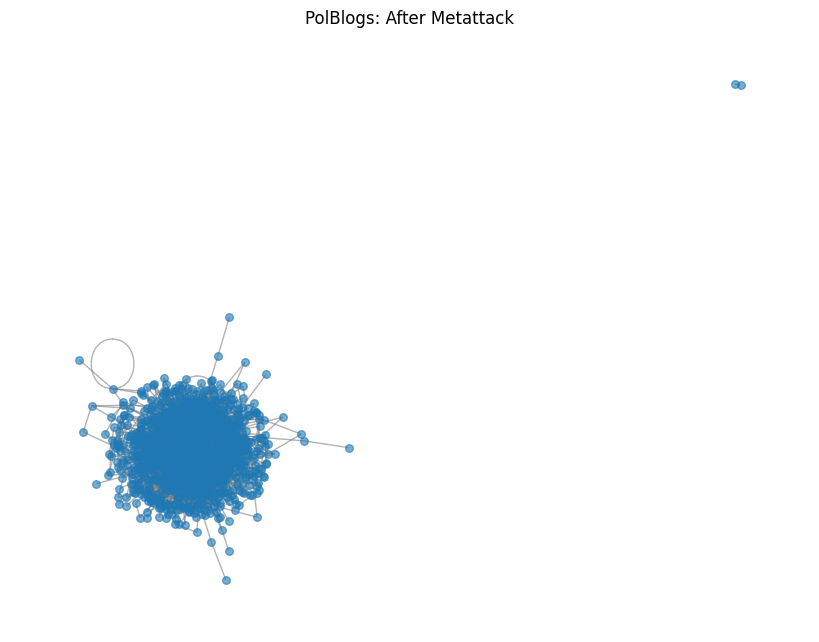

perturbed_adj type: <class 'torch.Tensor'>
Prediction shape: torch.Size([1490, 2])
test_mask shape: torch.Size([1490])
Ground truth labels shape: torch.Size([1490])
Accuracy after Metattack on PolBlogs: 0.8456
Fixing train_mask_shape for Texas...
Adjusting train_masks size for Texas...
Dataset: Texas

Number of nodes: 183
Number of features: 1703
Number of classes: 5

Epoch 0, Loss: 1.7056
Epoch 10, Loss: 0.7951
Epoch 20, Loss: 0.5721
Epoch 30, Loss: 0.5098
Epoch 40, Loss: 0.4180
Epoch 50, Loss: 0.3401
Epoch 60, Loss: 0.3946
Epoch 70, Loss: 0.3902
Epoch 80, Loss: 0.2869
Epoch 90, Loss: 0.3227
----------------------------------------------------------------------------------------------------
Original Graph


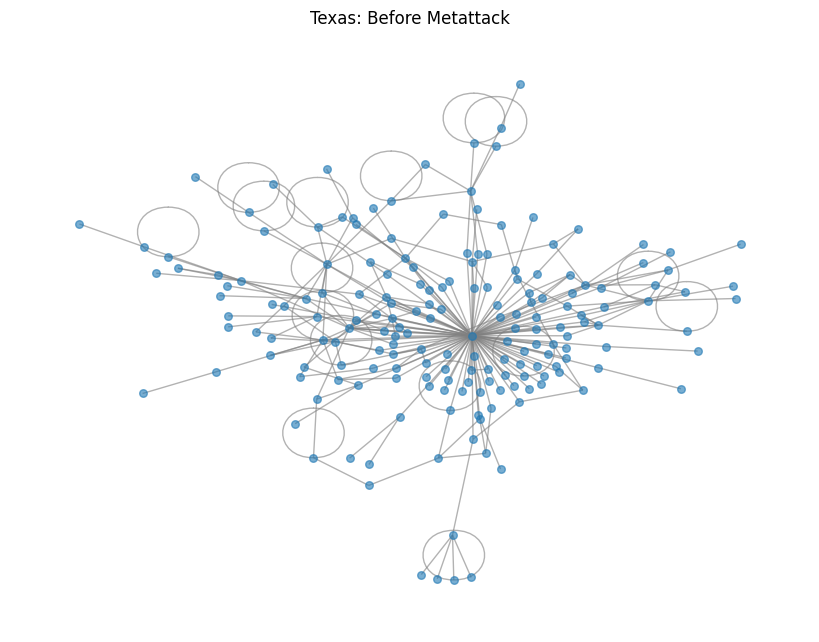

Running on 16 perturbations


Perturbing graph:   0%|          | 0/16 [00:00<?, ?it/s]

GCN loss on unlabled data: 5.981746673583984
GCN acc on unlabled data: 0.3723404255319149
attack loss: 4.791014671325684


Perturbing graph:   6%|▋         | 1/16 [00:00<00:06,  2.22it/s]

GCN loss on unlabled data: 6.220250129699707
GCN acc on unlabled data: 0.22340425531914893
attack loss: 3.3422510623931885


Perturbing graph:  12%|█▎        | 2/16 [00:00<00:06,  2.18it/s]

GCN loss on unlabled data: 6.548930644989014
GCN acc on unlabled data: 0.24468085106382978
attack loss: 4.043173313140869


Perturbing graph:  19%|█▉        | 3/16 [00:01<00:05,  2.24it/s]

GCN loss on unlabled data: 5.68230676651001
GCN acc on unlabled data: 0.20212765957446807
attack loss: 2.716803789138794


Perturbing graph:  25%|██▌       | 4/16 [00:01<00:05,  2.18it/s]

GCN loss on unlabled data: 7.919875144958496
GCN acc on unlabled data: 0.20212765957446807
attack loss: 3.666515350341797


Perturbing graph:  31%|███▏      | 5/16 [00:02<00:04,  2.27it/s]

GCN loss on unlabled data: 7.3061699867248535
GCN acc on unlabled data: 0.20212765957446807
attack loss: 3.0917248725891113


Perturbing graph:  38%|███▊      | 6/16 [00:02<00:04,  2.26it/s]

GCN loss on unlabled data: 6.95544958114624
GCN acc on unlabled data: 0.22340425531914893
attack loss: 2.885183334350586


Perturbing graph:  50%|█████     | 8/16 [00:03<00:03,  2.27it/s]

GCN loss on unlabled data: 5.343669414520264
GCN acc on unlabled data: 0.24468085106382978
attack loss: 2.9546430110931396
GCN loss on unlabled data: 6.0818891525268555
GCN acc on unlabled data: 0.23404255319148937
attack loss: 2.989351987838745


Perturbing graph:  56%|█████▋    | 9/16 [00:04<00:03,  2.22it/s]

GCN loss on unlabled data: 7.736213207244873
GCN acc on unlabled data: 0.1702127659574468
attack loss: 3.89485502243042


Perturbing graph:  62%|██████▎   | 10/16 [00:04<00:02,  2.22it/s]

GCN loss on unlabled data: 5.721010208129883
GCN acc on unlabled data: 0.26595744680851063
attack loss: 3.1924126148223877


Perturbing graph:  69%|██████▉   | 11/16 [00:04<00:02,  2.22it/s]

GCN loss on unlabled data: 5.859247207641602
GCN acc on unlabled data: 0.2765957446808511
attack loss: 3.1549875736236572


Perturbing graph:  75%|███████▌  | 12/16 [00:05<00:01,  2.26it/s]

GCN loss on unlabled data: 6.233287334442139
GCN acc on unlabled data: 0.2872340425531915
attack loss: 3.8717145919799805


Perturbing graph:  81%|████████▏ | 13/16 [00:05<00:01,  2.26it/s]

GCN loss on unlabled data: 6.149807453155518
GCN acc on unlabled data: 0.2872340425531915
attack loss: 3.8953261375427246


Perturbing graph:  94%|█████████▍| 15/16 [00:06<00:00,  2.29it/s]

GCN loss on unlabled data: 6.247790336608887
GCN acc on unlabled data: 0.23404255319148937
attack loss: 3.5132315158843994


Perturbing graph: 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]

GCN loss on unlabled data: 7.007224082946777
GCN acc on unlabled data: 0.24468085106382978
attack loss: 4.3405327796936035


----------------------------------------------------------------------------------------------------
Perturbed Graph


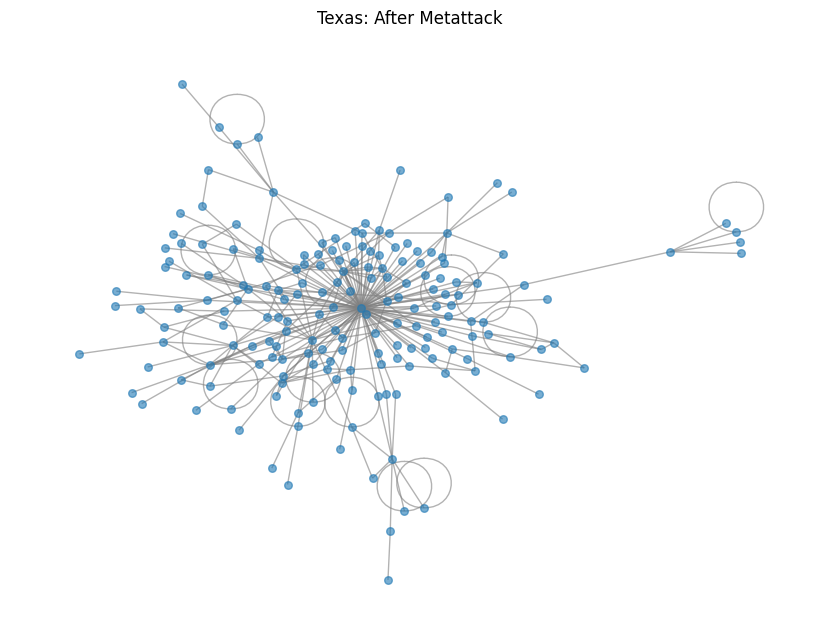

perturbed_adj type: <class 'torch.Tensor'>
Prediction shape: torch.Size([183, 5])
test_mask shape: torch.Size([183])
Ground truth labels shape: torch.Size([183])
Accuracy after Metattack on Texas: 0.3889


In [18]:
# all datasets, uncomment when debugged all
#datasets = ["Cora", "Citeseer", "PolBlogs", "Texas", "Flickr", "PubMed", "ogbn-proteins"]

# Base code these datasets run
datasets = ["Cora", "Citeseer", "PolBlogs", "Texas"]
# These datasets crash - reason: too big, use all available RAM
#datasets = [ "ogbn-proteins", "Flickr", "PubMed"]

for dataset_name in datasets:
  run_experiment(dataset_name)